<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Report
</div>


In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
from torchsummary import summary
from PIL import Image
from torchvision.transforms import functional as F
from torchvision import transforms
import torch
import torch
import torch.nn as nn
import torchvision.models as models


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## A. Data Loading and Preprocessing

In [3]:
# # Download train and val dataset
# !wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
# !wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

In [4]:
# Load Dataset
x_train = np.transpose(np.load('report_train.npy', allow_pickle=True), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy', allow_pickle=True), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

# Convert to PyTorch tensors
x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).long()

x_val_torch = torch.from_numpy(x_val).float()
y_val_torch = torch.from_numpy(y_val).long()

Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


In [89]:
x_tv_torch = torch.concatenate((x_train_torch, x_val_torch))
y_tv_torch = torch.concatenate((y_train_torch, y_val_torch))
print(x_tv_torch.shape, y_tv_torch.shape)

torch.Size([3150, 3, 150, 150]) torch.Size([3150])


In [5]:
# Custom transformation class to convert a tensor to a PIL image
class ToPILImage(object):
    def __call__(self, tensor):
        return F.to_pil_image(tensor)
    
tpi = ToPILImage()

In [6]:
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
    ])


x_val_transformed = torch.stack([inference_transform(tpi(x)) for x in x_val_torch])

print(f'Shape of x_train: {x_train_torch.shape}')
print(f'Shape of x_val: {x_val_transformed.shape}')
print(f'X_val: max value is {x_val_transformed.max().item()}, min value is {x_val_transformed.min().item()}, data type is {x_val_transformed.dtype}.')

Shape of x_train: torch.Size([2550, 3, 150, 150])
Shape of x_val: torch.Size([600, 3, 224, 224])
X_val: max value is 2.6051416397094727, min value is -2.1007792949676514, data type is torch.float32.


In [7]:
from torchvision import transforms

# Defining the augmentation transforms
augmentation_transforms = transforms.Compose([
    # Resize the images to 224x224 pixels
    transforms.Resize((224, 224)),
    # Random horizontal flipping
    transforms.RandomHorizontalFlip(p=0.2),
    # Random vertical flipping
    transforms.RandomVerticalFlip(p=0.2),
    # Random rotation
    transforms.RandomRotation(degrees=30),
    # Random color jitter
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Random zooming (crop and resize)
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0), ratio=(0.8, 1.25)),
#     # Random perspective transformation
#     transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
#     # Apply Gaussian Blur
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#     # Random affine transformation (shear and scale)
#     transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    
    # Convert image to PyTorch tensor
    transforms.ToTensor(),
    # Normalize the images
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])


In [8]:
batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train_torch, y_train_torch)
val_dataset = TensorDataset(x_val_transformed, y_val_torch)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train_torch.max().item()}, min value is {x_train_torch.min().item()}, data type is {x_train_torch.dtype}.')
print(f'X_val: max value is {x_val_transformed.max().item()}, min value is {x_val_transformed.min().item()}, data type is {x_val_transformed.dtype}.')

Number of samples in train and validation are 2550 and 600.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
X_val: max value is 2.6051416397094727, min value is -2.1007792949676514, data type is torch.float32.


In [90]:
tv_dataset = TensorDataset(x_tv_torch, y_tv_torch)
tv_loader = DataLoader(tv_dataset, batch_size=batch_size, shuffle=True)
print(f'Number of samples in train and validation are {len(tv_loader.dataset)}.')
print(f'X_train: max value is {x_tv_torch.max().item()}, min value is {x_tv_torch.min().item()}, data type is {x_tv_torch.dtype}.')

Number of samples in train and validation are 3150.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


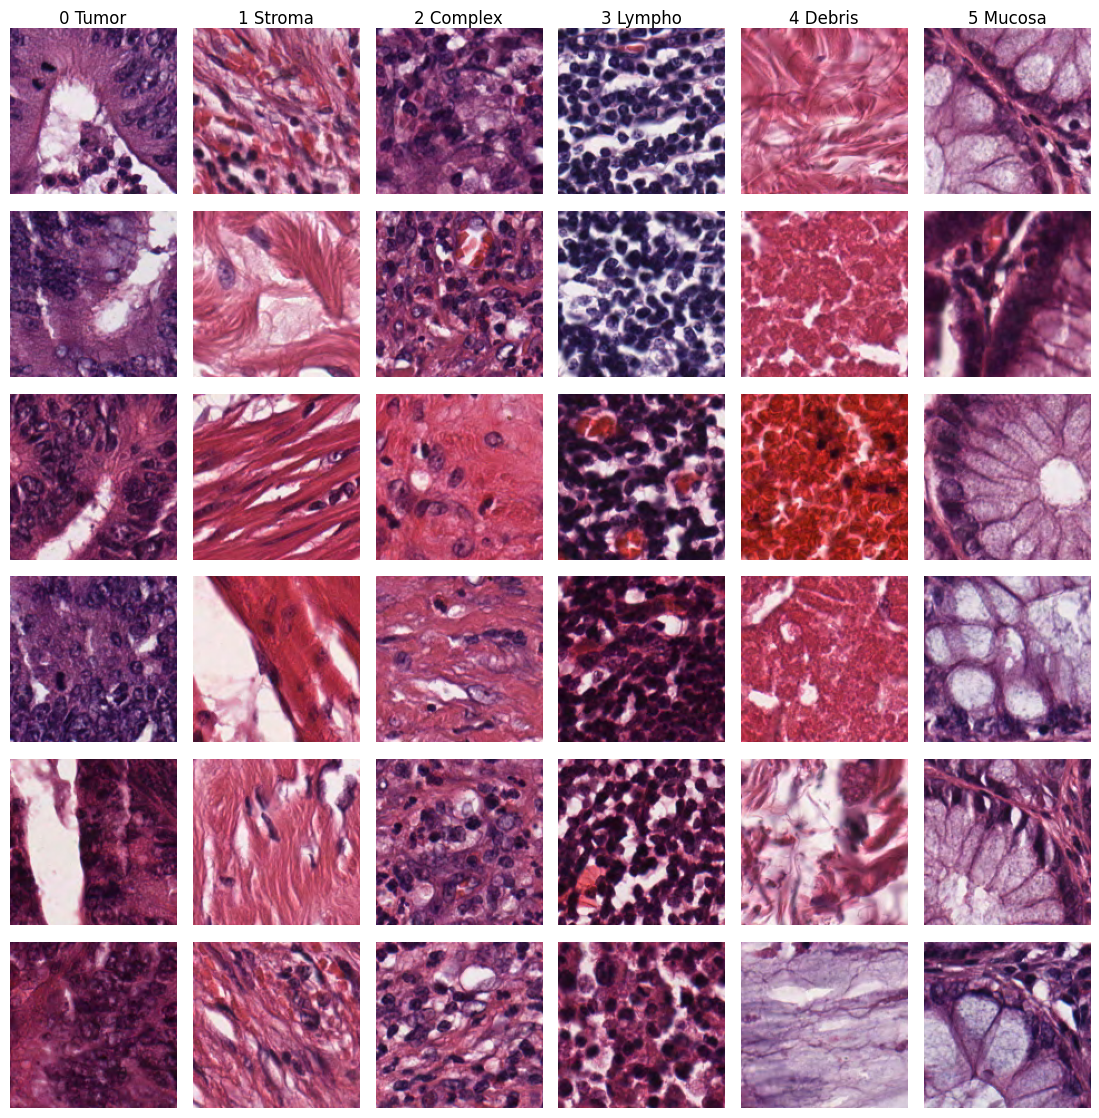

In [9]:
class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 6

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 12))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_train_torch == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)
    
    for i in range(samples_per_class):
        ax = axes[i, class_idx]
#         img = x_train[random_indices[i]].numpy().transpose((1, 2, 0))
        img = x_train_torch[random_indices[i]].numpy().transpose((1, 2, 0))
        img = img / img.max() 
        ax.imshow(img)
        ax.axis('off')  
        
        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

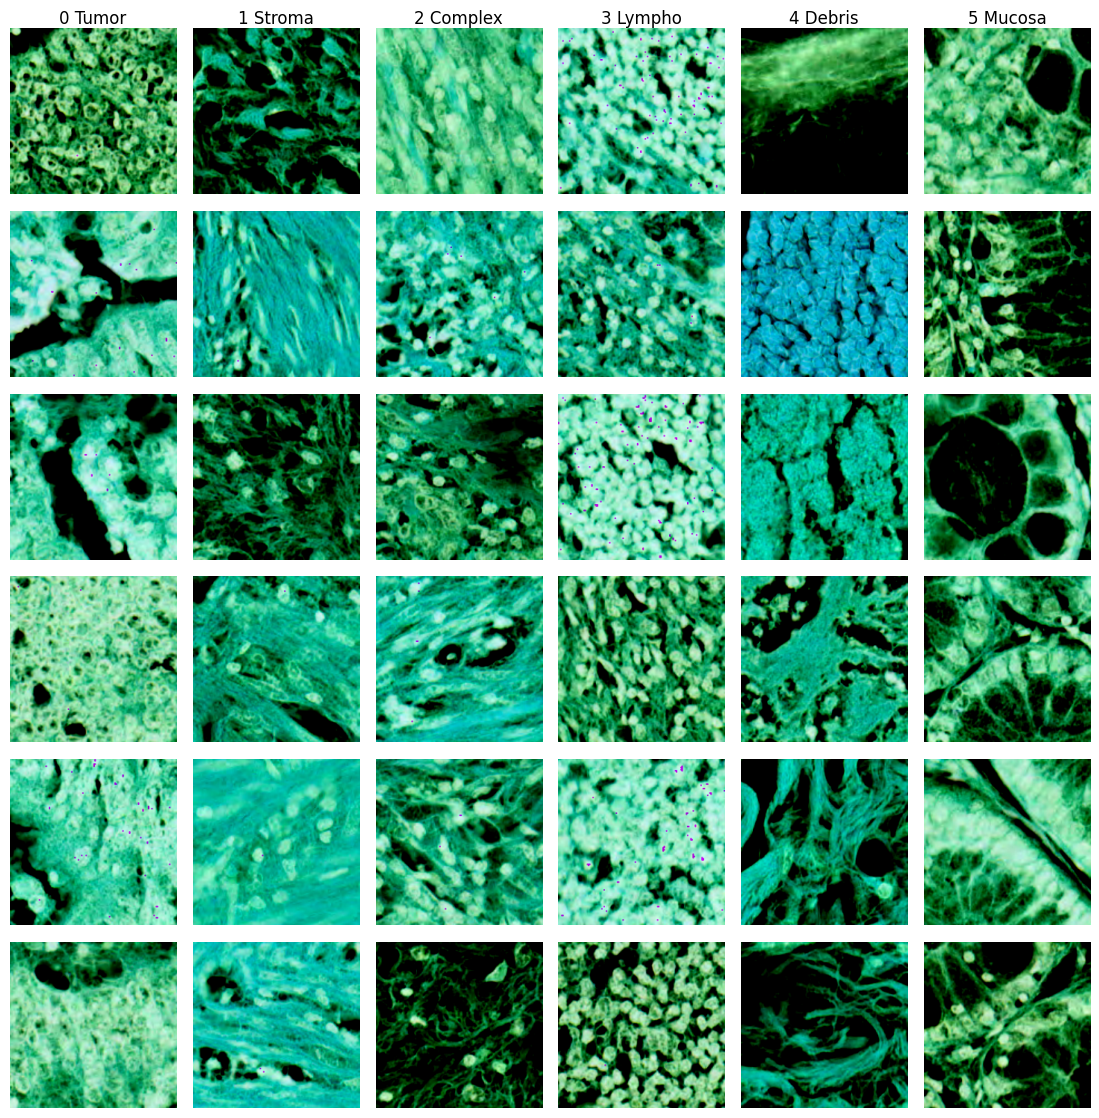

In [10]:
class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 6

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 12))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_val_torch == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)
    
    for i in range(samples_per_class):
        ax = axes[i, class_idx]
        img = x_val_transformed[random_indices[i]].numpy().transpose((1, 2, 0))
        img = img / img.max() 
        ax.imshow(img)
        ax.axis('off')  
        
        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

## B. Defining Neural Networks

In [11]:

# # Load the pre-trained VGG16 model
# vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# # Extract layers 0 to 16 from vgg16.features
# selected_features = nn.Sequential(*list(vgg16.features.children())[:14])

# # Extract layer 31 (AdaptiveAvgPool2d) from vgg16.classifier
# selected_avgpool = vgg16.avgpool

# # Create the new model
# class CustomVGG16(nn.Module):
#     def __init__(self):
#         super(CustomVGG16, self).__init__()
#         self.features = selected_features
#         self.avgpool = selected_avgpool
#         # Dynamically determine the number of input features to the new fully connected layer
#         num_features = self._get_conv_output_shape()
#         self.classifier = nn.Linear(num_features, 6)

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

#     def _get_conv_output_shape(self):
#         with torch.no_grad():
#             input = torch.zeros(1, 3, 224, 224)  # Assuming input size is 224x224
#             output = self.features(input)
#             output = self.avgpool(output)
#             return output.view(1, -1).size(1)

# # Instantiate the new model
# custom_vgg16 = CustomVGG16()

# # If you're using a GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom_vgg16 = custom_vgg16.to(device)
# print(summary(custom_vgg16, (3, 224, 224)))

In [225]:
import torch
import torch.nn as nn
from torchvision import models

class CustomVGG16_plus(nn.Module):
    def __init__(self, units):
        super(CustomVGG16_plus, self).__init__()
        # Extract selected features from the pre-trained VGG16 model
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(vgg16.features.children())[:17])
        self.avgpool = vgg16.avgpool

        # Dynamically determine the number of input features
        num_features = self._get_conv_output_shape()

        # Define the classifier with dropout and batch normalization
        self.classifier = nn.Sequential(
            nn.Linear(num_features, units),  # First fully connected layer
            nn.BatchNorm1d(units),           # Batch normalization
            nn.ReLU(),                     # Activation function
            nn.Dropout(0.5),               # Dropout with 50% probability

            nn.Linear(units, 6)              # Final layer with 6 outputs
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _get_conv_output_shape(self):
        # Dummy input to calculate feature size
        with torch.no_grad():
            input = torch.zeros(1, 3, 224, 224)  # Assuming input size is 224x224
            output = self.features(input)
            output = self.avgpool(output)
            return output.view(1, -1).size(1)


In [77]:
# # Instantiate the new model
# custom_vgg16_plus = CustomVGG16_plus()

# # If you're using a GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom_vgg16_plus = custom_vgg16_plus.to(device)
# print(summary(custom_vgg16_plus, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [226]:
vgg16_plus_128 = CustomVGG16_plus(128).to('cuda')
# non-trainable parameters
# for param in vgg16_plus_512.features.parameters():
#     param.requires_grad = False

print(summary(vgg16_plus_128, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [262]:
vgg16_plus_512 = CustomVGG16_plus(512).to('cuda')
# non-trainable parameters
# for param in vgg16_plus_512.features.parameters():
#     param.requires_grad = False

print(summary(vgg16_plus_512, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [192]:
import pickle

def save_data_pickle(data, filename):
    """Save data to a file using pickle.

    Args:
        data: The data to be saved.
        filename: The name of the file where the data will be stored.
    """
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

        
def load_data_pickle(filename):
    """Load data from a pickle file.

    Args:
        filename: The name of the file to load data from.

    Returns:
        The data loaded from the file.
    """
    with open(filename, 'rb') as file:
        return pickle.load(file)


## C. Training the Neural Network

In [276]:
def training(model, train_loader=None, val_loader=None, 
             performance=None, mode='classifier', num_epochs=10, 
             model_path=None, performance_path=None):
    
    if not performance:
        performance = {'train_losses': [], 
                       'train_accuracies': [], 
                       'train_logit_outputs': [], 
                       'val_losses': [], 
                       'val_accuracies': [], 
                       'val_logit_outputs': []}

    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    
    if mode == 'classifier':
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
    elif mode == 'full_parameters':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        print('The mode is incorrect! No training is performed.')

    best_acc = 0

    def calculate_accuracy(outputs, labels):
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        return correct / labels.size(0)

    for epoch in tqdm(range(num_epochs)):
        
        if train_loader:
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            total_train = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                inputs = torch.stack([augmentation_transforms(tpi(inpt)) for inpt in inputs]).to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_correct += calculate_accuracy(outputs, labels) * labels.size(0)
                total_train += labels.size(0)
                
            # Calculate average losses and accuracies
            train_loss = train_loss / len(train_loader)
            train_accuracy = train_correct / total_train
            performance['train_losses'].append(train_loss)
            performance['train_accuracies'].append(train_accuracy)
            performance['train_logit_outputs'].extend(outputs.tolist())
                
        if val_loader:
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    val_correct += calculate_accuracy(outputs, labels) * labels.size(0)
                    total_val += labels.size(0)

            # Calculate average losses and accuracies
            val_loss = val_loss / len(val_loader)
            val_accuracy = val_correct / total_val
            performance['val_losses'].append(val_loss)
            performance['val_accuracies'].append(val_accuracy)
            performance['val_logit_outputs'].extend(outputs.tolist())

            if best_acc < val_accuracy:
                if performance_path:
                    save_data_pickle(performance, performance_path + f'valacc_{val_accuracy:.4f}.pkl')
                if model_path:
                    torch.save(model, model_path + f'valacc_{val_accuracy:.4f}.pth')
                best_acc = val_accuracy

        if (epoch + 1) % 10 == 0:
            real_epoch = epoch + 51
            if performance_path:
                save_data_pickle(performance, performance_path + f'epochs_{real_epoch}.pkl')
            if model_path:
                torch.save(model, model_path + f'epochs_{real_epoch}.pth')

        print(f'Epoch {epoch+1}/{num_epochs}', 
              (f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}\n')  if train_loader else '', 
              (f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}') if val_loader else '')

    return model, performance

In [197]:
# vgg16_plus_512, fixed feature extractor
model, performance = training(vgg16_plus_512, train_loader=train_loader, val_loader=val_loader, 
             performance=None, mode='classifier', num_epochs=500, 
             model_path='./saved_models/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier_', 
             performance_path='./performance/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier_')

  0%|▏                                                                               | 1/500 [00:57<8:02:07, 57.97s/it]

Epoch 1/500 Train Loss: 1.2971, Train Accuracy: 0.5267
 Validation Loss: 0.6870, Validation Accuracy: 0.7333


  0%|▎                                                                               | 2/500 [01:43<6:59:50, 50.58s/it]

Epoch 2/500 Train Loss: 0.8822, Train Accuracy: 0.6851
 Validation Loss: 0.6585, Validation Accuracy: 0.7783


  1%|▍                                                                               | 3/500 [02:26<6:32:36, 47.40s/it]

Epoch 3/500 Train Loss: 0.6954, Train Accuracy: 0.7463
 Validation Loss: 0.5605, Validation Accuracy: 0.7950


  1%|▋                                                                               | 4/500 [03:11<6:23:18, 46.37s/it]

Epoch 4/500 Train Loss: 0.6230, Train Accuracy: 0.7718
 Validation Loss: 0.4779, Validation Accuracy: 0.8450


  1%|▊                                                                               | 5/500 [03:53<6:08:38, 44.68s/it]

Epoch 5/500 Train Loss: 0.5978, Train Accuracy: 0.7882
 Validation Loss: 0.4857, Validation Accuracy: 0.8400


  1%|▉                                                                               | 6/500 [04:37<6:05:48, 44.43s/it]

Epoch 6/500 Train Loss: 0.5651, Train Accuracy: 0.7984
 Validation Loss: 0.4629, Validation Accuracy: 0.8400


  1%|█                                                                               | 7/500 [05:21<6:03:54, 44.29s/it]

Epoch 7/500 Train Loss: 0.4818, Train Accuracy: 0.8255
 Validation Loss: 0.4520, Validation Accuracy: 0.8500


  2%|█▎                                                                              | 8/500 [06:05<6:03:46, 44.36s/it]

Epoch 8/500 Train Loss: 0.4625, Train Accuracy: 0.8333
 Validation Loss: 0.4289, Validation Accuracy: 0.8467


  2%|█▍                                                                              | 9/500 [06:50<6:03:57, 44.48s/it]

Epoch 9/500 Train Loss: 0.4908, Train Accuracy: 0.8212
 Validation Loss: 0.5727, Validation Accuracy: 0.8050


  2%|█▌                                                                             | 10/500 [07:33<5:58:30, 43.90s/it]

Epoch 10/500 Train Loss: 0.4625, Train Accuracy: 0.8404
 Validation Loss: 0.3601, Validation Accuracy: 0.8683


  2%|█▋                                                                             | 11/500 [08:17<5:58:58, 44.05s/it]

Epoch 11/500 Train Loss: 0.4194, Train Accuracy: 0.8518
 Validation Loss: 0.3945, Validation Accuracy: 0.8467


  2%|█▉                                                                             | 12/500 [09:02<6:00:41, 44.35s/it]

Epoch 12/500 Train Loss: 0.4310, Train Accuracy: 0.8482
 Validation Loss: 0.4112, Validation Accuracy: 0.8283


  3%|██                                                                             | 13/500 [09:46<5:57:32, 44.05s/it]

Epoch 13/500 Train Loss: 0.4123, Train Accuracy: 0.8482
 Validation Loss: 0.3362, Validation Accuracy: 0.8750


  3%|██▏                                                                            | 14/500 [10:30<5:56:49, 44.05s/it]

Epoch 14/500 Train Loss: 0.4140, Train Accuracy: 0.8455
 Validation Loss: 0.3239, Validation Accuracy: 0.8733


  3%|██▎                                                                            | 15/500 [11:12<5:53:08, 43.69s/it]

Epoch 15/500 Train Loss: 0.3836, Train Accuracy: 0.8655
 Validation Loss: 0.3856, Validation Accuracy: 0.8617


  3%|██▌                                                                            | 16/500 [11:53<5:45:00, 42.77s/it]

Epoch 16/500 Train Loss: 0.3917, Train Accuracy: 0.8584
 Validation Loss: 0.3638, Validation Accuracy: 0.8583


  3%|██▋                                                                            | 17/500 [12:40<5:54:39, 44.06s/it]

Epoch 17/500 Train Loss: 0.3913, Train Accuracy: 0.8584
 Validation Loss: 0.3162, Validation Accuracy: 0.8883


  4%|██▊                                                                            | 18/500 [13:27<6:00:46, 44.91s/it]

Epoch 18/500 Train Loss: 0.3784, Train Accuracy: 0.8639
 Validation Loss: 0.3333, Validation Accuracy: 0.8817


  4%|███                                                                            | 19/500 [14:11<5:58:42, 44.74s/it]

Epoch 19/500 Train Loss: 0.3641, Train Accuracy: 0.8714
 Validation Loss: 0.3503, Validation Accuracy: 0.8667


  4%|███▏                                                                           | 20/500 [14:56<5:57:04, 44.63s/it]

Epoch 20/500 Train Loss: 0.3805, Train Accuracy: 0.8565
 Validation Loss: 0.4245, Validation Accuracy: 0.8550


  4%|███▎                                                                           | 21/500 [15:35<5:43:35, 43.04s/it]

Epoch 21/500 Train Loss: 0.3667, Train Accuracy: 0.8686
 Validation Loss: 0.3805, Validation Accuracy: 0.8717


  4%|███▍                                                                           | 22/500 [16:18<5:42:02, 42.93s/it]

Epoch 22/500 Train Loss: 0.3333, Train Accuracy: 0.8808
 Validation Loss: 0.3277, Validation Accuracy: 0.8883


  5%|███▋                                                                           | 23/500 [16:59<5:36:23, 42.31s/it]

Epoch 23/500 Train Loss: 0.3637, Train Accuracy: 0.8722
 Validation Loss: 0.3004, Validation Accuracy: 0.8950


  5%|███▊                                                                           | 24/500 [17:39<5:31:54, 41.84s/it]

Epoch 24/500 Train Loss: 0.3400, Train Accuracy: 0.8820
 Validation Loss: 0.4105, Validation Accuracy: 0.8517


  5%|███▉                                                                           | 25/500 [18:20<5:29:02, 41.56s/it]

Epoch 25/500 Train Loss: 0.3454, Train Accuracy: 0.8831
 Validation Loss: 0.3478, Validation Accuracy: 0.8717


  5%|████                                                                           | 26/500 [19:01<5:27:11, 41.42s/it]

Epoch 26/500 Train Loss: 0.3488, Train Accuracy: 0.8675
 Validation Loss: 0.3564, Validation Accuracy: 0.8767


  5%|████▎                                                                          | 27/500 [19:41<5:22:09, 40.87s/it]

Epoch 27/500 Train Loss: 0.3670, Train Accuracy: 0.8612
 Validation Loss: 0.4838, Validation Accuracy: 0.8383


  6%|████▍                                                                          | 28/500 [20:20<5:18:09, 40.44s/it]

Epoch 28/500 Train Loss: 0.3242, Train Accuracy: 0.8804
 Validation Loss: 0.4508, Validation Accuracy: 0.8400


  6%|████▌                                                                          | 29/500 [21:01<5:16:46, 40.35s/it]

Epoch 29/500 Train Loss: 0.3383, Train Accuracy: 0.8871
 Validation Loss: 0.4336, Validation Accuracy: 0.8533


  6%|████▋                                                                          | 30/500 [21:41<5:17:28, 40.53s/it]

Epoch 30/500 Train Loss: 0.3359, Train Accuracy: 0.8831
 Validation Loss: 0.3045, Validation Accuracy: 0.8767


  6%|████▉                                                                          | 31/500 [22:22<5:17:00, 40.56s/it]

Epoch 31/500 Train Loss: 0.3077, Train Accuracy: 0.8843
 Validation Loss: 0.3540, Validation Accuracy: 0.8650


  6%|█████                                                                          | 32/500 [23:02<5:15:20, 40.43s/it]

Epoch 32/500 Train Loss: 0.3183, Train Accuracy: 0.8839
 Validation Loss: 0.3990, Validation Accuracy: 0.8633


  7%|█████▏                                                                         | 33/500 [23:42<5:13:56, 40.34s/it]

Epoch 33/500 Train Loss: 0.3152, Train Accuracy: 0.8827
 Validation Loss: 0.3430, Validation Accuracy: 0.8783


  7%|█████▎                                                                         | 34/500 [24:22<5:11:11, 40.07s/it]

Epoch 34/500 Train Loss: 0.3227, Train Accuracy: 0.8831
 Validation Loss: 0.3463, Validation Accuracy: 0.8850


  7%|█████▌                                                                         | 35/500 [25:03<5:13:16, 40.42s/it]

Epoch 35/500 Train Loss: 0.3110, Train Accuracy: 0.8918
 Validation Loss: 0.4407, Validation Accuracy: 0.8533


  7%|█████▋                                                                         | 36/500 [25:47<5:20:39, 41.46s/it]

Epoch 36/500 Train Loss: 0.2927, Train Accuracy: 0.8933
 Validation Loss: 0.3635, Validation Accuracy: 0.8717


  7%|█████▊                                                                         | 37/500 [26:29<5:21:15, 41.63s/it]

Epoch 37/500 Train Loss: 0.2908, Train Accuracy: 0.8976
 Validation Loss: 0.4448, Validation Accuracy: 0.8533


  8%|██████                                                                         | 38/500 [27:09<5:17:08, 41.19s/it]

Epoch 38/500 Train Loss: 0.2830, Train Accuracy: 0.8969
 Validation Loss: 0.4007, Validation Accuracy: 0.8683


  8%|██████▏                                                                        | 39/500 [27:49<5:14:14, 40.90s/it]

Epoch 39/500 Train Loss: 0.3426, Train Accuracy: 0.8741
 Validation Loss: 0.3091, Validation Accuracy: 0.8883


  8%|██████▎                                                                        | 40/500 [28:29<5:11:24, 40.62s/it]

Epoch 40/500 Train Loss: 0.3197, Train Accuracy: 0.8929
 Validation Loss: 0.3872, Validation Accuracy: 0.8583


  8%|██████▍                                                                        | 41/500 [29:11<5:12:28, 40.85s/it]

Epoch 41/500 Train Loss: 0.3049, Train Accuracy: 0.8918
 Validation Loss: 0.3306, Validation Accuracy: 0.8717


  8%|██████▋                                                                        | 42/500 [29:53<5:15:13, 41.30s/it]

Epoch 42/500 Train Loss: 0.3217, Train Accuracy: 0.8851
 Validation Loss: 0.3448, Validation Accuracy: 0.8717


  9%|██████▊                                                                        | 43/500 [30:34<5:14:53, 41.34s/it]

Epoch 43/500 Train Loss: 0.2927, Train Accuracy: 0.8925
 Validation Loss: 0.4048, Validation Accuracy: 0.8550


  9%|██████▉                                                                        | 44/500 [31:16<5:13:28, 41.25s/it]

Epoch 44/500 Train Loss: 0.3032, Train Accuracy: 0.8933
 Validation Loss: 0.4063, Validation Accuracy: 0.8517


  9%|███████                                                                        | 45/500 [31:55<5:09:41, 40.84s/it]

Epoch 45/500 Train Loss: 0.3036, Train Accuracy: 0.8953
 Validation Loss: 0.3009, Validation Accuracy: 0.8917


  9%|███████▎                                                                       | 46/500 [32:35<5:05:21, 40.36s/it]

Epoch 46/500 Train Loss: 0.2883, Train Accuracy: 0.9008
 Validation Loss: 0.3710, Validation Accuracy: 0.8933


  9%|███████▍                                                                       | 47/500 [33:16<5:06:43, 40.63s/it]

Epoch 47/500 Train Loss: 0.2835, Train Accuracy: 0.8949
 Validation Loss: 0.3252, Validation Accuracy: 0.8850


 10%|███████▌                                                                       | 48/500 [33:58<5:08:33, 40.96s/it]

Epoch 48/500 Train Loss: 0.2770, Train Accuracy: 0.8980
 Validation Loss: 0.3133, Validation Accuracy: 0.8933


 10%|███████▋                                                                       | 49/500 [34:40<5:10:07, 41.26s/it]

Epoch 49/500 Train Loss: 0.2967, Train Accuracy: 0.8969
 Validation Loss: 0.2914, Validation Accuracy: 0.8817


 10%|███████▉                                                                       | 50/500 [35:20<5:07:46, 41.04s/it]

Epoch 50/500 Train Loss: 0.3130, Train Accuracy: 0.8914
 Validation Loss: 0.3741, Validation Accuracy: 0.8583


 10%|████████                                                                       | 51/500 [36:00<5:05:25, 40.81s/it]

Epoch 51/500 Train Loss: 0.2979, Train Accuracy: 0.8961
 Validation Loss: 0.3057, Validation Accuracy: 0.8900


 10%|████████▏                                                                      | 52/500 [36:40<5:01:43, 40.41s/it]

Epoch 52/500 Train Loss: 0.2491, Train Accuracy: 0.9122
 Validation Loss: 0.3516, Validation Accuracy: 0.8833


 11%|████████▎                                                                      | 53/500 [37:21<5:02:16, 40.57s/it]

Epoch 53/500 Train Loss: 0.2404, Train Accuracy: 0.9106
 Validation Loss: 0.3448, Validation Accuracy: 0.8833


 11%|████████▌                                                                      | 54/500 [38:02<5:02:05, 40.64s/it]

Epoch 54/500 Train Loss: 0.2790, Train Accuracy: 0.8957
 Validation Loss: 0.4016, Validation Accuracy: 0.8750


 11%|████████▋                                                                      | 55/500 [38:43<5:03:22, 40.91s/it]

Epoch 55/500 Train Loss: 0.2920, Train Accuracy: 0.8976
 Validation Loss: 0.3319, Validation Accuracy: 0.8817


 11%|████████▊                                                                      | 56/500 [39:23<5:00:14, 40.57s/it]

Epoch 56/500 Train Loss: 0.3097, Train Accuracy: 0.8933
 Validation Loss: 0.3176, Validation Accuracy: 0.8800


 11%|█████████                                                                      | 57/500 [40:03<4:58:35, 40.44s/it]

Epoch 57/500 Train Loss: 0.2324, Train Accuracy: 0.9196
 Validation Loss: 0.3466, Validation Accuracy: 0.8933


 12%|█████████▏                                                                     | 58/500 [40:43<4:55:56, 40.17s/it]

Epoch 58/500 Train Loss: 0.2505, Train Accuracy: 0.9180
 Validation Loss: 0.3953, Validation Accuracy: 0.8700


 12%|█████████▎                                                                     | 59/500 [41:25<4:59:45, 40.78s/it]

Epoch 59/500 Train Loss: 0.2528, Train Accuracy: 0.9055
 Validation Loss: 0.3738, Validation Accuracy: 0.8817


 12%|█████████▍                                                                     | 60/500 [42:06<5:00:01, 40.91s/it]

Epoch 60/500 Train Loss: 0.2588, Train Accuracy: 0.9114
 Validation Loss: 0.3508, Validation Accuracy: 0.8783


 12%|█████████▋                                                                     | 61/500 [42:47<4:59:25, 40.92s/it]

Epoch 61/500 Train Loss: 0.2759, Train Accuracy: 0.8992
 Validation Loss: 0.3397, Validation Accuracy: 0.8867


 12%|█████████▊                                                                     | 62/500 [43:27<4:57:22, 40.74s/it]

Epoch 62/500 Train Loss: 0.2743, Train Accuracy: 0.9051
 Validation Loss: 0.3001, Validation Accuracy: 0.9000


 13%|█████████▉                                                                     | 63/500 [44:08<4:55:55, 40.63s/it]

Epoch 63/500 Train Loss: 0.2340, Train Accuracy: 0.9173
 Validation Loss: 0.2998, Validation Accuracy: 0.8917


 13%|██████████                                                                     | 64/500 [44:51<5:01:41, 41.52s/it]

Epoch 64/500 Train Loss: 0.2466, Train Accuracy: 0.9122
 Validation Loss: 0.6273, Validation Accuracy: 0.8350


 13%|██████████▎                                                                    | 65/500 [45:33<5:00:27, 41.44s/it]

Epoch 65/500 Train Loss: 0.2765, Train Accuracy: 0.9020
 Validation Loss: 0.3823, Validation Accuracy: 0.8733


 13%|██████████▍                                                                    | 66/500 [46:13<4:58:33, 41.27s/it]

Epoch 66/500 Train Loss: 0.2764, Train Accuracy: 0.9039
 Validation Loss: 0.2696, Validation Accuracy: 0.9067


 13%|██████████▌                                                                    | 67/500 [46:54<4:56:55, 41.15s/it]

Epoch 67/500 Train Loss: 0.2592, Train Accuracy: 0.9047
 Validation Loss: 0.3046, Validation Accuracy: 0.8867


 14%|██████████▋                                                                    | 68/500 [47:34<4:53:44, 40.80s/it]

Epoch 68/500 Train Loss: 0.2621, Train Accuracy: 0.8973
 Validation Loss: 0.3058, Validation Accuracy: 0.8917


 14%|██████████▉                                                                    | 69/500 [48:14<4:51:35, 40.59s/it]

Epoch 69/500 Train Loss: 0.2634, Train Accuracy: 0.9055
 Validation Loss: 0.3637, Validation Accuracy: 0.8717


 14%|███████████                                                                    | 70/500 [48:54<4:49:07, 40.34s/it]

Epoch 70/500 Train Loss: 0.2597, Train Accuracy: 0.9090
 Validation Loss: 0.3392, Validation Accuracy: 0.8850


 14%|███████████▏                                                                   | 71/500 [49:34<4:48:31, 40.35s/it]

Epoch 71/500 Train Loss: 0.2437, Train Accuracy: 0.9086
 Validation Loss: 0.3461, Validation Accuracy: 0.8700


 14%|███████████▍                                                                   | 72/500 [50:16<4:50:50, 40.77s/it]

Epoch 72/500 Train Loss: 0.2503, Train Accuracy: 0.9129
 Validation Loss: 0.3716, Validation Accuracy: 0.8700


 15%|███████████▌                                                                   | 73/500 [50:56<4:48:46, 40.58s/it]

Epoch 73/500 Train Loss: 0.2751, Train Accuracy: 0.9047
 Validation Loss: 0.2955, Validation Accuracy: 0.8950


 15%|███████████▋                                                                   | 74/500 [51:36<4:46:59, 40.42s/it]

Epoch 74/500 Train Loss: 0.2607, Train Accuracy: 0.9133
 Validation Loss: 0.3626, Validation Accuracy: 0.8750


 15%|███████████▊                                                                   | 75/500 [52:17<4:45:47, 40.35s/it]

Epoch 75/500 Train Loss: 0.2505, Train Accuracy: 0.9094
 Validation Loss: 0.3370, Validation Accuracy: 0.8833


 15%|████████████                                                                   | 76/500 [52:57<4:44:46, 40.30s/it]

Epoch 76/500 Train Loss: 0.2542, Train Accuracy: 0.9184
 Validation Loss: 0.3769, Validation Accuracy: 0.8717


 15%|████████████▏                                                                  | 77/500 [53:38<4:46:08, 40.59s/it]

Epoch 77/500 Train Loss: 0.2437, Train Accuracy: 0.9176
 Validation Loss: 0.3530, Validation Accuracy: 0.8833


 16%|████████████▎                                                                  | 78/500 [54:19<4:47:03, 40.81s/it]

Epoch 78/500 Train Loss: 0.2583, Train Accuracy: 0.9122
 Validation Loss: 0.3551, Validation Accuracy: 0.8900


 16%|████████████▍                                                                  | 79/500 [55:00<4:45:32, 40.70s/it]

Epoch 79/500 Train Loss: 0.2647, Train Accuracy: 0.9137
 Validation Loss: 0.2904, Validation Accuracy: 0.8933


 16%|████████████▋                                                                  | 80/500 [55:40<4:42:55, 40.42s/it]

Epoch 80/500 Train Loss: 0.2397, Train Accuracy: 0.9141
 Validation Loss: 0.3164, Validation Accuracy: 0.8900


 16%|████████████▊                                                                  | 81/500 [56:19<4:40:48, 40.21s/it]

Epoch 81/500 Train Loss: 0.2217, Train Accuracy: 0.9298
 Validation Loss: 0.3481, Validation Accuracy: 0.8900


 16%|████████████▉                                                                  | 82/500 [56:59<4:39:14, 40.08s/it]

Epoch 82/500 Train Loss: 0.2238, Train Accuracy: 0.9196
 Validation Loss: 0.3147, Validation Accuracy: 0.8950


 17%|█████████████                                                                  | 83/500 [57:40<4:41:19, 40.48s/it]

Epoch 83/500 Train Loss: 0.2424, Train Accuracy: 0.9118
 Validation Loss: 0.3592, Validation Accuracy: 0.8867


 17%|█████████████▎                                                                 | 84/500 [58:22<4:42:07, 40.69s/it]

Epoch 84/500 Train Loss: 0.2152, Train Accuracy: 0.9255
 Validation Loss: 0.2902, Validation Accuracy: 0.8917


 17%|█████████████▍                                                                 | 85/500 [59:02<4:40:28, 40.55s/it]

Epoch 85/500 Train Loss: 0.2290, Train Accuracy: 0.9161
 Validation Loss: 0.3015, Validation Accuracy: 0.8917


 17%|█████████████▌                                                                 | 86/500 [59:42<4:38:11, 40.32s/it]

Epoch 86/500 Train Loss: 0.2268, Train Accuracy: 0.9192
 Validation Loss: 0.3433, Validation Accuracy: 0.8900


 17%|█████████████▍                                                               | 87/500 [1:00:21<4:36:25, 40.16s/it]

Epoch 87/500 Train Loss: 0.2270, Train Accuracy: 0.9192
 Validation Loss: 0.2649, Validation Accuracy: 0.9050


 18%|█████████████▌                                                               | 88/500 [1:01:02<4:35:51, 40.17s/it]

Epoch 88/500 Train Loss: 0.2192, Train Accuracy: 0.9216
 Validation Loss: 0.4071, Validation Accuracy: 0.8700


 18%|█████████████▋                                                               | 89/500 [1:01:43<4:36:52, 40.42s/it]

Epoch 89/500 Train Loss: 0.2405, Train Accuracy: 0.9192
 Validation Loss: 0.2977, Validation Accuracy: 0.8950


 18%|█████████████▊                                                               | 90/500 [1:02:24<4:38:41, 40.78s/it]

Epoch 90/500 Train Loss: 0.2200, Train Accuracy: 0.9208
 Validation Loss: 0.3271, Validation Accuracy: 0.8933


 18%|██████████████                                                               | 91/500 [1:03:04<4:36:19, 40.54s/it]

Epoch 91/500 Train Loss: 0.2375, Train Accuracy: 0.9157
 Validation Loss: 0.3509, Validation Accuracy: 0.8917


 18%|██████████████▏                                                              | 92/500 [1:03:44<4:34:01, 40.30s/it]

Epoch 92/500 Train Loss: 0.2408, Train Accuracy: 0.9141
 Validation Loss: 0.3229, Validation Accuracy: 0.9017


 19%|██████████████▎                                                              | 93/500 [1:04:24<4:31:52, 40.08s/it]

Epoch 93/500 Train Loss: 0.2487, Train Accuracy: 0.9133
 Validation Loss: 0.3583, Validation Accuracy: 0.8883


 19%|██████████████▍                                                              | 94/500 [1:05:03<4:30:46, 40.02s/it]

Epoch 94/500 Train Loss: 0.2426, Train Accuracy: 0.9173
 Validation Loss: 0.2910, Validation Accuracy: 0.9000


 19%|██████████████▋                                                              | 95/500 [1:05:44<4:31:18, 40.19s/it]

Epoch 95/500 Train Loss: 0.2122, Train Accuracy: 0.9208
 Validation Loss: 0.3665, Validation Accuracy: 0.8883


 19%|██████████████▊                                                              | 96/500 [1:06:25<4:32:51, 40.52s/it]

Epoch 96/500 Train Loss: 0.2089, Train Accuracy: 0.9235
 Validation Loss: 0.4044, Validation Accuracy: 0.8700


 19%|██████████████▉                                                              | 97/500 [1:07:06<4:32:14, 40.53s/it]

Epoch 97/500 Train Loss: 0.2090, Train Accuracy: 0.9239
 Validation Loss: 0.2809, Validation Accuracy: 0.9067


 20%|███████████████                                                              | 98/500 [1:07:47<4:32:08, 40.62s/it]

Epoch 98/500 Train Loss: 0.1960, Train Accuracy: 0.9290
 Validation Loss: 0.3248, Validation Accuracy: 0.8883


 20%|███████████████▏                                                             | 99/500 [1:08:26<4:28:45, 40.21s/it]

Epoch 99/500 Train Loss: 0.2417, Train Accuracy: 0.9180
 Validation Loss: 0.3848, Validation Accuracy: 0.8800


 20%|███████████████▏                                                            | 100/500 [1:09:06<4:27:38, 40.15s/it]

Epoch 100/500 Train Loss: 0.2611, Train Accuracy: 0.9110
 Validation Loss: 0.4873, Validation Accuracy: 0.8583


 20%|███████████████▎                                                            | 101/500 [1:09:46<4:26:57, 40.14s/it]

Epoch 101/500 Train Loss: 0.2312, Train Accuracy: 0.9196
 Validation Loss: 0.3545, Validation Accuracy: 0.8950


 20%|███████████████▌                                                            | 102/500 [1:10:27<4:28:07, 40.42s/it]

Epoch 102/500 Train Loss: 0.2187, Train Accuracy: 0.9224
 Validation Loss: 0.3823, Validation Accuracy: 0.8933


 21%|███████████████▋                                                            | 103/500 [1:11:07<4:26:52, 40.33s/it]

Epoch 103/500 Train Loss: 0.2286, Train Accuracy: 0.9157
 Validation Loss: 0.3017, Validation Accuracy: 0.9067


 21%|███████████████▊                                                            | 104/500 [1:11:48<4:26:00, 40.30s/it]

Epoch 104/500 Train Loss: 0.2069, Train Accuracy: 0.9259
 Validation Loss: 0.3445, Validation Accuracy: 0.8867


 21%|███████████████▉                                                            | 105/500 [1:12:27<4:24:34, 40.19s/it]

Epoch 105/500 Train Loss: 0.2115, Train Accuracy: 0.9278
 Validation Loss: 0.3370, Validation Accuracy: 0.8933


 21%|████████████████                                                            | 106/500 [1:13:07<4:22:59, 40.05s/it]

Epoch 106/500 Train Loss: 0.2024, Train Accuracy: 0.9341
 Validation Loss: 0.2728, Validation Accuracy: 0.9083


 21%|████████████████▎                                                           | 107/500 [1:13:48<4:23:27, 40.22s/it]

Epoch 107/500 Train Loss: 0.2307, Train Accuracy: 0.9239
 Validation Loss: 0.3031, Validation Accuracy: 0.9050


 22%|████████████████▍                                                           | 108/500 [1:14:29<4:24:54, 40.55s/it]

Epoch 108/500 Train Loss: 0.2265, Train Accuracy: 0.9192
 Validation Loss: 0.2644, Validation Accuracy: 0.9067


 22%|████████████████▌                                                           | 109/500 [1:15:10<4:24:28, 40.58s/it]

Epoch 109/500 Train Loss: 0.2381, Train Accuracy: 0.9153
 Validation Loss: 0.3299, Validation Accuracy: 0.8883


 22%|████████████████▋                                                           | 110/500 [1:15:50<4:22:52, 40.44s/it]

Epoch 110/500 Train Loss: 0.2256, Train Accuracy: 0.9224
 Validation Loss: 0.2974, Validation Accuracy: 0.8983


 22%|████████████████▊                                                           | 111/500 [1:16:30<4:21:51, 40.39s/it]

Epoch 111/500 Train Loss: 0.1831, Train Accuracy: 0.9380
 Validation Loss: 0.3163, Validation Accuracy: 0.8933


 22%|█████████████████                                                           | 112/500 [1:17:10<4:19:49, 40.18s/it]

Epoch 112/500 Train Loss: 0.2179, Train Accuracy: 0.9208
 Validation Loss: 0.4103, Validation Accuracy: 0.8767


 23%|█████████████████▏                                                          | 113/500 [1:17:52<4:22:42, 40.73s/it]

Epoch 113/500 Train Loss: 0.1905, Train Accuracy: 0.9345
 Validation Loss: 0.3032, Validation Accuracy: 0.8833


 23%|█████████████████▎                                                          | 114/500 [1:18:34<4:24:18, 41.08s/it]

Epoch 114/500 Train Loss: 0.1977, Train Accuracy: 0.9325
 Validation Loss: 0.4264, Validation Accuracy: 0.8700


 23%|█████████████████▍                                                          | 115/500 [1:19:14<4:22:25, 40.90s/it]

Epoch 115/500 Train Loss: 0.2177, Train Accuracy: 0.9290
 Validation Loss: 0.3864, Validation Accuracy: 0.8750


 23%|█████████████████▋                                                          | 116/500 [1:19:54<4:19:40, 40.57s/it]

Epoch 116/500 Train Loss: 0.2132, Train Accuracy: 0.9290
 Validation Loss: 0.3515, Validation Accuracy: 0.8917


 23%|█████████████████▊                                                          | 117/500 [1:20:33<4:16:27, 40.18s/it]

Epoch 117/500 Train Loss: 0.2112, Train Accuracy: 0.9282
 Validation Loss: 0.2900, Validation Accuracy: 0.9033


 24%|█████████████████▉                                                          | 118/500 [1:21:14<4:16:44, 40.33s/it]

Epoch 118/500 Train Loss: 0.1788, Train Accuracy: 0.9345
 Validation Loss: 0.3566, Validation Accuracy: 0.8867


 24%|██████████████████                                                          | 119/500 [1:21:55<4:17:30, 40.55s/it]

Epoch 119/500 Train Loss: 0.1956, Train Accuracy: 0.9310
 Validation Loss: 0.3362, Validation Accuracy: 0.9017


 24%|██████████████████▏                                                         | 120/500 [1:22:37<4:19:24, 40.96s/it]

Epoch 120/500 Train Loss: 0.2083, Train Accuracy: 0.9302
 Validation Loss: 0.3301, Validation Accuracy: 0.8950


 24%|██████████████████▍                                                         | 121/500 [1:23:17<4:16:42, 40.64s/it]

Epoch 121/500 Train Loss: 0.2095, Train Accuracy: 0.9243
 Validation Loss: 0.3352, Validation Accuracy: 0.8917


 24%|██████████████████▌                                                         | 122/500 [1:23:56<4:14:04, 40.33s/it]

Epoch 122/500 Train Loss: 0.1893, Train Accuracy: 0.9325
 Validation Loss: 0.3170, Validation Accuracy: 0.8950


 25%|██████████████████▋                                                         | 123/500 [1:24:36<4:11:09, 39.97s/it]

Epoch 123/500 Train Loss: 0.2000, Train Accuracy: 0.9314
 Validation Loss: 0.3515, Validation Accuracy: 0.8850


 25%|██████████████████▊                                                         | 124/500 [1:25:16<4:11:51, 40.19s/it]

Epoch 124/500 Train Loss: 0.2275, Train Accuracy: 0.9192
 Validation Loss: 0.3346, Validation Accuracy: 0.9117


 25%|███████████████████                                                         | 125/500 [1:25:58<4:13:28, 40.56s/it]

Epoch 125/500 Train Loss: 0.2379, Train Accuracy: 0.9231
 Validation Loss: 0.3532, Validation Accuracy: 0.8917


 25%|███████████████████▏                                                        | 126/500 [1:26:40<4:15:38, 41.01s/it]

Epoch 126/500 Train Loss: 0.1886, Train Accuracy: 0.9337
 Validation Loss: 0.3672, Validation Accuracy: 0.8883


 25%|███████████████████▎                                                        | 127/500 [1:27:20<4:12:49, 40.67s/it]

Epoch 127/500 Train Loss: 0.2025, Train Accuracy: 0.9333
 Validation Loss: 0.3430, Validation Accuracy: 0.8900


 26%|███████████████████▍                                                        | 128/500 [1:27:59<4:09:25, 40.23s/it]

Epoch 128/500 Train Loss: 0.1962, Train Accuracy: 0.9369
 Validation Loss: 0.3732, Validation Accuracy: 0.8833


 26%|███████████████████▌                                                        | 129/500 [1:28:39<4:09:29, 40.35s/it]

Epoch 129/500 Train Loss: 0.1995, Train Accuracy: 0.9322
 Validation Loss: 0.3317, Validation Accuracy: 0.8967


 26%|███████████████████▊                                                        | 130/500 [1:29:21<4:11:45, 40.83s/it]

Epoch 130/500 Train Loss: 0.2038, Train Accuracy: 0.9290
 Validation Loss: 0.3392, Validation Accuracy: 0.8917


 26%|███████████████████▉                                                        | 131/500 [1:30:02<4:11:15, 40.85s/it]

Epoch 131/500 Train Loss: 0.2050, Train Accuracy: 0.9255
 Validation Loss: 0.3207, Validation Accuracy: 0.9033


 26%|████████████████████                                                        | 132/500 [1:30:44<4:11:57, 41.08s/it]

Epoch 132/500 Train Loss: 0.1739, Train Accuracy: 0.9380
 Validation Loss: 0.3533, Validation Accuracy: 0.8917


 27%|████████████████████▏                                                       | 133/500 [1:31:25<4:10:27, 40.95s/it]

Epoch 133/500 Train Loss: 0.2156, Train Accuracy: 0.9255
 Validation Loss: 0.3205, Validation Accuracy: 0.8917


 27%|████████████████████▎                                                       | 134/500 [1:32:05<4:08:58, 40.81s/it]

Epoch 134/500 Train Loss: 0.2140, Train Accuracy: 0.9243
 Validation Loss: 0.3332, Validation Accuracy: 0.8917


 27%|████████████████████▌                                                       | 135/500 [1:32:45<4:06:08, 40.46s/it]

Epoch 135/500 Train Loss: 0.2041, Train Accuracy: 0.9306
 Validation Loss: 0.3505, Validation Accuracy: 0.8850


 27%|████████████████████▋                                                       | 136/500 [1:33:26<4:06:10, 40.58s/it]

Epoch 136/500 Train Loss: 0.2103, Train Accuracy: 0.9325
 Validation Loss: 0.4034, Validation Accuracy: 0.8683


 27%|████████████████████▊                                                       | 137/500 [1:34:07<4:06:48, 40.79s/it]

Epoch 137/500 Train Loss: 0.2000, Train Accuracy: 0.9278
 Validation Loss: 0.3592, Validation Accuracy: 0.8783


 28%|████████████████████▉                                                       | 138/500 [1:34:49<4:07:57, 41.10s/it]

Epoch 138/500 Train Loss: 0.2159, Train Accuracy: 0.9306
 Validation Loss: 0.3952, Validation Accuracy: 0.8817


 28%|█████████████████████▏                                                      | 139/500 [1:35:28<4:04:51, 40.70s/it]

Epoch 139/500 Train Loss: 0.1833, Train Accuracy: 0.9361
 Validation Loss: 0.2989, Validation Accuracy: 0.9033


 28%|█████████████████████▎                                                      | 140/500 [1:36:09<4:03:12, 40.53s/it]

Epoch 140/500 Train Loss: 0.1900, Train Accuracy: 0.9345
 Validation Loss: 0.3132, Validation Accuracy: 0.9000


 28%|█████████████████████▍                                                      | 141/500 [1:36:48<4:00:07, 40.13s/it]

Epoch 141/500 Train Loss: 0.2083, Train Accuracy: 0.9322
 Validation Loss: 0.3016, Validation Accuracy: 0.8883


 28%|█████████████████████▌                                                      | 142/500 [1:37:29<4:01:20, 40.45s/it]

Epoch 142/500 Train Loss: 0.1820, Train Accuracy: 0.9341
 Validation Loss: 0.3816, Validation Accuracy: 0.8917


 29%|█████████████████████▋                                                      | 143/500 [1:38:10<4:01:41, 40.62s/it]

Epoch 143/500 Train Loss: 0.2051, Train Accuracy: 0.9333
 Validation Loss: 0.3149, Validation Accuracy: 0.9017


 29%|█████████████████████▉                                                      | 144/500 [1:38:51<4:00:57, 40.61s/it]

Epoch 144/500 Train Loss: 0.1823, Train Accuracy: 0.9376
 Validation Loss: 0.3575, Validation Accuracy: 0.9033


 29%|██████████████████████                                                      | 145/500 [1:39:29<3:57:10, 40.09s/it]

Epoch 145/500 Train Loss: 0.1781, Train Accuracy: 0.9369
 Validation Loss: 0.3830, Validation Accuracy: 0.8833


 29%|██████████████████████▏                                                     | 146/500 [1:40:09<3:56:13, 40.04s/it]

Epoch 146/500 Train Loss: 0.2059, Train Accuracy: 0.9337
 Validation Loss: 0.3195, Validation Accuracy: 0.8950


 29%|██████████████████████▎                                                     | 147/500 [1:40:49<3:55:28, 40.02s/it]

Epoch 147/500 Train Loss: 0.1883, Train Accuracy: 0.9353
 Validation Loss: 0.4734, Validation Accuracy: 0.8733


 30%|██████████████████████▍                                                     | 148/500 [1:41:30<3:55:34, 40.15s/it]

Epoch 148/500 Train Loss: 0.1931, Train Accuracy: 0.9329
 Validation Loss: 0.3906, Validation Accuracy: 0.8900


 30%|██████████████████████▋                                                     | 149/500 [1:42:10<3:55:26, 40.25s/it]

Epoch 149/500 Train Loss: 0.2041, Train Accuracy: 0.9337
 Validation Loss: 0.3801, Validation Accuracy: 0.8817


 30%|██████████████████████▊                                                     | 150/500 [1:42:51<3:55:52, 40.44s/it]

Epoch 150/500 Train Loss: 0.1913, Train Accuracy: 0.9369
 Validation Loss: 0.3572, Validation Accuracy: 0.8817


 30%|██████████████████████▉                                                     | 151/500 [1:43:31<3:53:20, 40.12s/it]

Epoch 151/500 Train Loss: 0.2042, Train Accuracy: 0.9306
 Validation Loss: 0.3664, Validation Accuracy: 0.8817


 30%|███████████████████████                                                     | 152/500 [1:44:10<3:51:58, 39.99s/it]

Epoch 152/500 Train Loss: 0.1994, Train Accuracy: 0.9310
 Validation Loss: 0.3335, Validation Accuracy: 0.8900


 31%|███████████████████████▎                                                    | 153/500 [1:44:50<3:50:51, 39.92s/it]

Epoch 153/500 Train Loss: 0.2053, Train Accuracy: 0.9259
 Validation Loss: 0.3789, Validation Accuracy: 0.8733


 31%|███████████████████████▍                                                    | 154/500 [1:45:32<3:53:46, 40.54s/it]

Epoch 154/500 Train Loss: 0.2010, Train Accuracy: 0.9349
 Validation Loss: 0.3478, Validation Accuracy: 0.8850


 31%|███████████████████████▌                                                    | 155/500 [1:46:14<3:55:05, 40.89s/it]

Epoch 155/500 Train Loss: 0.1724, Train Accuracy: 0.9365
 Validation Loss: 0.3655, Validation Accuracy: 0.8883


 31%|███████████████████████▋                                                    | 156/500 [1:46:55<3:54:51, 40.96s/it]

Epoch 156/500 Train Loss: 0.1875, Train Accuracy: 0.9416
 Validation Loss: 0.3338, Validation Accuracy: 0.8883


 31%|███████████████████████▊                                                    | 157/500 [1:47:35<3:53:27, 40.84s/it]

Epoch 157/500 Train Loss: 0.1878, Train Accuracy: 0.9365
 Validation Loss: 0.2662, Validation Accuracy: 0.9183


 32%|████████████████████████                                                    | 158/500 [1:48:15<3:51:26, 40.60s/it]

Epoch 158/500 Train Loss: 0.1726, Train Accuracy: 0.9388
 Validation Loss: 0.2897, Validation Accuracy: 0.8967


 32%|████████████████████████▏                                                   | 159/500 [1:48:56<3:50:05, 40.48s/it]

Epoch 159/500 Train Loss: 0.1914, Train Accuracy: 0.9380
 Validation Loss: 0.3078, Validation Accuracy: 0.8983


 32%|████████████████████████▎                                                   | 160/500 [1:49:37<3:50:21, 40.65s/it]

Epoch 160/500 Train Loss: 0.2006, Train Accuracy: 0.9341
 Validation Loss: 0.2939, Validation Accuracy: 0.9150


 32%|████████████████████████▍                                                   | 161/500 [1:50:18<3:50:51, 40.86s/it]

Epoch 161/500 Train Loss: 0.1805, Train Accuracy: 0.9380
 Validation Loss: 0.2997, Validation Accuracy: 0.9033


 32%|████████████████████████▌                                                   | 162/500 [1:50:59<3:50:26, 40.91s/it]

Epoch 162/500 Train Loss: 0.2045, Train Accuracy: 0.9341
 Validation Loss: 0.3175, Validation Accuracy: 0.9017


 33%|████████████████████████▊                                                   | 163/500 [1:51:39<3:47:45, 40.55s/it]

Epoch 163/500 Train Loss: 0.1804, Train Accuracy: 0.9353
 Validation Loss: 0.3158, Validation Accuracy: 0.8983


 33%|████████████████████████▉                                                   | 164/500 [1:52:18<3:45:26, 40.26s/it]

Epoch 164/500 Train Loss: 0.1577, Train Accuracy: 0.9380
 Validation Loss: 0.3144, Validation Accuracy: 0.8983


 33%|█████████████████████████                                                   | 165/500 [1:52:58<3:43:51, 40.09s/it]

Epoch 165/500 Train Loss: 0.1783, Train Accuracy: 0.9365
 Validation Loss: 0.3184, Validation Accuracy: 0.8933


 33%|█████████████████████████▏                                                  | 166/500 [1:53:38<3:43:36, 40.17s/it]

Epoch 166/500 Train Loss: 0.1516, Train Accuracy: 0.9478
 Validation Loss: 0.3454, Validation Accuracy: 0.8983


 33%|█████████████████████████▍                                                  | 167/500 [1:54:19<3:44:32, 40.46s/it]

Epoch 167/500 Train Loss: 0.1588, Train Accuracy: 0.9384
 Validation Loss: 0.2929, Validation Accuracy: 0.9150


 34%|█████████████████████████▌                                                  | 168/500 [1:55:00<3:44:42, 40.61s/it]

Epoch 168/500 Train Loss: 0.2070, Train Accuracy: 0.9325
 Validation Loss: 0.3514, Validation Accuracy: 0.9000


 34%|█████████████████████████▋                                                  | 169/500 [1:55:41<3:43:23, 40.49s/it]

Epoch 169/500 Train Loss: 0.1796, Train Accuracy: 0.9345
 Validation Loss: 0.3292, Validation Accuracy: 0.9050


 34%|█████████████████████████▊                                                  | 170/500 [1:56:20<3:41:01, 40.19s/it]

Epoch 170/500 Train Loss: 0.1762, Train Accuracy: 0.9392
 Validation Loss: 0.3515, Validation Accuracy: 0.8967


 34%|█████████████████████████▉                                                  | 171/500 [1:57:00<3:40:30, 40.21s/it]

Epoch 171/500 Train Loss: 0.1821, Train Accuracy: 0.9416
 Validation Loss: 0.3648, Validation Accuracy: 0.9000


 34%|██████████████████████████▏                                                 | 172/500 [1:57:41<3:40:34, 40.35s/it]

Epoch 172/500 Train Loss: 0.1648, Train Accuracy: 0.9435
 Validation Loss: 0.3401, Validation Accuracy: 0.9000


 35%|██████████████████████████▎                                                 | 173/500 [1:58:22<3:40:58, 40.55s/it]

Epoch 173/500 Train Loss: 0.1580, Train Accuracy: 0.9455
 Validation Loss: 0.3484, Validation Accuracy: 0.9100


 35%|██████████████████████████▍                                                 | 174/500 [1:59:02<3:39:58, 40.49s/it]

Epoch 174/500 Train Loss: 0.1797, Train Accuracy: 0.9388
 Validation Loss: 0.3368, Validation Accuracy: 0.9033


 35%|██████████████████████████▌                                                 | 175/500 [1:59:42<3:38:32, 40.35s/it]

Epoch 175/500 Train Loss: 0.1361, Train Accuracy: 0.9518
 Validation Loss: 0.2894, Validation Accuracy: 0.9133


 35%|██████████████████████████▊                                                 | 176/500 [2:00:22<3:37:01, 40.19s/it]

Epoch 176/500 Train Loss: 0.1673, Train Accuracy: 0.9420
 Validation Loss: 0.3983, Validation Accuracy: 0.8833


 35%|██████████████████████████▉                                                 | 177/500 [2:01:03<3:37:19, 40.37s/it]

Epoch 177/500 Train Loss: 0.1498, Train Accuracy: 0.9482
 Validation Loss: 0.3506, Validation Accuracy: 0.8917


 36%|███████████████████████████                                                 | 178/500 [2:01:45<3:38:36, 40.74s/it]

Epoch 178/500 Train Loss: 0.1725, Train Accuracy: 0.9392
 Validation Loss: 0.3843, Validation Accuracy: 0.8750


 36%|███████████████████████████▏                                                | 179/500 [2:02:26<3:38:07, 40.77s/it]

Epoch 179/500 Train Loss: 0.1537, Train Accuracy: 0.9439
 Validation Loss: 0.3887, Validation Accuracy: 0.8967


 36%|███████████████████████████▎                                                | 180/500 [2:03:05<3:35:52, 40.48s/it]

Epoch 180/500 Train Loss: 0.1620, Train Accuracy: 0.9475
 Validation Loss: 0.3337, Validation Accuracy: 0.8983


 36%|███████████████████████████▌                                                | 181/500 [2:03:46<3:35:13, 40.48s/it]

Epoch 181/500 Train Loss: 0.1748, Train Accuracy: 0.9475
 Validation Loss: 0.3762, Validation Accuracy: 0.8917


 36%|███████████████████████████▋                                                | 182/500 [2:04:25<3:33:17, 40.24s/it]

Epoch 182/500 Train Loss: 0.1677, Train Accuracy: 0.9443
 Validation Loss: 0.3099, Validation Accuracy: 0.8983


 37%|███████████████████████████▊                                                | 183/500 [2:05:06<3:32:55, 40.30s/it]

Epoch 183/500 Train Loss: 0.1661, Train Accuracy: 0.9455
 Validation Loss: 0.3127, Validation Accuracy: 0.9050


 37%|███████████████████████████▉                                                | 184/500 [2:05:47<3:32:44, 40.39s/it]

Epoch 184/500 Train Loss: 0.1721, Train Accuracy: 0.9424
 Validation Loss: 0.3297, Validation Accuracy: 0.9067


 37%|████████████████████████████                                                | 185/500 [2:06:29<3:34:56, 40.94s/it]

Epoch 185/500 Train Loss: 0.1950, Train Accuracy: 0.9337
 Validation Loss: 0.3069, Validation Accuracy: 0.9067


 37%|████████████████████████████▎                                               | 186/500 [2:07:10<3:33:59, 40.89s/it]

Epoch 186/500 Train Loss: 0.1418, Train Accuracy: 0.9506
 Validation Loss: 0.3134, Validation Accuracy: 0.9083


 37%|████████████████████████████▍                                               | 187/500 [2:07:50<3:32:11, 40.68s/it]

Epoch 187/500 Train Loss: 0.1898, Train Accuracy: 0.9353
 Validation Loss: 0.3023, Validation Accuracy: 0.9017


 38%|████████████████████████████▌                                               | 188/500 [2:08:29<3:29:49, 40.35s/it]

Epoch 188/500 Train Loss: 0.1727, Train Accuracy: 0.9404
 Validation Loss: 0.3455, Validation Accuracy: 0.8983


 38%|████████████████████████████▋                                               | 189/500 [2:09:11<3:30:34, 40.63s/it]

Epoch 189/500 Train Loss: 0.1772, Train Accuracy: 0.9392
 Validation Loss: 0.4254, Validation Accuracy: 0.8817


 38%|████████████████████████████▉                                               | 190/500 [2:09:52<3:31:35, 40.95s/it]

Epoch 190/500 Train Loss: 0.1711, Train Accuracy: 0.9443
 Validation Loss: 0.3060, Validation Accuracy: 0.9033


 38%|█████████████████████████████                                               | 191/500 [2:10:34<3:31:48, 41.13s/it]

Epoch 191/500 Train Loss: 0.1755, Train Accuracy: 0.9349
 Validation Loss: 0.3026, Validation Accuracy: 0.9117


 38%|█████████████████████████████▏                                              | 192/500 [2:11:15<3:30:32, 41.01s/it]

Epoch 192/500 Train Loss: 0.1723, Train Accuracy: 0.9412
 Validation Loss: 0.2707, Validation Accuracy: 0.9050


 39%|█████████████████████████████▎                                              | 193/500 [2:11:54<3:27:50, 40.62s/it]

Epoch 193/500 Train Loss: 0.1478, Train Accuracy: 0.9475
 Validation Loss: 0.2953, Validation Accuracy: 0.9050


 39%|█████████████████████████████▍                                              | 194/500 [2:12:34<3:26:05, 40.41s/it]

Epoch 194/500 Train Loss: 0.1537, Train Accuracy: 0.9424
 Validation Loss: 0.4047, Validation Accuracy: 0.9067


 39%|█████████████████████████████▋                                              | 195/500 [2:13:15<3:25:32, 40.44s/it]

Epoch 195/500 Train Loss: 0.1811, Train Accuracy: 0.9420
 Validation Loss: 0.4119, Validation Accuracy: 0.8917


 39%|█████████████████████████████▊                                              | 196/500 [2:13:56<3:25:36, 40.58s/it]

Epoch 196/500 Train Loss: 0.1720, Train Accuracy: 0.9447
 Validation Loss: 0.3406, Validation Accuracy: 0.8933


 39%|█████████████████████████████▉                                              | 197/500 [2:14:38<3:27:14, 41.04s/it]

Epoch 197/500 Train Loss: 0.1771, Train Accuracy: 0.9396
 Validation Loss: 0.3591, Validation Accuracy: 0.8983


 40%|██████████████████████████████                                              | 198/500 [2:15:18<3:25:26, 40.81s/it]

Epoch 198/500 Train Loss: 0.1358, Train Accuracy: 0.9537
 Validation Loss: 0.3580, Validation Accuracy: 0.8983


 40%|██████████████████████████████▏                                             | 199/500 [2:15:58<3:24:10, 40.70s/it]

Epoch 199/500 Train Loss: 0.1425, Train Accuracy: 0.9525
 Validation Loss: 0.3192, Validation Accuracy: 0.9050


 40%|██████████████████████████████▍                                             | 200/500 [2:16:38<3:22:20, 40.47s/it]

Epoch 200/500 Train Loss: 0.1810, Train Accuracy: 0.9357
 Validation Loss: 0.3665, Validation Accuracy: 0.9033


 40%|██████████████████████████████▌                                             | 201/500 [2:17:19<3:22:14, 40.59s/it]

Epoch 201/500 Train Loss: 0.1685, Train Accuracy: 0.9380
 Validation Loss: 0.3161, Validation Accuracy: 0.8933


 40%|██████████████████████████████▋                                             | 202/500 [2:17:59<3:20:23, 40.35s/it]

Epoch 202/500 Train Loss: 0.1758, Train Accuracy: 0.9420
 Validation Loss: 0.3253, Validation Accuracy: 0.8983


 41%|██████████████████████████████▊                                             | 203/500 [2:18:40<3:20:47, 40.56s/it]

Epoch 203/500 Train Loss: 0.1725, Train Accuracy: 0.9467
 Validation Loss: 0.3514, Validation Accuracy: 0.8933


 41%|███████████████████████████████                                             | 204/500 [2:19:20<3:19:04, 40.35s/it]

Epoch 204/500 Train Loss: 0.1526, Train Accuracy: 0.9502
 Validation Loss: 0.3130, Validation Accuracy: 0.9117


 41%|███████████████████████████████▏                                            | 205/500 [2:20:00<3:17:31, 40.17s/it]

Epoch 205/500 Train Loss: 0.1767, Train Accuracy: 0.9365
 Validation Loss: 0.3787, Validation Accuracy: 0.8867


 41%|███████████████████████████████▎                                            | 206/500 [2:20:39<3:16:00, 40.00s/it]

Epoch 206/500 Train Loss: 0.1755, Train Accuracy: 0.9420
 Validation Loss: 0.4616, Validation Accuracy: 0.8883


 41%|███████████████████████████████▍                                            | 207/500 [2:21:20<3:15:51, 40.11s/it]

Epoch 207/500 Train Loss: 0.1622, Train Accuracy: 0.9486
 Validation Loss: 0.3808, Validation Accuracy: 0.8917


 42%|███████████████████████████████▌                                            | 208/500 [2:22:01<3:16:32, 40.39s/it]

Epoch 208/500 Train Loss: 0.1785, Train Accuracy: 0.9392
 Validation Loss: 0.3421, Validation Accuracy: 0.8983


 42%|███████████████████████████████▊                                            | 209/500 [2:22:42<3:17:02, 40.63s/it]

Epoch 209/500 Train Loss: 0.1408, Train Accuracy: 0.9510
 Validation Loss: 0.3933, Validation Accuracy: 0.8867


 42%|███████████████████████████████▉                                            | 210/500 [2:23:22<3:15:37, 40.48s/it]

Epoch 210/500 Train Loss: 0.1701, Train Accuracy: 0.9435
 Validation Loss: 0.3429, Validation Accuracy: 0.8883


 42%|████████████████████████████████                                            | 211/500 [2:24:02<3:14:25, 40.36s/it]

Epoch 211/500 Train Loss: 0.1608, Train Accuracy: 0.9451
 Validation Loss: 0.3216, Validation Accuracy: 0.9017


 42%|████████████████████████████████▏                                           | 212/500 [2:24:42<3:12:35, 40.12s/it]

Epoch 212/500 Train Loss: 0.1870, Train Accuracy: 0.9459
 Validation Loss: 0.3169, Validation Accuracy: 0.9050


 43%|████████████████████████████████▍                                           | 213/500 [2:25:23<3:13:20, 40.42s/it]

Epoch 213/500 Train Loss: 0.1560, Train Accuracy: 0.9502
 Validation Loss: 0.2857, Validation Accuracy: 0.8983


 43%|████████████████████████████████▌                                           | 214/500 [2:26:03<3:12:32, 40.39s/it]

Epoch 214/500 Train Loss: 0.1757, Train Accuracy: 0.9455
 Validation Loss: 0.2917, Validation Accuracy: 0.9133


 43%|████████████████████████████████▋                                           | 215/500 [2:26:44<3:11:59, 40.42s/it]

Epoch 215/500 Train Loss: 0.1558, Train Accuracy: 0.9427
 Validation Loss: 0.3105, Validation Accuracy: 0.9117


 43%|████████████████████████████████▊                                           | 216/500 [2:27:24<3:10:56, 40.34s/it]

Epoch 216/500 Train Loss: 0.1419, Train Accuracy: 0.9486
 Validation Loss: 0.3113, Validation Accuracy: 0.9050


 43%|████████████████████████████████▉                                           | 217/500 [2:28:04<3:09:58, 40.28s/it]

Epoch 217/500 Train Loss: 0.1163, Train Accuracy: 0.9569
 Validation Loss: 0.2982, Validation Accuracy: 0.9000


 44%|█████████████████████████████████▏                                          | 218/500 [2:28:43<3:08:05, 40.02s/it]

Epoch 218/500 Train Loss: 0.1518, Train Accuracy: 0.9502
 Validation Loss: 0.2782, Validation Accuracy: 0.9050


 44%|█████████████████████████████████▎                                          | 219/500 [2:29:24<3:08:49, 40.32s/it]

Epoch 219/500 Train Loss: 0.1378, Train Accuracy: 0.9502
 Validation Loss: 0.3088, Validation Accuracy: 0.9017


 44%|█████████████████████████████████▍                                          | 220/500 [2:30:06<3:09:31, 40.61s/it]

Epoch 220/500 Train Loss: 0.1393, Train Accuracy: 0.9525
 Validation Loss: 0.3846, Validation Accuracy: 0.8867


 44%|█████████████████████████████████▌                                          | 221/500 [2:30:47<3:09:22, 40.73s/it]

Epoch 221/500 Train Loss: 0.1272, Train Accuracy: 0.9576
 Validation Loss: 0.3716, Validation Accuracy: 0.8850


 44%|█████████████████████████████████▋                                          | 222/500 [2:31:26<3:07:20, 40.43s/it]

Epoch 222/500 Train Loss: 0.1658, Train Accuracy: 0.9459
 Validation Loss: 0.3423, Validation Accuracy: 0.8967


 45%|█████████████████████████████████▉                                          | 223/500 [2:32:07<3:06:26, 40.38s/it]

Epoch 223/500 Train Loss: 0.1464, Train Accuracy: 0.9502
 Validation Loss: 0.3758, Validation Accuracy: 0.8867


 45%|██████████████████████████████████                                          | 224/500 [2:32:46<3:04:33, 40.12s/it]

Epoch 224/500 Train Loss: 0.1631, Train Accuracy: 0.9443
 Validation Loss: 0.3079, Validation Accuracy: 0.9100


 45%|██████████████████████████████████▏                                         | 225/500 [2:33:27<3:05:23, 40.45s/it]

Epoch 225/500 Train Loss: 0.1750, Train Accuracy: 0.9447
 Validation Loss: 0.3302, Validation Accuracy: 0.8983


 45%|██████████████████████████████████▎                                         | 226/500 [2:34:08<3:04:48, 40.47s/it]

Epoch 226/500 Train Loss: 0.1560, Train Accuracy: 0.9459
 Validation Loss: 0.3378, Validation Accuracy: 0.8950


 45%|██████████████████████████████████▌                                         | 227/500 [2:34:49<3:05:02, 40.67s/it]

Epoch 227/500 Train Loss: 0.1470, Train Accuracy: 0.9537
 Validation Loss: 0.2775, Validation Accuracy: 0.9083


 46%|██████████████████████████████████▋                                         | 228/500 [2:35:29<3:03:58, 40.58s/it]

Epoch 228/500 Train Loss: 0.1740, Train Accuracy: 0.9490
 Validation Loss: 0.3073, Validation Accuracy: 0.9083


 46%|██████████████████████████████████▊                                         | 229/500 [2:36:09<3:02:01, 40.30s/it]

Epoch 229/500 Train Loss: 0.1620, Train Accuracy: 0.9455
 Validation Loss: 0.2718, Validation Accuracy: 0.9100


 46%|██████████████████████████████████▉                                         | 230/500 [2:36:48<3:00:11, 40.04s/it]

Epoch 230/500 Train Loss: 0.1555, Train Accuracy: 0.9490
 Validation Loss: 0.3116, Validation Accuracy: 0.9083


 46%|███████████████████████████████████                                         | 231/500 [2:37:29<2:59:41, 40.08s/it]

Epoch 231/500 Train Loss: 0.1363, Train Accuracy: 0.9494
 Validation Loss: 0.2768, Validation Accuracy: 0.9083


 46%|███████████████████████████████████▎                                        | 232/500 [2:38:10<3:00:25, 40.39s/it]

Epoch 232/500 Train Loss: 0.1439, Train Accuracy: 0.9557
 Validation Loss: 0.3698, Validation Accuracy: 0.9000


 47%|███████████████████████████████████▍                                        | 233/500 [2:38:51<3:00:47, 40.63s/it]

Epoch 233/500 Train Loss: 0.1427, Train Accuracy: 0.9522
 Validation Loss: 0.3072, Validation Accuracy: 0.9067


 47%|███████████████████████████████████▌                                        | 234/500 [2:39:31<2:59:04, 40.39s/it]

Epoch 234/500 Train Loss: 0.1656, Train Accuracy: 0.9427
 Validation Loss: 0.3196, Validation Accuracy: 0.8933


 47%|███████████████████████████████████▋                                        | 235/500 [2:40:10<2:57:01, 40.08s/it]

Epoch 235/500 Train Loss: 0.1631, Train Accuracy: 0.9482
 Validation Loss: 0.3428, Validation Accuracy: 0.9050


 47%|███████████████████████████████████▊                                        | 236/500 [2:40:49<2:55:17, 39.84s/it]

Epoch 236/500 Train Loss: 0.1475, Train Accuracy: 0.9494
 Validation Loss: 0.3567, Validation Accuracy: 0.9000


 47%|████████████████████████████████████                                        | 237/500 [2:41:31<2:56:23, 40.24s/it]

Epoch 237/500 Train Loss: 0.1689, Train Accuracy: 0.9408
 Validation Loss: 0.3040, Validation Accuracy: 0.9017


 48%|████████████████████████████████████▏                                       | 238/500 [2:42:12<2:57:11, 40.58s/it]

Epoch 238/500 Train Loss: 0.1559, Train Accuracy: 0.9490
 Validation Loss: 0.3456, Validation Accuracy: 0.9017


 48%|████████████████████████████████████▎                                       | 239/500 [2:42:53<2:57:01, 40.70s/it]

Epoch 239/500 Train Loss: 0.1463, Train Accuracy: 0.9471
 Validation Loss: 0.3173, Validation Accuracy: 0.8967


 48%|████████████████████████████████████▍                                       | 240/500 [2:43:33<2:55:01, 40.39s/it]

Epoch 240/500 Train Loss: 0.1672, Train Accuracy: 0.9427
 Validation Loss: 0.3239, Validation Accuracy: 0.9033


 48%|████████████████████████████████████▋                                       | 241/500 [2:44:13<2:54:48, 40.50s/it]

Epoch 241/500 Train Loss: 0.1358, Train Accuracy: 0.9553
 Validation Loss: 0.3236, Validation Accuracy: 0.9083


 48%|████████████████████████████████████▊                                       | 242/500 [2:44:54<2:54:14, 40.52s/it]

Epoch 242/500 Train Loss: 0.1418, Train Accuracy: 0.9537
 Validation Loss: 0.3963, Validation Accuracy: 0.8967


 49%|████████████████████████████████████▉                                       | 243/500 [2:45:35<2:54:21, 40.71s/it]

Epoch 243/500 Train Loss: 0.1357, Train Accuracy: 0.9573
 Validation Loss: 0.3858, Validation Accuracy: 0.9050


 49%|█████████████████████████████████████                                       | 244/500 [2:46:16<2:54:09, 40.82s/it]

Epoch 244/500 Train Loss: 0.1910, Train Accuracy: 0.9408
 Validation Loss: 0.2904, Validation Accuracy: 0.9100


 49%|█████████████████████████████████████▏                                      | 245/500 [2:46:57<2:53:28, 40.82s/it]

Epoch 245/500 Train Loss: 0.1541, Train Accuracy: 0.9522
 Validation Loss: 0.2729, Validation Accuracy: 0.9183


 49%|█████████████████████████████████████▍                                      | 246/500 [2:47:36<2:50:48, 40.35s/it]

Epoch 246/500 Train Loss: 0.1422, Train Accuracy: 0.9541
 Validation Loss: 0.3341, Validation Accuracy: 0.9117


 49%|█████████████████████████████████████▌                                      | 247/500 [2:48:16<2:48:53, 40.05s/it]

Epoch 247/500 Train Loss: 0.1659, Train Accuracy: 0.9435
 Validation Loss: 0.3296, Validation Accuracy: 0.9067


 50%|█████████████████████████████████████▋                                      | 248/500 [2:48:55<2:47:40, 39.92s/it]

Epoch 248/500 Train Loss: 0.1730, Train Accuracy: 0.9416
 Validation Loss: 0.3506, Validation Accuracy: 0.8933


 50%|█████████████████████████████████████▊                                      | 249/500 [2:49:36<2:48:29, 40.28s/it]

Epoch 249/500 Train Loss: 0.1338, Train Accuracy: 0.9576
 Validation Loss: 0.3120, Validation Accuracy: 0.8967


 50%|██████████████████████████████████████                                      | 250/500 [2:50:17<2:48:59, 40.56s/it]

Epoch 250/500 Train Loss: 0.1689, Train Accuracy: 0.9404
 Validation Loss: 0.3386, Validation Accuracy: 0.8983


 50%|██████████████████████████████████████▏                                     | 251/500 [2:50:58<2:48:00, 40.48s/it]

Epoch 251/500 Train Loss: 0.1502, Train Accuracy: 0.9467
 Validation Loss: 0.3852, Validation Accuracy: 0.8883


 50%|██████████████████████████████████████▎                                     | 252/500 [2:51:38<2:46:53, 40.38s/it]

Epoch 252/500 Train Loss: 0.1609, Train Accuracy: 0.9478
 Validation Loss: 0.3331, Validation Accuracy: 0.8917


 51%|██████████████████████████████████████▍                                     | 253/500 [2:52:18<2:45:28, 40.20s/it]

Epoch 253/500 Train Loss: 0.1171, Train Accuracy: 0.9616
 Validation Loss: 0.3491, Validation Accuracy: 0.8833


 51%|██████████████████████████████████████▌                                     | 254/500 [2:52:58<2:44:30, 40.13s/it]

Epoch 254/500 Train Loss: 0.1504, Train Accuracy: 0.9490
 Validation Loss: 0.3473, Validation Accuracy: 0.9050


 51%|██████████████████████████████████████▊                                     | 255/500 [2:53:38<2:44:22, 40.26s/it]

Epoch 255/500 Train Loss: 0.1311, Train Accuracy: 0.9541
 Validation Loss: 0.3697, Validation Accuracy: 0.9000


 51%|██████████████████████████████████████▉                                     | 256/500 [2:54:20<2:45:24, 40.67s/it]

Epoch 256/500 Train Loss: 0.1363, Train Accuracy: 0.9529
 Validation Loss: 0.3731, Validation Accuracy: 0.8967


 51%|███████████████████████████████████████                                     | 257/500 [2:55:00<2:44:25, 40.60s/it]

Epoch 257/500 Train Loss: 0.1428, Train Accuracy: 0.9490
 Validation Loss: 0.3402, Validation Accuracy: 0.9133


 52%|███████████████████████████████████████▏                                    | 258/500 [2:55:40<2:42:35, 40.31s/it]

Epoch 258/500 Train Loss: 0.1405, Train Accuracy: 0.9498
 Validation Loss: 0.3439, Validation Accuracy: 0.9017


 52%|███████████████████████████████████████▎                                    | 259/500 [2:56:20<2:41:09, 40.12s/it]

Epoch 259/500 Train Loss: 0.1199, Train Accuracy: 0.9569
 Validation Loss: 0.3820, Validation Accuracy: 0.9000


 52%|███████████████████████████████████████▌                                    | 260/500 [2:57:00<2:40:22, 40.09s/it]

Epoch 260/500 Train Loss: 0.1162, Train Accuracy: 0.9561
 Validation Loss: 0.3568, Validation Accuracy: 0.8967


 52%|███████████████████████████████████████▋                                    | 261/500 [2:57:40<2:40:32, 40.30s/it]

Epoch 261/500 Train Loss: 0.1250, Train Accuracy: 0.9561
 Validation Loss: 0.3169, Validation Accuracy: 0.8967


 52%|███████████████████████████████████████▊                                    | 262/500 [2:58:21<2:40:08, 40.37s/it]

Epoch 262/500 Train Loss: 0.1295, Train Accuracy: 0.9537
 Validation Loss: 0.3317, Validation Accuracy: 0.9050


 53%|███████████████████████████████████████▉                                    | 263/500 [2:59:01<2:39:31, 40.39s/it]

Epoch 263/500 Train Loss: 0.1486, Train Accuracy: 0.9533
 Validation Loss: 0.3583, Validation Accuracy: 0.9000


 53%|████████████████████████████████████████▏                                   | 264/500 [2:59:42<2:38:49, 40.38s/it]

Epoch 264/500 Train Loss: 0.1507, Train Accuracy: 0.9486
 Validation Loss: 0.4617, Validation Accuracy: 0.8900


 53%|████████████████████████████████████████▎                                   | 265/500 [3:00:21<2:36:52, 40.05s/it]

Epoch 265/500 Train Loss: 0.1504, Train Accuracy: 0.9490
 Validation Loss: 0.3585, Validation Accuracy: 0.9000


 53%|████████████████████████████████████████▍                                   | 266/500 [3:01:01<2:36:07, 40.03s/it]

Epoch 266/500 Train Loss: 0.1370, Train Accuracy: 0.9537
 Validation Loss: 0.3459, Validation Accuracy: 0.9083


 53%|████████████████████████████████████████▌                                   | 267/500 [3:01:41<2:35:50, 40.13s/it]

Epoch 267/500 Train Loss: 0.1344, Train Accuracy: 0.9510
 Validation Loss: 0.3730, Validation Accuracy: 0.8917


 54%|████████████████████████████████████████▋                                   | 268/500 [3:02:23<2:36:56, 40.59s/it]

Epoch 268/500 Train Loss: 0.1611, Train Accuracy: 0.9510
 Validation Loss: 0.4064, Validation Accuracy: 0.8983


 54%|████████████████████████████████████████▉                                   | 269/500 [3:03:04<2:36:22, 40.62s/it]

Epoch 269/500 Train Loss: 0.1773, Train Accuracy: 0.9463
 Validation Loss: 0.3670, Validation Accuracy: 0.9000


 54%|█████████████████████████████████████████                                   | 270/500 [3:03:44<2:34:54, 40.41s/it]

Epoch 270/500 Train Loss: 0.1436, Train Accuracy: 0.9533
 Validation Loss: 0.4751, Validation Accuracy: 0.8783


 54%|█████████████████████████████████████████▏                                  | 271/500 [3:04:24<2:33:42, 40.27s/it]

Epoch 271/500 Train Loss: 0.1576, Train Accuracy: 0.9494
 Validation Loss: 0.3485, Validation Accuracy: 0.9050


 54%|█████████████████████████████████████████▎                                  | 272/500 [3:05:03<2:32:30, 40.13s/it]

Epoch 272/500 Train Loss: 0.1440, Train Accuracy: 0.9549
 Validation Loss: 0.4403, Validation Accuracy: 0.8900


 55%|█████████████████████████████████████████▍                                  | 273/500 [3:05:45<2:33:37, 40.61s/it]

Epoch 273/500 Train Loss: 0.1781, Train Accuracy: 0.9451
 Validation Loss: 0.3815, Validation Accuracy: 0.8933


 55%|█████████████████████████████████████████▋                                  | 274/500 [3:06:27<2:34:08, 40.92s/it]

Epoch 274/500 Train Loss: 0.1403, Train Accuracy: 0.9506
 Validation Loss: 0.3234, Validation Accuracy: 0.9067


 55%|█████████████████████████████████████████▊                                  | 275/500 [3:07:08<2:33:22, 40.90s/it]

Epoch 275/500 Train Loss: 0.1439, Train Accuracy: 0.9486
 Validation Loss: 0.3577, Validation Accuracy: 0.9083


 55%|█████████████████████████████████████████▉                                  | 276/500 [3:07:48<2:31:53, 40.69s/it]

Epoch 276/500 Train Loss: 0.1494, Train Accuracy: 0.9486
 Validation Loss: 0.3757, Validation Accuracy: 0.8983


 55%|██████████████████████████████████████████                                  | 277/500 [3:08:27<2:29:26, 40.21s/it]

Epoch 277/500 Train Loss: 0.1617, Train Accuracy: 0.9486
 Validation Loss: 0.3729, Validation Accuracy: 0.8933


 56%|██████████████████████████████████████████▎                                 | 278/500 [3:09:07<2:28:46, 40.21s/it]

Epoch 278/500 Train Loss: 0.1573, Train Accuracy: 0.9463
 Validation Loss: 0.3676, Validation Accuracy: 0.9117


 56%|██████████████████████████████████████████▍                                 | 279/500 [3:09:48<2:28:59, 40.45s/it]

Epoch 279/500 Train Loss: 0.1264, Train Accuracy: 0.9533
 Validation Loss: 0.4019, Validation Accuracy: 0.9050


 56%|██████████████████████████████████████████▌                                 | 280/500 [3:10:30<2:29:28, 40.77s/it]

Epoch 280/500 Train Loss: 0.1406, Train Accuracy: 0.9510
 Validation Loss: 0.4990, Validation Accuracy: 0.8833


 56%|██████████████████████████████████████████▋                                 | 281/500 [3:11:10<2:28:40, 40.73s/it]

Epoch 281/500 Train Loss: 0.1472, Train Accuracy: 0.9494
 Validation Loss: 0.3450, Validation Accuracy: 0.9083


 56%|██████████████████████████████████████████▊                                 | 282/500 [3:11:51<2:28:08, 40.77s/it]

Epoch 282/500 Train Loss: 0.1302, Train Accuracy: 0.9596
 Validation Loss: 0.3561, Validation Accuracy: 0.9083


 57%|███████████████████████████████████████████                                 | 283/500 [3:12:31<2:26:13, 40.43s/it]

Epoch 283/500 Train Loss: 0.1477, Train Accuracy: 0.9537
 Validation Loss: 0.3437, Validation Accuracy: 0.9067


 57%|███████████████████████████████████████████▏                                | 284/500 [3:13:11<2:25:19, 40.37s/it]

Epoch 284/500 Train Loss: 0.1429, Train Accuracy: 0.9518
 Validation Loss: 0.3271, Validation Accuracy: 0.9083


 57%|███████████████████████████████████████████▎                                | 285/500 [3:13:53<2:26:14, 40.81s/it]

Epoch 285/500 Train Loss: 0.1301, Train Accuracy: 0.9573
 Validation Loss: 0.3447, Validation Accuracy: 0.9033


 57%|███████████████████████████████████████████▍                                | 286/500 [3:14:33<2:25:17, 40.74s/it]

Epoch 286/500 Train Loss: 0.1265, Train Accuracy: 0.9588
 Validation Loss: 0.4221, Validation Accuracy: 0.8933


 57%|███████████████████████████████████████████▌                                | 287/500 [3:15:13<2:23:46, 40.50s/it]

Epoch 287/500 Train Loss: 0.1137, Train Accuracy: 0.9627
 Validation Loss: 0.5103, Validation Accuracy: 0.8833


 58%|███████████████████████████████████████████▊                                | 288/500 [3:15:53<2:22:08, 40.23s/it]

Epoch 288/500 Train Loss: 0.1380, Train Accuracy: 0.9533
 Validation Loss: 0.4704, Validation Accuracy: 0.8850


 58%|███████████████████████████████████████████▉                                | 289/500 [3:16:33<2:20:57, 40.08s/it]

Epoch 289/500 Train Loss: 0.1449, Train Accuracy: 0.9467
 Validation Loss: 0.3755, Validation Accuracy: 0.8983


 58%|████████████████████████████████████████████                                | 290/500 [3:17:13<2:20:58, 40.28s/it]

Epoch 290/500 Train Loss: 0.1446, Train Accuracy: 0.9502
 Validation Loss: 0.3903, Validation Accuracy: 0.9000


 58%|████████████████████████████████████████████▏                               | 291/500 [3:17:55<2:21:13, 40.55s/it]

Epoch 291/500 Train Loss: 0.1452, Train Accuracy: 0.9467
 Validation Loss: 0.3257, Validation Accuracy: 0.9083


 58%|████████████████████████████████████████████▍                               | 292/500 [3:18:36<2:21:18, 40.76s/it]

Epoch 292/500 Train Loss: 0.1441, Train Accuracy: 0.9518
 Validation Loss: 0.3561, Validation Accuracy: 0.9100


 59%|████████████████████████████████████████████▌                               | 293/500 [3:19:17<2:20:28, 40.72s/it]

Epoch 293/500 Train Loss: 0.1416, Train Accuracy: 0.9522
 Validation Loss: 0.3690, Validation Accuracy: 0.9067


 59%|████████████████████████████████████████████▋                               | 294/500 [3:19:56<2:18:53, 40.46s/it]

Epoch 294/500 Train Loss: 0.1403, Train Accuracy: 0.9518
 Validation Loss: 0.3934, Validation Accuracy: 0.8983


 59%|████████████████████████████████████████████▊                               | 295/500 [3:20:36<2:17:33, 40.26s/it]

Epoch 295/500 Train Loss: 0.1442, Train Accuracy: 0.9522
 Validation Loss: 0.3313, Validation Accuracy: 0.8967


 59%|████████████████████████████████████████████▉                               | 296/500 [3:21:17<2:17:56, 40.57s/it]

Epoch 296/500 Train Loss: 0.1627, Train Accuracy: 0.9565
 Validation Loss: 0.3815, Validation Accuracy: 0.9000


 59%|█████████████████████████████████████████████▏                              | 297/500 [3:21:59<2:18:04, 40.81s/it]

Epoch 297/500 Train Loss: 0.1232, Train Accuracy: 0.9541
 Validation Loss: 0.3867, Validation Accuracy: 0.9033


 60%|█████████████████████████████████████████████▎                              | 298/500 [3:22:40<2:17:39, 40.89s/it]

Epoch 298/500 Train Loss: 0.1373, Train Accuracy: 0.9557
 Validation Loss: 0.4517, Validation Accuracy: 0.8900


 60%|█████████████████████████████████████████████▍                              | 299/500 [3:23:20<2:16:08, 40.64s/it]

Epoch 299/500 Train Loss: 0.1464, Train Accuracy: 0.9459
 Validation Loss: 0.3769, Validation Accuracy: 0.8883


 60%|█████████████████████████████████████████████▌                              | 300/500 [3:24:00<2:15:16, 40.58s/it]

Epoch 300/500 Train Loss: 0.1652, Train Accuracy: 0.9529
 Validation Loss: 0.3654, Validation Accuracy: 0.9033


 60%|█████████████████████████████████████████████▊                              | 301/500 [3:24:42<2:15:27, 40.84s/it]

Epoch 301/500 Train Loss: 0.1314, Train Accuracy: 0.9557
 Validation Loss: 0.3948, Validation Accuracy: 0.8933


 60%|█████████████████████████████████████████████▉                              | 302/500 [3:25:22<2:14:22, 40.72s/it]

Epoch 302/500 Train Loss: 0.1172, Train Accuracy: 0.9529
 Validation Loss: 0.3768, Validation Accuracy: 0.8983


 61%|██████████████████████████████████████████████                              | 303/500 [3:26:03<2:13:41, 40.72s/it]

Epoch 303/500 Train Loss: 0.1262, Train Accuracy: 0.9537
 Validation Loss: 0.3701, Validation Accuracy: 0.9067


 61%|██████████████████████████████████████████████▏                             | 304/500 [3:26:44<2:13:28, 40.86s/it]

Epoch 304/500 Train Loss: 0.1607, Train Accuracy: 0.9502
 Validation Loss: 0.3844, Validation Accuracy: 0.8967


 61%|██████████████████████████████████████████████▎                             | 305/500 [3:27:23<2:11:12, 40.37s/it]

Epoch 305/500 Train Loss: 0.1272, Train Accuracy: 0.9576
 Validation Loss: 0.3913, Validation Accuracy: 0.8967


 61%|██████████████████████████████████████████████▌                             | 306/500 [3:28:03<2:10:00, 40.21s/it]

Epoch 306/500 Train Loss: 0.1366, Train Accuracy: 0.9529
 Validation Loss: 0.4163, Validation Accuracy: 0.8983


 61%|██████████████████████████████████████████████▋                             | 307/500 [3:28:43<2:08:26, 39.93s/it]

Epoch 307/500 Train Loss: 0.1186, Train Accuracy: 0.9596
 Validation Loss: 0.3620, Validation Accuracy: 0.8850


 62%|██████████████████████████████████████████████▊                             | 308/500 [3:29:24<2:09:01, 40.32s/it]

Epoch 308/500 Train Loss: 0.1282, Train Accuracy: 0.9588
 Validation Loss: 0.3834, Validation Accuracy: 0.8850


 62%|██████████████████████████████████████████████▉                             | 309/500 [3:30:05<2:08:59, 40.52s/it]

Epoch 309/500 Train Loss: 0.1443, Train Accuracy: 0.9498
 Validation Loss: 0.3408, Validation Accuracy: 0.8883


 62%|███████████████████████████████████████████████                             | 310/500 [3:30:46<2:08:49, 40.68s/it]

Epoch 310/500 Train Loss: 0.1481, Train Accuracy: 0.9529
 Validation Loss: 0.4064, Validation Accuracy: 0.8900


 62%|███████████████████████████████████████████████▎                            | 311/500 [3:31:26<2:07:22, 40.44s/it]

Epoch 311/500 Train Loss: 0.1190, Train Accuracy: 0.9616
 Validation Loss: 0.3804, Validation Accuracy: 0.8933


 62%|███████████████████████████████████████████████▍                            | 312/500 [3:32:06<2:06:29, 40.37s/it]

Epoch 312/500 Train Loss: 0.1479, Train Accuracy: 0.9522
 Validation Loss: 0.3361, Validation Accuracy: 0.9017


 63%|███████████████████████████████████████████████▌                            | 313/500 [3:32:45<2:04:31, 39.96s/it]

Epoch 313/500 Train Loss: 0.1347, Train Accuracy: 0.9553
 Validation Loss: 0.3274, Validation Accuracy: 0.9050


 63%|███████████████████████████████████████████████▋                            | 314/500 [3:33:25<2:04:04, 40.02s/it]

Epoch 314/500 Train Loss: 0.1410, Train Accuracy: 0.9490
 Validation Loss: 0.3461, Validation Accuracy: 0.9050


 63%|███████████████████████████████████████████████▉                            | 315/500 [3:34:07<2:05:23, 40.67s/it]

Epoch 315/500 Train Loss: 0.1320, Train Accuracy: 0.9557
 Validation Loss: 0.3425, Validation Accuracy: 0.8983


 63%|████████████████████████████████████████████████                            | 316/500 [3:34:48<2:04:51, 40.71s/it]

Epoch 316/500 Train Loss: 0.1524, Train Accuracy: 0.9482
 Validation Loss: 0.3166, Validation Accuracy: 0.9117


 63%|████████████████████████████████████████████████▏                           | 317/500 [3:35:28<2:03:12, 40.40s/it]

Epoch 317/500 Train Loss: 0.1287, Train Accuracy: 0.9557
 Validation Loss: 0.3231, Validation Accuracy: 0.8967


 64%|████████████████████████████████████████████████▎                           | 318/500 [3:36:08<2:02:37, 40.43s/it]

Epoch 318/500 Train Loss: 0.1480, Train Accuracy: 0.9502
 Validation Loss: 0.3368, Validation Accuracy: 0.8883


 64%|████████████████████████████████████████████████▍                           | 319/500 [3:36:48<2:01:46, 40.37s/it]

Epoch 319/500 Train Loss: 0.1443, Train Accuracy: 0.9525
 Validation Loss: 0.3303, Validation Accuracy: 0.8933


 64%|████████████████████████████████████████████████▋                           | 320/500 [3:37:29<2:00:52, 40.29s/it]

Epoch 320/500 Train Loss: 0.1132, Train Accuracy: 0.9667
 Validation Loss: 0.3071, Validation Accuracy: 0.9067


 64%|████████████████████████████████████████████████▊                           | 321/500 [3:38:10<2:01:01, 40.57s/it]

Epoch 321/500 Train Loss: 0.1381, Train Accuracy: 0.9525
 Validation Loss: 0.4154, Validation Accuracy: 0.8867


 64%|████████████████████████████████████████████████▉                           | 322/500 [3:38:52<2:01:36, 40.99s/it]

Epoch 322/500 Train Loss: 0.1445, Train Accuracy: 0.9502
 Validation Loss: 0.4284, Validation Accuracy: 0.8883


 65%|█████████████████████████████████████████████████                           | 323/500 [3:39:31<1:59:36, 40.55s/it]

Epoch 323/500 Train Loss: 0.1318, Train Accuracy: 0.9580
 Validation Loss: 0.3820, Validation Accuracy: 0.8933


 65%|█████████████████████████████████████████████████▏                          | 324/500 [3:40:11<1:58:31, 40.40s/it]

Epoch 324/500 Train Loss: 0.1368, Train Accuracy: 0.9518
 Validation Loss: 0.3681, Validation Accuracy: 0.8883


 65%|█████████████████████████████████████████████████▍                          | 325/500 [3:40:51<1:57:11, 40.18s/it]

Epoch 325/500 Train Loss: 0.1432, Train Accuracy: 0.9541
 Validation Loss: 0.3257, Validation Accuracy: 0.9000


 65%|█████████████████████████████████████████████████▌                          | 326/500 [3:41:31<1:56:31, 40.18s/it]

Epoch 326/500 Train Loss: 0.1372, Train Accuracy: 0.9588
 Validation Loss: 0.3131, Validation Accuracy: 0.9100


 65%|█████████████████████████████████████████████████▋                          | 327/500 [3:42:13<1:56:57, 40.56s/it]

Epoch 327/500 Train Loss: 0.1394, Train Accuracy: 0.9490
 Validation Loss: 0.3079, Validation Accuracy: 0.9050


 66%|█████████████████████████████████████████████████▊                          | 328/500 [3:42:53<1:56:07, 40.51s/it]

Epoch 328/500 Train Loss: 0.1336, Train Accuracy: 0.9522
 Validation Loss: 0.2930, Validation Accuracy: 0.9067


 66%|██████████████████████████████████████████████████                          | 329/500 [3:43:33<1:54:39, 40.23s/it]

Epoch 329/500 Train Loss: 0.1440, Train Accuracy: 0.9537
 Validation Loss: 0.3299, Validation Accuracy: 0.9000


 66%|██████████████████████████████████████████████████▏                         | 330/500 [3:44:12<1:53:28, 40.05s/it]

Epoch 330/500 Train Loss: 0.1071, Train Accuracy: 0.9608
 Validation Loss: 0.3057, Validation Accuracy: 0.9133


 66%|██████████████████████████████████████████████████▎                         | 331/500 [3:44:52<1:52:53, 40.08s/it]

Epoch 331/500 Train Loss: 0.1287, Train Accuracy: 0.9580
 Validation Loss: 0.4035, Validation Accuracy: 0.8983


 66%|██████████████████████████████████████████████████▍                         | 332/500 [3:45:34<1:53:34, 40.56s/it]

Epoch 332/500 Train Loss: 0.1071, Train Accuracy: 0.9627
 Validation Loss: 0.3474, Validation Accuracy: 0.8983


 67%|██████████████████████████████████████████████████▌                         | 333/500 [3:46:16<1:53:42, 40.85s/it]

Epoch 333/500 Train Loss: 0.1384, Train Accuracy: 0.9588
 Validation Loss: 0.3494, Validation Accuracy: 0.9000


 67%|██████████████████████████████████████████████████▊                         | 334/500 [3:46:57<1:53:17, 40.95s/it]

Epoch 334/500 Train Loss: 0.1218, Train Accuracy: 0.9596
 Validation Loss: 0.3833, Validation Accuracy: 0.8883


 67%|██████████████████████████████████████████████████▉                         | 335/500 [3:47:37<1:52:18, 40.84s/it]

Epoch 335/500 Train Loss: 0.1313, Train Accuracy: 0.9553
 Validation Loss: 0.3473, Validation Accuracy: 0.8983


 67%|███████████████████████████████████████████████████                         | 336/500 [3:48:17<1:50:47, 40.54s/it]

Epoch 336/500 Train Loss: 0.1237, Train Accuracy: 0.9561
 Validation Loss: 0.3133, Validation Accuracy: 0.9133


 67%|███████████████████████████████████████████████████▏                        | 337/500 [3:48:57<1:49:53, 40.45s/it]

Epoch 337/500 Train Loss: 0.1225, Train Accuracy: 0.9584
 Validation Loss: 0.3294, Validation Accuracy: 0.9100


 68%|███████████████████████████████████████████████████▍                        | 338/500 [3:49:38<1:49:02, 40.39s/it]

Epoch 338/500 Train Loss: 0.1303, Train Accuracy: 0.9565
 Validation Loss: 0.3534, Validation Accuracy: 0.9050


 68%|███████████████████████████████████████████████████▌                        | 339/500 [3:50:19<1:48:54, 40.59s/it]

Epoch 339/500 Train Loss: 0.1426, Train Accuracy: 0.9494
 Validation Loss: 0.3028, Validation Accuracy: 0.9083


 68%|███████████████████████████████████████████████████▋                        | 340/500 [3:51:03<1:51:02, 41.64s/it]

Epoch 340/500 Train Loss: 0.1013, Train Accuracy: 0.9639
 Validation Loss: 0.4082, Validation Accuracy: 0.8900


 68%|███████████████████████████████████████████████████▊                        | 341/500 [3:51:42<1:48:42, 41.02s/it]

Epoch 341/500 Train Loss: 0.1606, Train Accuracy: 0.9502
 Validation Loss: 0.4079, Validation Accuracy: 0.8867


 68%|███████████████████████████████████████████████████▉                        | 342/500 [3:52:22<1:46:48, 40.56s/it]

Epoch 342/500 Train Loss: 0.1279, Train Accuracy: 0.9565
 Validation Loss: 0.3623, Validation Accuracy: 0.8900


 69%|████████████████████████████████████████████████████▏                       | 343/500 [3:53:01<1:45:15, 40.22s/it]

Epoch 343/500 Train Loss: 0.1226, Train Accuracy: 0.9608
 Validation Loss: 0.3546, Validation Accuracy: 0.8900


 69%|████████████████████████████████████████████████████▎                       | 344/500 [3:53:42<1:45:05, 40.42s/it]

Epoch 344/500 Train Loss: 0.1379, Train Accuracy: 0.9545
 Validation Loss: 0.3673, Validation Accuracy: 0.8967


 69%|████████████████████████████████████████████████████▍                       | 345/500 [3:54:23<1:44:42, 40.53s/it]

Epoch 345/500 Train Loss: 0.1300, Train Accuracy: 0.9510
 Validation Loss: 0.3974, Validation Accuracy: 0.8850


 69%|████████████████████████████████████████████████████▌                       | 346/500 [3:55:04<1:44:05, 40.55s/it]

Epoch 346/500 Train Loss: 0.1145, Train Accuracy: 0.9616
 Validation Loss: 0.3816, Validation Accuracy: 0.8983


 69%|████████████████████████████████████████████████████▋                       | 347/500 [3:55:43<1:42:40, 40.27s/it]

Epoch 347/500 Train Loss: 0.1303, Train Accuracy: 0.9580
 Validation Loss: 0.3393, Validation Accuracy: 0.8950


 70%|████████████████████████████████████████████████████▉                       | 348/500 [3:56:23<1:41:27, 40.05s/it]

Epoch 348/500 Train Loss: 0.1250, Train Accuracy: 0.9569
 Validation Loss: 0.4266, Validation Accuracy: 0.8933


 70%|█████████████████████████████████████████████████████                       | 349/500 [3:57:03<1:40:53, 40.09s/it]

Epoch 349/500 Train Loss: 0.1299, Train Accuracy: 0.9580
 Validation Loss: 0.3310, Validation Accuracy: 0.9033


 70%|█████████████████████████████████████████████████████▏                      | 350/500 [3:57:43<1:40:32, 40.21s/it]

Epoch 350/500 Train Loss: 0.1366, Train Accuracy: 0.9557
 Validation Loss: 0.3513, Validation Accuracy: 0.9033


 70%|█████████████████████████████████████████████████████▎                      | 351/500 [3:58:24<1:40:11, 40.35s/it]

Epoch 351/500 Train Loss: 0.1484, Train Accuracy: 0.9533
 Validation Loss: 0.4444, Validation Accuracy: 0.8850


 70%|█████████████████████████████████████████████████████▌                      | 352/500 [3:59:05<1:39:38, 40.39s/it]

Epoch 352/500 Train Loss: 0.1291, Train Accuracy: 0.9576
 Validation Loss: 0.3562, Validation Accuracy: 0.8950


 71%|█████████████████████████████████████████████████████▋                      | 353/500 [3:59:44<1:38:10, 40.07s/it]

Epoch 353/500 Train Loss: 0.1262, Train Accuracy: 0.9569
 Validation Loss: 0.3394, Validation Accuracy: 0.8983


 71%|█████████████████████████████████████████████████████▊                      | 354/500 [4:00:24<1:37:25, 40.03s/it]

Epoch 354/500 Train Loss: 0.1415, Train Accuracy: 0.9565
 Validation Loss: 0.3514, Validation Accuracy: 0.8883


 71%|█████████████████████████████████████████████████████▉                      | 355/500 [4:01:04<1:36:49, 40.07s/it]

Epoch 355/500 Train Loss: 0.1367, Train Accuracy: 0.9541
 Validation Loss: 0.3845, Validation Accuracy: 0.8867


 71%|██████████████████████████████████████████████████████                      | 356/500 [4:01:45<1:36:43, 40.30s/it]

Epoch 356/500 Train Loss: 0.1211, Train Accuracy: 0.9584
 Validation Loss: 0.3361, Validation Accuracy: 0.9017


 71%|██████████████████████████████████████████████████████▎                     | 357/500 [4:02:26<1:36:34, 40.52s/it]

Epoch 357/500 Train Loss: 0.1099, Train Accuracy: 0.9584
 Validation Loss: 0.3394, Validation Accuracy: 0.9117


 72%|██████████████████████████████████████████████████████▍                     | 358/500 [4:03:06<1:35:35, 40.39s/it]

Epoch 358/500 Train Loss: 0.1088, Train Accuracy: 0.9596
 Validation Loss: 0.4730, Validation Accuracy: 0.8833


 72%|██████████████████████████████████████████████████████▌                     | 359/500 [4:03:46<1:34:27, 40.20s/it]

Epoch 359/500 Train Loss: 0.1040, Train Accuracy: 0.9694
 Validation Loss: 0.4531, Validation Accuracy: 0.8950


 72%|██████████████████████████████████████████████████████▋                     | 360/500 [4:04:25<1:32:53, 39.81s/it]

Epoch 360/500 Train Loss: 0.1333, Train Accuracy: 0.9549
 Validation Loss: 0.3371, Validation Accuracy: 0.9100


 72%|██████████████████████████████████████████████████████▊                     | 361/500 [4:05:04<1:32:01, 39.72s/it]

Epoch 361/500 Train Loss: 0.1085, Train Accuracy: 0.9643
 Validation Loss: 0.3509, Validation Accuracy: 0.9033


 72%|███████████████████████████████████████████████████████                     | 362/500 [4:05:45<1:32:07, 40.05s/it]

Epoch 362/500 Train Loss: 0.1204, Train Accuracy: 0.9592
 Validation Loss: 0.4616, Validation Accuracy: 0.8983


 73%|███████████████████████████████████████████████████████▏                    | 363/500 [4:06:26<1:32:17, 40.42s/it]

Epoch 363/500 Train Loss: 0.1413, Train Accuracy: 0.9592
 Validation Loss: 0.4073, Validation Accuracy: 0.8967


 73%|███████████████████████████████████████████████████████▎                    | 364/500 [4:07:06<1:31:25, 40.34s/it]

Epoch 364/500 Train Loss: 0.1406, Train Accuracy: 0.9525
 Validation Loss: 0.4063, Validation Accuracy: 0.8967


 73%|███████████████████████████████████████████████████████▍                    | 365/500 [4:07:47<1:30:53, 40.39s/it]

Epoch 365/500 Train Loss: 0.1437, Train Accuracy: 0.9549
 Validation Loss: 0.4264, Validation Accuracy: 0.8850


 73%|███████████████████████████████████████████████████████▋                    | 366/500 [4:08:27<1:29:46, 40.20s/it]

Epoch 366/500 Train Loss: 0.1381, Train Accuracy: 0.9573
 Validation Loss: 0.3855, Validation Accuracy: 0.8967


 73%|███████████████████████████████████████████████████████▊                    | 367/500 [4:09:07<1:29:18, 40.29s/it]

Epoch 367/500 Train Loss: 0.1165, Train Accuracy: 0.9549
 Validation Loss: 0.4249, Validation Accuracy: 0.8983


 74%|███████████████████████████████████████████████████████▉                    | 368/500 [4:09:48<1:29:10, 40.53s/it]

Epoch 368/500 Train Loss: 0.1363, Train Accuracy: 0.9592
 Validation Loss: 0.3588, Validation Accuracy: 0.8983


 74%|████████████████████████████████████████████████████████                    | 369/500 [4:10:29<1:28:40, 40.62s/it]

Epoch 369/500 Train Loss: 0.1051, Train Accuracy: 0.9663
 Validation Loss: 0.3565, Validation Accuracy: 0.8983


 74%|████████████████████████████████████████████████████████▏                   | 370/500 [4:11:09<1:27:40, 40.47s/it]

Epoch 370/500 Train Loss: 0.1160, Train Accuracy: 0.9620
 Validation Loss: 0.4312, Validation Accuracy: 0.9017


 74%|████████████████████████████████████████████████████████▍                   | 371/500 [4:11:49<1:26:48, 40.38s/it]

Epoch 371/500 Train Loss: 0.1339, Train Accuracy: 0.9569
 Validation Loss: 0.4309, Validation Accuracy: 0.8917


 74%|████████████████████████████████████████████████████████▌                   | 372/500 [4:12:29<1:25:44, 40.19s/it]

Epoch 372/500 Train Loss: 0.1143, Train Accuracy: 0.9549
 Validation Loss: 0.4404, Validation Accuracy: 0.9000


 75%|████████████████████████████████████████████████████████▋                   | 373/500 [4:13:10<1:25:18, 40.31s/it]

Epoch 373/500 Train Loss: 0.1306, Train Accuracy: 0.9541
 Validation Loss: 0.3963, Validation Accuracy: 0.8967


 75%|████████████████████████████████████████████████████████▊                   | 374/500 [4:13:51<1:25:22, 40.65s/it]

Epoch 374/500 Train Loss: 0.1236, Train Accuracy: 0.9612
 Validation Loss: 0.3679, Validation Accuracy: 0.9033


 75%|█████████████████████████████████████████████████████████                   | 375/500 [4:14:33<1:25:33, 41.07s/it]

Epoch 375/500 Train Loss: 0.1294, Train Accuracy: 0.9584
 Validation Loss: 0.3646, Validation Accuracy: 0.8983


 75%|█████████████████████████████████████████████████████████▏                  | 376/500 [4:15:14<1:24:42, 40.99s/it]

Epoch 376/500 Train Loss: 0.0903, Train Accuracy: 0.9667
 Validation Loss: 0.3559, Validation Accuracy: 0.9033


 75%|█████████████████████████████████████████████████████████▎                  | 377/500 [4:15:54<1:23:27, 40.71s/it]

Epoch 377/500 Train Loss: 0.1510, Train Accuracy: 0.9549
 Validation Loss: 0.3202, Validation Accuracy: 0.9100


 76%|█████████████████████████████████████████████████████████▍                  | 378/500 [4:16:34<1:22:19, 40.49s/it]

Epoch 378/500 Train Loss: 0.1086, Train Accuracy: 0.9655
 Validation Loss: 0.3724, Validation Accuracy: 0.8917


 76%|█████████████████████████████████████████████████████████▌                  | 379/500 [4:17:16<1:22:18, 40.81s/it]

Epoch 379/500 Train Loss: 0.1313, Train Accuracy: 0.9580
 Validation Loss: 0.3781, Validation Accuracy: 0.8950


 76%|█████████████████████████████████████████████████████████▊                  | 380/500 [4:17:56<1:21:40, 40.84s/it]

Epoch 380/500 Train Loss: 0.1044, Train Accuracy: 0.9624
 Validation Loss: 0.3881, Validation Accuracy: 0.8917


 76%|█████████████████████████████████████████████████████████▉                  | 381/500 [4:18:38<1:21:15, 40.97s/it]

Epoch 381/500 Train Loss: 0.0907, Train Accuracy: 0.9678
 Validation Loss: 0.3507, Validation Accuracy: 0.9117


 76%|██████████████████████████████████████████████████████████                  | 382/500 [4:19:17<1:19:45, 40.55s/it]

Epoch 382/500 Train Loss: 0.1293, Train Accuracy: 0.9561
 Validation Loss: 0.3717, Validation Accuracy: 0.9033


 77%|██████████████████████████████████████████████████████████▏                 | 383/500 [4:19:57<1:18:24, 40.21s/it]

Epoch 383/500 Train Loss: 0.1180, Train Accuracy: 0.9592
 Validation Loss: 0.3306, Validation Accuracy: 0.9083


 77%|██████████████████████████████████████████████████████████▎                 | 384/500 [4:20:36<1:17:24, 40.04s/it]

Epoch 384/500 Train Loss: 0.1170, Train Accuracy: 0.9592
 Validation Loss: 0.3594, Validation Accuracy: 0.8967


 77%|██████████████████████████████████████████████████████████▌                 | 385/500 [4:21:16<1:16:39, 39.99s/it]

Epoch 385/500 Train Loss: 0.1090, Train Accuracy: 0.9612
 Validation Loss: 0.4095, Validation Accuracy: 0.8900


 77%|██████████████████████████████████████████████████████████▋                 | 386/500 [4:21:57<1:16:30, 40.27s/it]

Epoch 386/500 Train Loss: 0.1451, Train Accuracy: 0.9494
 Validation Loss: 0.3413, Validation Accuracy: 0.9000


 77%|██████████████████████████████████████████████████████████▊                 | 387/500 [4:22:39<1:16:40, 40.71s/it]

Epoch 387/500 Train Loss: 0.0991, Train Accuracy: 0.9647
 Validation Loss: 0.4412, Validation Accuracy: 0.8900


 78%|██████████████████████████████████████████████████████████▉                 | 388/500 [4:23:21<1:16:50, 41.17s/it]

Epoch 388/500 Train Loss: 0.1260, Train Accuracy: 0.9565
 Validation Loss: 0.3508, Validation Accuracy: 0.8967


 78%|███████████████████████████████████████████████████████████▏                | 389/500 [4:24:01<1:15:36, 40.87s/it]

Epoch 389/500 Train Loss: 0.1102, Train Accuracy: 0.9635
 Validation Loss: 0.3623, Validation Accuracy: 0.9017


 78%|███████████████████████████████████████████████████████████▎                | 390/500 [4:24:40<1:13:54, 40.31s/it]

Epoch 390/500 Train Loss: 0.1386, Train Accuracy: 0.9557
 Validation Loss: 0.3337, Validation Accuracy: 0.9017


 78%|███████████████████████████████████████████████████████████▍                | 391/500 [4:25:21<1:13:21, 40.38s/it]

Epoch 391/500 Train Loss: 0.1295, Train Accuracy: 0.9565
 Validation Loss: 0.3554, Validation Accuracy: 0.9017


 78%|███████████████████████████████████████████████████████████▌                | 392/500 [4:26:01<1:12:39, 40.37s/it]

Epoch 392/500 Train Loss: 0.1280, Train Accuracy: 0.9612
 Validation Loss: 0.3326, Validation Accuracy: 0.8983


 79%|███████████████████████████████████████████████████████████▋                | 393/500 [4:26:42<1:12:08, 40.46s/it]

Epoch 393/500 Train Loss: 0.1303, Train Accuracy: 0.9580
 Validation Loss: 0.3425, Validation Accuracy: 0.9100


 79%|███████████████████████████████████████████████████████████▉                | 394/500 [4:27:22<1:11:05, 40.24s/it]

Epoch 394/500 Train Loss: 0.1183, Train Accuracy: 0.9600
 Validation Loss: 0.3478, Validation Accuracy: 0.8883


 79%|████████████████████████████████████████████████████████████                | 395/500 [4:28:02<1:10:20, 40.20s/it]

Epoch 395/500 Train Loss: 0.1097, Train Accuracy: 0.9600
 Validation Loss: 0.3754, Validation Accuracy: 0.8950


 79%|████████████████████████████████████████████████████████████▏               | 396/500 [4:28:41<1:09:20, 40.01s/it]

Epoch 396/500 Train Loss: 0.1178, Train Accuracy: 0.9627
 Validation Loss: 0.4580, Validation Accuracy: 0.8833


 79%|████████████████████████████████████████████████████████████▎               | 397/500 [4:29:22<1:08:59, 40.19s/it]

Epoch 397/500 Train Loss: 0.1252, Train Accuracy: 0.9557
 Validation Loss: 0.3692, Validation Accuracy: 0.9017


 80%|████████████████████████████████████████████████████████████▍               | 398/500 [4:30:03<1:09:03, 40.62s/it]

Epoch 398/500 Train Loss: 0.1221, Train Accuracy: 0.9565
 Validation Loss: 0.3974, Validation Accuracy: 0.8967


 80%|████████████████████████████████████████████████████████████▋               | 399/500 [4:30:45<1:08:46, 40.86s/it]

Epoch 399/500 Train Loss: 0.1521, Train Accuracy: 0.9537
 Validation Loss: 0.3531, Validation Accuracy: 0.8950


 80%|████████████████████████████████████████████████████████████▊               | 400/500 [4:31:25<1:07:46, 40.67s/it]

Epoch 400/500 Train Loss: 0.1229, Train Accuracy: 0.9569
 Validation Loss: 0.4218, Validation Accuracy: 0.8983


 80%|████████████████████████████████████████████████████████████▉               | 401/500 [4:32:05<1:06:47, 40.48s/it]

Epoch 401/500 Train Loss: 0.1207, Train Accuracy: 0.9541
 Validation Loss: 0.3960, Validation Accuracy: 0.8967


 80%|█████████████████████████████████████████████████████████████               | 402/500 [4:32:45<1:05:52, 40.33s/it]

Epoch 402/500 Train Loss: 0.1307, Train Accuracy: 0.9545
 Validation Loss: 0.3999, Validation Accuracy: 0.9000


 81%|█████████████████████████████████████████████████████████████▎              | 403/500 [4:33:26<1:05:31, 40.53s/it]

Epoch 403/500 Train Loss: 0.1118, Train Accuracy: 0.9616
 Validation Loss: 0.3714, Validation Accuracy: 0.9117


 81%|█████████████████████████████████████████████████████████████▍              | 404/500 [4:34:08<1:05:26, 40.90s/it]

Epoch 404/500 Train Loss: 0.1141, Train Accuracy: 0.9627
 Validation Loss: 0.3329, Validation Accuracy: 0.9117


 81%|█████████████████████████████████████████████████████████████▌              | 405/500 [4:34:50<1:05:13, 41.20s/it]

Epoch 405/500 Train Loss: 0.1219, Train Accuracy: 0.9627
 Validation Loss: 0.4020, Validation Accuracy: 0.8933


 81%|█████████████████████████████████████████████████████████████▋              | 406/500 [4:35:30<1:04:00, 40.86s/it]

Epoch 406/500 Train Loss: 0.1036, Train Accuracy: 0.9616
 Validation Loss: 0.3779, Validation Accuracy: 0.9000


 81%|█████████████████████████████████████████████████████████████▊              | 407/500 [4:36:09<1:02:38, 40.42s/it]

Epoch 407/500 Train Loss: 0.1278, Train Accuracy: 0.9604
 Validation Loss: 0.4022, Validation Accuracy: 0.9000


 82%|██████████████████████████████████████████████████████████████              | 408/500 [4:36:50<1:01:56, 40.39s/it]

Epoch 408/500 Train Loss: 0.1377, Train Accuracy: 0.9600
 Validation Loss: 0.3590, Validation Accuracy: 0.8983


 82%|██████████████████████████████████████████████████████████████▏             | 409/500 [4:37:31<1:01:31, 40.57s/it]

Epoch 409/500 Train Loss: 0.1299, Train Accuracy: 0.9592
 Validation Loss: 0.3527, Validation Accuracy: 0.8983


 82%|██████████████████████████████████████████████████████████████▎             | 410/500 [4:38:13<1:01:32, 41.03s/it]

Epoch 410/500 Train Loss: 0.1253, Train Accuracy: 0.9627
 Validation Loss: 0.3870, Validation Accuracy: 0.8983


 82%|██████████████████████████████████████████████████████████████▍             | 411/500 [4:38:53<1:00:41, 40.92s/it]

Epoch 411/500 Train Loss: 0.1521, Train Accuracy: 0.9529
 Validation Loss: 0.4232, Validation Accuracy: 0.8883


 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [4:39:33<59:24, 40.50s/it]

Epoch 412/500 Train Loss: 0.1231, Train Accuracy: 0.9580
 Validation Loss: 0.3888, Validation Accuracy: 0.8850


 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [4:40:13<58:26, 40.30s/it]

Epoch 413/500 Train Loss: 0.1382, Train Accuracy: 0.9600
 Validation Loss: 0.3857, Validation Accuracy: 0.8817


 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [4:40:52<57:28, 40.10s/it]

Epoch 414/500 Train Loss: 0.1293, Train Accuracy: 0.9537
 Validation Loss: 0.3513, Validation Accuracy: 0.8950


 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [4:41:32<56:50, 40.12s/it]

Epoch 415/500 Train Loss: 0.1230, Train Accuracy: 0.9600
 Validation Loss: 0.3614, Validation Accuracy: 0.9017


 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [4:42:14<56:33, 40.40s/it]

Epoch 416/500 Train Loss: 0.1286, Train Accuracy: 0.9569
 Validation Loss: 0.3343, Validation Accuracy: 0.9067


 83%|█████████████████████████████████████████████████████████████████             | 417/500 [4:42:54<55:57, 40.46s/it]

Epoch 417/500 Train Loss: 0.1177, Train Accuracy: 0.9596
 Validation Loss: 0.3386, Validation Accuracy: 0.9000


 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [4:43:34<54:59, 40.23s/it]

Epoch 418/500 Train Loss: 0.1170, Train Accuracy: 0.9557
 Validation Loss: 0.4798, Validation Accuracy: 0.8733


 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [4:44:14<54:16, 40.20s/it]

Epoch 419/500 Train Loss: 0.1325, Train Accuracy: 0.9608
 Validation Loss: 0.3498, Validation Accuracy: 0.9050


 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [4:44:55<53:47, 40.35s/it]

Epoch 420/500 Train Loss: 0.1260, Train Accuracy: 0.9561
 Validation Loss: 0.3604, Validation Accuracy: 0.9133


 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [4:45:36<53:29, 40.63s/it]

Epoch 421/500 Train Loss: 0.1122, Train Accuracy: 0.9608
 Validation Loss: 0.3154, Validation Accuracy: 0.9167


 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [4:46:18<53:14, 40.96s/it]

Epoch 422/500 Train Loss: 0.1188, Train Accuracy: 0.9561
 Validation Loss: 0.4109, Validation Accuracy: 0.8917


 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [4:46:58<52:29, 40.90s/it]

Epoch 423/500 Train Loss: 0.1161, Train Accuracy: 0.9596
 Validation Loss: 0.4320, Validation Accuracy: 0.8967


 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [4:47:38<51:23, 40.58s/it]

Epoch 424/500 Train Loss: 0.1100, Train Accuracy: 0.9647
 Validation Loss: 0.4305, Validation Accuracy: 0.8950


 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [4:48:18<50:20, 40.27s/it]

Epoch 425/500 Train Loss: 0.1294, Train Accuracy: 0.9592
 Validation Loss: 0.3682, Validation Accuracy: 0.9067


 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [4:48:58<49:42, 40.30s/it]

Epoch 426/500 Train Loss: 0.1068, Train Accuracy: 0.9667
 Validation Loss: 0.4527, Validation Accuracy: 0.8900


 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [4:49:39<49:05, 40.35s/it]

Epoch 427/500 Train Loss: 0.1252, Train Accuracy: 0.9647
 Validation Loss: 0.3855, Validation Accuracy: 0.9017


 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [4:50:22<49:22, 41.14s/it]

Epoch 428/500 Train Loss: 0.1207, Train Accuracy: 0.9631
 Validation Loss: 0.4095, Validation Accuracy: 0.8917


 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [4:51:01<48:10, 40.71s/it]

Epoch 429/500 Train Loss: 0.1124, Train Accuracy: 0.9639
 Validation Loss: 0.3513, Validation Accuracy: 0.9017


 86%|███████████████████████████████████████████████████████████████████           | 430/500 [4:51:41<47:07, 40.39s/it]

Epoch 430/500 Train Loss: 0.1164, Train Accuracy: 0.9596
 Validation Loss: 0.3720, Validation Accuracy: 0.8967


 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [4:52:20<46:03, 40.05s/it]

Epoch 431/500 Train Loss: 0.1279, Train Accuracy: 0.9541
 Validation Loss: 0.3506, Validation Accuracy: 0.8967


 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [4:53:00<45:17, 39.97s/it]

Epoch 432/500 Train Loss: 0.1458, Train Accuracy: 0.9565
 Validation Loss: 0.3222, Validation Accuracy: 0.9000


 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [4:53:42<45:11, 40.48s/it]

Epoch 433/500 Train Loss: 0.1137, Train Accuracy: 0.9639
 Validation Loss: 0.3481, Validation Accuracy: 0.9017


 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [4:54:24<45:07, 41.02s/it]

Epoch 434/500 Train Loss: 0.0993, Train Accuracy: 0.9678
 Validation Loss: 0.3360, Validation Accuracy: 0.9083


 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [4:55:05<44:24, 40.99s/it]

Epoch 435/500 Train Loss: 0.1147, Train Accuracy: 0.9596
 Validation Loss: 0.3381, Validation Accuracy: 0.9017


 87%|████████████████████████████████████████████████████████████████████          | 436/500 [4:55:45<43:21, 40.64s/it]

Epoch 436/500 Train Loss: 0.1037, Train Accuracy: 0.9588
 Validation Loss: 0.4319, Validation Accuracy: 0.8950


 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [4:56:25<42:26, 40.42s/it]

Epoch 437/500 Train Loss: 0.1083, Train Accuracy: 0.9698
 Validation Loss: 0.4009, Validation Accuracy: 0.9017


 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [4:57:05<41:46, 40.42s/it]

Epoch 438/500 Train Loss: 0.1190, Train Accuracy: 0.9596
 Validation Loss: 0.3876, Validation Accuracy: 0.9000


 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [4:57:46<41:09, 40.49s/it]

Epoch 439/500 Train Loss: 0.1225, Train Accuracy: 0.9612
 Validation Loss: 0.3597, Validation Accuracy: 0.9000


 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [4:58:27<40:50, 40.85s/it]

Epoch 440/500 Train Loss: 0.1276, Train Accuracy: 0.9580
 Validation Loss: 0.3896, Validation Accuracy: 0.9000


 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [4:59:08<39:58, 40.66s/it]

Epoch 441/500 Train Loss: 0.1224, Train Accuracy: 0.9600
 Validation Loss: 0.3635, Validation Accuracy: 0.9050


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [4:59:48<39:11, 40.53s/it]

Epoch 442/500 Train Loss: 0.1025, Train Accuracy: 0.9647
 Validation Loss: 0.3756, Validation Accuracy: 0.8967


 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [5:00:27<38:10, 40.19s/it]

Epoch 443/500 Train Loss: 0.1140, Train Accuracy: 0.9651
 Validation Loss: 0.4264, Validation Accuracy: 0.9000


 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [5:01:07<37:29, 40.16s/it]

Epoch 444/500 Train Loss: 0.1113, Train Accuracy: 0.9627
 Validation Loss: 0.3606, Validation Accuracy: 0.9067


 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [5:01:48<37:05, 40.46s/it]

Epoch 445/500 Train Loss: 0.0894, Train Accuracy: 0.9698
 Validation Loss: 0.3755, Validation Accuracy: 0.9067


 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [5:02:30<36:47, 40.89s/it]

Epoch 446/500 Train Loss: 0.0882, Train Accuracy: 0.9710
 Validation Loss: 0.3409, Validation Accuracy: 0.8983


 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [5:03:11<35:56, 40.68s/it]

Epoch 447/500 Train Loss: 0.1216, Train Accuracy: 0.9580
 Validation Loss: 0.3515, Validation Accuracy: 0.9133


 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [5:03:50<35:03, 40.45s/it]

Epoch 448/500 Train Loss: 0.1219, Train Accuracy: 0.9592
 Validation Loss: 0.4273, Validation Accuracy: 0.9017


 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [5:04:30<34:07, 40.16s/it]

Epoch 449/500 Train Loss: 0.1269, Train Accuracy: 0.9576
 Validation Loss: 0.3852, Validation Accuracy: 0.8883


 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [5:05:11<33:40, 40.42s/it]

Epoch 450/500 Train Loss: 0.1393, Train Accuracy: 0.9557
 Validation Loss: 0.3125, Validation Accuracy: 0.9067


 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [5:05:52<33:13, 40.69s/it]

Epoch 451/500 Train Loss: 0.1207, Train Accuracy: 0.9569
 Validation Loss: 0.3166, Validation Accuracy: 0.9083


 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [5:06:34<32:45, 40.94s/it]

Epoch 452/500 Train Loss: 0.1206, Train Accuracy: 0.9616
 Validation Loss: 0.3157, Validation Accuracy: 0.9167


 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [5:07:14<31:50, 40.65s/it]

Epoch 453/500 Train Loss: 0.1199, Train Accuracy: 0.9616
 Validation Loss: 0.3214, Validation Accuracy: 0.9033


 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [5:07:54<30:58, 40.41s/it]

Epoch 454/500 Train Loss: 0.1024, Train Accuracy: 0.9667
 Validation Loss: 0.3167, Validation Accuracy: 0.9017


 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [5:08:33<29:59, 40.00s/it]

Epoch 455/500 Train Loss: 0.1222, Train Accuracy: 0.9604
 Validation Loss: 0.3917, Validation Accuracy: 0.8983


 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [5:09:13<29:27, 40.18s/it]

Epoch 456/500 Train Loss: 0.1120, Train Accuracy: 0.9588
 Validation Loss: 0.3875, Validation Accuracy: 0.9033


 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [5:09:54<28:56, 40.38s/it]

Epoch 457/500 Train Loss: 0.0986, Train Accuracy: 0.9667
 Validation Loss: 0.3414, Validation Accuracy: 0.9033


 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [5:10:36<28:32, 40.77s/it]

Epoch 458/500 Train Loss: 0.1222, Train Accuracy: 0.9584
 Validation Loss: 0.3876, Validation Accuracy: 0.9017


 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [5:11:15<27:35, 40.38s/it]

Epoch 459/500 Train Loss: 0.1069, Train Accuracy: 0.9616
 Validation Loss: 0.3220, Validation Accuracy: 0.9200


 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [5:11:54<26:38, 39.95s/it]

Epoch 460/500 Train Loss: 0.1035, Train Accuracy: 0.9651
 Validation Loss: 0.3672, Validation Accuracy: 0.9050


 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [5:12:34<25:53, 39.84s/it]

Epoch 461/500 Train Loss: 0.1251, Train Accuracy: 0.9592
 Validation Loss: 0.4184, Validation Accuracy: 0.9000


 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [5:13:15<25:32, 40.33s/it]

Epoch 462/500 Train Loss: 0.1061, Train Accuracy: 0.9639
 Validation Loss: 0.3864, Validation Accuracy: 0.9000


 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [5:13:57<25:06, 40.72s/it]

Epoch 463/500 Train Loss: 0.1022, Train Accuracy: 0.9690
 Validation Loss: 0.4546, Validation Accuracy: 0.8867


 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [5:14:39<24:38, 41.08s/it]

Epoch 464/500 Train Loss: 0.1255, Train Accuracy: 0.9624
 Validation Loss: 0.4302, Validation Accuracy: 0.8983


 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [5:15:19<23:46, 40.74s/it]

Epoch 465/500 Train Loss: 0.1190, Train Accuracy: 0.9569
 Validation Loss: 0.4632, Validation Accuracy: 0.8883


 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [5:15:59<22:56, 40.48s/it]

Epoch 466/500 Train Loss: 0.1019, Train Accuracy: 0.9624
 Validation Loss: 0.4005, Validation Accuracy: 0.8933


 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [5:16:39<22:13, 40.41s/it]

Epoch 467/500 Train Loss: 0.0945, Train Accuracy: 0.9698
 Validation Loss: 0.3830, Validation Accuracy: 0.9050


 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [5:17:20<21:42, 40.71s/it]

Epoch 468/500 Train Loss: 0.0987, Train Accuracy: 0.9671
 Validation Loss: 0.3517, Validation Accuracy: 0.9117


 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [5:18:02<21:10, 40.97s/it]

Epoch 469/500 Train Loss: 0.1185, Train Accuracy: 0.9612
 Validation Loss: 0.4160, Validation Accuracy: 0.8967


 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [5:18:43<20:28, 40.96s/it]

Epoch 470/500 Train Loss: 0.0993, Train Accuracy: 0.9651
 Validation Loss: 0.3898, Validation Accuracy: 0.8917


 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [5:19:23<19:37, 40.59s/it]

Epoch 471/500 Train Loss: 0.1155, Train Accuracy: 0.9624
 Validation Loss: 0.3488, Validation Accuracy: 0.9017


 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [5:20:02<18:46, 40.22s/it]

Epoch 472/500 Train Loss: 0.1194, Train Accuracy: 0.9620
 Validation Loss: 0.3766, Validation Accuracy: 0.8933


 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [5:20:41<17:59, 39.97s/it]

Epoch 473/500 Train Loss: 0.0976, Train Accuracy: 0.9690
 Validation Loss: 0.3551, Validation Accuracy: 0.9033


 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [5:21:22<17:26, 40.25s/it]

Epoch 474/500 Train Loss: 0.1124, Train Accuracy: 0.9620
 Validation Loss: 0.3893, Validation Accuracy: 0.9000


 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [5:22:03<16:53, 40.53s/it]

Epoch 475/500 Train Loss: 0.1227, Train Accuracy: 0.9635
 Validation Loss: 0.3386, Validation Accuracy: 0.9117


 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [5:22:45<16:19, 40.83s/it]

Epoch 476/500 Train Loss: 0.1164, Train Accuracy: 0.9643
 Validation Loss: 0.3803, Validation Accuracy: 0.9000


 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [5:23:25<15:33, 40.58s/it]

Epoch 477/500 Train Loss: 0.1087, Train Accuracy: 0.9643
 Validation Loss: 0.4151, Validation Accuracy: 0.8950


 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [5:24:05<14:51, 40.51s/it]

Epoch 478/500 Train Loss: 0.0711, Train Accuracy: 0.9749
 Validation Loss: 0.4073, Validation Accuracy: 0.8950


 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [5:24:45<14:05, 40.27s/it]

Epoch 479/500 Train Loss: 0.0996, Train Accuracy: 0.9667
 Validation Loss: 0.3327, Validation Accuracy: 0.9133


 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [5:25:26<13:31, 40.58s/it]

Epoch 480/500 Train Loss: 0.1142, Train Accuracy: 0.9631
 Validation Loss: 0.3785, Validation Accuracy: 0.8967


 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [5:26:08<12:55, 40.81s/it]

Epoch 481/500 Train Loss: 0.1005, Train Accuracy: 0.9667
 Validation Loss: 0.3887, Validation Accuracy: 0.8950


 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [5:26:50<12:20, 41.14s/it]

Epoch 482/500 Train Loss: 0.1017, Train Accuracy: 0.9651
 Validation Loss: 0.4244, Validation Accuracy: 0.8983


 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [5:27:29<11:30, 40.60s/it]

Epoch 483/500 Train Loss: 0.1050, Train Accuracy: 0.9663
 Validation Loss: 0.4194, Validation Accuracy: 0.8967


 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [5:28:09<10:46, 40.43s/it]

Epoch 484/500 Train Loss: 0.1139, Train Accuracy: 0.9588
 Validation Loss: 0.4008, Validation Accuracy: 0.9033


 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [5:28:48<10:02, 40.15s/it]

Epoch 485/500 Train Loss: 0.1367, Train Accuracy: 0.9604
 Validation Loss: 0.4434, Validation Accuracy: 0.8950


 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [5:29:29<09:24, 40.34s/it]

Epoch 486/500 Train Loss: 0.0860, Train Accuracy: 0.9706
 Validation Loss: 0.3874, Validation Accuracy: 0.8967


 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [5:30:10<08:46, 40.48s/it]

Epoch 487/500 Train Loss: 0.1285, Train Accuracy: 0.9569
 Validation Loss: 0.3829, Validation Accuracy: 0.8900


 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [5:30:51<08:06, 40.55s/it]

Epoch 488/500 Train Loss: 0.1188, Train Accuracy: 0.9576
 Validation Loss: 0.3876, Validation Accuracy: 0.9000


 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [5:31:30<07:22, 40.20s/it]

Epoch 489/500 Train Loss: 0.0946, Train Accuracy: 0.9678
 Validation Loss: 0.4078, Validation Accuracy: 0.8983


 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [5:32:10<06:40, 40.03s/it]

Epoch 490/500 Train Loss: 0.0959, Train Accuracy: 0.9678
 Validation Loss: 0.4296, Validation Accuracy: 0.8867


 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [5:32:49<05:58, 39.86s/it]

Epoch 491/500 Train Loss: 0.0926, Train Accuracy: 0.9710
 Validation Loss: 0.4027, Validation Accuracy: 0.9017


 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [5:33:30<05:20, 40.11s/it]

Epoch 492/500 Train Loss: 0.1181, Train Accuracy: 0.9612
 Validation Loss: 0.3612, Validation Accuracy: 0.8983


 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [5:34:11<04:43, 40.56s/it]

Epoch 493/500 Train Loss: 0.1176, Train Accuracy: 0.9620
 Validation Loss: 0.3989, Validation Accuracy: 0.8933


 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [5:34:52<04:03, 40.64s/it]

Epoch 494/500 Train Loss: 0.1285, Train Accuracy: 0.9596
 Validation Loss: 0.3493, Validation Accuracy: 0.9200


 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [5:35:32<03:21, 40.33s/it]

Epoch 495/500 Train Loss: 0.1069, Train Accuracy: 0.9624
 Validation Loss: 0.4134, Validation Accuracy: 0.8833


 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [5:36:12<02:40, 40.11s/it]

Epoch 496/500 Train Loss: 0.1055, Train Accuracy: 0.9675
 Validation Loss: 0.3461, Validation Accuracy: 0.9083


 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [5:36:53<02:01, 40.41s/it]

Epoch 497/500 Train Loss: 0.1361, Train Accuracy: 0.9612
 Validation Loss: 0.3168, Validation Accuracy: 0.9033


100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [5:37:34<01:21, 40.62s/it]

Epoch 498/500 Train Loss: 0.1035, Train Accuracy: 0.9655
 Validation Loss: 0.3384, Validation Accuracy: 0.9083


100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [5:38:16<00:40, 40.98s/it]

Epoch 499/500 Train Loss: 0.1061, Train Accuracy: 0.9616
 Validation Loss: 0.3355, Validation Accuracy: 0.9083


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [5:38:57<00:00, 40.67s/it]

Epoch 500/500 Train Loss: 0.1187, Train Accuracy: 0.9580
 Validation Loss: 0.3716, Validation Accuracy: 0.9017


In [221]:
# vgg16_plus_512, fixed feature extractor, mixed training set and validation set for final training
model, performance = training(model, train_loader=tv_loader, val_loader=None, 
             performance=performance, mode='classifier', num_epochs=100, 
             model_path='./saved_models/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier_epochs_500_+vla_', 
             performance_path='./performance/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier__epochs_500_+vla_')

  1%|▊                                                                               | 1/100 [00:53<1:27:29, 53.03s/it]

Epoch 1/100 Train Loss: 0.1336, Train Accuracy: 0.9590
 


  2%|█▌                                                                              | 2/100 [01:45<1:26:25, 52.91s/it]

Epoch 2/100 Train Loss: 0.1385, Train Accuracy: 0.9575
 


  3%|██▍                                                                             | 3/100 [02:36<1:23:54, 51.91s/it]

Epoch 3/100 Train Loss: 0.1353, Train Accuracy: 0.9543
 


  4%|███▏                                                                            | 4/100 [03:27<1:22:34, 51.60s/it]

Epoch 4/100 Train Loss: 0.1322, Train Accuracy: 0.9559
 


  5%|████                                                                            | 5/100 [04:23<1:23:49, 52.95s/it]

Epoch 5/100 Train Loss: 0.1478, Train Accuracy: 0.9517
 


  6%|████▊                                                                           | 6/100 [05:12<1:21:00, 51.71s/it]

Epoch 6/100 Train Loss: 0.1219, Train Accuracy: 0.9610
 


  7%|█████▌                                                                          | 7/100 [06:02<1:19:14, 51.13s/it]

Epoch 7/100 Train Loss: 0.1344, Train Accuracy: 0.9581
 


  8%|██████▍                                                                         | 8/100 [06:53<1:18:18, 51.07s/it]

Epoch 8/100 Train Loss: 0.1523, Train Accuracy: 0.9537
 


  9%|███████▏                                                                        | 9/100 [07:42<1:16:26, 50.40s/it]

Epoch 9/100 Train Loss: 0.1229, Train Accuracy: 0.9610
 


 10%|███████▉                                                                       | 10/100 [08:30<1:14:25, 49.62s/it]

Epoch 10/100 Train Loss: 0.1278, Train Accuracy: 0.9619
 


 11%|████████▋                                                                      | 11/100 [09:21<1:14:18, 50.09s/it]

Epoch 11/100 Train Loss: 0.1202, Train Accuracy: 0.9594
 


 12%|█████████▍                                                                     | 12/100 [10:10<1:13:12, 49.92s/it]

Epoch 12/100 Train Loss: 0.1268, Train Accuracy: 0.9613
 


 13%|██████████▎                                                                    | 13/100 [11:01<1:12:42, 50.14s/it]

Epoch 13/100 Train Loss: 0.1626, Train Accuracy: 0.9524
 


 14%|███████████                                                                    | 14/100 [11:50<1:11:34, 49.93s/it]

Epoch 14/100 Train Loss: 0.1254, Train Accuracy: 0.9616
 


 15%|███████████▊                                                                   | 15/100 [12:41<1:10:57, 50.08s/it]

Epoch 15/100 Train Loss: 0.1184, Train Accuracy: 0.9610
 


 16%|████████████▋                                                                  | 16/100 [13:33<1:11:10, 50.84s/it]

Epoch 16/100 Train Loss: 0.1290, Train Accuracy: 0.9578
 


 17%|█████████████▍                                                                 | 17/100 [14:23<1:10:01, 50.62s/it]

Epoch 17/100 Train Loss: 0.1223, Train Accuracy: 0.9616
 


 18%|██████████████▏                                                                | 18/100 [15:14<1:09:15, 50.68s/it]

Epoch 18/100 Train Loss: 0.1257, Train Accuracy: 0.9587
 


 19%|███████████████                                                                | 19/100 [16:06<1:09:02, 51.14s/it]

Epoch 19/100 Train Loss: 0.1196, Train Accuracy: 0.9587
 


 20%|███████████████▊                                                               | 20/100 [16:59<1:08:44, 51.55s/it]

Epoch 20/100 Train Loss: 0.1168, Train Accuracy: 0.9610
 


 21%|████████████████▌                                                              | 21/100 [17:51<1:08:14, 51.83s/it]

Epoch 21/100 Train Loss: 0.1120, Train Accuracy: 0.9613
 


 22%|█████████████████▍                                                             | 22/100 [18:45<1:07:54, 52.24s/it]

Epoch 22/100 Train Loss: 0.1355, Train Accuracy: 0.9568
 


 23%|██████████████████▏                                                            | 23/100 [19:37<1:07:01, 52.23s/it]

Epoch 23/100 Train Loss: 0.1060, Train Accuracy: 0.9610
 


 24%|██████████████████▉                                                            | 24/100 [20:30<1:06:23, 52.41s/it]

Epoch 24/100 Train Loss: 0.1046, Train Accuracy: 0.9638
 


 25%|███████████████████▊                                                           | 25/100 [21:22<1:05:32, 52.43s/it]

Epoch 25/100 Train Loss: 0.0967, Train Accuracy: 0.9644
 


 26%|████████████████████▌                                                          | 26/100 [22:16<1:05:12, 52.87s/it]

Epoch 26/100 Train Loss: 0.0996, Train Accuracy: 0.9651
 


 27%|█████████████████████▎                                                         | 27/100 [23:07<1:03:42, 52.36s/it]

Epoch 27/100 Train Loss: 0.1409, Train Accuracy: 0.9571
 


 28%|██████████████████████                                                         | 28/100 [24:00<1:02:51, 52.38s/it]

Epoch 28/100 Train Loss: 0.1315, Train Accuracy: 0.9578
 


 29%|██████████████████████▉                                                        | 29/100 [24:50<1:01:18, 51.81s/it]

Epoch 29/100 Train Loss: 0.1158, Train Accuracy: 0.9597
 


 30%|███████████████████████▋                                                       | 30/100 [25:42<1:00:22, 51.75s/it]

Epoch 30/100 Train Loss: 0.1135, Train Accuracy: 0.9638
 


 31%|█████████████████████████                                                        | 31/100 [26:34<59:44, 51.95s/it]

Epoch 31/100 Train Loss: 0.1471, Train Accuracy: 0.9571
 


 32%|█████████████████████████▉                                                       | 32/100 [27:26<58:51, 51.94s/it]

Epoch 32/100 Train Loss: 0.1355, Train Accuracy: 0.9581
 


 33%|██████████████████████████▋                                                      | 33/100 [28:21<58:55, 52.77s/it]

Epoch 33/100 Train Loss: 0.1183, Train Accuracy: 0.9597
 


 34%|███████████████████████████▌                                                     | 34/100 [29:14<58:18, 53.01s/it]

Epoch 34/100 Train Loss: 0.1403, Train Accuracy: 0.9594
 


 35%|████████████████████████████▎                                                    | 35/100 [30:08<57:30, 53.08s/it]

Epoch 35/100 Train Loss: 0.1232, Train Accuracy: 0.9584
 


 36%|█████████████████████████████▏                                                   | 36/100 [30:58<55:48, 52.32s/it]

Epoch 36/100 Train Loss: 0.1317, Train Accuracy: 0.9578
 


 37%|█████████████████████████████▉                                                   | 37/100 [31:49<54:35, 51.99s/it]

Epoch 37/100 Train Loss: 0.1147, Train Accuracy: 0.9622
 


 38%|██████████████████████████████▊                                                  | 38/100 [32:42<53:58, 52.23s/it]

Epoch 38/100 Train Loss: 0.1330, Train Accuracy: 0.9556
 


 39%|███████████████████████████████▌                                                 | 39/100 [33:38<54:04, 53.19s/it]

Epoch 39/100 Train Loss: 0.1231, Train Accuracy: 0.9590
 


 40%|████████████████████████████████▍                                                | 40/100 [34:31<53:13, 53.22s/it]

Epoch 40/100 Train Loss: 0.1110, Train Accuracy: 0.9559
 


 41%|█████████████████████████████████▏                                               | 41/100 [35:24<52:14, 53.12s/it]

Epoch 41/100 Train Loss: 0.0945, Train Accuracy: 0.9702
 


 42%|██████████████████████████████████                                               | 42/100 [36:17<51:16, 53.04s/it]

Epoch 42/100 Train Loss: 0.1080, Train Accuracy: 0.9632
 


 43%|██████████████████████████████████▊                                              | 43/100 [37:08<49:58, 52.61s/it]

Epoch 43/100 Train Loss: 0.1375, Train Accuracy: 0.9540
 


 44%|███████████████████████████████████▋                                             | 44/100 [38:02<49:25, 52.96s/it]

Epoch 44/100 Train Loss: 0.1120, Train Accuracy: 0.9629
 


 45%|████████████████████████████████████▍                                            | 45/100 [38:55<48:32, 52.95s/it]

Epoch 45/100 Train Loss: 0.1212, Train Accuracy: 0.9587
 


 46%|█████████████████████████████████████▎                                           | 46/100 [39:47<47:32, 52.82s/it]

Epoch 46/100 Train Loss: 0.1340, Train Accuracy: 0.9578
 


 47%|██████████████████████████████████████                                           | 47/100 [40:42<47:07, 53.35s/it]

Epoch 47/100 Train Loss: 0.1370, Train Accuracy: 0.9575
 


 48%|██████████████████████████████████████▉                                          | 48/100 [41:35<46:12, 53.32s/it]

Epoch 48/100 Train Loss: 0.1300, Train Accuracy: 0.9616
 


 49%|███████████████████████████████████████▋                                         | 49/100 [42:27<44:51, 52.78s/it]

Epoch 49/100 Train Loss: 0.1378, Train Accuracy: 0.9549
 


 50%|████████████████████████████████████████▌                                        | 50/100 [43:20<44:03, 52.87s/it]

Epoch 50/100 Train Loss: 0.1359, Train Accuracy: 0.9533
 


 51%|█████████████████████████████████████████▎                                       | 51/100 [44:12<43:00, 52.67s/it]

Epoch 51/100 Train Loss: 0.1146, Train Accuracy: 0.9635
 


 52%|██████████████████████████████████████████                                       | 52/100 [45:03<41:48, 52.26s/it]

Epoch 52/100 Train Loss: 0.1183, Train Accuracy: 0.9594
 


 53%|██████████████████████████████████████████▉                                      | 53/100 [45:55<40:48, 52.09s/it]

Epoch 53/100 Train Loss: 0.1251, Train Accuracy: 0.9587
 


 54%|███████████████████████████████████████████▋                                     | 54/100 [46:48<40:12, 52.44s/it]

Epoch 54/100 Train Loss: 0.1175, Train Accuracy: 0.9638
 


 55%|████████████████████████████████████████████▌                                    | 55/100 [47:40<39:05, 52.12s/it]

Epoch 55/100 Train Loss: 0.1286, Train Accuracy: 0.9565
 


 56%|█████████████████████████████████████████████▎                                   | 56/100 [48:32<38:20, 52.29s/it]

Epoch 56/100 Train Loss: 0.1449, Train Accuracy: 0.9610
 


 57%|██████████████████████████████████████████████▏                                  | 57/100 [49:25<37:35, 52.44s/it]

Epoch 57/100 Train Loss: 0.1435, Train Accuracy: 0.9562
 


 58%|██████████████████████████████████████████████▉                                  | 58/100 [50:17<36:37, 52.33s/it]

Epoch 58/100 Train Loss: 0.1303, Train Accuracy: 0.9594
 


 59%|███████████████████████████████████████████████▊                                 | 59/100 [51:10<35:51, 52.48s/it]

Epoch 59/100 Train Loss: 0.1380, Train Accuracy: 0.9584
 


 60%|████████████████████████████████████████████████▌                                | 60/100 [52:01<34:43, 52.10s/it]

Epoch 60/100 Train Loss: 0.1205, Train Accuracy: 0.9597
 


 61%|█████████████████████████████████████████████████▍                               | 61/100 [52:54<33:58, 52.27s/it]

Epoch 61/100 Train Loss: 0.1170, Train Accuracy: 0.9641
 


 62%|██████████████████████████████████████████████████▏                              | 62/100 [53:47<33:18, 52.60s/it]

Epoch 62/100 Train Loss: 0.1083, Train Accuracy: 0.9603
 


 63%|███████████████████████████████████████████████████                              | 63/100 [54:39<32:19, 52.42s/it]

Epoch 63/100 Train Loss: 0.1177, Train Accuracy: 0.9616
 


 64%|███████████████████████████████████████████████████▊                             | 64/100 [55:32<31:25, 52.38s/it]

Epoch 64/100 Train Loss: 0.1245, Train Accuracy: 0.9587
 


 65%|████████████████████████████████████████████████████▋                            | 65/100 [56:22<30:11, 51.75s/it]

Epoch 65/100 Train Loss: 0.1102, Train Accuracy: 0.9670
 


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [57:15<29:31, 52.10s/it]

Epoch 66/100 Train Loss: 0.1043, Train Accuracy: 0.9667
 


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [58:05<28:24, 51.65s/it]

Epoch 67/100 Train Loss: 0.1174, Train Accuracy: 0.9587
 


 68%|███████████████████████████████████████████████████████                          | 68/100 [58:59<27:47, 52.12s/it]

Epoch 68/100 Train Loss: 0.1203, Train Accuracy: 0.9587
 


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [59:51<26:59, 52.25s/it]

Epoch 69/100 Train Loss: 0.1432, Train Accuracy: 0.9556
 


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:00:44<26:08, 52.28s/it]

Epoch 70/100 Train Loss: 0.1402, Train Accuracy: 0.9559
 


 71%|████████████████████████████████████████████████████████                       | 71/100 [1:01:36<25:15, 52.27s/it]

Epoch 71/100 Train Loss: 0.1080, Train Accuracy: 0.9657
 


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:02:27<24:14, 51.95s/it]

Epoch 72/100 Train Loss: 0.1057, Train Accuracy: 0.9651
 


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:03:18<23:14, 51.64s/it]

Epoch 73/100 Train Loss: 0.1238, Train Accuracy: 0.9594
 


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:04:08<22:11, 51.22s/it]

Epoch 74/100 Train Loss: 0.1208, Train Accuracy: 0.9610
 


 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:05:01<21:32, 51.68s/it]

Epoch 75/100 Train Loss: 0.1040, Train Accuracy: 0.9654
 


 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:05:55<20:56, 52.36s/it]

Epoch 76/100 Train Loss: 0.1122, Train Accuracy: 0.9654
 


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:06:47<20:00, 52.21s/it]

Epoch 77/100 Train Loss: 0.1229, Train Accuracy: 0.9641
 


 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:07:38<19:05, 52.07s/it]

Epoch 78/100 Train Loss: 0.1174, Train Accuracy: 0.9619
 


 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:08:30<18:07, 51.81s/it]

Epoch 79/100 Train Loss: 0.0935, Train Accuracy: 0.9686
 


 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:09:24<17:30, 52.52s/it]

Epoch 80/100 Train Loss: 0.1429, Train Accuracy: 0.9610
 


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:10:17<16:44, 52.85s/it]

Epoch 81/100 Train Loss: 0.1203, Train Accuracy: 0.9619
 


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:11:08<15:41, 52.29s/it]

Epoch 82/100 Train Loss: 0.1315, Train Accuracy: 0.9578
 


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:12:01<14:49, 52.32s/it]

Epoch 83/100 Train Loss: 0.1219, Train Accuracy: 0.9632
 


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:12:53<13:55, 52.21s/it]

Epoch 84/100 Train Loss: 0.1138, Train Accuracy: 0.9622
 


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:13:46<13:09, 52.64s/it]

Epoch 85/100 Train Loss: 0.1029, Train Accuracy: 0.9657
 


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:14:38<12:12, 52.34s/it]

Epoch 86/100 Train Loss: 0.1099, Train Accuracy: 0.9683
 


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:15:30<11:19, 52.27s/it]

Epoch 87/100 Train Loss: 0.1181, Train Accuracy: 0.9600
 


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:16:22<10:26, 52.17s/it]

Epoch 88/100 Train Loss: 0.1262, Train Accuracy: 0.9575
 


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:17:15<09:36, 52.40s/it]

Epoch 89/100 Train Loss: 0.1149, Train Accuracy: 0.9610
 


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:18:10<08:50, 53.02s/it]

Epoch 90/100 Train Loss: 0.1096, Train Accuracy: 0.9629
 


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:19:02<07:56, 52.91s/it]

Epoch 91/100 Train Loss: 0.1025, Train Accuracy: 0.9635
 


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:19:53<06:59, 52.39s/it]

Epoch 92/100 Train Loss: 0.1104, Train Accuracy: 0.9613
 


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:20:45<06:04, 52.04s/it]

Epoch 93/100 Train Loss: 0.1177, Train Accuracy: 0.9622
 


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:21:37<05:12, 52.05s/it]

Epoch 94/100 Train Loss: 0.0988, Train Accuracy: 0.9657
 


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:22:31<04:24, 52.87s/it]

Epoch 95/100 Train Loss: 0.1158, Train Accuracy: 0.9638
 


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:23:26<03:33, 53.41s/it]

Epoch 96/100 Train Loss: 0.1188, Train Accuracy: 0.9603
 


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:24:19<02:39, 53.32s/it]

Epoch 97/100 Train Loss: 0.1159, Train Accuracy: 0.9622
 


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:25:14<01:47, 53.62s/it]

Epoch 98/100 Train Loss: 0.1069, Train Accuracy: 0.9670
 


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:26:08<00:53, 53.89s/it]

Epoch 99/100 Train Loss: 0.0947, Train Accuracy: 0.9673
 


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:27:01<00:00, 52.21s/it]

Epoch 100/100 Train Loss: 0.1461, Train Accuracy: 0.9581
 


In [223]:
# vgg16_plus_512, extra fine tuning, mixed training set and validation set for final training
model, performance = training(model, train_loader=tv_loader, val_loader=None, 
             performance=performance, mode='full_parameters', num_epochs=100, 
             model_path='./saved_models/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier_epochs_500_+vla_epochs_200_+full_parameters_', 
             performance_path='./performance/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier__epochs_500_+vla_epochs_200_+full_parameters_')

  1%|▊                                                                               | 1/100 [00:52<1:26:45, 52.58s/it]

Epoch 1/100 Train Loss: 0.1202, Train Accuracy: 0.9625
 


  2%|█▌                                                                              | 2/100 [01:46<1:26:56, 53.23s/it]

Epoch 2/100 Train Loss: 0.1241, Train Accuracy: 0.9625
 


  3%|██▍                                                                             | 3/100 [02:37<1:24:54, 52.53s/it]

Epoch 3/100 Train Loss: 0.1132, Train Accuracy: 0.9603
 


  4%|███▏                                                                            | 4/100 [03:31<1:24:40, 52.92s/it]

Epoch 4/100 Train Loss: 0.1402, Train Accuracy: 0.9587
 


  5%|████                                                                            | 5/100 [04:22<1:22:54, 52.36s/it]

Epoch 5/100 Train Loss: 0.1252, Train Accuracy: 0.9603
 


  6%|████▊                                                                           | 6/100 [05:16<1:22:33, 52.70s/it]

Epoch 6/100 Train Loss: 0.1287, Train Accuracy: 0.9625
 


  7%|█████▌                                                                          | 7/100 [06:08<1:21:34, 52.63s/it]

Epoch 7/100 Train Loss: 0.1429, Train Accuracy: 0.9641
 


  8%|██████▍                                                                         | 8/100 [07:00<1:20:14, 52.33s/it]

Epoch 8/100 Train Loss: 0.1119, Train Accuracy: 0.9660
 


  9%|███████▏                                                                        | 9/100 [07:52<1:19:06, 52.16s/it]

Epoch 9/100 Train Loss: 0.0730, Train Accuracy: 0.9762
 


 10%|███████▉                                                                       | 10/100 [08:43<1:17:47, 51.87s/it]

Epoch 10/100 Train Loss: 0.1230, Train Accuracy: 0.9625
 


 11%|████████▋                                                                      | 11/100 [09:34<1:16:44, 51.74s/it]

Epoch 11/100 Train Loss: 0.1189, Train Accuracy: 0.9619
 


 12%|█████████▍                                                                     | 12/100 [10:27<1:16:31, 52.18s/it]

Epoch 12/100 Train Loss: 0.1285, Train Accuracy: 0.9616
 


 13%|██████████▎                                                                    | 13/100 [11:20<1:15:53, 52.34s/it]

Epoch 13/100 Train Loss: 0.1136, Train Accuracy: 0.9660
 


 14%|███████████                                                                    | 14/100 [12:13<1:15:09, 52.43s/it]

Epoch 14/100 Train Loss: 0.1152, Train Accuracy: 0.9629
 


 15%|███████████▊                                                                   | 15/100 [13:05<1:14:09, 52.35s/it]

Epoch 15/100 Train Loss: 0.1336, Train Accuracy: 0.9575
 


 16%|████████████▋                                                                  | 16/100 [14:00<1:14:35, 53.28s/it]

Epoch 16/100 Train Loss: 0.1061, Train Accuracy: 0.9660
 


 17%|█████████████▍                                                                 | 17/100 [14:54<1:13:43, 53.29s/it]

Epoch 17/100 Train Loss: 0.1084, Train Accuracy: 0.9676
 


 18%|██████████████▏                                                                | 18/100 [15:46<1:12:26, 53.01s/it]

Epoch 18/100 Train Loss: 0.1112, Train Accuracy: 0.9695
 


 19%|███████████████                                                                | 19/100 [16:38<1:11:14, 52.77s/it]

Epoch 19/100 Train Loss: 0.1378, Train Accuracy: 0.9584
 


 20%|███████████████▊                                                               | 20/100 [17:32<1:10:35, 52.95s/it]

Epoch 20/100 Train Loss: 0.1147, Train Accuracy: 0.9629
 


 21%|████████████████▌                                                              | 21/100 [18:24<1:09:39, 52.90s/it]

Epoch 21/100 Train Loss: 0.1125, Train Accuracy: 0.9663
 


 22%|█████████████████▍                                                             | 22/100 [19:18<1:08:49, 52.94s/it]

Epoch 22/100 Train Loss: 0.0945, Train Accuracy: 0.9676
 


 23%|██████████████████▏                                                            | 23/100 [20:08<1:07:03, 52.25s/it]

Epoch 23/100 Train Loss: 0.1150, Train Accuracy: 0.9606
 


 24%|██████████████████▉                                                            | 24/100 [21:00<1:05:54, 52.04s/it]

Epoch 24/100 Train Loss: 0.1202, Train Accuracy: 0.9625
 


 25%|███████████████████▊                                                           | 25/100 [21:54<1:05:44, 52.59s/it]

Epoch 25/100 Train Loss: 0.1116, Train Accuracy: 0.9635
 


 26%|████████████████████▌                                                          | 26/100 [22:47<1:05:10, 52.85s/it]

Epoch 26/100 Train Loss: 0.0937, Train Accuracy: 0.9641
 


 27%|█████████████████████▎                                                         | 27/100 [23:41<1:04:45, 53.22s/it]

Epoch 27/100 Train Loss: 0.1111, Train Accuracy: 0.9644
 


 28%|██████████████████████                                                         | 28/100 [24:33<1:03:19, 52.78s/it]

Epoch 28/100 Train Loss: 0.1021, Train Accuracy: 0.9670
 


 29%|██████████████████████▉                                                        | 29/100 [25:25<1:02:17, 52.63s/it]

Epoch 29/100 Train Loss: 0.1126, Train Accuracy: 0.9644
 


 30%|███████████████████████▋                                                       | 30/100 [26:18<1:01:26, 52.67s/it]

Epoch 30/100 Train Loss: 0.1300, Train Accuracy: 0.9587
 


 31%|████████████████████████▍                                                      | 31/100 [27:12<1:01:10, 53.20s/it]

Epoch 31/100 Train Loss: 0.0948, Train Accuracy: 0.9667
 


 32%|█████████████████████████▎                                                     | 32/100 [28:05<1:00:07, 53.05s/it]

Epoch 32/100 Train Loss: 0.1147, Train Accuracy: 0.9660
 


 33%|██████████████████████████▋                                                      | 33/100 [28:57<58:48, 52.66s/it]

Epoch 33/100 Train Loss: 0.1190, Train Accuracy: 0.9648
 


 34%|███████████████████████████▌                                                     | 34/100 [29:51<58:29, 53.17s/it]

Epoch 34/100 Train Loss: 0.0995, Train Accuracy: 0.9686
 


 35%|████████████████████████████▎                                                    | 35/100 [30:43<57:07, 52.72s/it]

Epoch 35/100 Train Loss: 0.1188, Train Accuracy: 0.9581
 


 36%|█████████████████████████████▏                                                   | 36/100 [31:35<56:11, 52.69s/it]

Epoch 36/100 Train Loss: 0.1016, Train Accuracy: 0.9663
 


 37%|█████████████████████████████▉                                                   | 37/100 [32:26<54:29, 51.90s/it]

Epoch 37/100 Train Loss: 0.0973, Train Accuracy: 0.9667
 


 38%|██████████████████████████████▊                                                  | 38/100 [33:17<53:28, 51.76s/it]

Epoch 38/100 Train Loss: 0.1047, Train Accuracy: 0.9670
 


 39%|███████████████████████████████▌                                                 | 39/100 [34:10<52:56, 52.08s/it]

Epoch 39/100 Train Loss: 0.1230, Train Accuracy: 0.9619
 


 40%|████████████████████████████████▍                                                | 40/100 [35:03<52:18, 52.31s/it]

Epoch 40/100 Train Loss: 0.1197, Train Accuracy: 0.9625
 


 41%|█████████████████████████████████▏                                               | 41/100 [35:54<51:07, 51.99s/it]

Epoch 41/100 Train Loss: 0.1076, Train Accuracy: 0.9692
 


 42%|██████████████████████████████████                                               | 42/100 [36:46<50:17, 52.03s/it]

Epoch 42/100 Train Loss: 0.0915, Train Accuracy: 0.9660
 


 43%|██████████████████████████████████▊                                              | 43/100 [37:38<49:30, 52.11s/it]

Epoch 43/100 Train Loss: 0.1174, Train Accuracy: 0.9638
 


 44%|███████████████████████████████████▋                                             | 44/100 [38:31<48:40, 52.16s/it]

Epoch 44/100 Train Loss: 0.1219, Train Accuracy: 0.9622
 


 45%|████████████████████████████████████▍                                            | 45/100 [39:24<48:13, 52.61s/it]

Epoch 45/100 Train Loss: 0.1027, Train Accuracy: 0.9651
 


 46%|█████████████████████████████████████▎                                           | 46/100 [40:15<46:57, 52.18s/it]

Epoch 46/100 Train Loss: 0.0859, Train Accuracy: 0.9689
 


 47%|██████████████████████████████████████                                           | 47/100 [41:09<46:21, 52.47s/it]

Epoch 47/100 Train Loss: 0.1108, Train Accuracy: 0.9698
 


 48%|██████████████████████████████████████▉                                          | 48/100 [42:02<45:43, 52.76s/it]

Epoch 48/100 Train Loss: 0.1426, Train Accuracy: 0.9559
 


 49%|███████████████████████████████████████▋                                         | 49/100 [42:55<45:02, 52.99s/it]

Epoch 49/100 Train Loss: 0.1262, Train Accuracy: 0.9587
 


 50%|████████████████████████████████████████▌                                        | 50/100 [43:48<44:03, 52.86s/it]

Epoch 50/100 Train Loss: 0.1000, Train Accuracy: 0.9670
 


 51%|█████████████████████████████████████████▎                                       | 51/100 [44:39<42:37, 52.19s/it]

Epoch 51/100 Train Loss: 0.1089, Train Accuracy: 0.9616
 


 52%|██████████████████████████████████████████                                       | 52/100 [45:33<42:18, 52.89s/it]

Epoch 52/100 Train Loss: 0.1043, Train Accuracy: 0.9705
 


 53%|██████████████████████████████████████████▉                                      | 53/100 [46:26<41:30, 52.99s/it]

Epoch 53/100 Train Loss: 0.1196, Train Accuracy: 0.9587
 


 54%|███████████████████████████████████████████▋                                     | 54/100 [47:16<39:55, 52.07s/it]

Epoch 54/100 Train Loss: 0.1264, Train Accuracy: 0.9587
 


 55%|████████████████████████████████████████████▌                                    | 55/100 [48:08<38:57, 51.94s/it]

Epoch 55/100 Train Loss: 0.1290, Train Accuracy: 0.9622
 


 56%|█████████████████████████████████████████████▎                                   | 56/100 [48:59<37:59, 51.80s/it]

Epoch 56/100 Train Loss: 0.1069, Train Accuracy: 0.9663
 


 57%|██████████████████████████████████████████████▏                                  | 57/100 [49:52<37:14, 51.98s/it]

Epoch 57/100 Train Loss: 0.1367, Train Accuracy: 0.9657
 


 58%|██████████████████████████████████████████████▉                                  | 58/100 [50:45<36:34, 52.24s/it]

Epoch 58/100 Train Loss: 0.1018, Train Accuracy: 0.9660
 


 59%|███████████████████████████████████████████████▊                                 | 59/100 [51:37<35:46, 52.35s/it]

Epoch 59/100 Train Loss: 0.1151, Train Accuracy: 0.9644
 


 60%|████████████████████████████████████████████████▌                                | 60/100 [52:28<34:38, 51.96s/it]

Epoch 60/100 Train Loss: 0.1130, Train Accuracy: 0.9638
 


 61%|█████████████████████████████████████████████████▍                               | 61/100 [53:20<33:47, 51.98s/it]

Epoch 61/100 Train Loss: 0.0954, Train Accuracy: 0.9657
 


 62%|██████████████████████████████████████████████████▏                              | 62/100 [54:14<33:09, 52.35s/it]

Epoch 62/100 Train Loss: 0.0882, Train Accuracy: 0.9721
 


 63%|███████████████████████████████████████████████████                              | 63/100 [55:08<32:42, 53.04s/it]

Epoch 63/100 Train Loss: 0.1064, Train Accuracy: 0.9644
 


 64%|███████████████████████████████████████████████████▊                             | 64/100 [56:01<31:48, 53.01s/it]

Epoch 64/100 Train Loss: 0.1100, Train Accuracy: 0.9670
 


 65%|████████████████████████████████████████████████████▋                            | 65/100 [56:51<30:25, 52.16s/it]

Epoch 65/100 Train Loss: 0.1182, Train Accuracy: 0.9590
 


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [57:44<29:36, 52.26s/it]

Epoch 66/100 Train Loss: 0.1099, Train Accuracy: 0.9629
 


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [58:37<28:55, 52.60s/it]

Epoch 67/100 Train Loss: 0.1137, Train Accuracy: 0.9635
 


 68%|███████████████████████████████████████████████████████                          | 68/100 [59:31<28:14, 52.95s/it]

Epoch 68/100 Train Loss: 0.1094, Train Accuracy: 0.9670
 


 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:00:23<27:09, 52.57s/it]

Epoch 69/100 Train Loss: 0.1108, Train Accuracy: 0.9632
 


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:01:16<26:21, 52.72s/it]

Epoch 70/100 Train Loss: 0.1226, Train Accuracy: 0.9635
 


 71%|████████████████████████████████████████████████████████                       | 71/100 [1:02:11<25:51, 53.51s/it]

Epoch 71/100 Train Loss: 0.0969, Train Accuracy: 0.9679
 


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:03:05<24:57, 53.49s/it]

Epoch 72/100 Train Loss: 0.0856, Train Accuracy: 0.9721
 


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:03:57<23:57, 53.23s/it]

Epoch 73/100 Train Loss: 0.1240, Train Accuracy: 0.9613
 


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:04:49<22:51, 52.76s/it]

Epoch 74/100 Train Loss: 0.1178, Train Accuracy: 0.9632
 


 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:05:42<22:05, 53.00s/it]

Epoch 75/100 Train Loss: 0.1198, Train Accuracy: 0.9613
 


 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:06:37<21:21, 53.41s/it]

Epoch 76/100 Train Loss: 0.1017, Train Accuracy: 0.9670
 


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:07:30<20:26, 53.33s/it]

Epoch 77/100 Train Loss: 0.1005, Train Accuracy: 0.9679
 


 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:08:22<19:23, 52.87s/it]

Epoch 78/100 Train Loss: 0.0977, Train Accuracy: 0.9695
 


 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:09:15<18:34, 53.08s/it]

Epoch 79/100 Train Loss: 0.1001, Train Accuracy: 0.9667
 


 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:10:10<17:51, 53.56s/it]

Epoch 80/100 Train Loss: 0.1006, Train Accuracy: 0.9670
 


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:11:04<17:00, 53.71s/it]

Epoch 81/100 Train Loss: 0.0838, Train Accuracy: 0.9724
 


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:11:58<16:06, 53.67s/it]

Epoch 82/100 Train Loss: 0.1052, Train Accuracy: 0.9641
 


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:12:50<15:07, 53.36s/it]

Epoch 83/100 Train Loss: 0.1185, Train Accuracy: 0.9622
 


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:13:42<14:07, 52.98s/it]

Epoch 84/100 Train Loss: 0.1129, Train Accuracy: 0.9651
 


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:14:35<13:15, 53.02s/it]

Epoch 85/100 Train Loss: 0.1078, Train Accuracy: 0.9670
 


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:15:30<12:27, 53.37s/it]

Epoch 86/100 Train Loss: 0.1174, Train Accuracy: 0.9670
 


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:16:21<11:24, 52.67s/it]

Epoch 87/100 Train Loss: 0.1358, Train Accuracy: 0.9571
 


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:17:14<10:33, 52.80s/it]

Epoch 88/100 Train Loss: 0.1159, Train Accuracy: 0.9651
 


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:18:06<09:39, 52.64s/it]

Epoch 89/100 Train Loss: 0.1074, Train Accuracy: 0.9629
 


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:19:00<08:49, 52.98s/it]

Epoch 90/100 Train Loss: 0.1134, Train Accuracy: 0.9651
 


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:19:53<07:57, 53.03s/it]

Epoch 91/100 Train Loss: 0.1061, Train Accuracy: 0.9638
 


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:20:44<06:59, 52.40s/it]

Epoch 92/100 Train Loss: 0.0934, Train Accuracy: 0.9638
 


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:21:35<06:04, 52.14s/it]

Epoch 93/100 Train Loss: 0.1108, Train Accuracy: 0.9638
 


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:22:28<05:14, 52.37s/it]

Epoch 94/100 Train Loss: 0.1420, Train Accuracy: 0.9590
 


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:23:22<04:23, 52.60s/it]

Epoch 95/100 Train Loss: 0.0892, Train Accuracy: 0.9651
 


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:24:13<03:29, 52.31s/it]

Epoch 96/100 Train Loss: 0.1098, Train Accuracy: 0.9651
 


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:25:06<02:37, 52.41s/it]

Epoch 97/100 Train Loss: 0.1051, Train Accuracy: 0.9663
 


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:26:00<01:45, 52.99s/it]

Epoch 98/100 Train Loss: 0.0991, Train Accuracy: 0.9676
 


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:26:54<00:53, 53.13s/it]

Epoch 99/100 Train Loss: 0.1053, Train Accuracy: 0.9686
 


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:27:47<00:00, 52.68s/it]

Epoch 100/100 Train Loss: 0.1046, Train Accuracy: 0.9660
 


In [263]:
# vgg16_plus_512, fine tuning
model, performance = training(vgg16_plus_512, train_loader=train_loader, val_loader=val_loader, 
             performance=None, mode='full_parameters', num_epochs=100, 
             model_path='./saved_models/vgg16_plus_512_fine_tuning/custom_vgg16_plus_fc_512_fine_tuning_', 
             performance_path='./performance/vgg16_plus_512_fine_tuning/custom_vgg16_plus_fc_512_fine_tuning_')

  1%|▊                                                                               | 1/100 [00:54<1:29:32, 54.27s/it]

Epoch 1/100 Train Loss: 1.6453, Train Accuracy: 0.3243
 Validation Loss: 1.2553, Validation Accuracy: 0.4000


  2%|█▌                                                                              | 2/100 [01:54<1:34:43, 57.99s/it]

Epoch 2/100 Train Loss: 1.5435, Train Accuracy: 0.3655
 Validation Loss: 1.2399, Validation Accuracy: 0.4933


  3%|██▍                                                                             | 3/100 [02:54<1:34:45, 58.61s/it]

Epoch 3/100 Train Loss: 1.3666, Train Accuracy: 0.4192
 Validation Loss: 1.1018, Validation Accuracy: 0.4517


  4%|███▏                                                                            | 4/100 [03:51<1:32:39, 57.91s/it]

Epoch 4/100 Train Loss: 1.2838, Train Accuracy: 0.4592
 Validation Loss: 1.4545, Validation Accuracy: 0.3767


  5%|████                                                                            | 5/100 [04:46<1:30:10, 56.96s/it]

Epoch 5/100 Train Loss: 1.2524, Train Accuracy: 0.4698
 Validation Loss: 2.8068, Validation Accuracy: 0.4067


  6%|████▊                                                                           | 6/100 [05:45<1:30:29, 57.76s/it]

Epoch 6/100 Train Loss: 1.1792, Train Accuracy: 0.5137
 Validation Loss: 3.1362, Validation Accuracy: 0.1667


  7%|█████▌                                                                          | 7/100 [06:44<1:30:06, 58.13s/it]

Epoch 7/100 Train Loss: 1.1638, Train Accuracy: 0.5145
 Validation Loss: 1.7784, Validation Accuracy: 0.4183


  8%|██████▍                                                                         | 8/100 [07:43<1:29:36, 58.44s/it]

Epoch 8/100 Train Loss: 1.1446, Train Accuracy: 0.5110
 Validation Loss: 1.4128, Validation Accuracy: 0.4667


  9%|███████▏                                                                        | 9/100 [08:40<1:27:41, 57.82s/it]

Epoch 9/100 Train Loss: 1.1048, Train Accuracy: 0.5514
 Validation Loss: 1.0329, Validation Accuracy: 0.5483


 10%|███████▉                                                                       | 10/100 [09:38<1:26:56, 57.96s/it]

Epoch 10/100 Train Loss: 1.1489, Train Accuracy: 0.5133
 Validation Loss: 1.1070, Validation Accuracy: 0.5433


 11%|████████▋                                                                      | 11/100 [10:37<1:26:31, 58.33s/it]

Epoch 11/100 Train Loss: 1.0816, Train Accuracy: 0.5557
 Validation Loss: 1.0638, Validation Accuracy: 0.5800


 12%|█████████▍                                                                     | 12/100 [11:35<1:25:28, 58.28s/it]

Epoch 12/100 Train Loss: 1.1103, Train Accuracy: 0.5486
 Validation Loss: 1.2300, Validation Accuracy: 0.4617


 13%|██████████▎                                                                    | 13/100 [12:33<1:24:05, 57.99s/it]

Epoch 13/100 Train Loss: 1.0598, Train Accuracy: 0.5596
 Validation Loss: 1.4101, Validation Accuracy: 0.4567


 14%|███████████                                                                    | 14/100 [13:29<1:22:17, 57.41s/it]

Epoch 14/100 Train Loss: 1.0605, Train Accuracy: 0.5702
 Validation Loss: 0.9358, Validation Accuracy: 0.5983


 15%|███████████▊                                                                   | 15/100 [14:26<1:21:22, 57.44s/it]

Epoch 15/100 Train Loss: 1.0555, Train Accuracy: 0.5627
 Validation Loss: 1.9617, Validation Accuracy: 0.2667


 16%|████████████▋                                                                  | 16/100 [15:24<1:20:46, 57.70s/it]

Epoch 16/100 Train Loss: 1.0880, Train Accuracy: 0.5459
 Validation Loss: 1.6768, Validation Accuracy: 0.4933


 17%|█████████████▍                                                                 | 17/100 [16:23<1:20:03, 57.87s/it]

Epoch 17/100 Train Loss: 1.0668, Train Accuracy: 0.5616
 Validation Loss: 1.3236, Validation Accuracy: 0.4150


 18%|██████████████▏                                                                | 18/100 [17:17<1:17:47, 56.92s/it]

Epoch 18/100 Train Loss: 1.0496, Train Accuracy: 0.5608
 Validation Loss: 0.9935, Validation Accuracy: 0.5650


 19%|███████████████                                                                | 19/100 [18:10<1:15:13, 55.72s/it]

Epoch 19/100 Train Loss: 1.0166, Train Accuracy: 0.5843
 Validation Loss: 0.8970, Validation Accuracy: 0.6117


 20%|███████████████▊                                                               | 20/100 [19:09<1:15:17, 56.47s/it]

Epoch 20/100 Train Loss: 1.0027, Train Accuracy: 0.6071
 Validation Loss: 0.9217, Validation Accuracy: 0.6317


 21%|████████████████▌                                                              | 21/100 [20:03<1:13:45, 56.02s/it]

Epoch 21/100 Train Loss: 0.9569, Train Accuracy: 0.6361
 Validation Loss: 0.8989, Validation Accuracy: 0.6467


 22%|█████████████████▍                                                             | 22/100 [20:57<1:11:57, 55.36s/it]

Epoch 22/100 Train Loss: 0.9494, Train Accuracy: 0.6216
 Validation Loss: 1.2673, Validation Accuracy: 0.4933


 23%|██████████████████▏                                                            | 23/100 [21:55<1:11:57, 56.07s/it]

Epoch 23/100 Train Loss: 0.8999, Train Accuracy: 0.6635
 Validation Loss: 0.8735, Validation Accuracy: 0.6650


 24%|██████████████████▉                                                            | 24/100 [22:54<1:12:10, 56.98s/it]

Epoch 24/100 Train Loss: 0.9036, Train Accuracy: 0.6502
 Validation Loss: 1.1786, Validation Accuracy: 0.5883


 25%|███████████████████▊                                                           | 25/100 [23:51<1:11:21, 57.09s/it]

Epoch 25/100 Train Loss: 0.9075, Train Accuracy: 0.6498
 Validation Loss: 0.8854, Validation Accuracy: 0.6800


 26%|████████████████████▌                                                          | 26/100 [24:47<1:09:51, 56.64s/it]

Epoch 26/100 Train Loss: 0.8888, Train Accuracy: 0.6596
 Validation Loss: 1.3163, Validation Accuracy: 0.4883


 27%|█████████████████████▎                                                         | 27/100 [25:46<1:09:35, 57.20s/it]

Epoch 27/100 Train Loss: 0.8511, Train Accuracy: 0.6596
 Validation Loss: 0.6811, Validation Accuracy: 0.7400


 28%|██████████████████████                                                         | 28/100 [26:42<1:08:24, 57.01s/it]

Epoch 28/100 Train Loss: 0.8437, Train Accuracy: 0.6663
 Validation Loss: 0.7569, Validation Accuracy: 0.7067


 29%|██████████████████████▉                                                        | 29/100 [27:40<1:07:38, 57.17s/it]

Epoch 29/100 Train Loss: 0.8258, Train Accuracy: 0.6635
 Validation Loss: 1.0543, Validation Accuracy: 0.5683


 30%|███████████████████████▋                                                       | 30/100 [28:36<1:06:16, 56.81s/it]

Epoch 30/100 Train Loss: 0.7928, Train Accuracy: 0.6843
 Validation Loss: 1.0226, Validation Accuracy: 0.6200


 31%|████████████████████████▍                                                      | 31/100 [29:33<1:05:22, 56.85s/it]

Epoch 31/100 Train Loss: 0.8145, Train Accuracy: 0.6800
 Validation Loss: 1.1443, Validation Accuracy: 0.5483


 32%|█████████████████████████▎                                                     | 32/100 [30:31<1:04:50, 57.22s/it]

Epoch 32/100 Train Loss: 0.8227, Train Accuracy: 0.6784
 Validation Loss: 0.9658, Validation Accuracy: 0.6133


 33%|██████████████████████████                                                     | 33/100 [31:25<1:02:57, 56.37s/it]

Epoch 33/100 Train Loss: 0.8307, Train Accuracy: 0.6780
 Validation Loss: 1.3452, Validation Accuracy: 0.5083


 34%|██████████████████████████▊                                                    | 34/100 [32:19<1:01:13, 55.66s/it]

Epoch 34/100 Train Loss: 0.8196, Train Accuracy: 0.6871
 Validation Loss: 0.9621, Validation Accuracy: 0.6167


 35%|████████████████████████████▎                                                    | 35/100 [33:10<58:50, 54.32s/it]

Epoch 35/100 Train Loss: 0.7915, Train Accuracy: 0.6996
 Validation Loss: 0.9704, Validation Accuracy: 0.6400


 36%|█████████████████████████████▏                                                   | 36/100 [34:02<57:12, 53.64s/it]

Epoch 36/100 Train Loss: 0.7875, Train Accuracy: 0.6992
 Validation Loss: 0.7626, Validation Accuracy: 0.6900


 37%|█████████████████████████████▉                                                   | 37/100 [35:00<57:41, 54.94s/it]

Epoch 37/100 Train Loss: 0.7749, Train Accuracy: 0.6996
 Validation Loss: 0.8972, Validation Accuracy: 0.6200


 38%|██████████████████████████████▊                                                  | 38/100 [35:59<57:57, 56.09s/it]

Epoch 38/100 Train Loss: 0.7539, Train Accuracy: 0.7071
 Validation Loss: 0.7807, Validation Accuracy: 0.6933


 39%|███████████████████████████████▌                                                 | 39/100 [36:54<56:31, 55.61s/it]

Epoch 39/100 Train Loss: 0.7579, Train Accuracy: 0.6957
 Validation Loss: 0.6811, Validation Accuracy: 0.7100


 40%|████████████████████████████████▍                                                | 40/100 [37:52<56:27, 56.45s/it]

Epoch 40/100 Train Loss: 0.7537, Train Accuracy: 0.7141
 Validation Loss: 1.1593, Validation Accuracy: 0.6350


 41%|█████████████████████████████████▏                                               | 41/100 [38:51<56:24, 57.36s/it]

Epoch 41/100 Train Loss: 0.7504, Train Accuracy: 0.7051
 Validation Loss: 0.7501, Validation Accuracy: 0.7050


 42%|██████████████████████████████████                                               | 42/100 [39:48<55:18, 57.22s/it]

Epoch 42/100 Train Loss: 0.7418, Train Accuracy: 0.7153
 Validation Loss: 0.8923, Validation Accuracy: 0.6483


 43%|██████████████████████████████████▊                                              | 43/100 [40:44<53:46, 56.61s/it]

Epoch 43/100 Train Loss: 0.7700, Train Accuracy: 0.6941
 Validation Loss: 0.6941, Validation Accuracy: 0.7083


 44%|███████████████████████████████████▋                                             | 44/100 [41:42<53:14, 57.05s/it]

Epoch 44/100 Train Loss: 0.7390, Train Accuracy: 0.7196
 Validation Loss: 0.9052, Validation Accuracy: 0.6600


 45%|████████████████████████████████████▍                                            | 45/100 [42:39<52:17, 57.04s/it]

Epoch 45/100 Train Loss: 0.7465, Train Accuracy: 0.7165
 Validation Loss: 1.0668, Validation Accuracy: 0.6067


 46%|█████████████████████████████████████▎                                           | 46/100 [43:37<51:33, 57.30s/it]

Epoch 46/100 Train Loss: 0.7291, Train Accuracy: 0.7114
 Validation Loss: 0.9725, Validation Accuracy: 0.5767


 47%|██████████████████████████████████████                                           | 47/100 [44:30<49:42, 56.28s/it]

Epoch 47/100 Train Loss: 0.7586, Train Accuracy: 0.7071
 Validation Loss: 0.8699, Validation Accuracy: 0.6650


 48%|██████████████████████████████████████▉                                          | 48/100 [45:26<48:36, 56.08s/it]

Epoch 48/100 Train Loss: 0.7331, Train Accuracy: 0.7161
 Validation Loss: 0.7999, Validation Accuracy: 0.6350


 49%|███████████████████████████████████████▋                                         | 49/100 [46:25<48:16, 56.80s/it]

Epoch 49/100 Train Loss: 0.7206, Train Accuracy: 0.7231
 Validation Loss: 0.8386, Validation Accuracy: 0.6667


 50%|████████████████████████████████████████▌                                        | 50/100 [47:22<47:37, 57.15s/it]

Epoch 50/100 Train Loss: 0.7508, Train Accuracy: 0.7043
 Validation Loss: 0.6103, Validation Accuracy: 0.7350


 51%|█████████████████████████████████████████▎                                       | 51/100 [48:21<46:59, 57.54s/it]

Epoch 51/100 Train Loss: 0.7147, Train Accuracy: 0.7176
 Validation Loss: 0.5909, Validation Accuracy: 0.7750


 52%|██████████████████████████████████████████                                       | 52/100 [49:18<45:56, 57.42s/it]

Epoch 52/100 Train Loss: 0.7082, Train Accuracy: 0.7247
 Validation Loss: 0.6001, Validation Accuracy: 0.7750


 53%|██████████████████████████████████████████▉                                      | 53/100 [50:17<45:19, 57.85s/it]

Epoch 53/100 Train Loss: 0.7387, Train Accuracy: 0.7078
 Validation Loss: 0.5856, Validation Accuracy: 0.7700


 54%|███████████████████████████████████████████▋                                     | 54/100 [51:16<44:39, 58.25s/it]

Epoch 54/100 Train Loss: 0.6776, Train Accuracy: 0.7392
 Validation Loss: 0.6834, Validation Accuracy: 0.7317


 55%|████████████████████████████████████████████▌                                    | 55/100 [52:11<42:58, 57.30s/it]

Epoch 55/100 Train Loss: 0.7175, Train Accuracy: 0.7173
 Validation Loss: 0.6487, Validation Accuracy: 0.7317


 56%|█████████████████████████████████████████████▎                                   | 56/100 [53:07<41:37, 56.76s/it]

Epoch 56/100 Train Loss: 0.7326, Train Accuracy: 0.7243
 Validation Loss: 0.7069, Validation Accuracy: 0.7167


 57%|██████████████████████████████████████████████▏                                  | 57/100 [54:05<41:05, 57.34s/it]

Epoch 57/100 Train Loss: 0.6869, Train Accuracy: 0.7310
 Validation Loss: 0.6111, Validation Accuracy: 0.7400


 58%|██████████████████████████████████████████████▉                                  | 58/100 [55:04<40:18, 57.59s/it]

Epoch 58/100 Train Loss: 0.6768, Train Accuracy: 0.7318
 Validation Loss: 0.6588, Validation Accuracy: 0.7250


 59%|███████████████████████████████████████████████▊                                 | 59/100 [56:01<39:23, 57.66s/it]

Epoch 59/100 Train Loss: 0.6556, Train Accuracy: 0.7439
 Validation Loss: 0.5452, Validation Accuracy: 0.7917


 60%|████████████████████████████████████████████████▌                                | 60/100 [56:56<37:55, 56.88s/it]

Epoch 60/100 Train Loss: 0.6588, Train Accuracy: 0.7345
 Validation Loss: 0.9349, Validation Accuracy: 0.6167


 61%|█████████████████████████████████████████████████▍                               | 61/100 [57:52<36:48, 56.62s/it]

Epoch 61/100 Train Loss: 0.6958, Train Accuracy: 0.7380
 Validation Loss: 0.9172, Validation Accuracy: 0.6717


 62%|██████████████████████████████████████████████████▏                              | 62/100 [58:51<36:08, 57.06s/it]

Epoch 62/100 Train Loss: 0.6762, Train Accuracy: 0.7302
 Validation Loss: 0.5587, Validation Accuracy: 0.7333


 63%|███████████████████████████████████████████████████                              | 63/100 [59:49<35:27, 57.51s/it]

Epoch 63/100 Train Loss: 0.6429, Train Accuracy: 0.7447
 Validation Loss: 0.7205, Validation Accuracy: 0.7383


 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:00:43<33:56, 56.57s/it]

Epoch 64/100 Train Loss: 0.6601, Train Accuracy: 0.7361
 Validation Loss: 0.5397, Validation Accuracy: 0.7833


 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:01:37<32:23, 55.52s/it]

Epoch 65/100 Train Loss: 0.6257, Train Accuracy: 0.7545
 Validation Loss: 0.5722, Validation Accuracy: 0.7683


 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:02:30<31:04, 54.85s/it]

Epoch 66/100 Train Loss: 0.6677, Train Accuracy: 0.7506
 Validation Loss: 0.6451, Validation Accuracy: 0.7467


 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:03:22<29:39, 53.93s/it]

Epoch 67/100 Train Loss: 0.6359, Train Accuracy: 0.7514
 Validation Loss: 0.5512, Validation Accuracy: 0.7683


 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:04:15<28:45, 53.92s/it]

Epoch 68/100 Train Loss: 0.6198, Train Accuracy: 0.7624
 Validation Loss: 0.5937, Validation Accuracy: 0.7383


 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:05:09<27:49, 53.84s/it]

Epoch 69/100 Train Loss: 0.6247, Train Accuracy: 0.7569
 Validation Loss: 0.6054, Validation Accuracy: 0.7600


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:06:04<27:03, 54.12s/it]

Epoch 70/100 Train Loss: 0.6118, Train Accuracy: 0.7580
 Validation Loss: 0.6281, Validation Accuracy: 0.7350


 71%|████████████████████████████████████████████████████████                       | 71/100 [1:07:01<26:37, 55.08s/it]

Epoch 71/100 Train Loss: 0.6016, Train Accuracy: 0.7714
 Validation Loss: 0.6258, Validation Accuracy: 0.7517


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:07:54<25:22, 54.36s/it]

Epoch 72/100 Train Loss: 0.6337, Train Accuracy: 0.7580
 Validation Loss: 0.5330, Validation Accuracy: 0.7883


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:08:47<24:18, 54.00s/it]

Epoch 73/100 Train Loss: 0.6449, Train Accuracy: 0.7596
 Validation Loss: 0.8954, Validation Accuracy: 0.6367


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:09:45<23:57, 55.30s/it]

Epoch 74/100 Train Loss: 0.6396, Train Accuracy: 0.7584
 Validation Loss: 1.0370, Validation Accuracy: 0.6350


 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:10:43<23:21, 56.06s/it]

Epoch 75/100 Train Loss: 0.6178, Train Accuracy: 0.7659
 Validation Loss: 0.9856, Validation Accuracy: 0.6383


 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:11:38<22:12, 55.54s/it]

Epoch 76/100 Train Loss: 0.6264, Train Accuracy: 0.7667
 Validation Loss: 0.5465, Validation Accuracy: 0.7967


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:12:35<21:27, 55.97s/it]

Epoch 77/100 Train Loss: 0.5913, Train Accuracy: 0.7671
 Validation Loss: 0.6095, Validation Accuracy: 0.7483


 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:13:28<20:14, 55.19s/it]

Epoch 78/100 Train Loss: 0.6325, Train Accuracy: 0.7576
 Validation Loss: 0.5126, Validation Accuracy: 0.8050


 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:14:26<19:36, 56.04s/it]

Epoch 79/100 Train Loss: 0.6089, Train Accuracy: 0.7682
 Validation Loss: 0.5703, Validation Accuracy: 0.7750


 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:15:25<18:56, 56.82s/it]

Epoch 80/100 Train Loss: 0.5953, Train Accuracy: 0.7827
 Validation Loss: 0.6089, Validation Accuracy: 0.7567


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:16:21<17:58, 56.75s/it]

Epoch 81/100 Train Loss: 0.5996, Train Accuracy: 0.7792
 Validation Loss: 0.6102, Validation Accuracy: 0.7533


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:17:13<16:33, 55.18s/it]

Epoch 82/100 Train Loss: 0.5781, Train Accuracy: 0.7847
 Validation Loss: 0.5188, Validation Accuracy: 0.8017


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:18:11<15:54, 56.12s/it]

Epoch 83/100 Train Loss: 0.5755, Train Accuracy: 0.7843
 Validation Loss: 0.5959, Validation Accuracy: 0.7633


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:19:11<15:14, 57.17s/it]

Epoch 84/100 Train Loss: 0.5829, Train Accuracy: 0.7812
 Validation Loss: 0.5098, Validation Accuracy: 0.8033


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:20:10<14:25, 57.70s/it]

Epoch 85/100 Train Loss: 0.5549, Train Accuracy: 0.7945
 Validation Loss: 1.0807, Validation Accuracy: 0.6233


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:21:03<13:10, 56.45s/it]

Epoch 86/100 Train Loss: 0.5592, Train Accuracy: 0.7902
 Validation Loss: 0.5503, Validation Accuracy: 0.7750


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:22:04<12:30, 57.72s/it]

Epoch 87/100 Train Loss: 0.5685, Train Accuracy: 0.7922
 Validation Loss: 0.5081, Validation Accuracy: 0.7917


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:23:04<11:40, 58.39s/it]

Epoch 88/100 Train Loss: 0.5620, Train Accuracy: 0.7863
 Validation Loss: 0.4875, Validation Accuracy: 0.8133


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:24:02<10:42, 58.41s/it]

Epoch 89/100 Train Loss: 0.5599, Train Accuracy: 0.7945
 Validation Loss: 0.5371, Validation Accuracy: 0.7850


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:25:00<09:41, 58.13s/it]

Epoch 90/100 Train Loss: 0.5576, Train Accuracy: 0.8016
 Validation Loss: 0.6647, Validation Accuracy: 0.7450


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:25:57<08:40, 57.78s/it]

Epoch 91/100 Train Loss: 0.5500, Train Accuracy: 0.7827
 Validation Loss: 1.0332, Validation Accuracy: 0.6717


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:26:55<07:44, 58.02s/it]

Epoch 92/100 Train Loss: 0.5895, Train Accuracy: 0.7804
 Validation Loss: 0.6967, Validation Accuracy: 0.7467


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:27:53<06:45, 57.93s/it]

Epoch 93/100 Train Loss: 0.5504, Train Accuracy: 0.7847
 Validation Loss: 0.7156, Validation Accuracy: 0.6933


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:28:50<05:45, 57.57s/it]

Epoch 94/100 Train Loss: 0.5376, Train Accuracy: 0.8078
 Validation Loss: 0.5455, Validation Accuracy: 0.8000


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:29:47<04:47, 57.48s/it]

Epoch 95/100 Train Loss: 0.5182, Train Accuracy: 0.8039
 Validation Loss: 0.8188, Validation Accuracy: 0.7050


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:30:48<03:54, 58.63s/it]

Epoch 96/100 Train Loss: 0.5359, Train Accuracy: 0.7976
 Validation Loss: 0.6998, Validation Accuracy: 0.7417


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:31:42<02:51, 57.13s/it]

Epoch 97/100 Train Loss: 0.5536, Train Accuracy: 0.7976
 Validation Loss: 0.4759, Validation Accuracy: 0.8100


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:32:32<01:50, 55.16s/it]

Epoch 98/100 Train Loss: 0.5193, Train Accuracy: 0.7941
 Validation Loss: 0.5117, Validation Accuracy: 0.8067


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:33:25<00:54, 54.52s/it]

Epoch 99/100 Train Loss: 0.5344, Train Accuracy: 0.8082
 Validation Loss: 0.5160, Validation Accuracy: 0.7917


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:34:20<00:00, 56.61s/it]

Epoch 100/100 Train Loss: 0.5081, Train Accuracy: 0.7961
 Validation Loss: 0.4926, Validation Accuracy: 0.8033


In [229]:
# vgg16_plus_128 fine tuning 
model, performance = training(vgg16_plus_128, train_loader=train_loader, val_loader=val_loader, 
             performance=None, mode='full_parameters', num_epochs=100, 
             model_path='./saved_models/vgg16_plus_128_fine_tuning/custom_vgg16_plus_fc_128_fine_tuning_', 
             performance_path='./performance/vgg16_plus_128_fine_tuning/custom_vgg16_plus_fc_128__fine_tuning_')

  1%|▊                                                                               | 1/100 [01:04<1:47:09, 64.94s/it]

Epoch 1/100 Train Loss: 1.4921, Train Accuracy: 0.3333
 Validation Loss: 1.2299, Validation Accuracy: 0.3917


  2%|█▌                                                                              | 2/100 [01:57<1:34:02, 57.58s/it]

Epoch 2/100 Train Loss: 1.2883, Train Accuracy: 0.4255
 Validation Loss: 1.3197, Validation Accuracy: 0.4017


  3%|██▍                                                                             | 3/100 [02:48<1:28:24, 54.69s/it]

Epoch 3/100 Train Loss: 1.2375, Train Accuracy: 0.4502
 Validation Loss: 1.1139, Validation Accuracy: 0.4750


  4%|███▏                                                                            | 4/100 [03:40<1:25:32, 53.46s/it]

Epoch 4/100 Train Loss: 1.1979, Train Accuracy: 0.4741
 Validation Loss: 1.0815, Validation Accuracy: 0.5683


  5%|████                                                                            | 5/100 [04:32<1:23:54, 52.99s/it]

Epoch 5/100 Train Loss: 1.1813, Train Accuracy: 0.4796
 Validation Loss: 1.0419, Validation Accuracy: 0.5533


  6%|████▊                                                                           | 6/100 [05:25<1:23:07, 53.06s/it]

Epoch 6/100 Train Loss: 1.1360, Train Accuracy: 0.5047
 Validation Loss: 1.2877, Validation Accuracy: 0.4767


  7%|█████▌                                                                          | 7/100 [06:19<1:22:47, 53.42s/it]

Epoch 7/100 Train Loss: 1.1383, Train Accuracy: 0.5051
 Validation Loss: 1.0995, Validation Accuracy: 0.5350


  8%|██████▍                                                                         | 8/100 [07:12<1:21:21, 53.06s/it]

Epoch 8/100 Train Loss: 1.1311, Train Accuracy: 0.5149
 Validation Loss: 1.1144, Validation Accuracy: 0.5250


  9%|███████▏                                                                        | 9/100 [08:05<1:20:36, 53.15s/it]

Epoch 9/100 Train Loss: 1.1234, Train Accuracy: 0.5235
 Validation Loss: 1.0195, Validation Accuracy: 0.5717


 10%|███████▉                                                                       | 10/100 [09:00<1:20:36, 53.74s/it]

Epoch 10/100 Train Loss: 1.1096, Train Accuracy: 0.5278
 Validation Loss: 1.0788, Validation Accuracy: 0.5133


 11%|████████▋                                                                      | 11/100 [09:52<1:19:07, 53.34s/it]

Epoch 11/100 Train Loss: 1.1084, Train Accuracy: 0.5251
 Validation Loss: 1.0463, Validation Accuracy: 0.5783


 12%|█████████▍                                                                     | 12/100 [10:45<1:17:53, 53.11s/it]

Epoch 12/100 Train Loss: 1.0583, Train Accuracy: 0.5427
 Validation Loss: 0.9764, Validation Accuracy: 0.5950


 13%|██████████▎                                                                    | 13/100 [11:39<1:17:16, 53.29s/it]

Epoch 13/100 Train Loss: 1.0822, Train Accuracy: 0.5506
 Validation Loss: 1.0405, Validation Accuracy: 0.5267


 14%|███████████                                                                    | 14/100 [12:34<1:17:24, 54.01s/it]

Epoch 14/100 Train Loss: 1.0730, Train Accuracy: 0.5671
 Validation Loss: 1.4671, Validation Accuracy: 0.3850


 15%|███████████▊                                                                   | 15/100 [13:29<1:16:41, 54.13s/it]

Epoch 15/100 Train Loss: 1.0925, Train Accuracy: 0.5576
 Validation Loss: 1.0033, Validation Accuracy: 0.5467


 16%|████████████▋                                                                  | 16/100 [14:22<1:15:21, 53.83s/it]

Epoch 16/100 Train Loss: 1.0734, Train Accuracy: 0.5533
 Validation Loss: 0.9691, Validation Accuracy: 0.6433


 17%|█████████████▍                                                                 | 17/100 [15:14<1:13:55, 53.44s/it]

Epoch 17/100 Train Loss: 1.0527, Train Accuracy: 0.5475
 Validation Loss: 0.9830, Validation Accuracy: 0.5700


 18%|██████████████▏                                                                | 18/100 [16:07<1:12:31, 53.07s/it]

Epoch 18/100 Train Loss: 1.0441, Train Accuracy: 0.5831
 Validation Loss: 0.9420, Validation Accuracy: 0.5883


 19%|███████████████                                                                | 19/100 [17:02<1:12:31, 53.72s/it]

Epoch 19/100 Train Loss: 1.0504, Train Accuracy: 0.5796
 Validation Loss: 0.9124, Validation Accuracy: 0.5983


 20%|███████████████▊                                                               | 20/100 [17:57<1:12:16, 54.21s/it]

Epoch 20/100 Train Loss: 1.0692, Train Accuracy: 0.5706
 Validation Loss: 0.9168, Validation Accuracy: 0.6317


 21%|████████████████▌                                                              | 21/100 [18:50<1:10:51, 53.82s/it]

Epoch 21/100 Train Loss: 1.0529, Train Accuracy: 0.5718
 Validation Loss: 1.2852, Validation Accuracy: 0.4950


 22%|█████████████████▍                                                             | 22/100 [19:42<1:09:07, 53.18s/it]

Epoch 22/100 Train Loss: 1.0490, Train Accuracy: 0.5682
 Validation Loss: 1.0816, Validation Accuracy: 0.5367


 23%|██████████████████▏                                                            | 23/100 [20:36<1:08:49, 53.63s/it]

Epoch 23/100 Train Loss: 1.0319, Train Accuracy: 0.5745
 Validation Loss: 1.1194, Validation Accuracy: 0.5100


 24%|██████████████████▉                                                            | 24/100 [21:31<1:08:28, 54.05s/it]

Epoch 24/100 Train Loss: 1.0357, Train Accuracy: 0.5714
 Validation Loss: 1.0798, Validation Accuracy: 0.5300


 25%|███████████████████▊                                                           | 25/100 [22:26<1:07:52, 54.31s/it]

Epoch 25/100 Train Loss: 1.0318, Train Accuracy: 0.5800
 Validation Loss: 1.0564, Validation Accuracy: 0.5350


 26%|████████████████████▌                                                          | 26/100 [23:18<1:06:09, 53.65s/it]

Epoch 26/100 Train Loss: 1.0593, Train Accuracy: 0.5698
 Validation Loss: 1.0542, Validation Accuracy: 0.5417


 27%|█████████████████████▎                                                         | 27/100 [24:12<1:05:23, 53.75s/it]

Epoch 27/100 Train Loss: 1.0326, Train Accuracy: 0.5886
 Validation Loss: 1.0467, Validation Accuracy: 0.5883


 28%|██████████████████████                                                         | 28/100 [25:06<1:04:21, 53.63s/it]

Epoch 28/100 Train Loss: 1.0042, Train Accuracy: 0.6020
 Validation Loss: 1.7989, Validation Accuracy: 0.3233


 29%|██████████████████████▉                                                        | 29/100 [26:00<1:03:40, 53.81s/it]

Epoch 29/100 Train Loss: 1.0005, Train Accuracy: 0.5863
 Validation Loss: 1.8917, Validation Accuracy: 0.2583


 30%|███████████████████████▋                                                       | 30/100 [26:55<1:03:02, 54.04s/it]

Epoch 30/100 Train Loss: 0.9857, Train Accuracy: 0.6118
 Validation Loss: 0.9358, Validation Accuracy: 0.5867


 31%|████████████████████████▍                                                      | 31/100 [27:49<1:02:22, 54.23s/it]

Epoch 31/100 Train Loss: 0.9822, Train Accuracy: 0.6086
 Validation Loss: 0.9515, Validation Accuracy: 0.5817


 32%|█████████████████████████▎                                                     | 32/100 [28:44<1:01:44, 54.48s/it]

Epoch 32/100 Train Loss: 0.9799, Train Accuracy: 0.6243
 Validation Loss: 1.1647, Validation Accuracy: 0.4667


 33%|██████████████████████████                                                     | 33/100 [29:39<1:00:50, 54.49s/it]

Epoch 33/100 Train Loss: 0.9470, Train Accuracy: 0.6212
 Validation Loss: 0.9328, Validation Accuracy: 0.6383


 34%|███████████████████████████▌                                                     | 34/100 [30:33<59:52, 54.42s/it]

Epoch 34/100 Train Loss: 0.9492, Train Accuracy: 0.6267
 Validation Loss: 0.8243, Validation Accuracy: 0.6650


 35%|████████████████████████████▎                                                    | 35/100 [31:26<58:21, 53.87s/it]

Epoch 35/100 Train Loss: 0.9041, Train Accuracy: 0.6494
 Validation Loss: 0.8885, Validation Accuracy: 0.6400


 36%|█████████████████████████████▏                                                   | 36/100 [32:20<57:39, 54.06s/it]

Epoch 36/100 Train Loss: 0.9199, Train Accuracy: 0.6294
 Validation Loss: 2.0612, Validation Accuracy: 0.4167


 37%|█████████████████████████████▉                                                   | 37/100 [33:14<56:42, 54.01s/it]

Epoch 37/100 Train Loss: 0.8890, Train Accuracy: 0.6631
 Validation Loss: 1.1379, Validation Accuracy: 0.5983


 38%|██████████████████████████████▊                                                  | 38/100 [34:07<55:28, 53.69s/it]

Epoch 38/100 Train Loss: 0.8865, Train Accuracy: 0.6463
 Validation Loss: 1.6842, Validation Accuracy: 0.3533


 39%|███████████████████████████████▌                                                 | 39/100 [34:59<53:56, 53.05s/it]

Epoch 39/100 Train Loss: 0.8671, Train Accuracy: 0.6553
 Validation Loss: 0.8744, Validation Accuracy: 0.6333


 40%|████████████████████████████████▍                                                | 40/100 [35:51<52:54, 52.91s/it]

Epoch 40/100 Train Loss: 0.8612, Train Accuracy: 0.6616
 Validation Loss: 0.8243, Validation Accuracy: 0.6767


 41%|█████████████████████████████████▏                                               | 41/100 [36:45<52:25, 53.31s/it]

Epoch 41/100 Train Loss: 0.8367, Train Accuracy: 0.6682
 Validation Loss: 0.8000, Validation Accuracy: 0.6800


 42%|██████████████████████████████████                                               | 42/100 [37:41<52:07, 53.93s/it]

Epoch 42/100 Train Loss: 0.8135, Train Accuracy: 0.6808
 Validation Loss: 1.1215, Validation Accuracy: 0.5600


 43%|██████████████████████████████████▊                                              | 43/100 [38:34<50:53, 53.57s/it]

Epoch 43/100 Train Loss: 0.8559, Train Accuracy: 0.6690
 Validation Loss: 0.7180, Validation Accuracy: 0.7317


 44%|███████████████████████████████████▋                                             | 44/100 [39:26<49:40, 53.22s/it]

Epoch 44/100 Train Loss: 0.8430, Train Accuracy: 0.6749
 Validation Loss: 0.7658, Validation Accuracy: 0.7083


 45%|████████████████████████████████████▍                                            | 45/100 [40:20<49:06, 53.57s/it]

Epoch 45/100 Train Loss: 0.8381, Train Accuracy: 0.6780
 Validation Loss: 1.1683, Validation Accuracy: 0.5117


 46%|█████████████████████████████████████▎                                           | 46/100 [41:14<48:15, 53.62s/it]

Epoch 46/100 Train Loss: 0.8301, Train Accuracy: 0.6808
 Validation Loss: 1.2342, Validation Accuracy: 0.5367


 47%|██████████████████████████████████████                                           | 47/100 [42:09<47:39, 53.95s/it]

Epoch 47/100 Train Loss: 0.8182, Train Accuracy: 0.6812
 Validation Loss: 0.7421, Validation Accuracy: 0.7100


 48%|██████████████████████████████████████▉                                          | 48/100 [43:01<46:16, 53.39s/it]

Epoch 48/100 Train Loss: 0.7716, Train Accuracy: 0.6949
 Validation Loss: 0.6412, Validation Accuracy: 0.7600


 49%|███████████████████████████████████████▋                                         | 49/100 [43:52<44:52, 52.79s/it]

Epoch 49/100 Train Loss: 0.8083, Train Accuracy: 0.6824
 Validation Loss: 0.7980, Validation Accuracy: 0.7000


 50%|████████████████████████████████████████▌                                        | 50/100 [44:48<44:37, 53.56s/it]

Epoch 50/100 Train Loss: 0.7739, Train Accuracy: 0.7016
 Validation Loss: 1.0153, Validation Accuracy: 0.6333


 51%|█████████████████████████████████████████▎                                       | 51/100 [45:43<44:11, 54.11s/it]

Epoch 51/100 Train Loss: 0.8049, Train Accuracy: 0.6976
 Validation Loss: 0.9940, Validation Accuracy: 0.6083


 52%|██████████████████████████████████████████                                       | 52/100 [46:36<43:05, 53.87s/it]

Epoch 52/100 Train Loss: 0.7686, Train Accuracy: 0.7024
 Validation Loss: 0.8008, Validation Accuracy: 0.6683


 53%|██████████████████████████████████████████▉                                      | 53/100 [47:30<42:05, 53.73s/it]

Epoch 53/100 Train Loss: 0.7734, Train Accuracy: 0.7008
 Validation Loss: 0.8314, Validation Accuracy: 0.6500


 54%|███████████████████████████████████████████▋                                     | 54/100 [48:23<41:11, 53.72s/it]

Epoch 54/100 Train Loss: 0.7523, Train Accuracy: 0.7169
 Validation Loss: 0.6750, Validation Accuracy: 0.7283


 55%|████████████████████████████████████████████▌                                    | 55/100 [49:18<40:29, 53.98s/it]

Epoch 55/100 Train Loss: 0.7745, Train Accuracy: 0.7035
 Validation Loss: 0.6296, Validation Accuracy: 0.7567


 56%|█████████████████████████████████████████████▎                                   | 56/100 [50:12<39:29, 53.86s/it]

Epoch 56/100 Train Loss: 0.7570, Train Accuracy: 0.7020
 Validation Loss: 0.7377, Validation Accuracy: 0.7133


 57%|██████████████████████████████████████████████▏                                  | 57/100 [51:07<38:51, 54.23s/it]

Epoch 57/100 Train Loss: 0.7500, Train Accuracy: 0.7086
 Validation Loss: 0.8757, Validation Accuracy: 0.6650


 58%|██████████████████████████████████████████████▉                                  | 58/100 [52:01<38:04, 54.39s/it]

Epoch 58/100 Train Loss: 0.7198, Train Accuracy: 0.7090
 Validation Loss: 0.6332, Validation Accuracy: 0.7533


 59%|███████████████████████████████████████████████▊                                 | 59/100 [52:55<37:02, 54.21s/it]

Epoch 59/100 Train Loss: 0.7173, Train Accuracy: 0.7184
 Validation Loss: 0.8535, Validation Accuracy: 0.6150


 60%|████████████████████████████████████████████████▌                                | 60/100 [53:50<36:12, 54.31s/it]

Epoch 60/100 Train Loss: 0.7165, Train Accuracy: 0.7180
 Validation Loss: 1.2610, Validation Accuracy: 0.6133


 61%|█████████████████████████████████████████████████▍                               | 61/100 [54:45<35:26, 54.53s/it]

Epoch 61/100 Train Loss: 0.7017, Train Accuracy: 0.7310
 Validation Loss: 0.7388, Validation Accuracy: 0.6883


 62%|██████████████████████████████████████████████████▏                              | 62/100 [55:41<34:48, 54.96s/it]

Epoch 62/100 Train Loss: 0.7326, Train Accuracy: 0.7216
 Validation Loss: 1.1744, Validation Accuracy: 0.4750


 63%|███████████████████████████████████████████████████                              | 63/100 [56:38<34:16, 55.58s/it]

Epoch 63/100 Train Loss: 0.7440, Train Accuracy: 0.6996
 Validation Loss: 0.7338, Validation Accuracy: 0.7317


 64%|███████████████████████████████████████████████████▊                             | 64/100 [57:33<33:13, 55.37s/it]

Epoch 64/100 Train Loss: 0.7217, Train Accuracy: 0.7310
 Validation Loss: 0.6078, Validation Accuracy: 0.7483


 65%|████████████████████████████████████████████████████▋                            | 65/100 [58:29<32:27, 55.64s/it]

Epoch 65/100 Train Loss: 0.7171, Train Accuracy: 0.7243
 Validation Loss: 0.6181, Validation Accuracy: 0.7617


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [59:25<31:39, 55.87s/it]

Epoch 66/100 Train Loss: 0.6831, Train Accuracy: 0.7396
 Validation Loss: 0.5654, Validation Accuracy: 0.7500


 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:00:22<30:54, 56.20s/it]

Epoch 67/100 Train Loss: 0.7218, Train Accuracy: 0.7239
 Validation Loss: 0.9100, Validation Accuracy: 0.5767


 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:01:16<29:29, 55.28s/it]

Epoch 68/100 Train Loss: 0.6956, Train Accuracy: 0.7204
 Validation Loss: 1.0332, Validation Accuracy: 0.6583


 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:02:11<28:36, 55.36s/it]

Epoch 69/100 Train Loss: 0.7020, Train Accuracy: 0.7235
 Validation Loss: 0.6504, Validation Accuracy: 0.7300


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:03:07<27:45, 55.52s/it]

Epoch 70/100 Train Loss: 0.6591, Train Accuracy: 0.7420
 Validation Loss: 0.5934, Validation Accuracy: 0.7467


 71%|████████████████████████████████████████████████████████                       | 71/100 [1:04:01<26:35, 55.02s/it]

Epoch 71/100 Train Loss: 0.6847, Train Accuracy: 0.7294
 Validation Loss: 0.7795, Validation Accuracy: 0.7283


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:04:56<25:40, 55.01s/it]

Epoch 72/100 Train Loss: 0.6554, Train Accuracy: 0.7494
 Validation Loss: 0.5099, Validation Accuracy: 0.8033


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:05:50<24:36, 54.70s/it]

Epoch 73/100 Train Loss: 0.6628, Train Accuracy: 0.7369
 Validation Loss: 0.5475, Validation Accuracy: 0.7933


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:06:44<23:37, 54.51s/it]

Epoch 74/100 Train Loss: 0.6508, Train Accuracy: 0.7549
 Validation Loss: 0.8261, Validation Accuracy: 0.6633


 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:07:38<22:40, 54.41s/it]

Epoch 75/100 Train Loss: 0.6496, Train Accuracy: 0.7463
 Validation Loss: 0.5786, Validation Accuracy: 0.7650


 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:08:33<21:49, 54.55s/it]

Epoch 76/100 Train Loss: 0.6427, Train Accuracy: 0.7557
 Validation Loss: 0.5489, Validation Accuracy: 0.7783


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:09:27<20:54, 54.55s/it]

Epoch 77/100 Train Loss: 0.6223, Train Accuracy: 0.7627
 Validation Loss: 0.5822, Validation Accuracy: 0.7883


 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:10:21<19:55, 54.32s/it]

Epoch 78/100 Train Loss: 0.6628, Train Accuracy: 0.7333
 Validation Loss: 0.6987, Validation Accuracy: 0.7300


 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:11:13<18:47, 53.70s/it]

Epoch 79/100 Train Loss: 0.6351, Train Accuracy: 0.7573
 Validation Loss: 0.6664, Validation Accuracy: 0.7433


 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:12:07<17:53, 53.69s/it]

Epoch 80/100 Train Loss: 0.6291, Train Accuracy: 0.7576
 Validation Loss: 0.5255, Validation Accuracy: 0.7983


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:13:02<17:05, 53.99s/it]

Epoch 81/100 Train Loss: 0.5890, Train Accuracy: 0.7698
 Validation Loss: 0.5087, Validation Accuracy: 0.7983


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:13:56<16:14, 54.14s/it]

Epoch 82/100 Train Loss: 0.5925, Train Accuracy: 0.7616
 Validation Loss: 0.5582, Validation Accuracy: 0.7850


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:14:49<15:12, 53.67s/it]

Epoch 83/100 Train Loss: 0.5681, Train Accuracy: 0.7745
 Validation Loss: 0.4867, Validation Accuracy: 0.8033


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:15:43<14:19, 53.71s/it]

Epoch 84/100 Train Loss: 0.5806, Train Accuracy: 0.7698
 Validation Loss: 0.5172, Validation Accuracy: 0.8017


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:16:38<13:32, 54.16s/it]

Epoch 85/100 Train Loss: 0.6249, Train Accuracy: 0.7655
 Validation Loss: 0.7121, Validation Accuracy: 0.7033


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:17:33<12:40, 54.29s/it]

Epoch 86/100 Train Loss: 0.6071, Train Accuracy: 0.7686
 Validation Loss: 0.6710, Validation Accuracy: 0.7200


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:18:25<11:39, 53.84s/it]

Epoch 87/100 Train Loss: 0.5991, Train Accuracy: 0.7714
 Validation Loss: 0.5798, Validation Accuracy: 0.7850


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:19:18<10:40, 53.35s/it]

Epoch 88/100 Train Loss: 0.5397, Train Accuracy: 0.7984
 Validation Loss: 0.5871, Validation Accuracy: 0.7633


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:20:11<09:48, 53.46s/it]

Epoch 89/100 Train Loss: 0.5427, Train Accuracy: 0.7925
 Validation Loss: 0.6205, Validation Accuracy: 0.7550


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:21:05<08:55, 53.50s/it]

Epoch 90/100 Train Loss: 0.5899, Train Accuracy: 0.7678
 Validation Loss: 0.4381, Validation Accuracy: 0.8183


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:21:58<08:01, 53.45s/it]

Epoch 91/100 Train Loss: 0.5397, Train Accuracy: 0.7953
 Validation Loss: 0.4943, Validation Accuracy: 0.7967


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:22:53<07:11, 53.88s/it]

Epoch 92/100 Train Loss: 0.5724, Train Accuracy: 0.7890
 Validation Loss: 0.4589, Validation Accuracy: 0.7983


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:23:50<06:23, 54.81s/it]

Epoch 93/100 Train Loss: 0.5525, Train Accuracy: 0.7875
 Validation Loss: 0.4146, Validation Accuracy: 0.8217


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:24:46<05:31, 55.25s/it]

Epoch 94/100 Train Loss: 0.5442, Train Accuracy: 0.7847
 Validation Loss: 0.5580, Validation Accuracy: 0.7767


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:25:40<04:34, 54.91s/it]

Epoch 95/100 Train Loss: 0.5670, Train Accuracy: 0.7890
 Validation Loss: 0.8571, Validation Accuracy: 0.7333


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:26:34<03:38, 54.66s/it]

Epoch 96/100 Train Loss: 0.5263, Train Accuracy: 0.8024
 Validation Loss: 0.4898, Validation Accuracy: 0.7883


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:27:28<02:43, 54.33s/it]

Epoch 97/100 Train Loss: 0.5397, Train Accuracy: 0.7965
 Validation Loss: 0.8095, Validation Accuracy: 0.7233


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:28:22<01:48, 54.32s/it]

Epoch 98/100 Train Loss: 0.5348, Train Accuracy: 0.7937
 Validation Loss: 0.5929, Validation Accuracy: 0.7617


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:29:17<00:54, 54.40s/it]

Epoch 99/100 Train Loss: 0.5341, Train Accuracy: 0.8043
 Validation Loss: 0.5067, Validation Accuracy: 0.8000


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:30:11<00:00, 54.12s/it]

Epoch 100/100 Train Loss: 0.5297, Train Accuracy: 0.8012
 Validation Loss: 0.5281, Validation Accuracy: 0.8033


In [238]:
vgg16_plus_128_ff50 = torch.load('./saved_models/vgg16_plus_128/' + 'custom_vgg16_plus_fc_128_classifier_epochs_50.pth')
vgg16_plus_128_ff50 = vgg16_plus_128_ff50.to(device)
# vgg16_plus_128 fine tuning 
model, performance = training(vgg16_plus_128_ff50, train_loader=train_loader, val_loader=val_loader, 
             performance=None, mode='full_parameters', num_epochs=50, 
             model_path='./saved_models/vgg16_plus_128_ff50_ft50/custom_vgg16_plus_fc_128_ff50_ft_', 
             performance_path='./performance/vgg16_plus_128_ff50_ft50/custom_vgg16_plus_fc_128_ff50_ft_')

  2%|█▋                                                                                 | 1/50 [00:53<43:45, 53.58s/it]

Epoch 1/50 Train Loss: 2.0232, Train Accuracy: 0.3455
 Validation Loss: 1.1863, Validation Accuracy: 0.4600


  4%|███▎                                                                               | 2/50 [01:47<43:14, 54.06s/it]

Epoch 2/50 Train Loss: 1.4356, Train Accuracy: 0.3820
 Validation Loss: 1.2952, Validation Accuracy: 0.3717


  6%|████▉                                                                              | 3/50 [02:41<42:17, 53.99s/it]

Epoch 3/50 Train Loss: 1.3328, Train Accuracy: 0.4110
 Validation Loss: 1.2689, Validation Accuracy: 0.4900


  8%|██████▋                                                                            | 4/50 [03:35<41:09, 53.69s/it]

Epoch 4/50 Train Loss: 1.2451, Train Accuracy: 0.4627
 Validation Loss: 1.0844, Validation Accuracy: 0.5433


 10%|████████▎                                                                          | 5/50 [04:27<39:53, 53.20s/it]

Epoch 5/50 Train Loss: 1.2070, Train Accuracy: 0.4835
 Validation Loss: 1.2323, Validation Accuracy: 0.4017


 12%|█████████▉                                                                         | 6/50 [05:20<38:58, 53.14s/it]

Epoch 6/50 Train Loss: 1.1815, Train Accuracy: 0.5043
 Validation Loss: 4.5471, Validation Accuracy: 0.2683


 14%|███████████▌                                                                       | 7/50 [06:16<38:45, 54.08s/it]

Epoch 7/50 Train Loss: 1.1430, Train Accuracy: 0.5384
 Validation Loss: 1.0322, Validation Accuracy: 0.5433


 16%|█████████████▎                                                                     | 8/50 [07:09<37:43, 53.89s/it]

Epoch 8/50 Train Loss: 1.0694, Train Accuracy: 0.5675
 Validation Loss: 0.9304, Validation Accuracy: 0.6167


 18%|██████████████▉                                                                    | 9/50 [08:02<36:36, 53.57s/it]

Epoch 9/50 Train Loss: 1.0639, Train Accuracy: 0.5878
 Validation Loss: 1.1552, Validation Accuracy: 0.6017


 20%|████████████████▍                                                                 | 10/50 [08:54<35:22, 53.06s/it]

Epoch 10/50 Train Loss: 1.0555, Train Accuracy: 0.5765
 Validation Loss: 1.5792, Validation Accuracy: 0.3967


 22%|██████████████████                                                                | 11/50 [09:48<34:35, 53.21s/it]

Epoch 11/50 Train Loss: 1.0263, Train Accuracy: 0.5902
 Validation Loss: 0.9884, Validation Accuracy: 0.5683


 24%|███████████████████▋                                                              | 12/50 [10:42<33:53, 53.51s/it]

Epoch 12/50 Train Loss: 0.9906, Train Accuracy: 0.6129
 Validation Loss: 0.8379, Validation Accuracy: 0.6517


 26%|█████████████████████▎                                                            | 13/50 [11:36<33:03, 53.60s/it]

Epoch 13/50 Train Loss: 0.9829, Train Accuracy: 0.6259
 Validation Loss: 0.8559, Validation Accuracy: 0.6417


 28%|██████████████████████▉                                                           | 14/50 [12:28<31:53, 53.17s/it]

Epoch 14/50 Train Loss: 0.9727, Train Accuracy: 0.6318
 Validation Loss: 0.8055, Validation Accuracy: 0.6750


 30%|████████████████████████▌                                                         | 15/50 [13:20<30:43, 52.68s/it]

Epoch 15/50 Train Loss: 1.0087, Train Accuracy: 0.6129
 Validation Loss: 0.7309, Validation Accuracy: 0.6967


 32%|██████████████████████████▏                                                       | 16/50 [14:14<30:13, 53.35s/it]

Epoch 16/50 Train Loss: 0.9292, Train Accuracy: 0.6318
 Validation Loss: 1.0411, Validation Accuracy: 0.6133


 34%|███████████████████████████▉                                                      | 17/50 [15:09<29:28, 53.58s/it]

Epoch 17/50 Train Loss: 0.9372, Train Accuracy: 0.6514
 Validation Loss: 1.1820, Validation Accuracy: 0.5950


 36%|█████████████████████████████▌                                                    | 18/50 [16:03<28:42, 53.83s/it]

Epoch 18/50 Train Loss: 0.9438, Train Accuracy: 0.6404
 Validation Loss: 0.7460, Validation Accuracy: 0.7300


 38%|███████████████████████████████▏                                                  | 19/50 [16:56<27:43, 53.66s/it]

Epoch 19/50 Train Loss: 0.9131, Train Accuracy: 0.6506
 Validation Loss: 1.0829, Validation Accuracy: 0.5783


 40%|████████████████████████████████▊                                                 | 20/50 [17:52<27:04, 54.16s/it]

Epoch 20/50 Train Loss: 0.9054, Train Accuracy: 0.6533
 Validation Loss: 0.8949, Validation Accuracy: 0.6783


 42%|██████████████████████████████████▍                                               | 21/50 [18:46<26:14, 54.28s/it]

Epoch 21/50 Train Loss: 0.9102, Train Accuracy: 0.6624
 Validation Loss: 0.7765, Validation Accuracy: 0.6917


 44%|████████████████████████████████████                                              | 22/50 [19:40<25:14, 54.10s/it]

Epoch 22/50 Train Loss: 0.9221, Train Accuracy: 0.6467
 Validation Loss: 0.7749, Validation Accuracy: 0.6917


 46%|█████████████████████████████████████▋                                            | 23/50 [20:32<24:07, 53.61s/it]

Epoch 23/50 Train Loss: 0.9069, Train Accuracy: 0.6584
 Validation Loss: 0.8724, Validation Accuracy: 0.6283


 48%|███████████████████████████████████████▎                                          | 24/50 [21:25<23:10, 53.47s/it]

Epoch 24/50 Train Loss: 0.9020, Train Accuracy: 0.6443
 Validation Loss: 0.8798, Validation Accuracy: 0.6517


 50%|█████████████████████████████████████████                                         | 25/50 [22:21<22:31, 54.04s/it]

Epoch 25/50 Train Loss: 0.8944, Train Accuracy: 0.6510
 Validation Loss: 0.7137, Validation Accuracy: 0.6983


 52%|██████████████████████████████████████████▋                                       | 26/50 [23:15<21:40, 54.20s/it]

Epoch 26/50 Train Loss: 0.8850, Train Accuracy: 0.6647
 Validation Loss: 0.7736, Validation Accuracy: 0.6983


 54%|████████████████████████████████████████████▎                                     | 27/50 [24:09<20:45, 54.13s/it]

Epoch 27/50 Train Loss: 0.8884, Train Accuracy: 0.6569
 Validation Loss: 0.8255, Validation Accuracy: 0.6500


 56%|█████████████████████████████████████████████▉                                    | 28/50 [25:03<19:51, 54.14s/it]

Epoch 28/50 Train Loss: 0.8698, Train Accuracy: 0.6686
 Validation Loss: 1.0550, Validation Accuracy: 0.6117


 58%|███████████████████████████████████████████████▌                                  | 29/50 [25:59<19:07, 54.63s/it]

Epoch 29/50 Train Loss: 0.8937, Train Accuracy: 0.6620
 Validation Loss: 1.0537, Validation Accuracy: 0.6100


 60%|█████████████████████████████████████████████████▏                                | 30/50 [26:55<18:17, 54.86s/it]

Epoch 30/50 Train Loss: 0.8754, Train Accuracy: 0.6753
 Validation Loss: 0.7327, Validation Accuracy: 0.7050


 62%|██████████████████████████████████████████████████▊                               | 31/50 [27:49<17:18, 54.67s/it]

Epoch 31/50 Train Loss: 0.9045, Train Accuracy: 0.6659
 Validation Loss: 0.9077, Validation Accuracy: 0.6317


 64%|████████████████████████████████████████████████████▍                             | 32/50 [28:41<16:09, 53.84s/it]

Epoch 32/50 Train Loss: 0.8570, Train Accuracy: 0.6682
 Validation Loss: 0.6672, Validation Accuracy: 0.7367


 66%|██████████████████████████████████████████████████████                            | 33/50 [29:34<15:11, 53.60s/it]

Epoch 33/50 Train Loss: 0.8681, Train Accuracy: 0.6702
 Validation Loss: 0.7273, Validation Accuracy: 0.7083


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [30:30<14:27, 54.25s/it]

Epoch 34/50 Train Loss: 0.8436, Train Accuracy: 0.6882
 Validation Loss: 0.8853, Validation Accuracy: 0.6633


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [31:23<13:31, 54.10s/it]

Epoch 35/50 Train Loss: 0.8566, Train Accuracy: 0.6667
 Validation Loss: 0.6988, Validation Accuracy: 0.7467


 72%|███████████████████████████████████████████████████████████                       | 36/50 [32:17<12:37, 54.08s/it]

Epoch 36/50 Train Loss: 0.8034, Train Accuracy: 0.6804
 Validation Loss: 0.7125, Validation Accuracy: 0.7450


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [33:11<11:39, 53.81s/it]

Epoch 37/50 Train Loss: 0.8435, Train Accuracy: 0.6925
 Validation Loss: 0.8460, Validation Accuracy: 0.6717


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [34:06<10:51, 54.32s/it]

Epoch 38/50 Train Loss: 0.8202, Train Accuracy: 0.6867
 Validation Loss: 0.7540, Validation Accuracy: 0.6883


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [35:01<10:00, 54.57s/it]

Epoch 39/50 Train Loss: 0.8311, Train Accuracy: 0.6753
 Validation Loss: 0.7300, Validation Accuracy: 0.7100


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [35:56<09:05, 54.50s/it]

Epoch 40/50 Train Loss: 0.8010, Train Accuracy: 0.7024
 Validation Loss: 0.6067, Validation Accuracy: 0.7767


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [36:48<08:04, 53.82s/it]

Epoch 41/50 Train Loss: 0.8227, Train Accuracy: 0.6949
 Validation Loss: 0.7328, Validation Accuracy: 0.6917


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [37:41<07:08, 53.53s/it]

Epoch 42/50 Train Loss: 0.7660, Train Accuracy: 0.7118
 Validation Loss: 0.7397, Validation Accuracy: 0.6850


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [38:35<06:16, 53.79s/it]

Epoch 43/50 Train Loss: 0.7853, Train Accuracy: 0.6996
 Validation Loss: 0.8896, Validation Accuracy: 0.5800


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [39:29<05:23, 53.87s/it]

Epoch 44/50 Train Loss: 0.7687, Train Accuracy: 0.7086
 Validation Loss: 0.6581, Validation Accuracy: 0.7217


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [40:21<04:26, 53.36s/it]

Epoch 45/50 Train Loss: 0.7664, Train Accuracy: 0.7149
 Validation Loss: 0.5813, Validation Accuracy: 0.7933


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [41:14<03:32, 53.12s/it]

Epoch 46/50 Train Loss: 0.7883, Train Accuracy: 0.7086
 Validation Loss: 0.6610, Validation Accuracy: 0.7233


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [42:08<02:40, 53.51s/it]

Epoch 47/50 Train Loss: 0.7519, Train Accuracy: 0.7118
 Validation Loss: 0.5730, Validation Accuracy: 0.7867


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [43:02<01:47, 53.63s/it]

Epoch 48/50 Train Loss: 0.7563, Train Accuracy: 0.7275
 Validation Loss: 0.6938, Validation Accuracy: 0.6933


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [43:56<00:53, 53.64s/it]

Epoch 49/50 Train Loss: 0.7405, Train Accuracy: 0.7224
 Validation Loss: 0.6827, Validation Accuracy: 0.6967


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [44:48<00:00, 53.77s/it]

Epoch 50/50 Train Loss: 0.7363, Train Accuracy: 0.7106
 Validation Loss: 0.6138, Validation Accuracy: 0.7683


In [269]:
vgg16_plus_512_ff50 = torch.load('./saved_models/vgg16_plus_512/' + 'custom_vgg16_plus_fc_512_classifier_epochs_50.pth')
vgg16_plus_512_ff50 = vgg16_plus_512_ff50.to(device)
# vgg16_plus_512 fine tuning 
model, performance = training(vgg16_plus_512_ff50, train_loader=train_loader, val_loader=val_loader, 
             performance=None, mode='full_parameters', num_epochs=50, 
             model_path='./saved_models/vgg16_plus_512_ff50_ft50/custom_vgg16_plus_fc_512_ff50_ft_', 
             performance_path='./performance/vgg16_plus_512_ff50_ft50/custom_vgg16_plus_fc_512_ff50_ft_')

  2%|█▋                                                                                 | 1/50 [00:47<39:10, 47.96s/it]

Epoch 1/50 Train Loss: 0.2962, Train Accuracy: 0.8969
 Validation Loss: 0.3885, Validation Accuracy: 0.8700


  4%|███▎                                                                               | 2/50 [01:35<38:05, 47.62s/it]

Epoch 2/50 Train Loss: 0.3608, Train Accuracy: 0.8831
 Validation Loss: 0.3346, Validation Accuracy: 0.8933


  6%|████▉                                                                              | 3/50 [02:19<36:11, 46.21s/it]

Epoch 3/50 Train Loss: 0.3212, Train Accuracy: 0.8878
 Validation Loss: 0.3558, Validation Accuracy: 0.8817


  8%|██████▋                                                                            | 4/50 [03:02<34:14, 44.66s/it]

Epoch 4/50 Train Loss: 0.2924, Train Accuracy: 0.9004
 Validation Loss: 0.4106, Validation Accuracy: 0.8717


 10%|████████▎                                                                          | 5/50 [03:44<32:54, 43.88s/it]

Epoch 5/50 Train Loss: 0.3094, Train Accuracy: 0.8933
 Validation Loss: 0.3298, Validation Accuracy: 0.8767


 12%|█████████▉                                                                         | 6/50 [04:30<32:43, 44.62s/it]

Epoch 6/50 Train Loss: 0.2986, Train Accuracy: 0.8976
 Validation Loss: 0.3621, Validation Accuracy: 0.8733


 14%|███████████▌                                                                       | 7/50 [05:19<32:51, 45.84s/it]

Epoch 7/50 Train Loss: 0.2875, Train Accuracy: 0.8961
 Validation Loss: 0.3941, Validation Accuracy: 0.8683


 16%|█████████████▎                                                                     | 8/50 [06:08<32:48, 46.87s/it]

Epoch 8/50 Train Loss: 0.2782, Train Accuracy: 0.8996
 Validation Loss: 0.2825, Validation Accuracy: 0.8950


 18%|██████████████▉                                                                    | 9/50 [06:55<32:13, 47.15s/it]

Epoch 9/50 Train Loss: 0.2986, Train Accuracy: 0.8969
 Validation Loss: 0.3167, Validation Accuracy: 0.8800


 20%|████████████████▍                                                                 | 10/50 [07:39<30:45, 46.14s/it]

Epoch 10/50 Train Loss: 0.2838, Train Accuracy: 0.8969
 Validation Loss: 0.3660, Validation Accuracy: 0.8683


 22%|██████████████████                                                                | 11/50 [08:27<30:22, 46.74s/it]

Epoch 11/50 Train Loss: 0.3074, Train Accuracy: 0.8890
 Validation Loss: 0.3350, Validation Accuracy: 0.8833


 24%|███████████████████▋                                                              | 12/50 [09:16<29:59, 47.37s/it]

Epoch 12/50 Train Loss: 0.2671, Train Accuracy: 0.9004
 Validation Loss: 0.3193, Validation Accuracy: 0.8800


 26%|█████████████████████▎                                                            | 13/50 [10:04<29:16, 47.48s/it]

Epoch 13/50 Train Loss: 0.2833, Train Accuracy: 0.8988
 Validation Loss: 0.2953, Validation Accuracy: 0.9067


 28%|██████████████████████▉                                                           | 14/50 [10:52<28:32, 47.57s/it]

Epoch 14/50 Train Loss: 0.2890, Train Accuracy: 0.8980
 Validation Loss: 0.3973, Validation Accuracy: 0.8683


 30%|████████████████████████▌                                                         | 15/50 [11:37<27:23, 46.96s/it]

Epoch 15/50 Train Loss: 0.2756, Train Accuracy: 0.9016
 Validation Loss: 0.3967, Validation Accuracy: 0.8633


 32%|██████████████████████████▏                                                       | 16/50 [12:23<26:20, 46.48s/it]

Epoch 16/50 Train Loss: 0.2801, Train Accuracy: 0.9004
 Validation Loss: 0.3845, Validation Accuracy: 0.8700


 34%|███████████████████████████▉                                                      | 17/50 [13:11<25:56, 47.18s/it]

Epoch 17/50 Train Loss: 0.2751, Train Accuracy: 0.9031
 Validation Loss: 0.4369, Validation Accuracy: 0.8583


 36%|█████████████████████████████▌                                                    | 18/50 [13:58<25:03, 46.98s/it]

Epoch 18/50 Train Loss: 0.2582, Train Accuracy: 0.9047
 Validation Loss: 0.3890, Validation Accuracy: 0.8717


 38%|███████████████████████████████▏                                                  | 19/50 [14:46<24:22, 47.17s/it]

Epoch 19/50 Train Loss: 0.3020, Train Accuracy: 0.9016
 Validation Loss: 0.3335, Validation Accuracy: 0.8900


 40%|████████████████████████████████▊                                                 | 20/50 [15:30<23:12, 46.40s/it]

Epoch 20/50 Train Loss: 0.2367, Train Accuracy: 0.9196
 Validation Loss: 0.3081, Validation Accuracy: 0.8867


 42%|██████████████████████████████████▍                                               | 21/50 [16:18<22:39, 46.89s/it]

Epoch 21/50 Train Loss: 0.2475, Train Accuracy: 0.9157
 Validation Loss: 0.3280, Validation Accuracy: 0.8850


 44%|████████████████████████████████████                                              | 22/50 [17:06<21:57, 47.04s/it]

Epoch 22/50 Train Loss: 0.2526, Train Accuracy: 0.9122
 Validation Loss: 0.3981, Validation Accuracy: 0.8700


 46%|█████████████████████████████████████▋                                            | 23/50 [17:53<21:09, 47.03s/it]

Epoch 23/50 Train Loss: 0.2733, Train Accuracy: 0.9082
 Validation Loss: 0.3751, Validation Accuracy: 0.8767


 48%|███████████████████████████████████████▎                                          | 24/50 [18:37<20:04, 46.35s/it]

Epoch 24/50 Train Loss: 0.2403, Train Accuracy: 0.9106
 Validation Loss: 0.3312, Validation Accuracy: 0.8817


 50%|█████████████████████████████████████████                                         | 25/50 [19:22<19:07, 45.90s/it]

Epoch 25/50 Train Loss: 0.2560, Train Accuracy: 0.9086
 Validation Loss: 0.3259, Validation Accuracy: 0.8933


 52%|██████████████████████████████████████████▋                                       | 26/50 [20:05<18:01, 45.06s/it]

Epoch 26/50 Train Loss: 0.2790, Train Accuracy: 0.9047
 Validation Loss: 0.2767, Validation Accuracy: 0.9050


 54%|████████████████████████████████████████████▎                                     | 27/50 [20:50<17:14, 44.96s/it]

Epoch 27/50 Train Loss: 0.2644, Train Accuracy: 0.9035
 Validation Loss: 0.3631, Validation Accuracy: 0.8767


 56%|█████████████████████████████████████████████▉                                    | 28/50 [21:37<16:42, 45.55s/it]

Epoch 28/50 Train Loss: 0.2434, Train Accuracy: 0.9114
 Validation Loss: 0.3584, Validation Accuracy: 0.8817


 58%|███████████████████████████████████████████████▌                                  | 29/50 [22:20<15:40, 44.79s/it]

Epoch 29/50 Train Loss: 0.2485, Train Accuracy: 0.9184
 Validation Loss: 0.3562, Validation Accuracy: 0.8917


 60%|█████████████████████████████████████████████████▏                                | 30/50 [23:04<14:50, 44.51s/it]

Epoch 30/50 Train Loss: 0.2502, Train Accuracy: 0.9067
 Validation Loss: 0.3432, Validation Accuracy: 0.9000


 62%|██████████████████████████████████████████████████▊                               | 31/50 [23:47<13:56, 44.05s/it]

Epoch 31/50 Train Loss: 0.2918, Train Accuracy: 0.9012
 Validation Loss: 0.3878, Validation Accuracy: 0.8783


 64%|████████████████████████████████████████████████████▍                             | 32/50 [24:31<13:13, 44.09s/it]

Epoch 32/50 Train Loss: 0.2566, Train Accuracy: 0.9106
 Validation Loss: 0.3243, Validation Accuracy: 0.9033


 66%|██████████████████████████████████████████████████████                            | 33/50 [25:15<12:27, 43.99s/it]

Epoch 33/50 Train Loss: 0.2661, Train Accuracy: 0.9086
 Validation Loss: 0.2856, Validation Accuracy: 0.8983


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [25:56<11:30, 43.16s/it]

Epoch 34/50 Train Loss: 0.2314, Train Accuracy: 0.9180
 Validation Loss: 0.3282, Validation Accuracy: 0.8850


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [26:43<11:03, 44.23s/it]

Epoch 35/50 Train Loss: 0.2219, Train Accuracy: 0.9208
 Validation Loss: 0.3551, Validation Accuracy: 0.8800


 72%|███████████████████████████████████████████████████████████                       | 36/50 [27:25<10:10, 43.64s/it]

Epoch 36/50 Train Loss: 0.2249, Train Accuracy: 0.9224
 Validation Loss: 0.4087, Validation Accuracy: 0.8550


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [28:07<09:20, 43.13s/it]

Epoch 37/50 Train Loss: 0.2328, Train Accuracy: 0.9176
 Validation Loss: 0.3275, Validation Accuracy: 0.8867


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [28:51<08:41, 43.46s/it]

Epoch 38/50 Train Loss: 0.2494, Train Accuracy: 0.9133
 Validation Loss: 0.2858, Validation Accuracy: 0.9083


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [29:37<08:06, 44.23s/it]

Epoch 39/50 Train Loss: 0.2433, Train Accuracy: 0.9173
 Validation Loss: 0.3462, Validation Accuracy: 0.8950


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [30:24<07:30, 45.10s/it]

Epoch 40/50 Train Loss: 0.2188, Train Accuracy: 0.9255
 Validation Loss: 0.2897, Validation Accuracy: 0.9117


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [31:10<06:48, 45.37s/it]

Epoch 41/50 Train Loss: 0.2330, Train Accuracy: 0.9208
 Validation Loss: 0.4329, Validation Accuracy: 0.8833


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [31:52<05:55, 44.39s/it]

Epoch 42/50 Train Loss: 0.2210, Train Accuracy: 0.9208
 Validation Loss: 0.3049, Validation Accuracy: 0.9033


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [32:36<05:09, 44.24s/it]

Epoch 43/50 Train Loss: 0.2686, Train Accuracy: 0.9137
 Validation Loss: 0.3205, Validation Accuracy: 0.8983


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [33:19<04:22, 43.83s/it]

Epoch 44/50 Train Loss: 0.2176, Train Accuracy: 0.9220
 Validation Loss: 0.2825, Validation Accuracy: 0.9017


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [34:08<03:46, 45.37s/it]

Epoch 45/50 Train Loss: 0.2139, Train Accuracy: 0.9239
 Validation Loss: 0.3617, Validation Accuracy: 0.8917


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [34:54<03:01, 45.41s/it]

Epoch 46/50 Train Loss: 0.2213, Train Accuracy: 0.9220
 Validation Loss: 0.3667, Validation Accuracy: 0.8883


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [35:34<02:12, 44.02s/it]

Epoch 47/50 Train Loss: 0.2376, Train Accuracy: 0.9208
 Validation Loss: 0.3598, Validation Accuracy: 0.8933


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [36:17<01:27, 43.66s/it]

Epoch 48/50 Train Loss: 0.1973, Train Accuracy: 0.9329
 Validation Loss: 0.3202, Validation Accuracy: 0.9000


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [37:02<00:43, 44.00s/it]

Epoch 49/50 Train Loss: 0.2109, Train Accuracy: 0.9235
 Validation Loss: 0.3132, Validation Accuracy: 0.9067


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [37:49<00:00, 45.40s/it]

Epoch 50/50 Train Loss: 0.2433, Train Accuracy: 0.9188
 Validation Loss: 0.3160, Validation Accuracy: 0.8983


In [277]:
# vgg16_plus_512_ff50 = torch.load('./saved_models/vgg16_plus_512/' + 'custom_vgg16_plus_fc_512_classifier_epochs_50.pth')
# vgg16_plus_512_ff50 = vgg16_plus_512_ff50.to(device)
# vgg16_plus_512 fine tuning upto 150
model, performance = training(model, train_loader=train_loader, val_loader=val_loader, 
             performance=performance, mode='full_parameters', num_epochs=50, 
             model_path='./saved_models/vgg16_plus_512_ff50_ft50/custom_vgg16_plus_fc_512_ff50_ft_', 
             performance_path='./performance/vgg16_plus_512_ff50_ft50/custom_vgg16_plus_fc_512_ff50_ft_')

  2%|█▋                                                                                 | 1/50 [00:45<36:57, 45.26s/it]

Epoch 1/50 Train Loss: 0.2321, Train Accuracy: 0.9235
 Validation Loss: 0.3582, Validation Accuracy: 0.9000


  4%|███▎                                                                               | 2/50 [01:29<35:50, 44.81s/it]

Epoch 2/50 Train Loss: 0.2182, Train Accuracy: 0.9286
 Validation Loss: 0.3995, Validation Accuracy: 0.8817


  6%|████▉                                                                              | 3/50 [02:16<35:47, 45.69s/it]

Epoch 3/50 Train Loss: 0.2335, Train Accuracy: 0.9243
 Validation Loss: 0.3396, Validation Accuracy: 0.9017


  8%|██████▋                                                                            | 4/50 [03:05<35:56, 46.88s/it]

Epoch 4/50 Train Loss: 0.2384, Train Accuracy: 0.9173
 Validation Loss: 0.3158, Validation Accuracy: 0.8983


 10%|████████▎                                                                          | 5/50 [03:51<35:01, 46.71s/it]

Epoch 5/50 Train Loss: 0.1996, Train Accuracy: 0.9322
 Validation Loss: 0.3590, Validation Accuracy: 0.8867


 12%|█████████▉                                                                         | 6/50 [04:40<34:43, 47.35s/it]

Epoch 6/50 Train Loss: 0.2169, Train Accuracy: 0.9251
 Validation Loss: 0.3568, Validation Accuracy: 0.8917


 14%|███████████▌                                                                       | 7/50 [05:26<33:39, 46.97s/it]

Epoch 7/50 Train Loss: 0.2051, Train Accuracy: 0.9302
 Validation Loss: 0.3715, Validation Accuracy: 0.8933


 16%|█████████████▎                                                                     | 8/50 [06:09<32:03, 45.80s/it]

Epoch 8/50 Train Loss: 0.2369, Train Accuracy: 0.9188
 Validation Loss: 0.3818, Validation Accuracy: 0.8850


 18%|██████████████▉                                                                    | 9/50 [06:58<31:59, 46.82s/it]

Epoch 9/50 Train Loss: 0.2427, Train Accuracy: 0.9173
 Validation Loss: 0.3163, Validation Accuracy: 0.9033


 20%|████████████████▍                                                                 | 10/50 [07:44<30:56, 46.42s/it]

Epoch 10/50 Train Loss: 0.2006, Train Accuracy: 0.9314
 Validation Loss: 0.3776, Validation Accuracy: 0.8783


 22%|██████████████████                                                                | 11/50 [08:31<30:23, 46.75s/it]

Epoch 11/50 Train Loss: 0.2428, Train Accuracy: 0.9188
 Validation Loss: 0.3795, Validation Accuracy: 0.8867


 24%|███████████████████▋                                                              | 12/50 [09:16<29:09, 46.03s/it]

Epoch 12/50 Train Loss: 0.1904, Train Accuracy: 0.9333
 Validation Loss: 0.3849, Validation Accuracy: 0.8900


 26%|█████████████████████▎                                                            | 13/50 [09:58<27:38, 44.84s/it]

Epoch 13/50 Train Loss: 0.2241, Train Accuracy: 0.9224
 Validation Loss: 0.4087, Validation Accuracy: 0.8750


 28%|██████████████████████▉                                                           | 14/50 [10:42<26:49, 44.71s/it]

Epoch 14/50 Train Loss: 0.2162, Train Accuracy: 0.9294
 Validation Loss: 0.3350, Validation Accuracy: 0.8900


 30%|████████████████████████▌                                                         | 15/50 [11:30<26:37, 45.65s/it]

Epoch 15/50 Train Loss: 0.1942, Train Accuracy: 0.9329
 Validation Loss: 0.3110, Validation Accuracy: 0.8883


 32%|██████████████████████████▏                                                       | 16/50 [12:15<25:45, 45.44s/it]

Epoch 16/50 Train Loss: 0.2300, Train Accuracy: 0.9263
 Validation Loss: 0.3369, Validation Accuracy: 0.8883


 34%|███████████████████████████▉                                                      | 17/50 [12:59<24:48, 45.11s/it]

Epoch 17/50 Train Loss: 0.1959, Train Accuracy: 0.9306
 Validation Loss: 0.3494, Validation Accuracy: 0.8900


 36%|█████████████████████████████▌                                                    | 18/50 [13:42<23:44, 44.50s/it]

Epoch 18/50 Train Loss: 0.2225, Train Accuracy: 0.9278
 Validation Loss: 0.4196, Validation Accuracy: 0.8783


 38%|███████████████████████████████▏                                                  | 19/50 [14:29<23:19, 45.15s/it]

Epoch 19/50 Train Loss: 0.1946, Train Accuracy: 0.9353
 Validation Loss: 0.3879, Validation Accuracy: 0.8800


 40%|████████████████████████████████▊                                                 | 20/50 [15:13<22:20, 44.69s/it]

Epoch 20/50 Train Loss: 0.2004, Train Accuracy: 0.9314
 Validation Loss: 0.3630, Validation Accuracy: 0.8900


 42%|██████████████████████████████████▍                                               | 21/50 [16:00<22:02, 45.62s/it]

Epoch 21/50 Train Loss: 0.1883, Train Accuracy: 0.9388
 Validation Loss: 0.3526, Validation Accuracy: 0.8900


 44%|████████████████████████████████████                                              | 22/50 [16:48<21:36, 46.31s/it]

Epoch 22/50 Train Loss: 0.2132, Train Accuracy: 0.9227
 Validation Loss: 0.4414, Validation Accuracy: 0.8750


 46%|█████████████████████████████████████▋                                            | 23/50 [17:30<20:10, 44.83s/it]

Epoch 23/50 Train Loss: 0.2380, Train Accuracy: 0.9220
 Validation Loss: 0.3542, Validation Accuracy: 0.8917


 48%|███████████████████████████████████████▎                                          | 24/50 [18:12<19:04, 44.01s/it]

Epoch 24/50 Train Loss: 0.1948, Train Accuracy: 0.9345
 Validation Loss: 0.3839, Validation Accuracy: 0.8800


 50%|█████████████████████████████████████████                                         | 25/50 [18:57<18:30, 44.44s/it]

Epoch 25/50 Train Loss: 0.2061, Train Accuracy: 0.9306
 Validation Loss: 0.3179, Validation Accuracy: 0.9050


 52%|██████████████████████████████████████████▋                                       | 26/50 [19:45<18:09, 45.41s/it]

Epoch 26/50 Train Loss: 0.2131, Train Accuracy: 0.9290
 Validation Loss: 0.3809, Validation Accuracy: 0.8800


 54%|████████████████████████████████████████████▎                                     | 27/50 [20:33<17:43, 46.24s/it]

Epoch 27/50 Train Loss: 0.2417, Train Accuracy: 0.9235
 Validation Loss: 0.3013, Validation Accuracy: 0.9033


 56%|█████████████████████████████████████████████▉                                    | 28/50 [21:17<16:44, 45.65s/it]

Epoch 28/50 Train Loss: 0.2197, Train Accuracy: 0.9239
 Validation Loss: 0.3567, Validation Accuracy: 0.8783


 58%|███████████████████████████████████████████████▌                                  | 29/50 [22:00<15:39, 44.74s/it]

Epoch 29/50 Train Loss: 0.1704, Train Accuracy: 0.9471
 Validation Loss: 0.3544, Validation Accuracy: 0.8917


 60%|█████████████████████████████████████████████████▏                                | 30/50 [22:45<14:53, 44.67s/it]

Epoch 30/50 Train Loss: 0.2227, Train Accuracy: 0.9298
 Validation Loss: 0.3902, Validation Accuracy: 0.8850


 62%|██████████████████████████████████████████████████▊                               | 31/50 [23:29<14:10, 44.75s/it]

Epoch 31/50 Train Loss: 0.2121, Train Accuracy: 0.9251
 Validation Loss: 0.3781, Validation Accuracy: 0.8933


 64%|████████████████████████████████████████████████████▍                             | 32/50 [24:12<13:15, 44.18s/it]

Epoch 32/50 Train Loss: 0.2032, Train Accuracy: 0.9294
 Validation Loss: 0.3856, Validation Accuracy: 0.8783


 66%|██████████████████████████████████████████████████████                            | 33/50 [24:55<12:25, 43.84s/it]

Epoch 33/50 Train Loss: 0.2018, Train Accuracy: 0.9345
 Validation Loss: 0.3185, Validation Accuracy: 0.8983


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [25:38<11:33, 43.36s/it]

Epoch 34/50 Train Loss: 0.1700, Train Accuracy: 0.9408
 Validation Loss: 0.3354, Validation Accuracy: 0.8967


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [26:20<10:46, 43.08s/it]

Epoch 35/50 Train Loss: 0.2060, Train Accuracy: 0.9263
 Validation Loss: 0.3433, Validation Accuracy: 0.8883


 72%|███████████████████████████████████████████████████████████                       | 36/50 [27:04<10:05, 43.24s/it]

Epoch 36/50 Train Loss: 0.2021, Train Accuracy: 0.9333
 Validation Loss: 0.3743, Validation Accuracy: 0.8917


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [27:47<09:21, 43.22s/it]

Epoch 37/50 Train Loss: 0.1700, Train Accuracy: 0.9400
 Validation Loss: 0.3031, Validation Accuracy: 0.9067


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [28:31<08:42, 43.53s/it]

Epoch 38/50 Train Loss: 0.1846, Train Accuracy: 0.9365
 Validation Loss: 0.3445, Validation Accuracy: 0.8950


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [29:16<08:04, 44.01s/it]

Epoch 39/50 Train Loss: 0.2384, Train Accuracy: 0.9227
 Validation Loss: 0.3788, Validation Accuracy: 0.8917


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [30:04<07:30, 45.04s/it]

Epoch 40/50 Train Loss: 0.2074, Train Accuracy: 0.9302
 Validation Loss: 0.3546, Validation Accuracy: 0.8900


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [30:52<06:54, 46.01s/it]

Epoch 41/50 Train Loss: 0.2076, Train Accuracy: 0.9247
 Validation Loss: 0.3509, Validation Accuracy: 0.8883


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [31:40<06:13, 46.71s/it]

Epoch 42/50 Train Loss: 0.1890, Train Accuracy: 0.9337
 Validation Loss: 0.2934, Validation Accuracy: 0.9050


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [32:26<05:25, 46.50s/it]

Epoch 43/50 Train Loss: 0.2022, Train Accuracy: 0.9349
 Validation Loss: 0.3112, Validation Accuracy: 0.9033


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [33:12<04:38, 46.37s/it]

Epoch 44/50 Train Loss: 0.1614, Train Accuracy: 0.9443
 Validation Loss: 0.3138, Validation Accuracy: 0.8967


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [33:58<03:51, 46.23s/it]

Epoch 45/50 Train Loss: 0.1797, Train Accuracy: 0.9427
 Validation Loss: 0.3251, Validation Accuracy: 0.9000


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [34:47<03:07, 46.87s/it]

Epoch 46/50 Train Loss: 0.1648, Train Accuracy: 0.9427
 Validation Loss: 0.2970, Validation Accuracy: 0.8983


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [35:33<02:19, 46.64s/it]

Epoch 47/50 Train Loss: 0.1751, Train Accuracy: 0.9345
 Validation Loss: 0.3232, Validation Accuracy: 0.8900


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [36:20<01:33, 46.83s/it]

Epoch 48/50 Train Loss: 0.1847, Train Accuracy: 0.9376
 Validation Loss: 0.3242, Validation Accuracy: 0.8917


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [37:05<00:46, 46.42s/it]

Epoch 49/50 Train Loss: 0.1416, Train Accuracy: 0.9451
 Validation Loss: 0.3198, Validation Accuracy: 0.8900


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [37:51<00:00, 45.43s/it]

Epoch 50/50 Train Loss: 0.1769, Train Accuracy: 0.9384
 Validation Loss: 0.3131, Validation Accuracy: 0.9017


In [23]:
# train_losses, val_losses = [], []
# train_accuracies, val_accuracies = [], []

# model = custom_vgg16_plus.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_acc = 0

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


from tqdm import tqdm

num_epochs = 50  # Number of epochs

for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        inputs = torch.stack([augmentation_transforms(tpi(inpt)) for inpt in inputs]).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += calculate_accuracy(outputs, labels) * labels.size(0)
        total_train += labels.size(0)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += calculate_accuracy(outputs, labels) * labels.size(0)
            total_val += labels.size(0)

    # Calculate average losses and accuracies
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_accuracy = train_correct / total_train
    val_accuracy = val_correct / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if best_acc < val_accuracy:
        performance = {'train_losses': train_losses, 
                       'val_losses': val_losses, 
                       'train_accuracies': train_accuracies, 
                       'val_accuracies': val_accuracies}
        save_data_pickle(performance, f'./performance/best/custom_vgg16_plus_fc_128_classifier_best_{val_accuracy:.4f}.pkl')
        torch.save(model, model_path + f'best/custom_vgg16_plus_fc_128_classifier_best_{val_accuracy:.4f}.pth')
        best_acc = val_accuracy
        
    if (epoch + 1) % 10 == 0:
        real_epoch = epoch + 50
        performance = {'train_losses': train_losses, 
                       'val_losses': val_losses, 
                       'train_accuracies': train_accuracies, 
                       'val_accuracies': val_accuracies}
        save_data_pickle(performance, f'./performance/custom_vgg16_plus_fc_128_classifier_epochs_{real_epoch}.pkl')
        torch.save(model, model_path + f'custom_vgg16_plus_fc_128_classifier_epochs_{real_epoch}.pth')
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


  2%|█▋                                                                                 | 1/50 [00:53<43:42, 53.52s/it]

Epoch 1/50, Train Loss: 0.3447, Train Accuracy: 0.8855, Validation Loss: 0.3014, Validation Accuracy: 0.8883


  4%|███▎                                                                               | 2/50 [01:45<42:06, 52.64s/it]

Epoch 2/50, Train Loss: 0.3018, Train Accuracy: 0.8996, Validation Loss: 0.4019, Validation Accuracy: 0.8817


  6%|████▉                                                                              | 3/50 [02:37<40:58, 52.32s/it]

Epoch 3/50, Train Loss: 0.2795, Train Accuracy: 0.9039, Validation Loss: 0.3339, Validation Accuracy: 0.8800


  8%|██████▋                                                                            | 4/50 [03:28<39:43, 51.81s/it]

Epoch 4/50, Train Loss: 0.2822, Train Accuracy: 0.8886, Validation Loss: 0.3779, Validation Accuracy: 0.8533


 10%|████████▎                                                                          | 5/50 [04:22<39:30, 52.69s/it]

Epoch 5/50, Train Loss: 0.2968, Train Accuracy: 0.8910, Validation Loss: 0.2766, Validation Accuracy: 0.8967


 12%|█████████▉                                                                         | 6/50 [05:30<42:19, 57.72s/it]

Epoch 6/50, Train Loss: 0.2830, Train Accuracy: 0.8965, Validation Loss: 0.3560, Validation Accuracy: 0.8750


 14%|███████████▌                                                                       | 7/50 [06:24<40:27, 56.45s/it]

Epoch 7/50, Train Loss: 0.2790, Train Accuracy: 0.8973, Validation Loss: 0.3502, Validation Accuracy: 0.8750


 16%|█████████████▎                                                                     | 8/50 [07:16<38:42, 55.30s/it]

Epoch 8/50, Train Loss: 0.3055, Train Accuracy: 0.8925, Validation Loss: 0.3231, Validation Accuracy: 0.8833


 18%|██████████████▉                                                                    | 9/50 [08:12<37:45, 55.24s/it]

Epoch 9/50, Train Loss: 0.3167, Train Accuracy: 0.8886, Validation Loss: 0.3373, Validation Accuracy: 0.8833


 20%|████████████████▍                                                                 | 10/50 [09:07<36:57, 55.43s/it]

Epoch 10/50, Train Loss: 0.2828, Train Accuracy: 0.8996, Validation Loss: 0.2905, Validation Accuracy: 0.8900


 22%|██████████████████                                                                | 11/50 [10:01<35:44, 54.99s/it]

Epoch 11/50, Train Loss: 0.2569, Train Accuracy: 0.9067, Validation Loss: 0.2944, Validation Accuracy: 0.8983


 24%|███████████████████▋                                                              | 12/50 [10:54<34:19, 54.19s/it]

Epoch 12/50, Train Loss: 0.2649, Train Accuracy: 0.9090, Validation Loss: 0.3041, Validation Accuracy: 0.8917


 26%|█████████████████████▎                                                            | 13/50 [11:47<33:18, 54.02s/it]

Epoch 13/50, Train Loss: 0.2585, Train Accuracy: 0.9063, Validation Loss: 0.3710, Validation Accuracy: 0.8767


 28%|██████████████████████▉                                                           | 14/50 [12:44<32:55, 54.89s/it]

Epoch 14/50, Train Loss: 0.2740, Train Accuracy: 0.9031, Validation Loss: 0.2657, Validation Accuracy: 0.8967


 30%|████████████████████████▌                                                         | 15/50 [13:39<31:57, 54.78s/it]

Epoch 15/50, Train Loss: 0.2669, Train Accuracy: 0.9082, Validation Loss: 0.3171, Validation Accuracy: 0.8933


 32%|██████████████████████████▏                                                       | 16/50 [14:32<30:42, 54.20s/it]

Epoch 16/50, Train Loss: 0.2684, Train Accuracy: 0.9055, Validation Loss: 0.2954, Validation Accuracy: 0.8967


 34%|███████████████████████████▉                                                      | 17/50 [15:21<28:55, 52.61s/it]

Epoch 17/50, Train Loss: 0.2730, Train Accuracy: 0.9043, Validation Loss: 0.3278, Validation Accuracy: 0.8883


 36%|█████████████████████████████▌                                                    | 18/50 [16:15<28:19, 53.10s/it]

Epoch 18/50, Train Loss: 0.2656, Train Accuracy: 0.9027, Validation Loss: 0.3321, Validation Accuracy: 0.8900


 38%|███████████████████████████████▏                                                  | 19/50 [17:09<27:35, 53.41s/it]

Epoch 19/50, Train Loss: 0.2723, Train Accuracy: 0.9043, Validation Loss: 0.3196, Validation Accuracy: 0.8883


 40%|████████████████████████████████▊                                                 | 20/50 [18:03<26:51, 53.72s/it]

Epoch 20/50, Train Loss: 0.2702, Train Accuracy: 0.9051, Validation Loss: 0.3209, Validation Accuracy: 0.8933


 42%|██████████████████████████████████▍                                               | 21/50 [18:56<25:48, 53.39s/it]

Epoch 21/50, Train Loss: 0.2421, Train Accuracy: 0.9094, Validation Loss: 0.3221, Validation Accuracy: 0.8867


 44%|████████████████████████████████████                                              | 22/50 [19:49<24:54, 53.38s/it]

Epoch 22/50, Train Loss: 0.2501, Train Accuracy: 0.9094, Validation Loss: 0.3098, Validation Accuracy: 0.8933


 46%|█████████████████████████████████████▋                                            | 23/50 [20:45<24:19, 54.06s/it]

Epoch 23/50, Train Loss: 0.2380, Train Accuracy: 0.9145, Validation Loss: 0.3525, Validation Accuracy: 0.8717


 48%|███████████████████████████████████████▎                                          | 24/50 [21:40<23:33, 54.37s/it]

Epoch 24/50, Train Loss: 0.2528, Train Accuracy: 0.9090, Validation Loss: 0.3529, Validation Accuracy: 0.8883


 50%|█████████████████████████████████████████                                         | 25/50 [22:33<22:24, 53.80s/it]

Epoch 25/50, Train Loss: 0.2525, Train Accuracy: 0.9090, Validation Loss: 0.2963, Validation Accuracy: 0.8850


 52%|██████████████████████████████████████████▋                                       | 26/50 [23:23<21:06, 52.76s/it]

Epoch 26/50, Train Loss: 0.2438, Train Accuracy: 0.9133, Validation Loss: 0.3063, Validation Accuracy: 0.8817


 54%|████████████████████████████████████████████▎                                     | 27/50 [24:18<20:29, 53.47s/it]

Epoch 27/50, Train Loss: 0.2336, Train Accuracy: 0.9125, Validation Loss: 0.3463, Validation Accuracy: 0.8783


 56%|█████████████████████████████████████████████▉                                    | 28/50 [25:16<20:09, 54.97s/it]

Epoch 28/50, Train Loss: 0.2519, Train Accuracy: 0.9051, Validation Loss: 0.3742, Validation Accuracy: 0.8933


 58%|███████████████████████████████████████████████▌                                  | 29/50 [26:10<19:03, 54.46s/it]

Epoch 29/50, Train Loss: 0.2612, Train Accuracy: 0.9027, Validation Loss: 0.3367, Validation Accuracy: 0.8783


 60%|█████████████████████████████████████████████████▏                                | 30/50 [27:00<17:45, 53.26s/it]

Epoch 30/50, Train Loss: 0.2664, Train Accuracy: 0.9031, Validation Loss: 0.4363, Validation Accuracy: 0.8600


 62%|██████████████████████████████████████████████████▊                               | 31/50 [27:51<16:35, 52.38s/it]

Epoch 31/50, Train Loss: 0.2486, Train Accuracy: 0.9067, Validation Loss: 0.3021, Validation Accuracy: 0.8900


 64%|████████████████████████████████████████████████████▍                             | 32/50 [28:42<15:38, 52.15s/it]

Epoch 32/50, Train Loss: 0.2425, Train Accuracy: 0.9118, Validation Loss: 0.3833, Validation Accuracy: 0.8783


 66%|██████████████████████████████████████████████████████                            | 33/50 [29:34<14:43, 51.98s/it]

Epoch 33/50, Train Loss: 0.2479, Train Accuracy: 0.9129, Validation Loss: 0.3520, Validation Accuracy: 0.8733


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [30:25<13:47, 51.69s/it]

Epoch 34/50, Train Loss: 0.2119, Train Accuracy: 0.9267, Validation Loss: 0.3474, Validation Accuracy: 0.8817


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [31:16<12:51, 51.43s/it]

Epoch 35/50, Train Loss: 0.2445, Train Accuracy: 0.9125, Validation Loss: 0.3177, Validation Accuracy: 0.9000


 72%|███████████████████████████████████████████████████████████                       | 36/50 [32:07<12:00, 51.50s/it]

Epoch 36/50, Train Loss: 0.2701, Train Accuracy: 0.9031, Validation Loss: 0.3913, Validation Accuracy: 0.8733


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [32:59<11:11, 51.62s/it]

Epoch 37/50, Train Loss: 0.2306, Train Accuracy: 0.9169, Validation Loss: 0.2958, Validation Accuracy: 0.9050


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [33:51<10:20, 51.71s/it]

Epoch 38/50, Train Loss: 0.2394, Train Accuracy: 0.9114, Validation Loss: 0.2831, Validation Accuracy: 0.9000


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [34:42<09:26, 51.54s/it]

Epoch 39/50, Train Loss: 0.2140, Train Accuracy: 0.9224, Validation Loss: 0.3450, Validation Accuracy: 0.8883


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [35:32<08:31, 51.12s/it]

Epoch 40/50, Train Loss: 0.2005, Train Accuracy: 0.9259, Validation Loss: 0.3516, Validation Accuracy: 0.8750


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [36:23<07:38, 50.97s/it]

Epoch 41/50, Train Loss: 0.2315, Train Accuracy: 0.9227, Validation Loss: 0.3914, Validation Accuracy: 0.8633


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [37:14<06:48, 51.11s/it]

Epoch 42/50, Train Loss: 0.2238, Train Accuracy: 0.9212, Validation Loss: 0.2982, Validation Accuracy: 0.9050


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [38:04<05:55, 50.80s/it]

Epoch 43/50, Train Loss: 0.2148, Train Accuracy: 0.9290, Validation Loss: 0.3460, Validation Accuracy: 0.8800


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [38:55<05:04, 50.81s/it]

Epoch 44/50, Train Loss: 0.2286, Train Accuracy: 0.9278, Validation Loss: 0.2849, Validation Accuracy: 0.8967


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [39:46<04:13, 50.69s/it]

Epoch 45/50, Train Loss: 0.2355, Train Accuracy: 0.9161, Validation Loss: 0.3428, Validation Accuracy: 0.8850


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [40:37<03:23, 50.77s/it]

Epoch 46/50, Train Loss: 0.2316, Train Accuracy: 0.9204, Validation Loss: 0.3448, Validation Accuracy: 0.8917


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [41:28<02:32, 50.97s/it]

Epoch 47/50, Train Loss: 0.2340, Train Accuracy: 0.9216, Validation Loss: 0.2770, Validation Accuracy: 0.9133


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [42:19<01:42, 51.02s/it]

Epoch 48/50, Train Loss: 0.2284, Train Accuracy: 0.9133, Validation Loss: 0.2845, Validation Accuracy: 0.8983


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [43:09<00:50, 50.78s/it]

Epoch 49/50, Train Loss: 0.2053, Train Accuracy: 0.9286, Validation Loss: 0.2832, Validation Accuracy: 0.8917


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [44:02<00:00, 52.86s/it]

Epoch 50/50, Train Loss: 0.2027, Train Accuracy: 0.9286, Validation Loss: 0.3382, Validation Accuracy: 0.8883


In [24]:
# train_losses, val_losses = [], []
# train_accuracies, val_accuracies = [], []

# model = custom_vgg16_plus.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_acc = 0

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


from tqdm import tqdm

num_epochs = 500  # Number of epochs

for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        inputs = torch.stack([augmentation_transforms(tpi(inpt)) for inpt in inputs]).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += calculate_accuracy(outputs, labels) * labels.size(0)
        total_train += labels.size(0)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += calculate_accuracy(outputs, labels) * labels.size(0)
            total_val += labels.size(0)

    # Calculate average losses and accuracies
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_accuracy = train_correct / total_train
    val_accuracy = val_correct / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if best_acc < val_accuracy:
        performance = {'train_losses': train_losses, 
                       'val_losses': val_losses, 
                       'train_accuracies': train_accuracies, 
                       'val_accuracies': val_accuracies}
        save_data_pickle(performance, f'./performance/best/custom_vgg16_plus_fc_128_classifier_best_{val_accuracy:.4f}.pkl')
        torch.save(model, model_path + f'best/custom_vgg16_plus_fc_128_classifier_best_{val_accuracy:.4f}.pth')
        best_acc = val_accuracy
        
    if (epoch + 1) % 10 == 0:
        real_epoch = epoch + 51
        performance = {'train_losses': train_losses, 
                       'val_losses': val_losses, 
                       'train_accuracies': train_accuracies, 
                       'val_accuracies': val_accuracies}
        save_data_pickle(performance, f'./performance/custom_vgg16_plus_fc_128_classifier_epochs_{real_epoch}.pkl')
        torch.save(model, model_path + f'custom_vgg16_plus_fc_128_classifier_epochs_{real_epoch}.pth')
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


  0%|▏                                                                               | 1/500 [00:52<7:13:12, 52.09s/it]

Epoch 1/500, Train Loss: 0.2200, Train Accuracy: 0.9184, Validation Loss: 0.2749, Validation Accuracy: 0.8967


  0%|▎                                                                               | 2/500 [01:43<7:10:40, 51.89s/it]

Epoch 2/500, Train Loss: 0.2314, Train Accuracy: 0.9184, Validation Loss: 0.4188, Validation Accuracy: 0.8800


  1%|▍                                                                               | 3/500 [02:34<7:05:51, 51.41s/it]

Epoch 3/500, Train Loss: 0.1992, Train Accuracy: 0.9251, Validation Loss: 0.3412, Validation Accuracy: 0.8933


  1%|▋                                                                               | 4/500 [03:25<7:03:40, 51.25s/it]

Epoch 4/500, Train Loss: 0.2408, Train Accuracy: 0.9141, Validation Loss: 0.3295, Validation Accuracy: 0.8950


  1%|▊                                                                               | 5/500 [04:17<7:03:30, 51.33s/it]

Epoch 5/500, Train Loss: 0.2284, Train Accuracy: 0.9192, Validation Loss: 0.3279, Validation Accuracy: 0.8883


  1%|▉                                                                               | 6/500 [05:08<7:02:32, 51.32s/it]

Epoch 6/500, Train Loss: 0.2091, Train Accuracy: 0.9220, Validation Loss: 0.3610, Validation Accuracy: 0.8933


  1%|█                                                                               | 7/500 [05:59<7:01:21, 51.28s/it]

Epoch 7/500, Train Loss: 0.1980, Train Accuracy: 0.9306, Validation Loss: 0.3025, Validation Accuracy: 0.9000


  2%|█▎                                                                              | 8/500 [06:50<6:59:00, 51.10s/it]

Epoch 8/500, Train Loss: 0.2304, Train Accuracy: 0.9180, Validation Loss: 0.3331, Validation Accuracy: 0.8950


  2%|█▍                                                                              | 9/500 [07:41<6:57:54, 51.07s/it]

Epoch 9/500, Train Loss: 0.2356, Train Accuracy: 0.9173, Validation Loss: 0.3235, Validation Accuracy: 0.8900


  2%|█▌                                                                             | 10/500 [08:32<6:56:53, 51.05s/it]

Epoch 10/500, Train Loss: 0.2157, Train Accuracy: 0.9271, Validation Loss: 0.2926, Validation Accuracy: 0.8900


  2%|█▋                                                                             | 11/500 [09:24<6:57:36, 51.24s/it]

Epoch 11/500, Train Loss: 0.2213, Train Accuracy: 0.9220, Validation Loss: 0.4056, Validation Accuracy: 0.8733


  2%|█▉                                                                             | 12/500 [10:14<6:55:39, 51.11s/it]

Epoch 12/500, Train Loss: 0.2272, Train Accuracy: 0.9114, Validation Loss: 0.4202, Validation Accuracy: 0.8650


  3%|██                                                                             | 13/500 [11:05<6:53:37, 50.96s/it]

Epoch 13/500, Train Loss: 0.2113, Train Accuracy: 0.9224, Validation Loss: 0.4002, Validation Accuracy: 0.8717


  3%|██▏                                                                            | 14/500 [11:56<6:53:25, 51.04s/it]

Epoch 14/500, Train Loss: 0.1994, Train Accuracy: 0.9255, Validation Loss: 0.3844, Validation Accuracy: 0.8800


  3%|██▎                                                                            | 15/500 [12:48<6:55:06, 51.35s/it]

Epoch 15/500, Train Loss: 0.2306, Train Accuracy: 0.9192, Validation Loss: 0.3117, Validation Accuracy: 0.8950


  3%|██▌                                                                            | 16/500 [13:39<6:53:18, 51.24s/it]

Epoch 16/500, Train Loss: 0.2342, Train Accuracy: 0.9137, Validation Loss: 0.2824, Validation Accuracy: 0.8933


  3%|██▋                                                                            | 17/500 [14:30<6:52:11, 51.20s/it]

Epoch 17/500, Train Loss: 0.2055, Train Accuracy: 0.9282, Validation Loss: 0.2760, Validation Accuracy: 0.9050


  4%|██▊                                                                            | 18/500 [15:21<6:49:42, 51.00s/it]

Epoch 18/500, Train Loss: 0.2097, Train Accuracy: 0.9220, Validation Loss: 0.2860, Validation Accuracy: 0.8967


  4%|███                                                                            | 19/500 [16:11<6:46:06, 50.66s/it]

Epoch 19/500, Train Loss: 0.1972, Train Accuracy: 0.9333, Validation Loss: 0.3245, Validation Accuracy: 0.8933


  4%|███▏                                                                           | 20/500 [17:02<6:47:06, 50.89s/it]

Epoch 20/500, Train Loss: 0.2024, Train Accuracy: 0.9255, Validation Loss: 0.3787, Validation Accuracy: 0.8817


  4%|███▎                                                                           | 21/500 [17:53<6:45:18, 50.77s/it]

Epoch 21/500, Train Loss: 0.1966, Train Accuracy: 0.9314, Validation Loss: 0.4017, Validation Accuracy: 0.8700


  4%|███▍                                                                           | 22/500 [18:43<6:44:00, 50.71s/it]

Epoch 22/500, Train Loss: 0.1819, Train Accuracy: 0.9392, Validation Loss: 0.3327, Validation Accuracy: 0.8817


  5%|███▋                                                                           | 23/500 [19:34<6:43:09, 50.71s/it]

Epoch 23/500, Train Loss: 0.2128, Train Accuracy: 0.9243, Validation Loss: 0.3096, Validation Accuracy: 0.9017


  5%|███▊                                                                           | 24/500 [20:24<6:41:34, 50.62s/it]

Epoch 24/500, Train Loss: 0.2121, Train Accuracy: 0.9251, Validation Loss: 0.3496, Validation Accuracy: 0.8817


  5%|███▉                                                                           | 25/500 [21:16<6:42:53, 50.89s/it]

Epoch 25/500, Train Loss: 0.2303, Train Accuracy: 0.9192, Validation Loss: 0.3373, Validation Accuracy: 0.8917


  5%|████                                                                           | 26/500 [22:07<6:42:05, 50.90s/it]

Epoch 26/500, Train Loss: 0.2342, Train Accuracy: 0.9161, Validation Loss: 0.3934, Validation Accuracy: 0.8717


  5%|████▎                                                                          | 27/500 [22:57<6:39:00, 50.61s/it]

Epoch 27/500, Train Loss: 0.2070, Train Accuracy: 0.9255, Validation Loss: 0.3078, Validation Accuracy: 0.8933


  6%|████▍                                                                          | 28/500 [23:47<6:37:44, 50.56s/it]

Epoch 28/500, Train Loss: 0.1987, Train Accuracy: 0.9306, Validation Loss: 0.3694, Validation Accuracy: 0.8850


  6%|████▌                                                                          | 29/500 [24:38<6:37:10, 50.59s/it]

Epoch 29/500, Train Loss: 0.2081, Train Accuracy: 0.9318, Validation Loss: 0.3242, Validation Accuracy: 0.9033


  6%|████▋                                                                          | 30/500 [25:30<6:40:21, 51.11s/it]

Epoch 30/500, Train Loss: 0.1917, Train Accuracy: 0.9345, Validation Loss: 0.3194, Validation Accuracy: 0.8967


  6%|████▉                                                                          | 31/500 [26:21<6:39:58, 51.17s/it]

Epoch 31/500, Train Loss: 0.1772, Train Accuracy: 0.9420, Validation Loss: 0.3387, Validation Accuracy: 0.8867


  6%|█████                                                                          | 32/500 [27:11<6:35:27, 50.70s/it]

Epoch 32/500, Train Loss: 0.1924, Train Accuracy: 0.9314, Validation Loss: 0.2921, Validation Accuracy: 0.8967


  7%|█████▏                                                                         | 33/500 [28:01<6:33:17, 50.53s/it]

Epoch 33/500, Train Loss: 0.1855, Train Accuracy: 0.9278, Validation Loss: 0.3114, Validation Accuracy: 0.8933


  7%|█████▎                                                                         | 34/500 [28:53<6:35:49, 50.97s/it]

Epoch 34/500, Train Loss: 0.2036, Train Accuracy: 0.9263, Validation Loss: 0.3272, Validation Accuracy: 0.8917


  7%|█████▌                                                                         | 35/500 [29:45<6:35:49, 51.07s/it]

Epoch 35/500, Train Loss: 0.2060, Train Accuracy: 0.9298, Validation Loss: 0.3126, Validation Accuracy: 0.8917


  7%|█████▋                                                                         | 36/500 [30:35<6:32:53, 50.80s/it]

Epoch 36/500, Train Loss: 0.1928, Train Accuracy: 0.9380, Validation Loss: 0.2808, Validation Accuracy: 0.9000


  7%|█████▊                                                                         | 37/500 [31:24<6:29:39, 50.50s/it]

Epoch 37/500, Train Loss: 0.2027, Train Accuracy: 0.9263, Validation Loss: 0.3462, Validation Accuracy: 0.8967


  8%|██████                                                                         | 38/500 [32:16<6:30:41, 50.74s/it]

Epoch 38/500, Train Loss: 0.1878, Train Accuracy: 0.9310, Validation Loss: 0.3521, Validation Accuracy: 0.8817


  8%|██████▏                                                                        | 39/500 [33:07<6:31:59, 51.02s/it]

Epoch 39/500, Train Loss: 0.2041, Train Accuracy: 0.9290, Validation Loss: 0.2667, Validation Accuracy: 0.9067


  8%|██████▎                                                                        | 40/500 [33:58<6:30:53, 50.99s/it]

Epoch 40/500, Train Loss: 0.2035, Train Accuracy: 0.9271, Validation Loss: 0.3046, Validation Accuracy: 0.8967


  8%|██████▍                                                                        | 41/500 [34:48<6:27:41, 50.68s/it]

Epoch 41/500, Train Loss: 0.2068, Train Accuracy: 0.9271, Validation Loss: 0.3042, Validation Accuracy: 0.8983


  8%|██████▋                                                                        | 42/500 [35:39<6:25:54, 50.56s/it]

Epoch 42/500, Train Loss: 0.1750, Train Accuracy: 0.9451, Validation Loss: 0.3108, Validation Accuracy: 0.9033


  9%|██████▊                                                                        | 43/500 [36:29<6:25:34, 50.62s/it]

Epoch 43/500, Train Loss: 0.2215, Train Accuracy: 0.9286, Validation Loss: 0.2518, Validation Accuracy: 0.9150


  9%|██████▉                                                                        | 44/500 [37:20<6:25:18, 50.70s/it]

Epoch 44/500, Train Loss: 0.1969, Train Accuracy: 0.9263, Validation Loss: 0.3173, Validation Accuracy: 0.9000


  9%|███████                                                                        | 45/500 [38:11<6:24:24, 50.69s/it]

Epoch 45/500, Train Loss: 0.1721, Train Accuracy: 0.9349, Validation Loss: 0.3145, Validation Accuracy: 0.9050


  9%|███████▎                                                                       | 46/500 [39:01<6:21:13, 50.38s/it]

Epoch 46/500, Train Loss: 0.2176, Train Accuracy: 0.9235, Validation Loss: 0.2967, Validation Accuracy: 0.9067


  9%|███████▍                                                                       | 47/500 [39:51<6:20:45, 50.43s/it]

Epoch 47/500, Train Loss: 0.1943, Train Accuracy: 0.9314, Validation Loss: 0.2724, Validation Accuracy: 0.9133


 10%|███████▌                                                                       | 48/500 [40:43<6:23:20, 50.89s/it]

Epoch 48/500, Train Loss: 0.1936, Train Accuracy: 0.9282, Validation Loss: 0.2728, Validation Accuracy: 0.9217


 10%|███████▋                                                                       | 49/500 [41:35<6:24:24, 51.14s/it]

Epoch 49/500, Train Loss: 0.1677, Train Accuracy: 0.9376, Validation Loss: 0.2737, Validation Accuracy: 0.9117


 10%|███████▉                                                                       | 50/500 [42:26<6:22:48, 51.04s/it]

Epoch 50/500, Train Loss: 0.1767, Train Accuracy: 0.9396, Validation Loss: 0.2379, Validation Accuracy: 0.9267


 10%|████████                                                                       | 51/500 [43:16<6:21:25, 50.97s/it]

Epoch 51/500, Train Loss: 0.1975, Train Accuracy: 0.9306, Validation Loss: 0.2954, Validation Accuracy: 0.9117


 10%|████████▏                                                                      | 52/500 [44:07<6:19:21, 50.81s/it]

Epoch 52/500, Train Loss: 0.1936, Train Accuracy: 0.9345, Validation Loss: 0.3056, Validation Accuracy: 0.9100


 11%|████████▎                                                                      | 53/500 [45:01<6:26:08, 51.83s/it]

Epoch 53/500, Train Loss: 0.1932, Train Accuracy: 0.9325, Validation Loss: 0.2946, Validation Accuracy: 0.9100


 11%|████████▌                                                                      | 54/500 [45:51<6:22:05, 51.40s/it]

Epoch 54/500, Train Loss: 0.1984, Train Accuracy: 0.9306, Validation Loss: 0.3255, Validation Accuracy: 0.8967


 11%|████████▋                                                                      | 55/500 [46:42<6:19:11, 51.13s/it]

Epoch 55/500, Train Loss: 0.1720, Train Accuracy: 0.9412, Validation Loss: 0.3345, Validation Accuracy: 0.8983


 11%|████████▊                                                                      | 56/500 [47:33<6:17:47, 51.05s/it]

Epoch 56/500, Train Loss: 0.1691, Train Accuracy: 0.9416, Validation Loss: 0.3100, Validation Accuracy: 0.8983


 11%|█████████                                                                      | 57/500 [48:24<6:17:25, 51.12s/it]

Epoch 57/500, Train Loss: 0.2051, Train Accuracy: 0.9231, Validation Loss: 0.3085, Validation Accuracy: 0.9067


 12%|█████████▏                                                                     | 58/500 [49:17<6:19:42, 51.54s/it]

Epoch 58/500, Train Loss: 0.1687, Train Accuracy: 0.9420, Validation Loss: 0.3519, Validation Accuracy: 0.8833


 12%|█████████▎                                                                     | 59/500 [50:08<6:17:36, 51.38s/it]

Epoch 59/500, Train Loss: 0.1984, Train Accuracy: 0.9251, Validation Loss: 0.3212, Validation Accuracy: 0.8967


 12%|█████████▍                                                                     | 60/500 [50:58<6:15:00, 51.14s/it]

Epoch 60/500, Train Loss: 0.1657, Train Accuracy: 0.9376, Validation Loss: 0.3296, Validation Accuracy: 0.8967


 12%|█████████▋                                                                     | 61/500 [51:49<6:13:56, 51.11s/it]

Epoch 61/500, Train Loss: 0.2071, Train Accuracy: 0.9220, Validation Loss: 0.3325, Validation Accuracy: 0.8883


 12%|█████████▊                                                                     | 62/500 [52:40<6:12:22, 51.01s/it]

Epoch 62/500, Train Loss: 0.1868, Train Accuracy: 0.9365, Validation Loss: 0.2862, Validation Accuracy: 0.9017


 13%|█████████▉                                                                     | 63/500 [53:32<6:12:45, 51.18s/it]

Epoch 63/500, Train Loss: 0.1992, Train Accuracy: 0.9294, Validation Loss: 0.4070, Validation Accuracy: 0.8800


 13%|██████████                                                                     | 64/500 [54:22<6:11:03, 51.06s/it]

Epoch 64/500, Train Loss: 0.1926, Train Accuracy: 0.9322, Validation Loss: 0.3161, Validation Accuracy: 0.9033


 13%|██████████▎                                                                    | 65/500 [55:13<6:09:45, 51.00s/it]

Epoch 65/500, Train Loss: 0.2092, Train Accuracy: 0.9263, Validation Loss: 0.2809, Validation Accuracy: 0.9100


 13%|██████████▍                                                                    | 66/500 [56:04<6:07:54, 50.86s/it]

Epoch 66/500, Train Loss: 0.1730, Train Accuracy: 0.9408, Validation Loss: 0.3002, Validation Accuracy: 0.9050


 13%|██████████▌                                                                    | 67/500 [56:55<6:07:36, 50.94s/it]

Epoch 67/500, Train Loss: 0.1793, Train Accuracy: 0.9404, Validation Loss: 0.3383, Validation Accuracy: 0.8917


 14%|██████████▋                                                                    | 68/500 [57:46<6:06:39, 50.92s/it]

Epoch 68/500, Train Loss: 0.1857, Train Accuracy: 0.9365, Validation Loss: 0.2930, Validation Accuracy: 0.9117


 14%|██████████▉                                                                    | 69/500 [58:36<6:03:53, 50.66s/it]

Epoch 69/500, Train Loss: 0.1899, Train Accuracy: 0.9325, Validation Loss: 0.3349, Validation Accuracy: 0.8950


 14%|███████████                                                                    | 70/500 [59:27<6:04:12, 50.82s/it]

Epoch 70/500, Train Loss: 0.1954, Train Accuracy: 0.9380, Validation Loss: 0.3336, Validation Accuracy: 0.8933


 14%|██████████▉                                                                  | 71/500 [1:00:18<6:03:22, 50.82s/it]

Epoch 71/500, Train Loss: 0.1786, Train Accuracy: 0.9333, Validation Loss: 0.3505, Validation Accuracy: 0.9000


 14%|███████████                                                                  | 72/500 [1:01:09<6:03:32, 50.96s/it]

Epoch 72/500, Train Loss: 0.1812, Train Accuracy: 0.9329, Validation Loss: 0.3779, Validation Accuracy: 0.8867


 15%|███████████▏                                                                 | 73/500 [1:01:59<6:01:12, 50.75s/it]

Epoch 73/500, Train Loss: 0.2052, Train Accuracy: 0.9235, Validation Loss: 0.4081, Validation Accuracy: 0.8850


 15%|███████████▍                                                                 | 74/500 [1:02:50<6:00:00, 50.71s/it]

Epoch 74/500, Train Loss: 0.1804, Train Accuracy: 0.9404, Validation Loss: 0.3499, Validation Accuracy: 0.8883


 15%|███████████▌                                                                 | 75/500 [1:03:40<5:57:10, 50.43s/it]

Epoch 75/500, Train Loss: 0.1932, Train Accuracy: 0.9267, Validation Loss: 0.3662, Validation Accuracy: 0.8817


 15%|███████████▋                                                                 | 76/500 [1:04:30<5:56:41, 50.48s/it]

Epoch 76/500, Train Loss: 0.1839, Train Accuracy: 0.9376, Validation Loss: 0.4175, Validation Accuracy: 0.8783


 15%|███████████▊                                                                 | 77/500 [1:05:22<5:57:57, 50.77s/it]

Epoch 77/500, Train Loss: 0.1671, Train Accuracy: 0.9400, Validation Loss: 0.3165, Validation Accuracy: 0.9083


 16%|████████████                                                                 | 78/500 [1:06:12<5:56:29, 50.69s/it]

Epoch 78/500, Train Loss: 0.1948, Train Accuracy: 0.9302, Validation Loss: 0.3579, Validation Accuracy: 0.8967


 16%|████████████▏                                                                | 79/500 [1:07:03<5:56:01, 50.74s/it]

Epoch 79/500, Train Loss: 0.1715, Train Accuracy: 0.9392, Validation Loss: 0.3244, Validation Accuracy: 0.8917


 16%|████████████▎                                                                | 80/500 [1:07:54<5:55:20, 50.76s/it]

Epoch 80/500, Train Loss: 0.1438, Train Accuracy: 0.9486, Validation Loss: 0.3611, Validation Accuracy: 0.8917


 16%|████████████▍                                                                | 81/500 [1:08:46<5:56:16, 51.02s/it]

Epoch 81/500, Train Loss: 0.1769, Train Accuracy: 0.9400, Validation Loss: 0.2643, Validation Accuracy: 0.9117


 16%|████████████▋                                                                | 82/500 [1:09:37<5:57:06, 51.26s/it]

Epoch 82/500, Train Loss: 0.1970, Train Accuracy: 0.9337, Validation Loss: 0.2970, Validation Accuracy: 0.9050


 17%|████████████▊                                                                | 83/500 [1:10:28<5:54:31, 51.01s/it]

Epoch 83/500, Train Loss: 0.1734, Train Accuracy: 0.9404, Validation Loss: 0.3330, Validation Accuracy: 0.9033


 17%|████████████▉                                                                | 84/500 [1:11:19<5:53:10, 50.94s/it]

Epoch 84/500, Train Loss: 0.1864, Train Accuracy: 0.9361, Validation Loss: 0.3860, Validation Accuracy: 0.8867


 17%|█████████████                                                                | 85/500 [1:12:10<5:52:34, 50.98s/it]

Epoch 85/500, Train Loss: 0.1805, Train Accuracy: 0.9361, Validation Loss: 0.3271, Validation Accuracy: 0.8983


 17%|█████████████▏                                                               | 86/500 [1:13:02<5:54:05, 51.32s/it]

Epoch 86/500, Train Loss: 0.1732, Train Accuracy: 0.9463, Validation Loss: 0.3221, Validation Accuracy: 0.8983


 17%|█████████████▍                                                               | 87/500 [1:13:52<5:51:08, 51.01s/it]

Epoch 87/500, Train Loss: 0.1723, Train Accuracy: 0.9400, Validation Loss: 0.3232, Validation Accuracy: 0.8983


 18%|█████████████▌                                                               | 88/500 [1:14:43<5:50:20, 51.02s/it]

Epoch 88/500, Train Loss: 0.1694, Train Accuracy: 0.9459, Validation Loss: 0.3811, Validation Accuracy: 0.8817


 18%|█████████████▋                                                               | 89/500 [1:15:34<5:48:52, 50.93s/it]

Epoch 89/500, Train Loss: 0.1770, Train Accuracy: 0.9384, Validation Loss: 0.3309, Validation Accuracy: 0.8983


 18%|█████████████▊                                                               | 90/500 [1:16:25<5:48:26, 50.99s/it]

Epoch 90/500, Train Loss: 0.1514, Train Accuracy: 0.9455, Validation Loss: 0.3322, Validation Accuracy: 0.9017


 18%|██████████████                                                               | 91/500 [1:17:17<5:48:51, 51.18s/it]

Epoch 91/500, Train Loss: 0.1642, Train Accuracy: 0.9388, Validation Loss: 0.3240, Validation Accuracy: 0.9050


 18%|██████████████▏                                                              | 92/500 [1:18:07<5:46:36, 50.97s/it]

Epoch 92/500, Train Loss: 0.1785, Train Accuracy: 0.9412, Validation Loss: 0.4104, Validation Accuracy: 0.8833


 19%|██████████████▎                                                              | 93/500 [1:18:58<5:45:43, 50.97s/it]

Epoch 93/500, Train Loss: 0.1955, Train Accuracy: 0.9314, Validation Loss: 0.3490, Validation Accuracy: 0.9050


 19%|██████████████▍                                                              | 94/500 [1:19:48<5:43:03, 50.70s/it]

Epoch 94/500, Train Loss: 0.1482, Train Accuracy: 0.9490, Validation Loss: 0.3380, Validation Accuracy: 0.8967


 19%|██████████████▋                                                              | 95/500 [1:20:40<5:44:32, 51.04s/it]

Epoch 95/500, Train Loss: 0.1826, Train Accuracy: 0.9341, Validation Loss: 0.3637, Validation Accuracy: 0.8967


 19%|██████████████▊                                                              | 96/500 [1:21:32<5:44:59, 51.24s/it]

Epoch 96/500, Train Loss: 0.1852, Train Accuracy: 0.9380, Validation Loss: 0.3322, Validation Accuracy: 0.9000


 19%|██████████████▉                                                              | 97/500 [1:22:23<5:43:35, 51.15s/it]

Epoch 97/500, Train Loss: 0.1762, Train Accuracy: 0.9408, Validation Loss: 0.3143, Validation Accuracy: 0.9000


 20%|███████████████                                                              | 98/500 [1:23:13<5:40:41, 50.85s/it]

Epoch 98/500, Train Loss: 0.1521, Train Accuracy: 0.9431, Validation Loss: 0.3628, Validation Accuracy: 0.9017


 20%|███████████████▏                                                             | 99/500 [1:24:04<5:39:49, 50.85s/it]

Epoch 99/500, Train Loss: 0.1777, Train Accuracy: 0.9376, Validation Loss: 0.3559, Validation Accuracy: 0.9100


 20%|███████████████▏                                                            | 100/500 [1:24:55<5:39:21, 50.90s/it]

Epoch 100/500, Train Loss: 0.1638, Train Accuracy: 0.9416, Validation Loss: 0.3590, Validation Accuracy: 0.9017


 20%|███████████████▎                                                            | 101/500 [1:25:45<5:37:21, 50.73s/it]

Epoch 101/500, Train Loss: 0.1675, Train Accuracy: 0.9431, Validation Loss: 0.4405, Validation Accuracy: 0.8783


 20%|███████████████▌                                                            | 102/500 [1:26:35<5:35:08, 50.52s/it]

Epoch 102/500, Train Loss: 0.1659, Train Accuracy: 0.9459, Validation Loss: 0.3678, Validation Accuracy: 0.8917


 21%|███████████████▋                                                            | 103/500 [1:27:25<5:33:49, 50.45s/it]

Epoch 103/500, Train Loss: 0.1603, Train Accuracy: 0.9408, Validation Loss: 0.3761, Validation Accuracy: 0.8917


 21%|███████████████▊                                                            | 104/500 [1:28:16<5:33:25, 50.52s/it]

Epoch 104/500, Train Loss: 0.1597, Train Accuracy: 0.9451, Validation Loss: 0.3714, Validation Accuracy: 0.9017


 21%|███████████████▉                                                            | 105/500 [1:29:07<5:33:04, 50.59s/it]

Epoch 105/500, Train Loss: 0.1720, Train Accuracy: 0.9459, Validation Loss: 0.3425, Validation Accuracy: 0.8950


 21%|████████████████                                                            | 106/500 [1:29:57<5:31:59, 50.56s/it]

Epoch 106/500, Train Loss: 0.1724, Train Accuracy: 0.9365, Validation Loss: 0.3210, Validation Accuracy: 0.9117


 21%|████████████████▎                                                           | 107/500 [1:30:48<5:30:49, 50.51s/it]

Epoch 107/500, Train Loss: 0.1525, Train Accuracy: 0.9455, Validation Loss: 0.3390, Validation Accuracy: 0.8917


 22%|████████████████▍                                                           | 108/500 [1:31:38<5:29:43, 50.47s/it]

Epoch 108/500, Train Loss: 0.1988, Train Accuracy: 0.9314, Validation Loss: 0.3570, Validation Accuracy: 0.8883


 22%|████████████████▌                                                           | 109/500 [1:32:29<5:30:04, 50.65s/it]

Epoch 109/500, Train Loss: 0.1490, Train Accuracy: 0.9451, Validation Loss: 0.3607, Validation Accuracy: 0.8983


 22%|████████████████▋                                                           | 110/500 [1:33:20<5:30:23, 50.83s/it]

Epoch 110/500, Train Loss: 0.1641, Train Accuracy: 0.9451, Validation Loss: 0.4034, Validation Accuracy: 0.8833


 22%|████████████████▊                                                           | 111/500 [1:34:10<5:27:38, 50.54s/it]

Epoch 111/500, Train Loss: 0.1524, Train Accuracy: 0.9431, Validation Loss: 0.3361, Validation Accuracy: 0.9000


 22%|█████████████████                                                           | 112/500 [1:35:01<5:27:32, 50.65s/it]

Epoch 112/500, Train Loss: 0.1726, Train Accuracy: 0.9361, Validation Loss: 0.4281, Validation Accuracy: 0.8767


 23%|█████████████████▏                                                          | 113/500 [1:35:52<5:26:31, 50.62s/it]

Epoch 113/500, Train Loss: 0.1665, Train Accuracy: 0.9416, Validation Loss: 0.3770, Validation Accuracy: 0.8850


 23%|█████████████████▎                                                          | 114/500 [1:36:44<5:28:24, 51.05s/it]

Epoch 114/500, Train Loss: 0.1528, Train Accuracy: 0.9447, Validation Loss: 0.3845, Validation Accuracy: 0.8883


 23%|█████████████████▍                                                          | 115/500 [1:37:35<5:27:24, 51.02s/it]

Epoch 115/500, Train Loss: 0.1548, Train Accuracy: 0.9435, Validation Loss: 0.3495, Validation Accuracy: 0.8950


 23%|█████████████████▋                                                          | 116/500 [1:38:26<5:26:30, 51.02s/it]

Epoch 116/500, Train Loss: 0.1644, Train Accuracy: 0.9404, Validation Loss: 0.4218, Validation Accuracy: 0.8833


 23%|█████████████████▊                                                          | 117/500 [1:39:16<5:24:24, 50.82s/it]

Epoch 117/500, Train Loss: 0.1546, Train Accuracy: 0.9471, Validation Loss: 0.3286, Validation Accuracy: 0.9050


 24%|█████████████████▉                                                          | 118/500 [1:40:06<5:22:02, 50.58s/it]

Epoch 118/500, Train Loss: 0.1622, Train Accuracy: 0.9412, Validation Loss: 0.3489, Validation Accuracy: 0.8950


 24%|██████████████████                                                          | 119/500 [1:40:58<5:23:21, 50.92s/it]

Epoch 119/500, Train Loss: 0.1556, Train Accuracy: 0.9478, Validation Loss: 0.3002, Validation Accuracy: 0.8983


 24%|██████████████████▏                                                         | 120/500 [1:41:49<5:23:25, 51.07s/it]

Epoch 120/500, Train Loss: 0.1515, Train Accuracy: 0.9451, Validation Loss: 0.3395, Validation Accuracy: 0.9050


 24%|██████████████████▍                                                         | 121/500 [1:42:39<5:20:47, 50.78s/it]

Epoch 121/500, Train Loss: 0.1757, Train Accuracy: 0.9373, Validation Loss: 0.3194, Validation Accuracy: 0.9017


 24%|██████████████████▌                                                         | 122/500 [1:43:29<5:18:11, 50.51s/it]

Epoch 122/500, Train Loss: 0.1748, Train Accuracy: 0.9427, Validation Loss: 0.3301, Validation Accuracy: 0.8950


 25%|██████████████████▋                                                         | 123/500 [1:44:20<5:17:15, 50.49s/it]

Epoch 123/500, Train Loss: 0.1613, Train Accuracy: 0.9451, Validation Loss: 0.3571, Validation Accuracy: 0.9000


 25%|██████████████████▊                                                         | 124/500 [1:45:14<5:23:19, 51.60s/it]

Epoch 124/500, Train Loss: 0.1537, Train Accuracy: 0.9482, Validation Loss: 0.3470, Validation Accuracy: 0.9100


 25%|███████████████████                                                         | 125/500 [1:46:04<5:20:36, 51.30s/it]

Epoch 125/500, Train Loss: 0.1581, Train Accuracy: 0.9447, Validation Loss: 0.3758, Validation Accuracy: 0.9033


 25%|███████████████████▏                                                        | 126/500 [1:46:55<5:18:08, 51.04s/it]

Epoch 126/500, Train Loss: 0.1624, Train Accuracy: 0.9424, Validation Loss: 0.3702, Validation Accuracy: 0.8900


 25%|███████████████████▎                                                        | 127/500 [1:47:45<5:16:34, 50.92s/it]

Epoch 127/500, Train Loss: 0.1411, Train Accuracy: 0.9490, Validation Loss: 0.3345, Validation Accuracy: 0.8983


 26%|███████████████████▍                                                        | 128/500 [1:48:37<5:15:57, 50.96s/it]

Epoch 128/500, Train Loss: 0.1675, Train Accuracy: 0.9412, Validation Loss: 0.3570, Validation Accuracy: 0.8967


 26%|███████████████████▌                                                        | 129/500 [1:49:28<5:16:37, 51.21s/it]

Epoch 129/500, Train Loss: 0.1438, Train Accuracy: 0.9459, Validation Loss: 0.3396, Validation Accuracy: 0.9017


 26%|███████████████████▊                                                        | 130/500 [1:50:20<5:15:50, 51.22s/it]

Epoch 130/500, Train Loss: 0.1417, Train Accuracy: 0.9490, Validation Loss: 0.3079, Validation Accuracy: 0.9067


 26%|███████████████████▉                                                        | 131/500 [1:51:10<5:13:30, 50.98s/it]

Epoch 131/500, Train Loss: 0.1632, Train Accuracy: 0.9404, Validation Loss: 0.4157, Validation Accuracy: 0.8833


 26%|████████████████████                                                        | 132/500 [1:52:00<5:11:15, 50.75s/it]

Epoch 132/500, Train Loss: 0.1779, Train Accuracy: 0.9400, Validation Loss: 0.3425, Validation Accuracy: 0.9033


 27%|████████████████████▏                                                       | 133/500 [1:52:57<5:22:26, 52.72s/it]

Epoch 133/500, Train Loss: 0.1789, Train Accuracy: 0.9361, Validation Loss: 0.3439, Validation Accuracy: 0.9000


 27%|████████████████████▎                                                       | 134/500 [1:53:48<5:18:22, 52.19s/it]

Epoch 134/500, Train Loss: 0.1636, Train Accuracy: 0.9404, Validation Loss: 0.3537, Validation Accuracy: 0.9050


 27%|████████████████████▌                                                       | 135/500 [1:54:39<5:13:34, 51.55s/it]

Epoch 135/500, Train Loss: 0.1436, Train Accuracy: 0.9533, Validation Loss: 0.3084, Validation Accuracy: 0.9183


 27%|████████████████████▋                                                       | 136/500 [1:55:28<5:09:53, 51.08s/it]

Epoch 136/500, Train Loss: 0.1469, Train Accuracy: 0.9486, Validation Loss: 0.3132, Validation Accuracy: 0.9150


 27%|████████████████████▊                                                       | 137/500 [1:56:19<5:07:56, 50.90s/it]

Epoch 137/500, Train Loss: 0.1460, Train Accuracy: 0.9439, Validation Loss: 0.3333, Validation Accuracy: 0.9033


 28%|████████████████████▉                                                       | 138/500 [1:57:10<5:07:21, 50.94s/it]

Epoch 138/500, Train Loss: 0.1393, Train Accuracy: 0.9533, Validation Loss: 0.3543, Validation Accuracy: 0.8967


 28%|█████████████████████▏                                                      | 139/500 [1:58:05<5:12:56, 52.01s/it]

Epoch 139/500, Train Loss: 0.1690, Train Accuracy: 0.9459, Validation Loss: 0.3776, Validation Accuracy: 0.8950


 28%|█████████████████████▎                                                      | 140/500 [1:58:56<5:10:13, 51.70s/it]

Epoch 140/500, Train Loss: 0.1543, Train Accuracy: 0.9451, Validation Loss: 0.3387, Validation Accuracy: 0.8917


 28%|█████████████████████▍                                                      | 141/500 [1:59:46<5:07:16, 51.36s/it]

Epoch 141/500, Train Loss: 0.1681, Train Accuracy: 0.9345, Validation Loss: 0.3346, Validation Accuracy: 0.9017


 28%|█████████████████████▌                                                      | 142/500 [2:00:37<5:05:49, 51.26s/it]

Epoch 142/500, Train Loss: 0.1516, Train Accuracy: 0.9424, Validation Loss: 0.3455, Validation Accuracy: 0.8933


 29%|█████████████████████▋                                                      | 143/500 [2:01:29<5:05:43, 51.38s/it]

Epoch 143/500, Train Loss: 0.1585, Train Accuracy: 0.9416, Validation Loss: 0.3665, Validation Accuracy: 0.8950


 29%|█████████████████████▉                                                      | 144/500 [2:02:19<5:03:37, 51.17s/it]

Epoch 144/500, Train Loss: 0.1584, Train Accuracy: 0.9451, Validation Loss: 0.3273, Validation Accuracy: 0.8983


 29%|██████████████████████                                                      | 145/500 [2:03:11<5:03:21, 51.27s/it]

Epoch 145/500, Train Loss: 0.1672, Train Accuracy: 0.9412, Validation Loss: 0.3484, Validation Accuracy: 0.9033


 29%|██████████████████████▏                                                     | 146/500 [2:04:02<5:01:23, 51.08s/it]

Epoch 146/500, Train Loss: 0.1364, Train Accuracy: 0.9490, Validation Loss: 0.3416, Validation Accuracy: 0.8867


 29%|██████████████████████▎                                                     | 147/500 [2:04:54<5:03:24, 51.57s/it]

Epoch 147/500, Train Loss: 0.1594, Train Accuracy: 0.9486, Validation Loss: 0.3569, Validation Accuracy: 0.8950


 30%|██████████████████████▍                                                     | 148/500 [2:05:46<5:03:30, 51.74s/it]

Epoch 148/500, Train Loss: 0.1619, Train Accuracy: 0.9420, Validation Loss: 0.3527, Validation Accuracy: 0.8950


 30%|██████████████████████▋                                                     | 149/500 [2:06:38<5:01:33, 51.55s/it]

Epoch 149/500, Train Loss: 0.1479, Train Accuracy: 0.9451, Validation Loss: 0.3740, Validation Accuracy: 0.9000


 30%|██████████████████████▊                                                     | 150/500 [2:07:28<4:58:13, 51.12s/it]

Epoch 150/500, Train Loss: 0.1736, Train Accuracy: 0.9412, Validation Loss: 0.4035, Validation Accuracy: 0.8967


 30%|██████████████████████▉                                                     | 151/500 [2:08:18<4:56:00, 50.89s/it]

Epoch 151/500, Train Loss: 0.1524, Train Accuracy: 0.9447, Validation Loss: 0.3773, Validation Accuracy: 0.8883


 30%|███████████████████████                                                     | 152/500 [2:09:09<4:56:13, 51.07s/it]

Epoch 152/500, Train Loss: 0.1275, Train Accuracy: 0.9549, Validation Loss: 0.4034, Validation Accuracy: 0.8950


 31%|███████████████████████▎                                                    | 153/500 [2:10:00<4:54:53, 50.99s/it]

Epoch 153/500, Train Loss: 0.1235, Train Accuracy: 0.9580, Validation Loss: 0.3904, Validation Accuracy: 0.9033


 31%|███████████████████████▍                                                    | 154/500 [2:10:50<4:51:05, 50.48s/it]

Epoch 154/500, Train Loss: 0.1393, Train Accuracy: 0.9596, Validation Loss: 0.4586, Validation Accuracy: 0.8867


 31%|███████████████████████▌                                                    | 155/500 [2:11:40<4:51:00, 50.61s/it]

Epoch 155/500, Train Loss: 0.1596, Train Accuracy: 0.9451, Validation Loss: 0.4117, Validation Accuracy: 0.8933


 31%|███████████████████████▋                                                    | 156/500 [2:12:31<4:50:39, 50.70s/it]

Epoch 156/500, Train Loss: 0.1545, Train Accuracy: 0.9424, Validation Loss: 0.3612, Validation Accuracy: 0.9050


 31%|███████████████████████▊                                                    | 157/500 [2:13:23<4:51:00, 50.91s/it]

Epoch 157/500, Train Loss: 0.1261, Train Accuracy: 0.9553, Validation Loss: 0.3994, Validation Accuracy: 0.8933


 32%|████████████████████████                                                    | 158/500 [2:14:13<4:49:50, 50.85s/it]

Epoch 158/500, Train Loss: 0.1587, Train Accuracy: 0.9455, Validation Loss: 0.4170, Validation Accuracy: 0.8883


 32%|████████████████████████▏                                                   | 159/500 [2:15:04<4:47:41, 50.62s/it]

Epoch 159/500, Train Loss: 0.1580, Train Accuracy: 0.9420, Validation Loss: 0.3797, Validation Accuracy: 0.8917


 32%|████████████████████████▎                                                   | 160/500 [2:15:54<4:46:36, 50.58s/it]

Epoch 160/500, Train Loss: 0.1502, Train Accuracy: 0.9529, Validation Loss: 0.4520, Validation Accuracy: 0.8717


 32%|████████████████████████▍                                                   | 161/500 [2:16:45<4:45:43, 50.57s/it]

Epoch 161/500, Train Loss: 0.1477, Train Accuracy: 0.9416, Validation Loss: 0.3300, Validation Accuracy: 0.9000


 32%|████████████████████████▌                                                   | 162/500 [2:17:35<4:44:44, 50.55s/it]

Epoch 162/500, Train Loss: 0.1671, Train Accuracy: 0.9439, Validation Loss: 0.3561, Validation Accuracy: 0.8933


 33%|████████████████████████▊                                                   | 163/500 [2:18:26<4:43:47, 50.53s/it]

Epoch 163/500, Train Loss: 0.1521, Train Accuracy: 0.9475, Validation Loss: 0.3719, Validation Accuracy: 0.8900


 33%|████████████████████████▉                                                   | 164/500 [2:19:16<4:42:08, 50.38s/it]

Epoch 164/500, Train Loss: 0.1593, Train Accuracy: 0.9404, Validation Loss: 0.3722, Validation Accuracy: 0.8883


 33%|█████████████████████████                                                   | 165/500 [2:20:06<4:41:43, 50.46s/it]

Epoch 165/500, Train Loss: 0.1356, Train Accuracy: 0.9486, Validation Loss: 0.3716, Validation Accuracy: 0.8850


 33%|█████████████████████████▏                                                  | 166/500 [2:20:58<4:42:57, 50.83s/it]

Epoch 166/500, Train Loss: 0.1182, Train Accuracy: 0.9576, Validation Loss: 0.3839, Validation Accuracy: 0.8850


 33%|█████████████████████████▍                                                  | 167/500 [2:21:49<4:43:13, 51.03s/it]

Epoch 167/500, Train Loss: 0.1268, Train Accuracy: 0.9553, Validation Loss: 0.4091, Validation Accuracy: 0.8917


 34%|█████████████████████████▌                                                  | 168/500 [2:22:40<4:41:57, 50.95s/it]

Epoch 168/500, Train Loss: 0.1466, Train Accuracy: 0.9529, Validation Loss: 0.3434, Validation Accuracy: 0.8867


 34%|█████████████████████████▋                                                  | 169/500 [2:23:31<4:40:46, 50.90s/it]

Epoch 169/500, Train Loss: 0.1752, Train Accuracy: 0.9388, Validation Loss: 0.3590, Validation Accuracy: 0.9050


 34%|█████████████████████████▊                                                  | 170/500 [2:24:21<4:38:45, 50.68s/it]

Epoch 170/500, Train Loss: 0.1397, Train Accuracy: 0.9506, Validation Loss: 0.3314, Validation Accuracy: 0.9083


 34%|█████████████████████████▉                                                  | 171/500 [2:25:12<4:38:30, 50.79s/it]

Epoch 171/500, Train Loss: 0.1572, Train Accuracy: 0.9478, Validation Loss: 0.3888, Validation Accuracy: 0.8917


 34%|██████████████████████████▏                                                 | 172/500 [2:26:03<4:38:15, 50.90s/it]

Epoch 172/500, Train Loss: 0.1183, Train Accuracy: 0.9576, Validation Loss: 0.3450, Validation Accuracy: 0.8933


 35%|██████████████████████████▎                                                 | 173/500 [2:26:54<4:37:33, 50.93s/it]

Epoch 173/500, Train Loss: 0.1317, Train Accuracy: 0.9518, Validation Loss: 0.3767, Validation Accuracy: 0.8867


 35%|██████████████████████████▍                                                 | 174/500 [2:27:45<4:36:38, 50.92s/it]

Epoch 174/500, Train Loss: 0.1421, Train Accuracy: 0.9541, Validation Loss: 0.4111, Validation Accuracy: 0.8950


 35%|██████████████████████████▌                                                 | 175/500 [2:28:37<4:36:31, 51.05s/it]

Epoch 175/500, Train Loss: 0.1607, Train Accuracy: 0.9455, Validation Loss: 0.4274, Validation Accuracy: 0.8900


 35%|██████████████████████████▊                                                 | 176/500 [2:29:28<4:36:27, 51.20s/it]

Epoch 176/500, Train Loss: 0.1308, Train Accuracy: 0.9541, Validation Loss: 0.3164, Validation Accuracy: 0.9050


 35%|██████████████████████████▉                                                 | 177/500 [2:30:19<4:34:56, 51.07s/it]

Epoch 177/500, Train Loss: 0.1612, Train Accuracy: 0.9475, Validation Loss: 0.3589, Validation Accuracy: 0.8883


 36%|███████████████████████████                                                 | 178/500 [2:31:09<4:31:38, 50.62s/it]

Epoch 178/500, Train Loss: 0.1679, Train Accuracy: 0.9443, Validation Loss: 0.3926, Validation Accuracy: 0.8867


 36%|███████████████████████████▏                                                | 179/500 [2:31:59<4:31:14, 50.70s/it]

Epoch 179/500, Train Loss: 0.1514, Train Accuracy: 0.9435, Validation Loss: 0.3857, Validation Accuracy: 0.8950


 36%|███████████████████████████▎                                                | 180/500 [2:32:51<4:31:24, 50.89s/it]

Epoch 180/500, Train Loss: 0.1535, Train Accuracy: 0.9490, Validation Loss: 0.3713, Validation Accuracy: 0.8867


 36%|███████████████████████████▌                                                | 181/500 [2:33:43<4:32:18, 51.22s/it]

Epoch 181/500, Train Loss: 0.1269, Train Accuracy: 0.9525, Validation Loss: 0.3667, Validation Accuracy: 0.8933


 36%|███████████████████████████▋                                                | 182/500 [2:34:34<4:31:24, 51.21s/it]

Epoch 182/500, Train Loss: 0.1397, Train Accuracy: 0.9545, Validation Loss: 0.3747, Validation Accuracy: 0.8933


 37%|███████████████████████████▊                                                | 183/500 [2:35:24<4:28:43, 50.86s/it]

Epoch 183/500, Train Loss: 0.1509, Train Accuracy: 0.9475, Validation Loss: 0.3787, Validation Accuracy: 0.9000


 37%|███████████████████████████▉                                                | 184/500 [2:36:15<4:28:25, 50.97s/it]

Epoch 184/500, Train Loss: 0.1487, Train Accuracy: 0.9455, Validation Loss: 0.3526, Validation Accuracy: 0.9033


 37%|████████████████████████████                                                | 185/500 [2:37:07<4:28:45, 51.19s/it]

Epoch 185/500, Train Loss: 0.1470, Train Accuracy: 0.9447, Validation Loss: 0.3762, Validation Accuracy: 0.8933


 37%|████████████████████████████▎                                               | 186/500 [2:37:58<4:27:38, 51.14s/it]

Epoch 186/500, Train Loss: 0.1566, Train Accuracy: 0.9475, Validation Loss: 0.4468, Validation Accuracy: 0.8717


 37%|████████████████████████████▍                                               | 187/500 [2:38:49<4:26:06, 51.01s/it]

Epoch 187/500, Train Loss: 0.1424, Train Accuracy: 0.9471, Validation Loss: 0.3530, Validation Accuracy: 0.8817


 38%|████████████████████████████▌                                               | 188/500 [2:39:39<4:23:39, 50.70s/it]

Epoch 188/500, Train Loss: 0.1352, Train Accuracy: 0.9545, Validation Loss: 0.3971, Validation Accuracy: 0.8883


 38%|████████████████████████████▋                                               | 189/500 [2:40:29<4:22:36, 50.66s/it]

Epoch 189/500, Train Loss: 0.1531, Train Accuracy: 0.9522, Validation Loss: 0.3631, Validation Accuracy: 0.8900


 38%|████████████████████████████▉                                               | 190/500 [2:41:20<4:22:14, 50.76s/it]

Epoch 190/500, Train Loss: 0.1340, Train Accuracy: 0.9486, Validation Loss: 0.3380, Validation Accuracy: 0.9000


 38%|█████████████████████████████                                               | 191/500 [2:42:12<4:23:06, 51.09s/it]

Epoch 191/500, Train Loss: 0.1475, Train Accuracy: 0.9475, Validation Loss: 0.3427, Validation Accuracy: 0.8950


 38%|█████████████████████████████▏                                              | 192/500 [2:43:03<4:21:38, 50.97s/it]

Epoch 192/500, Train Loss: 0.1496, Train Accuracy: 0.9478, Validation Loss: 0.3436, Validation Accuracy: 0.8917


 39%|█████████████████████████████▎                                              | 193/500 [2:43:53<4:19:42, 50.76s/it]

Epoch 193/500, Train Loss: 0.1582, Train Accuracy: 0.9447, Validation Loss: 0.3654, Validation Accuracy: 0.8917


 39%|█████████████████████████████▍                                              | 194/500 [2:44:45<4:20:21, 51.05s/it]

Epoch 194/500, Train Loss: 0.1287, Train Accuracy: 0.9553, Validation Loss: 0.3542, Validation Accuracy: 0.8917


 39%|█████████████████████████████▋                                              | 195/500 [2:45:39<4:24:38, 52.06s/it]

Epoch 195/500, Train Loss: 0.1408, Train Accuracy: 0.9482, Validation Loss: 0.3578, Validation Accuracy: 0.8900


 39%|█████████████████████████████▊                                              | 196/500 [2:46:29<4:21:01, 51.52s/it]

Epoch 196/500, Train Loss: 0.1484, Train Accuracy: 0.9498, Validation Loss: 0.3367, Validation Accuracy: 0.9067


 39%|█████████████████████████████▉                                              | 197/500 [2:47:19<4:18:02, 51.10s/it]

Epoch 197/500, Train Loss: 0.1249, Train Accuracy: 0.9514, Validation Loss: 0.3662, Validation Accuracy: 0.9000


 40%|██████████████████████████████                                              | 198/500 [2:48:10<4:16:45, 51.01s/it]

Epoch 198/500, Train Loss: 0.1485, Train Accuracy: 0.9506, Validation Loss: 0.3688, Validation Accuracy: 0.9050


 40%|██████████████████████████████▏                                             | 199/500 [2:49:02<4:17:01, 51.23s/it]

Epoch 199/500, Train Loss: 0.1327, Train Accuracy: 0.9525, Validation Loss: 0.3667, Validation Accuracy: 0.8967


 40%|██████████████████████████████▍                                             | 200/500 [2:49:53<4:15:28, 51.10s/it]

Epoch 200/500, Train Loss: 0.1296, Train Accuracy: 0.9502, Validation Loss: 0.3762, Validation Accuracy: 0.8983


 40%|██████████████████████████████▌                                             | 201/500 [2:50:43<4:13:05, 50.79s/it]

Epoch 201/500, Train Loss: 0.1356, Train Accuracy: 0.9459, Validation Loss: 0.3969, Validation Accuracy: 0.8917


 40%|██████████████████████████████▋                                             | 202/500 [2:51:33<4:11:09, 50.57s/it]

Epoch 202/500, Train Loss: 0.1300, Train Accuracy: 0.9541, Validation Loss: 0.3767, Validation Accuracy: 0.9000


 41%|██████████████████████████████▊                                             | 203/500 [2:52:24<4:10:55, 50.69s/it]

Epoch 203/500, Train Loss: 0.1322, Train Accuracy: 0.9498, Validation Loss: 0.4277, Validation Accuracy: 0.8917


 41%|███████████████████████████████                                             | 204/500 [2:53:16<4:11:43, 51.03s/it]

Epoch 204/500, Train Loss: 0.1326, Train Accuracy: 0.9494, Validation Loss: 0.4211, Validation Accuracy: 0.8883


 41%|███████████████████████████████▏                                            | 205/500 [2:54:07<4:11:01, 51.05s/it]

Epoch 205/500, Train Loss: 0.1236, Train Accuracy: 0.9596, Validation Loss: 0.3785, Validation Accuracy: 0.8983


 41%|███████████████████████████████▎                                            | 206/500 [2:54:58<4:09:55, 51.01s/it]

Epoch 206/500, Train Loss: 0.1366, Train Accuracy: 0.9565, Validation Loss: 0.3914, Validation Accuracy: 0.8983


 41%|███████████████████████████████▍                                            | 207/500 [2:55:48<4:08:04, 50.80s/it]

Epoch 207/500, Train Loss: 0.1325, Train Accuracy: 0.9475, Validation Loss: 0.4361, Validation Accuracy: 0.8833


 42%|███████████████████████████████▌                                            | 208/500 [2:56:39<4:07:55, 50.94s/it]

Epoch 208/500, Train Loss: 0.1517, Train Accuracy: 0.9498, Validation Loss: 0.3969, Validation Accuracy: 0.8883


 42%|███████████████████████████████▊                                            | 209/500 [2:57:31<4:07:25, 51.02s/it]

Epoch 209/500, Train Loss: 0.1362, Train Accuracy: 0.9545, Validation Loss: 0.3721, Validation Accuracy: 0.8983


 42%|███████████████████████████████▉                                            | 210/500 [2:58:21<4:05:32, 50.80s/it]

Epoch 210/500, Train Loss: 0.1469, Train Accuracy: 0.9514, Validation Loss: 0.3838, Validation Accuracy: 0.8933


 42%|████████████████████████████████                                            | 211/500 [2:59:10<4:02:30, 50.35s/it]

Epoch 211/500, Train Loss: 0.1312, Train Accuracy: 0.9557, Validation Loss: 0.3720, Validation Accuracy: 0.8850


 42%|████████████████████████████████▏                                           | 212/500 [3:00:00<4:01:24, 50.29s/it]

Epoch 212/500, Train Loss: 0.1452, Train Accuracy: 0.9537, Validation Loss: 0.3422, Validation Accuracy: 0.8933


 43%|████████████████████████████████▍                                           | 213/500 [3:00:52<4:02:58, 50.80s/it]

Epoch 213/500, Train Loss: 0.1492, Train Accuracy: 0.9498, Validation Loss: 0.4074, Validation Accuracy: 0.8900


 43%|████████████████████████████████▌                                           | 214/500 [3:01:43<4:01:24, 50.65s/it]

Epoch 214/500, Train Loss: 0.1275, Train Accuracy: 0.9565, Validation Loss: 0.3611, Validation Accuracy: 0.8883


 43%|████████████████████████████████▋                                           | 215/500 [3:02:33<3:59:36, 50.44s/it]

Epoch 215/500, Train Loss: 0.1352, Train Accuracy: 0.9514, Validation Loss: 0.3474, Validation Accuracy: 0.8967


 43%|████████████████████████████████▊                                           | 216/500 [3:03:23<3:59:14, 50.54s/it]

Epoch 216/500, Train Loss: 0.1676, Train Accuracy: 0.9412, Validation Loss: 0.3670, Validation Accuracy: 0.8950


 43%|████████████████████████████████▉                                           | 217/500 [3:04:14<3:58:08, 50.49s/it]

Epoch 217/500, Train Loss: 0.1249, Train Accuracy: 0.9518, Validation Loss: 0.3864, Validation Accuracy: 0.8917


 44%|█████████████████████████████████▏                                          | 218/500 [3:05:04<3:57:46, 50.59s/it]

Epoch 218/500, Train Loss: 0.1117, Train Accuracy: 0.9592, Validation Loss: 0.4363, Validation Accuracy: 0.8867


 44%|█████████████████████████████████▎                                          | 219/500 [3:05:56<3:58:09, 50.85s/it]

Epoch 219/500, Train Loss: 0.1520, Train Accuracy: 0.9471, Validation Loss: 0.3960, Validation Accuracy: 0.8917


 44%|█████████████████████████████████▍                                          | 220/500 [3:06:47<3:57:51, 50.97s/it]

Epoch 220/500, Train Loss: 0.1256, Train Accuracy: 0.9525, Validation Loss: 0.3501, Validation Accuracy: 0.9000


 44%|█████████████████████████████████▌                                          | 221/500 [3:07:37<3:55:40, 50.68s/it]

Epoch 221/500, Train Loss: 0.1540, Train Accuracy: 0.9490, Validation Loss: 0.3426, Validation Accuracy: 0.9017


 44%|█████████████████████████████████▋                                          | 222/500 [3:08:28<3:54:49, 50.68s/it]

Epoch 222/500, Train Loss: 0.1329, Train Accuracy: 0.9533, Validation Loss: 0.3764, Validation Accuracy: 0.9017


 45%|█████████████████████████████████▉                                          | 223/500 [3:09:19<3:54:10, 50.72s/it]

Epoch 223/500, Train Loss: 0.1723, Train Accuracy: 0.9412, Validation Loss: 0.3218, Validation Accuracy: 0.9050


 45%|██████████████████████████████████                                          | 224/500 [3:10:09<3:52:32, 50.55s/it]

Epoch 224/500, Train Loss: 0.1400, Train Accuracy: 0.9514, Validation Loss: 0.3296, Validation Accuracy: 0.9017


 45%|██████████████████████████████████▏                                         | 225/500 [3:10:59<3:51:06, 50.43s/it]

Epoch 225/500, Train Loss: 0.1382, Train Accuracy: 0.9510, Validation Loss: 0.3801, Validation Accuracy: 0.8967


 45%|██████████████████████████████████▎                                         | 226/500 [3:11:49<3:50:00, 50.37s/it]

Epoch 226/500, Train Loss: 0.1368, Train Accuracy: 0.9553, Validation Loss: 0.3723, Validation Accuracy: 0.8967


 45%|██████████████████████████████████▌                                         | 227/500 [3:12:40<3:49:56, 50.54s/it]

Epoch 227/500, Train Loss: 0.1347, Train Accuracy: 0.9537, Validation Loss: 0.3697, Validation Accuracy: 0.8900


 46%|██████████████████████████████████▋                                         | 228/500 [3:13:33<3:51:33, 51.08s/it]

Epoch 228/500, Train Loss: 0.1238, Train Accuracy: 0.9596, Validation Loss: 0.3600, Validation Accuracy: 0.9067


 46%|██████████████████████████████████▊                                         | 229/500 [3:14:23<3:50:31, 51.04s/it]

Epoch 229/500, Train Loss: 0.1448, Train Accuracy: 0.9514, Validation Loss: 0.4205, Validation Accuracy: 0.8933


 46%|██████████████████████████████████▉                                         | 230/500 [3:15:14<3:49:32, 51.01s/it]

Epoch 230/500, Train Loss: 0.1421, Train Accuracy: 0.9533, Validation Loss: 0.3214, Validation Accuracy: 0.9083


 46%|███████████████████████████████████                                         | 231/500 [3:16:05<3:47:49, 50.81s/it]

Epoch 231/500, Train Loss: 0.1198, Train Accuracy: 0.9529, Validation Loss: 0.3979, Validation Accuracy: 0.8850


 46%|███████████████████████████████████▎                                        | 232/500 [3:16:56<3:47:36, 50.96s/it]

Epoch 232/500, Train Loss: 0.1160, Train Accuracy: 0.9592, Validation Loss: 0.3612, Validation Accuracy: 0.8983


 47%|███████████████████████████████████▍                                        | 233/500 [3:17:46<3:45:00, 50.56s/it]

Epoch 233/500, Train Loss: 0.1247, Train Accuracy: 0.9569, Validation Loss: 0.4094, Validation Accuracy: 0.8867


 47%|███████████████████████████████████▌                                        | 234/500 [3:18:36<3:44:07, 50.55s/it]

Epoch 234/500, Train Loss: 0.1358, Train Accuracy: 0.9537, Validation Loss: 0.4058, Validation Accuracy: 0.8783


 47%|███████████████████████████████████▋                                        | 235/500 [3:19:27<3:43:41, 50.65s/it]

Epoch 235/500, Train Loss: 0.1341, Train Accuracy: 0.9533, Validation Loss: 0.4657, Validation Accuracy: 0.8750


 47%|███████████████████████████████████▊                                        | 236/500 [3:20:18<3:43:27, 50.78s/it]

Epoch 236/500, Train Loss: 0.1424, Train Accuracy: 0.9518, Validation Loss: 0.3578, Validation Accuracy: 0.8967


 47%|████████████████████████████████████                                        | 237/500 [3:21:10<3:43:28, 50.98s/it]

Epoch 237/500, Train Loss: 0.1452, Train Accuracy: 0.9522, Validation Loss: 0.3715, Validation Accuracy: 0.8883


 48%|████████████████████████████████████▏                                       | 238/500 [3:22:01<3:42:39, 50.99s/it]

Epoch 238/500, Train Loss: 0.1554, Train Accuracy: 0.9502, Validation Loss: 0.4063, Validation Accuracy: 0.8783


 48%|████████████████████████████████████▎                                       | 239/500 [3:22:50<3:40:13, 50.63s/it]

Epoch 239/500, Train Loss: 0.1303, Train Accuracy: 0.9561, Validation Loss: 0.3429, Validation Accuracy: 0.8950


 48%|████████████████████████████████████▍                                       | 240/500 [3:23:41<3:38:49, 50.50s/it]

Epoch 240/500, Train Loss: 0.1479, Train Accuracy: 0.9486, Validation Loss: 0.3697, Validation Accuracy: 0.8900


 48%|████████████████████████████████████▋                                       | 241/500 [3:24:31<3:37:24, 50.37s/it]

Epoch 241/500, Train Loss: 0.1436, Train Accuracy: 0.9565, Validation Loss: 0.3554, Validation Accuracy: 0.8967


 48%|████████████████████████████████████▊                                       | 242/500 [3:25:22<3:37:47, 50.65s/it]

Epoch 242/500, Train Loss: 0.1234, Train Accuracy: 0.9533, Validation Loss: 0.3693, Validation Accuracy: 0.9017


 49%|████████████████████████████████████▉                                       | 243/500 [3:26:12<3:35:44, 50.37s/it]

Epoch 243/500, Train Loss: 0.1572, Train Accuracy: 0.9447, Validation Loss: 0.3621, Validation Accuracy: 0.8900


 49%|█████████████████████████████████████                                       | 244/500 [3:27:02<3:34:52, 50.36s/it]

Epoch 244/500, Train Loss: 0.1575, Train Accuracy: 0.9486, Validation Loss: 0.3740, Validation Accuracy: 0.8950


 49%|█████████████████████████████████████▏                                      | 245/500 [3:27:53<3:35:24, 50.68s/it]

Epoch 245/500, Train Loss: 0.1340, Train Accuracy: 0.9537, Validation Loss: 0.3542, Validation Accuracy: 0.8933


 49%|█████████████████████████████████████▍                                      | 246/500 [3:28:44<3:33:59, 50.55s/it]

Epoch 246/500, Train Loss: 0.1299, Train Accuracy: 0.9529, Validation Loss: 0.3523, Validation Accuracy: 0.8950


 49%|█████████████████████████████████████▌                                      | 247/500 [3:29:35<3:34:29, 50.87s/it]

Epoch 247/500, Train Loss: 0.1083, Train Accuracy: 0.9596, Validation Loss: 0.3483, Validation Accuracy: 0.9067


 50%|█████████████████████████████████████▋                                      | 248/500 [3:30:26<3:33:32, 50.84s/it]

Epoch 248/500, Train Loss: 0.1271, Train Accuracy: 0.9537, Validation Loss: 0.3589, Validation Accuracy: 0.9083


 50%|█████████████████████████████████████▊                                      | 249/500 [3:31:16<3:31:55, 50.66s/it]

Epoch 249/500, Train Loss: 0.1329, Train Accuracy: 0.9510, Validation Loss: 0.3977, Validation Accuracy: 0.8983


 50%|██████████████████████████████████████                                      | 250/500 [3:32:07<3:31:01, 50.65s/it]

Epoch 250/500, Train Loss: 0.1152, Train Accuracy: 0.9580, Validation Loss: 0.4074, Validation Accuracy: 0.8983


 50%|██████████████████████████████████████▏                                     | 251/500 [3:32:59<3:32:14, 51.14s/it]

Epoch 251/500, Train Loss: 0.1518, Train Accuracy: 0.9475, Validation Loss: 0.3784, Validation Accuracy: 0.8917


 50%|██████████████████████████████████████▎                                     | 252/500 [3:33:49<3:29:47, 50.75s/it]

Epoch 252/500, Train Loss: 0.1208, Train Accuracy: 0.9541, Validation Loss: 0.3460, Validation Accuracy: 0.9000


 51%|██████████████████████████████████████▍                                     | 253/500 [3:34:40<3:28:47, 50.72s/it]

Epoch 253/500, Train Loss: 0.1340, Train Accuracy: 0.9541, Validation Loss: 0.3628, Validation Accuracy: 0.9017


 51%|██████████████████████████████████████▌                                     | 254/500 [3:35:29<3:26:33, 50.38s/it]

Epoch 254/500, Train Loss: 0.1306, Train Accuracy: 0.9510, Validation Loss: 0.3986, Validation Accuracy: 0.8983


 51%|██████████████████████████████████████▊                                     | 255/500 [3:36:20<3:25:54, 50.43s/it]

Epoch 255/500, Train Loss: 0.1326, Train Accuracy: 0.9502, Validation Loss: 0.3765, Validation Accuracy: 0.8867


 51%|██████████████████████████████████████▉                                     | 256/500 [3:37:11<3:26:18, 50.73s/it]

Epoch 256/500, Train Loss: 0.1506, Train Accuracy: 0.9486, Validation Loss: 0.3983, Validation Accuracy: 0.9000


 51%|███████████████████████████████████████                                     | 257/500 [3:38:01<3:24:43, 50.55s/it]

Epoch 257/500, Train Loss: 0.1359, Train Accuracy: 0.9467, Validation Loss: 0.3857, Validation Accuracy: 0.8950


 52%|███████████████████████████████████████▏                                    | 258/500 [3:38:51<3:22:40, 50.25s/it]

Epoch 258/500, Train Loss: 0.1303, Train Accuracy: 0.9498, Validation Loss: 0.3788, Validation Accuracy: 0.9017


 52%|███████████████████████████████████████▎                                    | 259/500 [3:39:41<3:22:01, 50.30s/it]

Epoch 259/500, Train Loss: 0.1558, Train Accuracy: 0.9443, Validation Loss: 0.3345, Validation Accuracy: 0.8967


 52%|███████████████████████████████████████▌                                    | 260/500 [3:40:32<3:22:02, 50.51s/it]

Epoch 260/500, Train Loss: 0.1489, Train Accuracy: 0.9525, Validation Loss: 0.3571, Validation Accuracy: 0.9000


 52%|███████████████████████████████████████▋                                    | 261/500 [3:41:24<3:22:32, 50.85s/it]

Epoch 261/500, Train Loss: 0.1534, Train Accuracy: 0.9455, Validation Loss: 0.3310, Validation Accuracy: 0.9067


 52%|███████████████████████████████████████▊                                    | 262/500 [3:42:15<3:22:13, 50.98s/it]

Epoch 262/500, Train Loss: 0.1212, Train Accuracy: 0.9529, Validation Loss: 0.4173, Validation Accuracy: 0.8917


 53%|███████████████████████████████████████▉                                    | 263/500 [3:43:05<3:20:12, 50.69s/it]

Epoch 263/500, Train Loss: 0.1431, Train Accuracy: 0.9533, Validation Loss: 0.3595, Validation Accuracy: 0.8950


 53%|████████████████████████████████████████▏                                   | 264/500 [3:43:55<3:18:04, 50.36s/it]

Epoch 264/500, Train Loss: 0.1091, Train Accuracy: 0.9651, Validation Loss: 0.4691, Validation Accuracy: 0.8767


 53%|████████████████████████████████████████▎                                   | 265/500 [3:44:46<3:17:44, 50.49s/it]

Epoch 265/500, Train Loss: 0.1263, Train Accuracy: 0.9592, Validation Loss: 0.4015, Validation Accuracy: 0.8833


 53%|████████████████████████████████████████▍                                   | 266/500 [3:45:40<3:21:50, 51.76s/it]

Epoch 266/500, Train Loss: 0.1250, Train Accuracy: 0.9580, Validation Loss: 0.4175, Validation Accuracy: 0.8850


 53%|████████████████████████████████████████▌                                   | 267/500 [3:46:31<3:19:58, 51.50s/it]

Epoch 267/500, Train Loss: 0.1205, Train Accuracy: 0.9580, Validation Loss: 0.3821, Validation Accuracy: 0.8933


 54%|████████████████████████████████████████▋                                   | 268/500 [3:47:21<3:17:33, 51.09s/it]

Epoch 268/500, Train Loss: 0.1476, Train Accuracy: 0.9518, Validation Loss: 0.3506, Validation Accuracy: 0.8967


 54%|████████████████████████████████████████▉                                   | 269/500 [3:48:13<3:16:39, 51.08s/it]

Epoch 269/500, Train Loss: 0.1337, Train Accuracy: 0.9569, Validation Loss: 0.3474, Validation Accuracy: 0.9000


 54%|█████████████████████████████████████████                                   | 270/500 [3:49:05<3:17:17, 51.47s/it]

Epoch 270/500, Train Loss: 0.1205, Train Accuracy: 0.9553, Validation Loss: 0.3380, Validation Accuracy: 0.8983


 54%|█████████████████████████████████████████▏                                  | 271/500 [3:49:56<3:15:54, 51.33s/it]

Epoch 271/500, Train Loss: 0.1469, Train Accuracy: 0.9525, Validation Loss: 0.3536, Validation Accuracy: 0.9000


 54%|█████████████████████████████████████████▎                                  | 272/500 [3:50:46<3:13:55, 51.03s/it]

Epoch 272/500, Train Loss: 0.1155, Train Accuracy: 0.9596, Validation Loss: 0.3831, Validation Accuracy: 0.8917


 55%|█████████████████████████████████████████▍                                  | 273/500 [3:51:36<3:11:49, 50.70s/it]

Epoch 273/500, Train Loss: 0.1325, Train Accuracy: 0.9510, Validation Loss: 0.3759, Validation Accuracy: 0.8950


 55%|█████████████████████████████████████████▋                                  | 274/500 [3:52:26<3:10:26, 50.56s/it]

Epoch 274/500, Train Loss: 0.1305, Train Accuracy: 0.9584, Validation Loss: 0.3295, Validation Accuracy: 0.9000


 55%|█████████████████████████████████████████▊                                  | 275/500 [3:53:22<3:15:37, 52.17s/it]

Epoch 275/500, Train Loss: 0.1101, Train Accuracy: 0.9600, Validation Loss: 0.4222, Validation Accuracy: 0.8900


 55%|█████████████████████████████████████████▉                                  | 276/500 [3:54:17<3:17:31, 52.91s/it]

Epoch 276/500, Train Loss: 0.1441, Train Accuracy: 0.9533, Validation Loss: 0.3598, Validation Accuracy: 0.8900


 55%|██████████████████████████████████████████                                  | 277/500 [3:55:11<3:17:51, 53.23s/it]

Epoch 277/500, Train Loss: 0.1174, Train Accuracy: 0.9576, Validation Loss: 0.3794, Validation Accuracy: 0.8950


 56%|██████████████████████████████████████████▎                                 | 278/500 [3:56:07<3:20:12, 54.11s/it]

Epoch 278/500, Train Loss: 0.1381, Train Accuracy: 0.9541, Validation Loss: 0.4089, Validation Accuracy: 0.8933


 56%|██████████████████████████████████████████▍                                 | 279/500 [3:57:02<3:19:49, 54.25s/it]

Epoch 279/500, Train Loss: 0.1133, Train Accuracy: 0.9561, Validation Loss: 0.3820, Validation Accuracy: 0.8983


 56%|██████████████████████████████████████████▌                                 | 280/500 [3:57:53<3:15:11, 53.24s/it]

Epoch 280/500, Train Loss: 0.1367, Train Accuracy: 0.9522, Validation Loss: 0.4401, Validation Accuracy: 0.8983


 56%|██████████████████████████████████████████▋                                 | 281/500 [3:58:44<3:12:40, 52.79s/it]

Epoch 281/500, Train Loss: 0.1361, Train Accuracy: 0.9447, Validation Loss: 0.4114, Validation Accuracy: 0.8950


 56%|██████████████████████████████████████████▊                                 | 282/500 [3:59:36<3:10:58, 52.56s/it]

Epoch 282/500, Train Loss: 0.1310, Train Accuracy: 0.9573, Validation Loss: 0.3763, Validation Accuracy: 0.9050


 57%|███████████████████████████████████████████                                 | 283/500 [4:00:28<3:09:10, 52.31s/it]

Epoch 283/500, Train Loss: 0.1251, Train Accuracy: 0.9569, Validation Loss: 0.4546, Validation Accuracy: 0.8967


 57%|███████████████████████████████████████████▏                                | 284/500 [4:01:21<3:09:06, 52.53s/it]

Epoch 284/500, Train Loss: 0.1334, Train Accuracy: 0.9557, Validation Loss: 0.3896, Validation Accuracy: 0.8933


 57%|███████████████████████████████████████████▎                                | 285/500 [4:02:15<3:10:14, 53.09s/it]

Epoch 285/500, Train Loss: 0.1529, Train Accuracy: 0.9475, Validation Loss: 0.3835, Validation Accuracy: 0.8950


 57%|███████████████████████████████████████████▍                                | 286/500 [4:03:06<3:06:53, 52.40s/it]

Epoch 286/500, Train Loss: 0.0873, Train Accuracy: 0.9694, Validation Loss: 0.4653, Validation Accuracy: 0.8917


 57%|███████████████████████████████████████████▌                                | 287/500 [4:03:56<3:03:34, 51.71s/it]

Epoch 287/500, Train Loss: 0.1290, Train Accuracy: 0.9549, Validation Loss: 0.4124, Validation Accuracy: 0.8833


 58%|███████████████████████████████████████████▊                                | 288/500 [4:04:48<3:02:34, 51.67s/it]

Epoch 288/500, Train Loss: 0.1195, Train Accuracy: 0.9561, Validation Loss: 0.3752, Validation Accuracy: 0.9000


 58%|███████████████████████████████████████████▉                                | 289/500 [4:05:39<3:00:38, 51.37s/it]

Epoch 289/500, Train Loss: 0.1372, Train Accuracy: 0.9522, Validation Loss: 0.4129, Validation Accuracy: 0.8883


 58%|████████████████████████████████████████████                                | 290/500 [4:06:29<2:58:20, 50.95s/it]

Epoch 290/500, Train Loss: 0.1265, Train Accuracy: 0.9549, Validation Loss: 0.4108, Validation Accuracy: 0.8933


 58%|████████████████████████████████████████████▏                               | 291/500 [4:07:19<2:57:17, 50.90s/it]

Epoch 291/500, Train Loss: 0.1160, Train Accuracy: 0.9561, Validation Loss: 0.3921, Validation Accuracy: 0.8883


 58%|████████████████████████████████████████████▍                               | 292/500 [4:08:10<2:55:49, 50.72s/it]

Epoch 292/500, Train Loss: 0.1251, Train Accuracy: 0.9596, Validation Loss: 0.4199, Validation Accuracy: 0.8850


 59%|████████████████████████████████████████████▌                               | 293/500 [4:09:02<2:57:07, 51.34s/it]

Epoch 293/500, Train Loss: 0.1243, Train Accuracy: 0.9631, Validation Loss: 0.4073, Validation Accuracy: 0.8917


 59%|████████████████████████████████████████████▋                               | 294/500 [4:09:53<2:55:37, 51.15s/it]

Epoch 294/500, Train Loss: 0.1240, Train Accuracy: 0.9565, Validation Loss: 0.3924, Validation Accuracy: 0.8967


 59%|████████████████████████████████████████████▊                               | 295/500 [4:10:44<2:54:30, 51.08s/it]

Epoch 295/500, Train Loss: 0.1453, Train Accuracy: 0.9486, Validation Loss: 0.3803, Validation Accuracy: 0.8867


 59%|████████████████████████████████████████████▉                               | 296/500 [4:11:35<2:53:14, 50.95s/it]

Epoch 296/500, Train Loss: 0.1227, Train Accuracy: 0.9549, Validation Loss: 0.3934, Validation Accuracy: 0.8883


 59%|█████████████████████████████████████████████▏                              | 297/500 [4:12:25<2:51:30, 50.69s/it]

Epoch 297/500, Train Loss: 0.1315, Train Accuracy: 0.9529, Validation Loss: 0.4463, Validation Accuracy: 0.8850


 60%|█████████████████████████████████████████████▎                              | 298/500 [4:13:17<2:52:08, 51.13s/it]

Epoch 298/500, Train Loss: 0.1180, Train Accuracy: 0.9596, Validation Loss: 0.4784, Validation Accuracy: 0.8817


 60%|█████████████████████████████████████████████▍                              | 299/500 [4:14:08<2:51:19, 51.14s/it]

Epoch 299/500, Train Loss: 0.1329, Train Accuracy: 0.9557, Validation Loss: 0.4904, Validation Accuracy: 0.8783


 60%|█████████████████████████████████████████████▌                              | 300/500 [4:14:59<2:50:15, 51.08s/it]

Epoch 300/500, Train Loss: 0.1344, Train Accuracy: 0.9537, Validation Loss: 0.4753, Validation Accuracy: 0.8850


 60%|█████████████████████████████████████████████▊                              | 301/500 [4:15:50<2:49:04, 50.98s/it]

Epoch 301/500, Train Loss: 0.1119, Train Accuracy: 0.9616, Validation Loss: 0.5295, Validation Accuracy: 0.8733


 60%|█████████████████████████████████████████████▉                              | 302/500 [4:16:41<2:48:07, 50.95s/it]

Epoch 302/500, Train Loss: 0.1330, Train Accuracy: 0.9533, Validation Loss: 0.4508, Validation Accuracy: 0.8817


 61%|██████████████████████████████████████████████                              | 303/500 [4:17:33<2:48:15, 51.24s/it]

Epoch 303/500, Train Loss: 0.1293, Train Accuracy: 0.9549, Validation Loss: 0.4393, Validation Accuracy: 0.8850


 61%|██████████████████████████████████████████████▏                             | 304/500 [4:18:23<2:46:13, 50.89s/it]

Epoch 304/500, Train Loss: 0.1385, Train Accuracy: 0.9510, Validation Loss: 0.4329, Validation Accuracy: 0.8833


 61%|██████████████████████████████████████████████▎                             | 305/500 [4:19:13<2:45:00, 50.77s/it]

Epoch 305/500, Train Loss: 0.1409, Train Accuracy: 0.9510, Validation Loss: 0.4090, Validation Accuracy: 0.8917


 61%|██████████████████████████████████████████████▌                             | 306/500 [4:20:03<2:43:30, 50.57s/it]

Epoch 306/500, Train Loss: 0.1321, Train Accuracy: 0.9537, Validation Loss: 0.4130, Validation Accuracy: 0.9000


 61%|██████████████████████████████████████████████▋                             | 307/500 [4:20:55<2:43:40, 50.88s/it]

Epoch 307/500, Train Loss: 0.1167, Train Accuracy: 0.9639, Validation Loss: 0.4069, Validation Accuracy: 0.8917


 62%|██████████████████████████████████████████████▊                             | 308/500 [4:21:46<2:43:15, 51.02s/it]

Epoch 308/500, Train Loss: 0.1364, Train Accuracy: 0.9506, Validation Loss: 0.4218, Validation Accuracy: 0.8950


 62%|██████████████████████████████████████████████▉                             | 309/500 [4:22:38<2:42:45, 51.13s/it]

Epoch 309/500, Train Loss: 0.1276, Train Accuracy: 0.9490, Validation Loss: 0.4344, Validation Accuracy: 0.9000


 62%|███████████████████████████████████████████████                             | 310/500 [4:23:28<2:41:39, 51.05s/it]

Epoch 310/500, Train Loss: 0.1298, Train Accuracy: 0.9573, Validation Loss: 0.4228, Validation Accuracy: 0.9017


 62%|███████████████████████████████████████████████▎                            | 311/500 [4:24:19<2:40:21, 50.91s/it]

Epoch 311/500, Train Loss: 0.1372, Train Accuracy: 0.9506, Validation Loss: 0.3904, Validation Accuracy: 0.8833


 62%|███████████████████████████████████████████████▍                            | 312/500 [4:25:11<2:40:24, 51.19s/it]

Epoch 312/500, Train Loss: 0.1122, Train Accuracy: 0.9576, Validation Loss: 0.3813, Validation Accuracy: 0.8967


 63%|███████████████████████████████████████████████▌                            | 313/500 [4:26:01<2:38:43, 50.93s/it]

Epoch 313/500, Train Loss: 0.1206, Train Accuracy: 0.9545, Validation Loss: 0.3585, Validation Accuracy: 0.9017


 63%|███████████████████████████████████████████████▋                            | 314/500 [4:26:50<2:36:18, 50.42s/it]

Epoch 314/500, Train Loss: 0.1408, Train Accuracy: 0.9537, Validation Loss: 0.3933, Validation Accuracy: 0.8883


 63%|███████████████████████████████████████████████▉                            | 315/500 [4:27:41<2:35:19, 50.38s/it]

Epoch 315/500, Train Loss: 0.1385, Train Accuracy: 0.9549, Validation Loss: 0.4242, Validation Accuracy: 0.8817


 63%|████████████████████████████████████████████████                            | 316/500 [4:28:31<2:34:31, 50.39s/it]

Epoch 316/500, Train Loss: 0.1191, Train Accuracy: 0.9580, Validation Loss: 0.3832, Validation Accuracy: 0.8867


 63%|████████████████████████████████████████████████▏                           | 317/500 [4:29:23<2:34:52, 50.78s/it]

Epoch 317/500, Train Loss: 0.1228, Train Accuracy: 0.9569, Validation Loss: 0.3787, Validation Accuracy: 0.8933


 64%|████████████████████████████████████████████████▎                           | 318/500 [4:30:14<2:33:58, 50.76s/it]

Epoch 318/500, Train Loss: 0.1387, Train Accuracy: 0.9529, Validation Loss: 0.3857, Validation Accuracy: 0.8900


 64%|████████████████████████████████████████████████▍                           | 319/500 [4:31:03<2:32:02, 50.40s/it]

Epoch 319/500, Train Loss: 0.1047, Train Accuracy: 0.9655, Validation Loss: 0.3664, Validation Accuracy: 0.8967


 64%|████████████████████████████████████████████████▋                           | 320/500 [4:31:53<2:31:12, 50.40s/it]

Epoch 320/500, Train Loss: 0.1154, Train Accuracy: 0.9596, Validation Loss: 0.3910, Validation Accuracy: 0.8950


 64%|████████████████████████████████████████████████▊                           | 321/500 [4:32:44<2:30:08, 50.33s/it]

Epoch 321/500, Train Loss: 0.1193, Train Accuracy: 0.9588, Validation Loss: 0.3797, Validation Accuracy: 0.9000


 64%|████████████████████████████████████████████████▉                           | 322/500 [4:33:34<2:29:05, 50.26s/it]

Epoch 322/500, Train Loss: 0.0980, Train Accuracy: 0.9667, Validation Loss: 0.3779, Validation Accuracy: 0.8917


 65%|█████████████████████████████████████████████████                           | 323/500 [4:34:24<2:28:37, 50.38s/it]

Epoch 323/500, Train Loss: 0.1293, Train Accuracy: 0.9580, Validation Loss: 0.3734, Validation Accuracy: 0.9017


 65%|█████████████████████████████████████████████████▏                          | 324/500 [4:35:14<2:27:29, 50.28s/it]

Epoch 324/500, Train Loss: 0.1298, Train Accuracy: 0.9588, Validation Loss: 0.3746, Validation Accuracy: 0.9017


 65%|█████████████████████████████████████████████████▍                          | 325/500 [4:36:04<2:26:18, 50.16s/it]

Epoch 325/500, Train Loss: 0.1054, Train Accuracy: 0.9643, Validation Loss: 0.3569, Validation Accuracy: 0.9050


 65%|█████████████████████████████████████████████████▌                          | 326/500 [4:36:55<2:26:04, 50.37s/it]

Epoch 326/500, Train Loss: 0.1099, Train Accuracy: 0.9604, Validation Loss: 0.4037, Validation Accuracy: 0.8983


 65%|█████████████████████████████████████████████████▋                          | 327/500 [4:37:47<2:26:02, 50.65s/it]

Epoch 327/500, Train Loss: 0.1081, Train Accuracy: 0.9596, Validation Loss: 0.3811, Validation Accuracy: 0.8900


 66%|█████████████████████████████████████████████████▊                          | 328/500 [4:38:37<2:24:39, 50.46s/it]

Epoch 328/500, Train Loss: 0.1147, Train Accuracy: 0.9588, Validation Loss: 0.3535, Validation Accuracy: 0.9067


 66%|██████████████████████████████████████████████████                          | 329/500 [4:39:26<2:23:17, 50.28s/it]

Epoch 329/500, Train Loss: 0.1121, Train Accuracy: 0.9596, Validation Loss: 0.4015, Validation Accuracy: 0.9017


 66%|██████████████████████████████████████████████████▏                         | 330/500 [4:40:17<2:22:56, 50.45s/it]

Epoch 330/500, Train Loss: 0.1262, Train Accuracy: 0.9573, Validation Loss: 0.4154, Validation Accuracy: 0.8883


 66%|██████████████████████████████████████████████████▎                         | 331/500 [4:41:09<2:23:11, 50.84s/it]

Epoch 331/500, Train Loss: 0.1264, Train Accuracy: 0.9525, Validation Loss: 0.4144, Validation Accuracy: 0.8967


 66%|██████████████████████████████████████████████████▍                         | 332/500 [4:42:01<2:23:20, 51.19s/it]

Epoch 332/500, Train Loss: 0.0994, Train Accuracy: 0.9631, Validation Loss: 0.3857, Validation Accuracy: 0.9000


 67%|██████████████████████████████████████████████████▌                         | 333/500 [4:42:52<2:22:03, 51.04s/it]

Epoch 333/500, Train Loss: 0.1044, Train Accuracy: 0.9659, Validation Loss: 0.4224, Validation Accuracy: 0.8917


 67%|██████████████████████████████████████████████████▊                         | 334/500 [4:43:42<2:20:23, 50.74s/it]

Epoch 334/500, Train Loss: 0.1190, Train Accuracy: 0.9580, Validation Loss: 0.4117, Validation Accuracy: 0.8867


 67%|██████████████████████████████████████████████████▉                         | 335/500 [4:44:32<2:19:09, 50.60s/it]

Epoch 335/500, Train Loss: 0.1494, Train Accuracy: 0.9541, Validation Loss: 0.4597, Validation Accuracy: 0.8950


 67%|███████████████████████████████████████████████████                         | 336/500 [4:45:24<2:19:08, 50.90s/it]

Epoch 336/500, Train Loss: 0.1182, Train Accuracy: 0.9549, Validation Loss: 0.4191, Validation Accuracy: 0.8917


 67%|███████████████████████████████████████████████████▏                        | 337/500 [4:46:14<2:17:51, 50.74s/it]

Epoch 337/500, Train Loss: 0.1292, Train Accuracy: 0.9565, Validation Loss: 0.4095, Validation Accuracy: 0.8933


 68%|███████████████████████████████████████████████████▍                        | 338/500 [4:47:05<2:16:58, 50.73s/it]

Epoch 338/500, Train Loss: 0.1199, Train Accuracy: 0.9592, Validation Loss: 0.4485, Validation Accuracy: 0.8917


 68%|███████████████████████████████████████████████████▌                        | 339/500 [4:47:56<2:16:15, 50.78s/it]

Epoch 339/500, Train Loss: 0.1298, Train Accuracy: 0.9522, Validation Loss: 0.4072, Validation Accuracy: 0.9000


 68%|███████████████████████████████████████████████████▋                        | 340/500 [4:48:47<2:15:36, 50.85s/it]

Epoch 340/500, Train Loss: 0.1256, Train Accuracy: 0.9608, Validation Loss: 0.4208, Validation Accuracy: 0.8950


 68%|███████████████████████████████████████████████████▊                        | 341/500 [4:49:38<2:15:09, 51.00s/it]

Epoch 341/500, Train Loss: 0.1394, Train Accuracy: 0.9510, Validation Loss: 0.4445, Validation Accuracy: 0.8983


 68%|███████████████████████████████████████████████████▉                        | 342/500 [4:50:29<2:14:22, 51.03s/it]

Epoch 342/500, Train Loss: 0.1151, Train Accuracy: 0.9580, Validation Loss: 0.3944, Validation Accuracy: 0.8967


 69%|████████████████████████████████████████████████████▏                       | 343/500 [4:51:20<2:13:27, 51.00s/it]

Epoch 343/500, Train Loss: 0.1134, Train Accuracy: 0.9620, Validation Loss: 0.3942, Validation Accuracy: 0.9067


 69%|████████████████████████████████████████████████████▎                       | 344/500 [4:52:10<2:11:57, 50.75s/it]

Epoch 344/500, Train Loss: 0.1034, Train Accuracy: 0.9620, Validation Loss: 0.4709, Validation Accuracy: 0.8917


 69%|████████████████████████████████████████████████████▍                       | 345/500 [4:53:03<2:12:24, 51.25s/it]

Epoch 345/500, Train Loss: 0.1128, Train Accuracy: 0.9620, Validation Loss: 0.4469, Validation Accuracy: 0.8933


 69%|████████████████████████████████████████████████████▌                       | 346/500 [4:53:54<2:11:52, 51.38s/it]

Epoch 346/500, Train Loss: 0.1125, Train Accuracy: 0.9627, Validation Loss: 0.5045, Validation Accuracy: 0.8900


 69%|████████████████████████████████████████████████████▋                       | 347/500 [4:54:45<2:10:18, 51.10s/it]

Epoch 347/500, Train Loss: 0.1069, Train Accuracy: 0.9604, Validation Loss: 0.4319, Validation Accuracy: 0.9000


 70%|████████████████████████████████████████████████████▉                       | 348/500 [4:55:35<2:09:09, 50.98s/it]

Epoch 348/500, Train Loss: 0.1432, Train Accuracy: 0.9498, Validation Loss: 0.4789, Validation Accuracy: 0.8950


 70%|█████████████████████████████████████████████████████                       | 349/500 [4:56:27<2:09:07, 51.31s/it]

Epoch 349/500, Train Loss: 0.1302, Train Accuracy: 0.9549, Validation Loss: 0.4261, Validation Accuracy: 0.8983


 70%|█████████████████████████████████████████████████████▏                      | 350/500 [4:57:19<2:08:48, 51.52s/it]

Epoch 350/500, Train Loss: 0.1164, Train Accuracy: 0.9561, Validation Loss: 0.4807, Validation Accuracy: 0.8850


 70%|█████████████████████████████████████████████████████▎                      | 351/500 [4:58:11<2:07:44, 51.44s/it]

Epoch 351/500, Train Loss: 0.1245, Train Accuracy: 0.9553, Validation Loss: 0.4715, Validation Accuracy: 0.9000


 70%|█████████████████████████████████████████████████████▌                      | 352/500 [4:59:01<2:05:55, 51.05s/it]

Epoch 352/500, Train Loss: 0.1246, Train Accuracy: 0.9608, Validation Loss: 0.4243, Validation Accuracy: 0.8933


 71%|█████████████████████████████████████████████████████▋                      | 353/500 [4:59:52<2:04:45, 50.92s/it]

Epoch 353/500, Train Loss: 0.1047, Train Accuracy: 0.9655, Validation Loss: 0.4564, Validation Accuracy: 0.9017


 71%|█████████████████████████████████████████████████████▊                      | 354/500 [5:00:43<2:04:10, 51.03s/it]

Epoch 354/500, Train Loss: 0.1347, Train Accuracy: 0.9576, Validation Loss: 0.4388, Validation Accuracy: 0.8917


 71%|█████████████████████████████████████████████████████▉                      | 355/500 [5:01:34<2:03:28, 51.09s/it]

Epoch 355/500, Train Loss: 0.1138, Train Accuracy: 0.9576, Validation Loss: 0.4408, Validation Accuracy: 0.8933


 71%|██████████████████████████████████████████████████████                      | 356/500 [5:02:25<2:02:32, 51.06s/it]

Epoch 356/500, Train Loss: 0.1298, Train Accuracy: 0.9518, Validation Loss: 0.4790, Validation Accuracy: 0.8867


 71%|██████████████████████████████████████████████████████▎                     | 357/500 [5:03:15<2:00:56, 50.74s/it]

Epoch 357/500, Train Loss: 0.1272, Train Accuracy: 0.9576, Validation Loss: 0.5012, Validation Accuracy: 0.8900


 72%|██████████████████████████████████████████████████████▍                     | 358/500 [5:04:06<2:00:25, 50.89s/it]

Epoch 358/500, Train Loss: 0.1055, Train Accuracy: 0.9604, Validation Loss: 0.4657, Validation Accuracy: 0.8933


 72%|██████████████████████████████████████████████████████▌                     | 359/500 [5:04:59<2:00:40, 51.35s/it]

Epoch 359/500, Train Loss: 0.1152, Train Accuracy: 0.9588, Validation Loss: 0.4376, Validation Accuracy: 0.8933


 72%|██████████████████████████████████████████████████████▋                     | 360/500 [5:05:49<1:59:21, 51.15s/it]

Epoch 360/500, Train Loss: 0.1219, Train Accuracy: 0.9549, Validation Loss: 0.4501, Validation Accuracy: 0.8917


 72%|██████████████████████████████████████████████████████▊                     | 361/500 [5:06:39<1:57:37, 50.77s/it]

Epoch 361/500, Train Loss: 0.1074, Train Accuracy: 0.9631, Validation Loss: 0.3898, Validation Accuracy: 0.8967


 72%|███████████████████████████████████████████████████████                     | 362/500 [5:07:29<1:56:02, 50.45s/it]

Epoch 362/500, Train Loss: 0.1257, Train Accuracy: 0.9580, Validation Loss: 0.3892, Validation Accuracy: 0.9017


 73%|███████████████████████████████████████████████████████▏                    | 363/500 [5:08:20<1:55:27, 50.57s/it]

Epoch 363/500, Train Loss: 0.1242, Train Accuracy: 0.9620, Validation Loss: 0.3600, Validation Accuracy: 0.9100


 73%|███████████████████████████████████████████████████████▎                    | 364/500 [5:09:12<1:55:25, 50.92s/it]

Epoch 364/500, Train Loss: 0.1124, Train Accuracy: 0.9616, Validation Loss: 0.3735, Validation Accuracy: 0.9083


 73%|███████████████████████████████████████████████████████▍                    | 365/500 [5:10:02<1:54:10, 50.75s/it]

Epoch 365/500, Train Loss: 0.1041, Train Accuracy: 0.9655, Validation Loss: 0.3808, Validation Accuracy: 0.8983


 73%|███████████████████████████████████████████████████████▋                    | 366/500 [5:10:53<1:53:31, 50.83s/it]

Epoch 366/500, Train Loss: 0.1219, Train Accuracy: 0.9584, Validation Loss: 0.3923, Validation Accuracy: 0.9000


 73%|███████████████████████████████████████████████████████▊                    | 367/500 [5:11:44<1:52:40, 50.83s/it]

Epoch 367/500, Train Loss: 0.1101, Train Accuracy: 0.9580, Validation Loss: 0.3855, Validation Accuracy: 0.8967


 74%|███████████████████████████████████████████████████████▉                    | 368/500 [5:12:34<1:51:33, 50.71s/it]

Epoch 368/500, Train Loss: 0.1107, Train Accuracy: 0.9643, Validation Loss: 0.4248, Validation Accuracy: 0.8967


 74%|████████████████████████████████████████████████████████                    | 369/500 [5:13:25<1:51:04, 50.88s/it]

Epoch 369/500, Train Loss: 0.1315, Train Accuracy: 0.9612, Validation Loss: 0.4086, Validation Accuracy: 0.8983


 74%|████████████████████████████████████████████████████████▏                   | 370/500 [5:14:17<1:50:48, 51.14s/it]

Epoch 370/500, Train Loss: 0.1125, Train Accuracy: 0.9592, Validation Loss: 0.4512, Validation Accuracy: 0.8967


 74%|████████████████████████████████████████████████████████▍                   | 371/500 [5:15:07<1:49:13, 50.80s/it]

Epoch 371/500, Train Loss: 0.1061, Train Accuracy: 0.9631, Validation Loss: 0.4406, Validation Accuracy: 0.8983


 74%|████████████████████████████████████████████████████████▌                   | 372/500 [5:15:58<1:48:39, 50.94s/it]

Epoch 372/500, Train Loss: 0.1083, Train Accuracy: 0.9584, Validation Loss: 0.4658, Validation Accuracy: 0.8983


 75%|████████████████████████████████████████████████████████▋                   | 373/500 [5:16:50<1:48:06, 51.08s/it]

Epoch 373/500, Train Loss: 0.0976, Train Accuracy: 0.9655, Validation Loss: 0.3643, Validation Accuracy: 0.8967


 75%|████████████████████████████████████████████████████████▊                   | 374/500 [5:17:40<1:46:46, 50.84s/it]

Epoch 374/500, Train Loss: 0.1152, Train Accuracy: 0.9588, Validation Loss: 0.4052, Validation Accuracy: 0.9000


 75%|█████████████████████████████████████████████████████████                   | 375/500 [5:18:31<1:45:52, 50.82s/it]

Epoch 375/500, Train Loss: 0.1104, Train Accuracy: 0.9573, Validation Loss: 0.4226, Validation Accuracy: 0.8983


 75%|█████████████████████████████████████████████████████████▏                  | 376/500 [5:19:21<1:44:30, 50.57s/it]

Epoch 376/500, Train Loss: 0.1378, Train Accuracy: 0.9533, Validation Loss: 0.4275, Validation Accuracy: 0.8983


 75%|█████████████████████████████████████████████████████████▎                  | 377/500 [5:20:11<1:43:40, 50.58s/it]

Epoch 377/500, Train Loss: 0.1060, Train Accuracy: 0.9600, Validation Loss: 0.3937, Validation Accuracy: 0.9033


 76%|█████████████████████████████████████████████████████████▍                  | 378/500 [5:21:03<1:43:15, 50.78s/it]

Epoch 378/500, Train Loss: 0.1308, Train Accuracy: 0.9573, Validation Loss: 0.3805, Validation Accuracy: 0.9083


 76%|█████████████████████████████████████████████████████████▌                  | 379/500 [5:21:53<1:42:07, 50.64s/it]

Epoch 379/500, Train Loss: 0.1183, Train Accuracy: 0.9569, Validation Loss: 0.4489, Validation Accuracy: 0.8900


 76%|█████████████████████████████████████████████████████████▊                  | 380/500 [5:22:43<1:40:56, 50.47s/it]

Epoch 380/500, Train Loss: 0.1106, Train Accuracy: 0.9620, Validation Loss: 0.4172, Validation Accuracy: 0.8867


 76%|█████████████████████████████████████████████████████████▉                  | 381/500 [5:23:33<1:39:50, 50.34s/it]

Epoch 381/500, Train Loss: 0.1281, Train Accuracy: 0.9529, Validation Loss: 0.4160, Validation Accuracy: 0.8883


 76%|██████████████████████████████████████████████████████████                  | 382/500 [5:24:23<1:38:58, 50.33s/it]

Epoch 382/500, Train Loss: 0.1206, Train Accuracy: 0.9600, Validation Loss: 0.3846, Validation Accuracy: 0.9017


 77%|██████████████████████████████████████████████████████████▏                 | 383/500 [5:25:15<1:38:54, 50.73s/it]

Epoch 383/500, Train Loss: 0.0967, Train Accuracy: 0.9608, Validation Loss: 0.3914, Validation Accuracy: 0.9017


 77%|██████████████████████████████████████████████████████████▎                 | 384/500 [5:26:05<1:37:51, 50.61s/it]

Epoch 384/500, Train Loss: 0.0960, Train Accuracy: 0.9635, Validation Loss: 0.4146, Validation Accuracy: 0.9017


 77%|██████████████████████████████████████████████████████████▌                 | 385/500 [5:26:56<1:36:52, 50.55s/it]

Epoch 385/500, Train Loss: 0.1076, Train Accuracy: 0.9639, Validation Loss: 0.3717, Validation Accuracy: 0.9050


 77%|██████████████████████████████████████████████████████████▋                 | 386/500 [5:27:47<1:36:15, 50.66s/it]

Epoch 386/500, Train Loss: 0.1214, Train Accuracy: 0.9569, Validation Loss: 0.3587, Validation Accuracy: 0.8950


 77%|██████████████████████████████████████████████████████████▊                 | 387/500 [5:28:38<1:35:39, 50.79s/it]

Epoch 387/500, Train Loss: 0.1318, Train Accuracy: 0.9537, Validation Loss: 0.4044, Validation Accuracy: 0.8983


 78%|██████████████████████████████████████████████████████████▉                 | 388/500 [5:29:29<1:35:02, 50.91s/it]

Epoch 388/500, Train Loss: 0.1293, Train Accuracy: 0.9557, Validation Loss: 0.4388, Validation Accuracy: 0.8917


 78%|███████████████████████████████████████████████████████████▏                | 389/500 [5:30:21<1:34:32, 51.10s/it]

Epoch 389/500, Train Loss: 0.1264, Train Accuracy: 0.9596, Validation Loss: 0.4628, Validation Accuracy: 0.8883


 78%|███████████████████████████████████████████████████████████▎                | 390/500 [5:31:11<1:33:17, 50.89s/it]

Epoch 390/500, Train Loss: 0.1126, Train Accuracy: 0.9612, Validation Loss: 0.4058, Validation Accuracy: 0.8883


 78%|███████████████████████████████████████████████████████████▍                | 391/500 [5:32:02<1:32:24, 50.86s/it]

Epoch 391/500, Train Loss: 0.1085, Train Accuracy: 0.9663, Validation Loss: 0.3542, Validation Accuracy: 0.9083


 78%|███████████████████████████████████████████████████████████▌                | 392/500 [5:32:54<1:32:08, 51.19s/it]

Epoch 392/500, Train Loss: 0.1151, Train Accuracy: 0.9580, Validation Loss: 0.3713, Validation Accuracy: 0.9017


 79%|███████████████████████████████████████████████████████████▋                | 393/500 [5:33:44<1:30:38, 50.83s/it]

Epoch 393/500, Train Loss: 0.1296, Train Accuracy: 0.9588, Validation Loss: 0.3656, Validation Accuracy: 0.9083


 79%|███████████████████████████████████████████████████████████▉                | 394/500 [5:34:34<1:29:42, 50.78s/it]

Epoch 394/500, Train Loss: 0.1257, Train Accuracy: 0.9584, Validation Loss: 0.3769, Validation Accuracy: 0.8883


 79%|████████████████████████████████████████████████████████████                | 395/500 [5:35:25<1:28:54, 50.80s/it]

Epoch 395/500, Train Loss: 0.0991, Train Accuracy: 0.9663, Validation Loss: 0.4127, Validation Accuracy: 0.9000


 79%|████████████████████████████████████████████████████████████▏               | 396/500 [5:36:17<1:28:27, 51.04s/it]

Epoch 396/500, Train Loss: 0.1212, Train Accuracy: 0.9588, Validation Loss: 0.4064, Validation Accuracy: 0.8967


 79%|████████████████████████████████████████████████████████████▎               | 397/500 [5:37:09<1:28:21, 51.47s/it]

Epoch 397/500, Train Loss: 0.1060, Train Accuracy: 0.9686, Validation Loss: 0.3731, Validation Accuracy: 0.8967


 80%|████████████████████████████████████████████████████████████▍               | 398/500 [5:38:00<1:27:16, 51.33s/it]

Epoch 398/500, Train Loss: 0.1066, Train Accuracy: 0.9651, Validation Loss: 0.4110, Validation Accuracy: 0.9000


 80%|████████████████████████████████████████████████████████████▋               | 399/500 [5:38:51<1:25:51, 51.01s/it]

Epoch 399/500, Train Loss: 0.1171, Train Accuracy: 0.9639, Validation Loss: 0.3858, Validation Accuracy: 0.9033


 80%|████████████████████████████████████████████████████████████▊               | 400/500 [5:39:42<1:24:57, 50.98s/it]

Epoch 400/500, Train Loss: 0.1057, Train Accuracy: 0.9616, Validation Loss: 0.3382, Validation Accuracy: 0.9133


 80%|████████████████████████████████████████████████████████████▉               | 401/500 [5:40:33<1:24:27, 51.18s/it]

Epoch 401/500, Train Loss: 0.1311, Train Accuracy: 0.9604, Validation Loss: 0.4145, Validation Accuracy: 0.9017


 80%|█████████████████████████████████████████████████████████████               | 402/500 [5:41:25<1:23:57, 51.40s/it]

Epoch 402/500, Train Loss: 0.1168, Train Accuracy: 0.9635, Validation Loss: 0.3480, Validation Accuracy: 0.9033


 81%|█████████████████████████████████████████████████████████████▎              | 403/500 [5:42:17<1:23:34, 51.70s/it]

Epoch 403/500, Train Loss: 0.1446, Train Accuracy: 0.9549, Validation Loss: 0.3741, Validation Accuracy: 0.9067


 81%|█████████████████████████████████████████████████████████████▍              | 404/500 [5:43:09<1:22:27, 51.54s/it]

Epoch 404/500, Train Loss: 0.1406, Train Accuracy: 0.9522, Validation Loss: 0.3204, Validation Accuracy: 0.9117


 81%|█████████████████████████████████████████████████████████████▌              | 405/500 [5:44:01<1:21:49, 51.67s/it]

Epoch 405/500, Train Loss: 0.1219, Train Accuracy: 0.9596, Validation Loss: 0.4138, Validation Accuracy: 0.8917


 81%|█████████████████████████████████████████████████████████████▋              | 406/500 [5:44:52<1:20:45, 51.54s/it]

Epoch 406/500, Train Loss: 0.0992, Train Accuracy: 0.9647, Validation Loss: 0.4224, Validation Accuracy: 0.8967


 81%|█████████████████████████████████████████████████████████████▊              | 407/500 [5:45:43<1:19:51, 51.52s/it]

Epoch 407/500, Train Loss: 0.1038, Train Accuracy: 0.9624, Validation Loss: 0.4137, Validation Accuracy: 0.9000


 82%|██████████████████████████████████████████████████████████████              | 408/500 [5:46:34<1:18:38, 51.29s/it]

Epoch 408/500, Train Loss: 0.1187, Train Accuracy: 0.9573, Validation Loss: 0.4526, Validation Accuracy: 0.8933


 82%|██████████████████████████████████████████████████████████████▏             | 409/500 [5:47:25<1:17:47, 51.29s/it]

Epoch 409/500, Train Loss: 0.1109, Train Accuracy: 0.9616, Validation Loss: 0.4045, Validation Accuracy: 0.8967


 82%|██████████████████████████████████████████████████████████████▎             | 410/500 [5:48:16<1:16:51, 51.23s/it]

Epoch 410/500, Train Loss: 0.1067, Train Accuracy: 0.9608, Validation Loss: 0.4661, Validation Accuracy: 0.8917


 82%|██████████████████████████████████████████████████████████████▍             | 411/500 [5:49:08<1:16:14, 51.40s/it]

Epoch 411/500, Train Loss: 0.1170, Train Accuracy: 0.9580, Validation Loss: 0.4277, Validation Accuracy: 0.8950


 82%|██████████████████████████████████████████████████████████████▌             | 412/500 [5:50:00<1:15:20, 51.36s/it]

Epoch 412/500, Train Loss: 0.1114, Train Accuracy: 0.9647, Validation Loss: 0.3736, Validation Accuracy: 0.8967


 83%|██████████████████████████████████████████████████████████████▊             | 413/500 [5:50:51<1:14:17, 51.24s/it]

Epoch 413/500, Train Loss: 0.1284, Train Accuracy: 0.9557, Validation Loss: 0.5193, Validation Accuracy: 0.8783


 83%|██████████████████████████████████████████████████████████████▉             | 414/500 [5:51:41<1:13:18, 51.14s/it]

Epoch 414/500, Train Loss: 0.1168, Train Accuracy: 0.9573, Validation Loss: 0.3769, Validation Accuracy: 0.8867


 83%|███████████████████████████████████████████████████████████████             | 415/500 [5:52:33<1:12:37, 51.27s/it]

Epoch 415/500, Train Loss: 0.1183, Train Accuracy: 0.9569, Validation Loss: 0.3876, Validation Accuracy: 0.8933


 83%|███████████████████████████████████████████████████████████████▏            | 416/500 [5:53:26<1:12:31, 51.80s/it]

Epoch 416/500, Train Loss: 0.1027, Train Accuracy: 0.9675, Validation Loss: 0.3678, Validation Accuracy: 0.8950


 83%|███████████████████████████████████████████████████████████████▍            | 417/500 [5:54:17<1:11:21, 51.58s/it]

Epoch 417/500, Train Loss: 0.0950, Train Accuracy: 0.9643, Validation Loss: 0.4366, Validation Accuracy: 0.8833


 84%|███████████████████████████████████████████████████████████████▌            | 418/500 [5:55:07<1:09:58, 51.20s/it]

Epoch 418/500, Train Loss: 0.1064, Train Accuracy: 0.9647, Validation Loss: 0.4333, Validation Accuracy: 0.8867


 84%|███████████████████████████████████████████████████████████████▋            | 419/500 [5:55:59<1:09:16, 51.31s/it]

Epoch 419/500, Train Loss: 0.1136, Train Accuracy: 0.9608, Validation Loss: 0.3846, Validation Accuracy: 0.9000


 84%|███████████████████████████████████████████████████████████████▊            | 420/500 [5:56:51<1:08:42, 51.53s/it]

Epoch 420/500, Train Loss: 0.1166, Train Accuracy: 0.9639, Validation Loss: 0.4227, Validation Accuracy: 0.8900


 84%|███████████████████████████████████████████████████████████████▉            | 421/500 [5:57:43<1:07:52, 51.55s/it]

Epoch 421/500, Train Loss: 0.0950, Train Accuracy: 0.9659, Validation Loss: 0.4107, Validation Accuracy: 0.8883


 84%|████████████████████████████████████████████████████████████████▏           | 422/500 [5:58:33<1:06:40, 51.29s/it]

Epoch 422/500, Train Loss: 0.1099, Train Accuracy: 0.9620, Validation Loss: 0.4089, Validation Accuracy: 0.8883


 85%|████████████████████████████████████████████████████████████████▎           | 423/500 [5:59:24<1:05:37, 51.14s/it]

Epoch 423/500, Train Loss: 0.1290, Train Accuracy: 0.9600, Validation Loss: 0.3847, Validation Accuracy: 0.8850


 85%|████████████████████████████████████████████████████████████████▍           | 424/500 [6:00:15<1:04:46, 51.14s/it]

Epoch 424/500, Train Loss: 0.1060, Train Accuracy: 0.9635, Validation Loss: 0.3864, Validation Accuracy: 0.8883


 85%|████████████████████████████████████████████████████████████████▌           | 425/500 [6:01:08<1:04:23, 51.51s/it]

Epoch 425/500, Train Loss: 0.0992, Train Accuracy: 0.9608, Validation Loss: 0.5067, Validation Accuracy: 0.8717


 85%|████████████████████████████████████████████████████████████████▊           | 426/500 [6:01:59<1:03:25, 51.42s/it]

Epoch 426/500, Train Loss: 0.1164, Train Accuracy: 0.9569, Validation Loss: 0.3960, Validation Accuracy: 0.8900


 85%|████████████████████████████████████████████████████████████████▉           | 427/500 [6:02:50<1:02:18, 51.22s/it]

Epoch 427/500, Train Loss: 0.1372, Train Accuracy: 0.9482, Validation Loss: 0.4111, Validation Accuracy: 0.8983


 86%|█████████████████████████████████████████████████████████████████           | 428/500 [6:03:41<1:01:38, 51.36s/it]

Epoch 428/500, Train Loss: 0.1318, Train Accuracy: 0.9588, Validation Loss: 0.3679, Validation Accuracy: 0.8917


 86%|█████████████████████████████████████████████████████████████████▏          | 429/500 [6:04:32<1:00:43, 51.32s/it]

Epoch 429/500, Train Loss: 0.0959, Train Accuracy: 0.9655, Validation Loss: 0.4250, Validation Accuracy: 0.8933


 86%|███████████████████████████████████████████████████████████████████           | 430/500 [6:05:24<59:54, 51.35s/it]

Epoch 430/500, Train Loss: 0.1263, Train Accuracy: 0.9565, Validation Loss: 0.3946, Validation Accuracy: 0.8883


 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [6:06:16<59:09, 51.44s/it]

Epoch 431/500, Train Loss: 0.1090, Train Accuracy: 0.9600, Validation Loss: 0.3855, Validation Accuracy: 0.8983


 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [6:07:06<58:00, 51.18s/it]

Epoch 432/500, Train Loss: 0.1044, Train Accuracy: 0.9600, Validation Loss: 0.4612, Validation Accuracy: 0.8833


 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [6:07:58<57:21, 51.36s/it]

Epoch 433/500, Train Loss: 0.1098, Train Accuracy: 0.9631, Validation Loss: 0.3647, Validation Accuracy: 0.9050


 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [6:08:50<56:36, 51.46s/it]

Epoch 434/500, Train Loss: 0.1176, Train Accuracy: 0.9608, Validation Loss: 0.3233, Validation Accuracy: 0.9117


 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [6:09:41<55:39, 51.38s/it]

Epoch 435/500, Train Loss: 0.1030, Train Accuracy: 0.9671, Validation Loss: 0.3507, Validation Accuracy: 0.8983


 87%|████████████████████████████████████████████████████████████████████          | 436/500 [6:10:32<54:41, 51.27s/it]

Epoch 436/500, Train Loss: 0.1036, Train Accuracy: 0.9643, Validation Loss: 0.3682, Validation Accuracy: 0.9133


 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [6:11:23<53:45, 51.20s/it]

Epoch 437/500, Train Loss: 0.0981, Train Accuracy: 0.9639, Validation Loss: 0.4045, Validation Accuracy: 0.9017


 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [6:12:15<53:03, 51.35s/it]

Epoch 438/500, Train Loss: 0.1035, Train Accuracy: 0.9659, Validation Loss: 0.3708, Validation Accuracy: 0.9033


 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [6:13:06<52:19, 51.46s/it]

Epoch 439/500, Train Loss: 0.1194, Train Accuracy: 0.9616, Validation Loss: 0.3857, Validation Accuracy: 0.8883


 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [6:13:57<51:22, 51.38s/it]

Epoch 440/500, Train Loss: 0.1166, Train Accuracy: 0.9592, Validation Loss: 0.4207, Validation Accuracy: 0.8967


 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [6:14:49<50:27, 51.32s/it]

Epoch 441/500, Train Loss: 0.1113, Train Accuracy: 0.9659, Validation Loss: 0.3834, Validation Accuracy: 0.8983


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [6:15:41<50:00, 51.73s/it]

Epoch 442/500, Train Loss: 0.1204, Train Accuracy: 0.9612, Validation Loss: 0.4039, Validation Accuracy: 0.8967


 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [6:16:42<51:36, 54.32s/it]

Epoch 443/500, Train Loss: 0.1099, Train Accuracy: 0.9616, Validation Loss: 0.3916, Validation Accuracy: 0.8950


 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [6:17:37<51:03, 54.71s/it]

Epoch 444/500, Train Loss: 0.0848, Train Accuracy: 0.9698, Validation Loss: 0.3855, Validation Accuracy: 0.8967


 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [6:18:33<50:24, 54.99s/it]

Epoch 445/500, Train Loss: 0.1002, Train Accuracy: 0.9655, Validation Loss: 0.3866, Validation Accuracy: 0.9017


 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [6:19:27<49:12, 54.68s/it]

Epoch 446/500, Train Loss: 0.1034, Train Accuracy: 0.9647, Validation Loss: 0.3887, Validation Accuracy: 0.9000


 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [6:20:21<48:09, 54.52s/it]

Epoch 447/500, Train Loss: 0.1220, Train Accuracy: 0.9580, Validation Loss: 0.3853, Validation Accuracy: 0.8983


 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [6:21:16<47:13, 54.50s/it]

Epoch 448/500, Train Loss: 0.1039, Train Accuracy: 0.9631, Validation Loss: 0.4877, Validation Accuracy: 0.8900


 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [6:22:10<46:26, 54.64s/it]

Epoch 449/500, Train Loss: 0.1137, Train Accuracy: 0.9596, Validation Loss: 0.4017, Validation Accuracy: 0.9050


 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [6:23:04<45:13, 54.26s/it]

Epoch 450/500, Train Loss: 0.1039, Train Accuracy: 0.9635, Validation Loss: 0.4413, Validation Accuracy: 0.8967


 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [6:24:00<44:47, 54.84s/it]

Epoch 451/500, Train Loss: 0.1008, Train Accuracy: 0.9631, Validation Loss: 0.3717, Validation Accuracy: 0.9050


 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [6:24:57<44:26, 55.56s/it]

Epoch 452/500, Train Loss: 0.1060, Train Accuracy: 0.9616, Validation Loss: 0.3385, Validation Accuracy: 0.9067


 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [6:25:55<44:00, 56.17s/it]

Epoch 453/500, Train Loss: 0.1090, Train Accuracy: 0.9573, Validation Loss: 0.4617, Validation Accuracy: 0.8900


 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [6:26:50<42:54, 55.98s/it]

Epoch 454/500, Train Loss: 0.1087, Train Accuracy: 0.9631, Validation Loss: 0.3564, Validation Accuracy: 0.9100


 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [6:27:45<41:36, 55.47s/it]

Epoch 455/500, Train Loss: 0.1133, Train Accuracy: 0.9631, Validation Loss: 0.3549, Validation Accuracy: 0.9083


 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [6:28:40<40:44, 55.55s/it]

Epoch 456/500, Train Loss: 0.1178, Train Accuracy: 0.9592, Validation Loss: 0.3839, Validation Accuracy: 0.8983


 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [6:29:37<40:00, 55.82s/it]

Epoch 457/500, Train Loss: 0.0939, Train Accuracy: 0.9655, Validation Loss: 0.3984, Validation Accuracy: 0.8983


 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [6:30:34<39:19, 56.17s/it]

Epoch 458/500, Train Loss: 0.0985, Train Accuracy: 0.9659, Validation Loss: 0.4009, Validation Accuracy: 0.9050


 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [6:31:27<37:40, 55.14s/it]

Epoch 459/500, Train Loss: 0.0908, Train Accuracy: 0.9702, Validation Loss: 0.3827, Validation Accuracy: 0.9083


 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [6:32:22<36:48, 55.21s/it]

Epoch 460/500, Train Loss: 0.1126, Train Accuracy: 0.9604, Validation Loss: 0.4710, Validation Accuracy: 0.8933


 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [6:33:17<35:50, 55.15s/it]

Epoch 461/500, Train Loss: 0.1040, Train Accuracy: 0.9655, Validation Loss: 0.4025, Validation Accuracy: 0.9050


 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [6:34:12<34:59, 55.25s/it]

Epoch 462/500, Train Loss: 0.1060, Train Accuracy: 0.9596, Validation Loss: 0.3787, Validation Accuracy: 0.9067


 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [6:35:04<33:24, 54.18s/it]

Epoch 463/500, Train Loss: 0.1094, Train Accuracy: 0.9584, Validation Loss: 0.4094, Validation Accuracy: 0.9050


 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [6:35:59<32:35, 54.33s/it]

Epoch 464/500, Train Loss: 0.1087, Train Accuracy: 0.9592, Validation Loss: 0.4139, Validation Accuracy: 0.9067


 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [6:36:54<31:52, 54.66s/it]

Epoch 465/500, Train Loss: 0.1172, Train Accuracy: 0.9624, Validation Loss: 0.3862, Validation Accuracy: 0.9050


 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [6:37:48<30:53, 54.52s/it]

Epoch 466/500, Train Loss: 0.1139, Train Accuracy: 0.9627, Validation Loss: 0.3308, Validation Accuracy: 0.9083


 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [6:38:43<29:55, 54.40s/it]

Epoch 467/500, Train Loss: 0.1023, Train Accuracy: 0.9659, Validation Loss: 0.3647, Validation Accuracy: 0.9117


 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [6:39:36<28:47, 53.97s/it]

Epoch 468/500, Train Loss: 0.1276, Train Accuracy: 0.9604, Validation Loss: 0.3828, Validation Accuracy: 0.9000


 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [6:40:27<27:31, 53.27s/it]

Epoch 469/500, Train Loss: 0.1223, Train Accuracy: 0.9580, Validation Loss: 0.3140, Validation Accuracy: 0.9083


 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [6:41:22<26:50, 53.69s/it]

Epoch 470/500, Train Loss: 0.1251, Train Accuracy: 0.9584, Validation Loss: 0.3563, Validation Accuracy: 0.9100


 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [6:42:16<26:01, 53.83s/it]

Epoch 471/500, Train Loss: 0.1154, Train Accuracy: 0.9596, Validation Loss: 0.3397, Validation Accuracy: 0.9117


 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [6:43:08<24:50, 53.21s/it]

Epoch 472/500, Train Loss: 0.1023, Train Accuracy: 0.9616, Validation Loss: 0.3587, Validation Accuracy: 0.9067


 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [6:44:00<23:51, 53.03s/it]

Epoch 473/500, Train Loss: 0.1353, Train Accuracy: 0.9647, Validation Loss: 0.4091, Validation Accuracy: 0.8983


 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [6:44:55<23:10, 53.48s/it]

Epoch 474/500, Train Loss: 0.0987, Train Accuracy: 0.9663, Validation Loss: 0.3405, Validation Accuracy: 0.9133


 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [6:45:50<22:31, 54.06s/it]

Epoch 475/500, Train Loss: 0.0810, Train Accuracy: 0.9702, Validation Loss: 0.3616, Validation Accuracy: 0.9083


 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [6:46:45<21:38, 54.10s/it]

Epoch 476/500, Train Loss: 0.1089, Train Accuracy: 0.9647, Validation Loss: 0.4153, Validation Accuracy: 0.8917


 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [6:47:39<20:43, 54.07s/it]

Epoch 477/500, Train Loss: 0.0960, Train Accuracy: 0.9675, Validation Loss: 0.3641, Validation Accuracy: 0.9050


 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [6:48:34<20:02, 54.65s/it]

Epoch 478/500, Train Loss: 0.1075, Train Accuracy: 0.9608, Validation Loss: 0.4002, Validation Accuracy: 0.8967


 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [6:49:30<19:15, 55.02s/it]

Epoch 479/500, Train Loss: 0.1210, Train Accuracy: 0.9580, Validation Loss: 0.3821, Validation Accuracy: 0.9067


 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [6:50:24<18:10, 54.55s/it]

Epoch 480/500, Train Loss: 0.1144, Train Accuracy: 0.9588, Validation Loss: 0.4426, Validation Accuracy: 0.8950


 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [6:51:16<17:04, 53.90s/it]

Epoch 481/500, Train Loss: 0.1260, Train Accuracy: 0.9600, Validation Loss: 0.3693, Validation Accuracy: 0.8983


 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [6:52:11<16:13, 54.09s/it]

Epoch 482/500, Train Loss: 0.0911, Train Accuracy: 0.9678, Validation Loss: 0.3808, Validation Accuracy: 0.8933


 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [6:53:04<15:13, 53.72s/it]

Epoch 483/500, Train Loss: 0.0927, Train Accuracy: 0.9647, Validation Loss: 0.4097, Validation Accuracy: 0.8967


 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [6:53:57<14:20, 53.75s/it]

Epoch 484/500, Train Loss: 0.1068, Train Accuracy: 0.9608, Validation Loss: 0.4097, Validation Accuracy: 0.8900


 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [6:54:50<13:21, 53.43s/it]

Epoch 485/500, Train Loss: 0.1075, Train Accuracy: 0.9702, Validation Loss: 0.4783, Validation Accuracy: 0.8917


 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [6:55:43<12:24, 53.17s/it]

Epoch 486/500, Train Loss: 0.1240, Train Accuracy: 0.9576, Validation Loss: 0.3910, Validation Accuracy: 0.8983


 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [6:56:38<11:41, 53.95s/it]

Epoch 487/500, Train Loss: 0.0983, Train Accuracy: 0.9675, Validation Loss: 0.3603, Validation Accuracy: 0.8950


 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [6:57:33<10:50, 54.22s/it]

Epoch 488/500, Train Loss: 0.0977, Train Accuracy: 0.9631, Validation Loss: 0.3963, Validation Accuracy: 0.8950


 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [6:58:28<09:58, 54.38s/it]

Epoch 489/500, Train Loss: 0.0932, Train Accuracy: 0.9682, Validation Loss: 0.3954, Validation Accuracy: 0.9033


 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [6:59:21<08:58, 53.82s/it]

Epoch 490/500, Train Loss: 0.1092, Train Accuracy: 0.9647, Validation Loss: 0.3940, Validation Accuracy: 0.9033


 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [7:00:15<08:06, 54.03s/it]

Epoch 491/500, Train Loss: 0.1114, Train Accuracy: 0.9631, Validation Loss: 0.4323, Validation Accuracy: 0.9033


 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [7:01:11<07:17, 54.71s/it]

Epoch 492/500, Train Loss: 0.1200, Train Accuracy: 0.9604, Validation Loss: 0.3527, Validation Accuracy: 0.9033


 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [7:02:08<06:26, 55.26s/it]

Epoch 493/500, Train Loss: 0.1103, Train Accuracy: 0.9671, Validation Loss: 0.4414, Validation Accuracy: 0.8950


 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [7:03:02<05:29, 54.88s/it]

Epoch 494/500, Train Loss: 0.0953, Train Accuracy: 0.9627, Validation Loss: 0.3537, Validation Accuracy: 0.9033


 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [7:03:58<04:36, 55.28s/it]

Epoch 495/500, Train Loss: 0.1068, Train Accuracy: 0.9675, Validation Loss: 0.3668, Validation Accuracy: 0.8983


 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [7:04:58<03:46, 56.55s/it]

Epoch 496/500, Train Loss: 0.0972, Train Accuracy: 0.9624, Validation Loss: 0.3367, Validation Accuracy: 0.9117


 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [7:05:52<02:47, 55.98s/it]

Epoch 497/500, Train Loss: 0.1060, Train Accuracy: 0.9627, Validation Loss: 0.3534, Validation Accuracy: 0.9067


100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [7:06:48<01:51, 55.87s/it]

Epoch 498/500, Train Loss: 0.1081, Train Accuracy: 0.9620, Validation Loss: 0.3542, Validation Accuracy: 0.9117


100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [7:07:40<00:54, 54.68s/it]

Epoch 499/500, Train Loss: 0.1199, Train Accuracy: 0.9588, Validation Loss: 0.3472, Validation Accuracy: 0.9050


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [7:08:35<00:00, 51.43s/it]

Epoch 500/500, Train Loss: 0.1194, Train Accuracy: 0.9600, Validation Loss: 0.3523, Validation Accuracy: 0.9050


In [21]:
performance = {'train_losses': train_losses, 
                   'val_losses': val_losses, 
                   'train_accuracies': train_accuracies, 
                   'val_accuracies': val_accuracies}

save_data_pickle(performance, './performance/custom_vgg16_plus_fc_128_classifier_epochs_50.pkl')

In [233]:
performance = load_data_pickle('./performance/vgg16_plus_128/customvgg16plusfc128classifierepochs_100.pkl')

# train_losses = performance['train_losses']
# val_losses = performance['val_losses']
# train_accuracies = performance['train_accuracies']
# val_accuracies = performance['val_accuracies']
# _ = performance.setdefault('train_logit_outputs', [])
# _ = performance.setdefault('val_logit_outputs', [])

In [111]:
# train_losses, val_losses = train_losses[: 20], val_losses[: 20]
# train_accuracies, val_accuracies = train_accuracies[: 20], val_accuracies[: 20]


In [202]:
train_losses = performance['train_losses']
val_losses = performance['val_losses']
train_accuracies = performance['train_accuracies']
val_accuracies = performance['val_accuracies']

In [235]:
def plot_losses_and_accuracies(performance, title=None, filename=None):
    train_losses = performance['train_losses']
    val_losses = performance['val_losses']
    train_accuracies = performance['train_accuracies']
    val_accuracies = performance['val_accuracies']
    # Plotting Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    loss_title = ((title + '\n') if title else '') + 'Training and Validation Loss'
    plt.title(loss_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
    acc_title = ((title + '\n') if title else '') + 'Training and Validation Accuracy'
    plt.title(acc_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    if filename:
        plt.savefig(filename)

    plt.show()

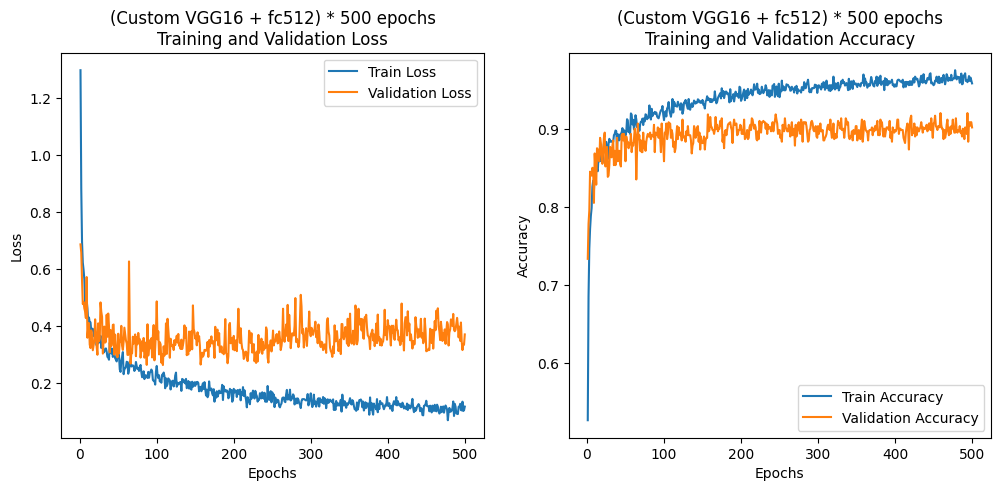

In [213]:
plot_losses_and_accuracies(performance, 
                           '(Custom VGG16 + fc512) * 500 epochs',
                           './figures/customvgg16plusfc512classifierepochs_500_loss_and_acc.png')

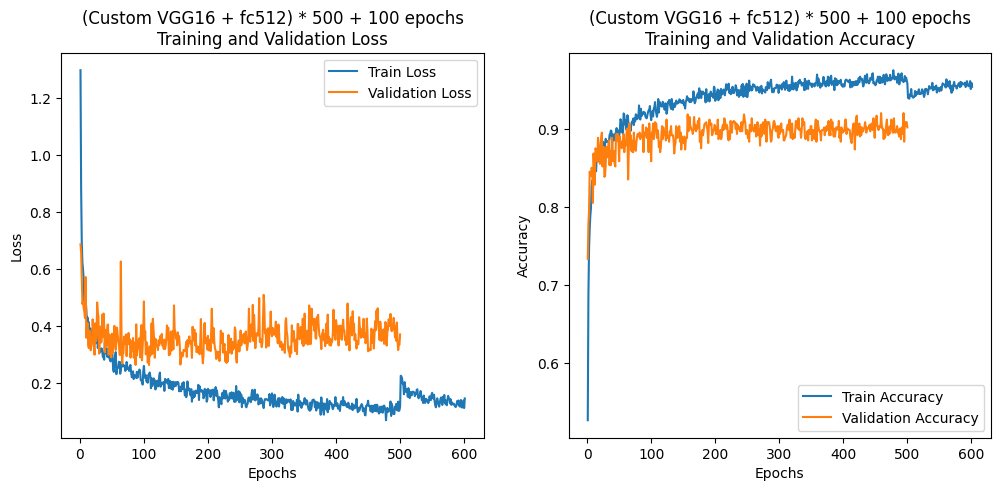

In [219]:
plot_losses_and_accuracies(performance, 
                           '(Custom VGG16 + fc512) * 500 + 100 epochs',
                           './figures/customvgg16plusfc512classifierepochs_500+100_loss_and_acc.png')

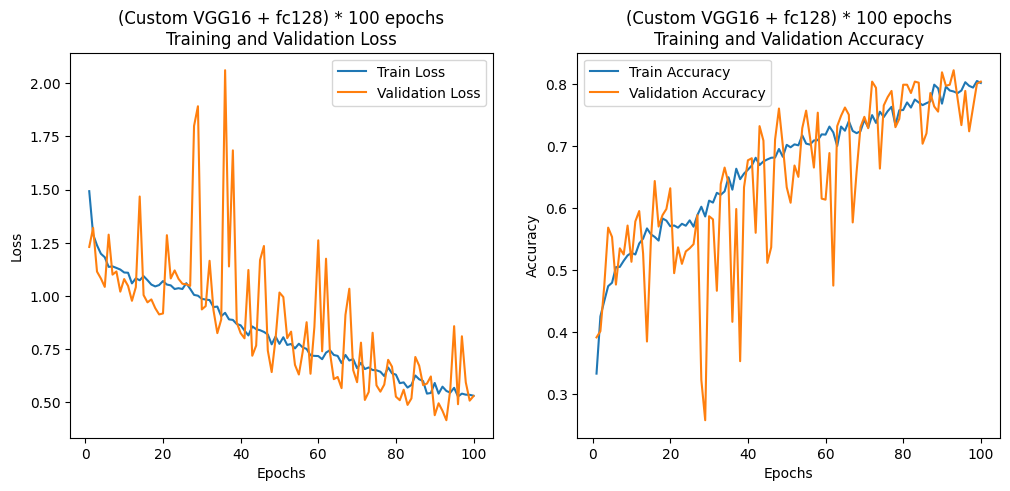

In [232]:
plot_losses_and_accuracies(performance, '(Custom VGG16 + fc128) * 100 epochs',
                           './figures/customvgg16plusfc128fullparametersepochs_100_loss_and_acc.png')

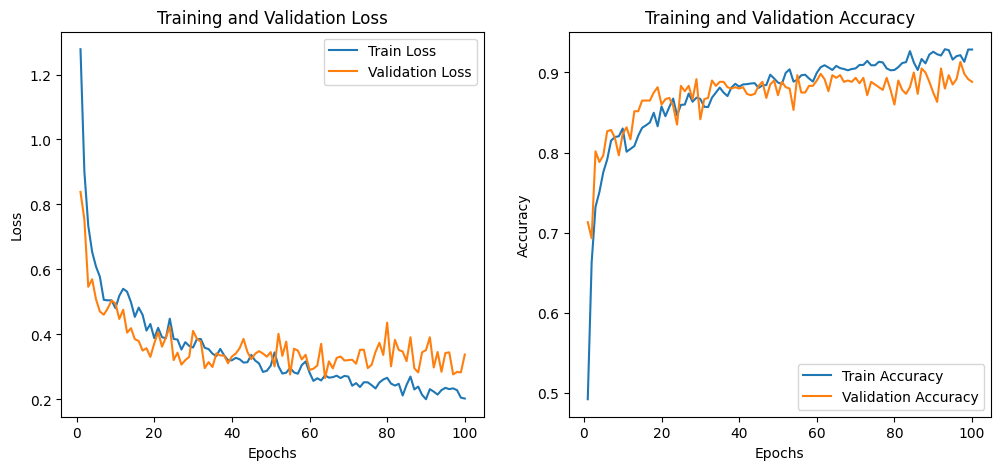

[0.49254901960784314, 0.6631372549019607, 0.7325490196078431, 0.7509803921568627, 0.7756862745098039, 0.7913725490196079, 0.8149019607843138, 0.8196078431372549, 0.8203921568627451, 0.8301960784313726, 0.8011764705882353, 0.8047058823529412, 0.808235294117647, 0.8211764705882353, 0.8309803921568627, 0.8341176470588235, 0.8376470588235294, 0.8498039215686275, 0.8329411764705882, 0.8576470588235294, 0.8454901960784313, 0.8568627450980392, 0.8674509803921568, 0.8466666666666667, 0.8596078431372549, 0.86, 0.8737254901960785, 0.8635294117647059, 0.8686274509803922, 0.8670588235294118, 0.8572549019607844, 0.8568627450980392, 0.8686274509803922, 0.8749019607843137, 0.8811764705882353, 0.8749019607843137, 0.8705882352941177, 0.8811764705882353, 0.8858823529411765, 0.8823529411764706, 0.8850980392156863, 0.8854901960784314, 0.8862745098039215, 0.8866666666666667, 0.8807843137254902, 0.883921568627451, 0.884313725490196, 0.8972549019607843, 0.8925490196078432, 0.8874509803921569, 0.8854901960784

In [237]:
plot_losses_and_accuracies(performance)
print(performance['train_accuracies'])
print(performance['val_accuracies'])
print(performance['train_accuracies'][99])
print(performance['val_accuracies'][99])

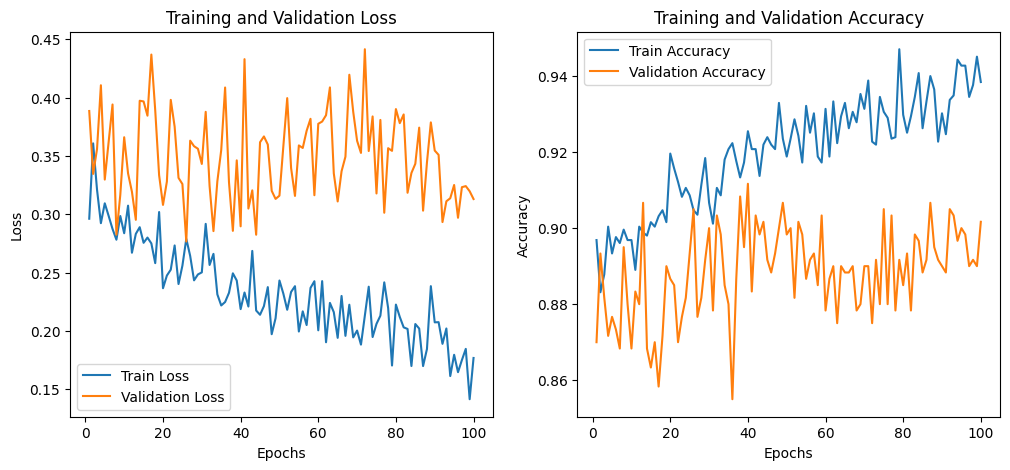

In [281]:
plot_losses_and_accuracies(performance)
# print(performance['train_accuracies'])
# print(performance['val_accuracies'])
# print(performance['train_accuracies'][99])
# print(performance['val_accuracies'][99])

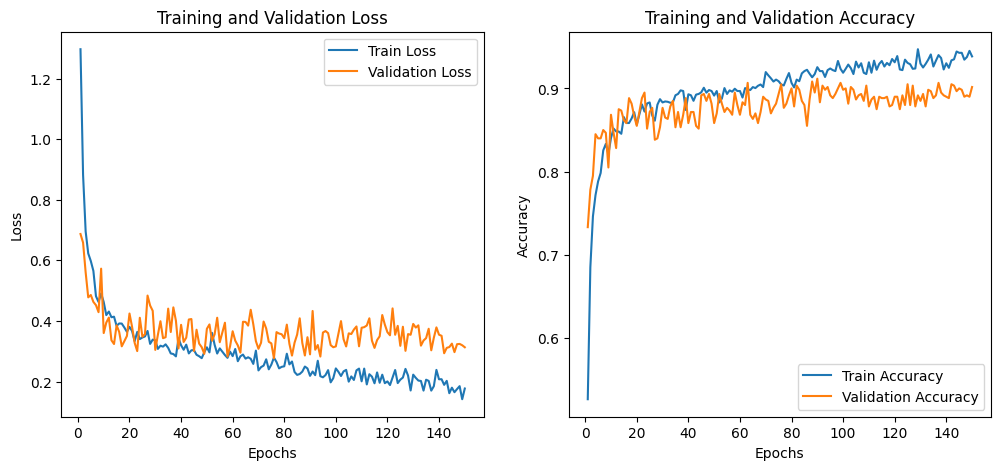

In [280]:
plot_losses_and_accuracies(performance_512_FF50_FT100)
# print(performance['train_accuracies'])
# print(performance['val_accuracies'])
# print(performance['train_accuracies'][99])
# print(performance['val_accuracies'][99])

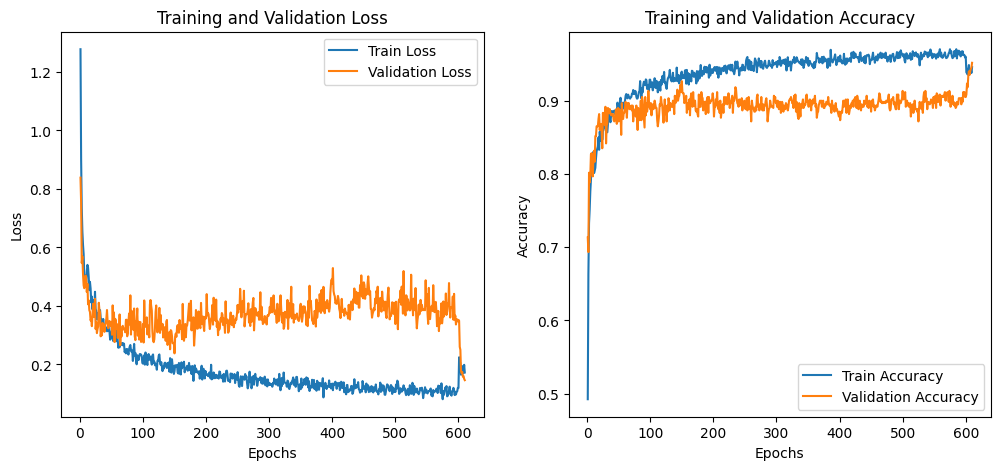

In [114]:
# Plotting Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

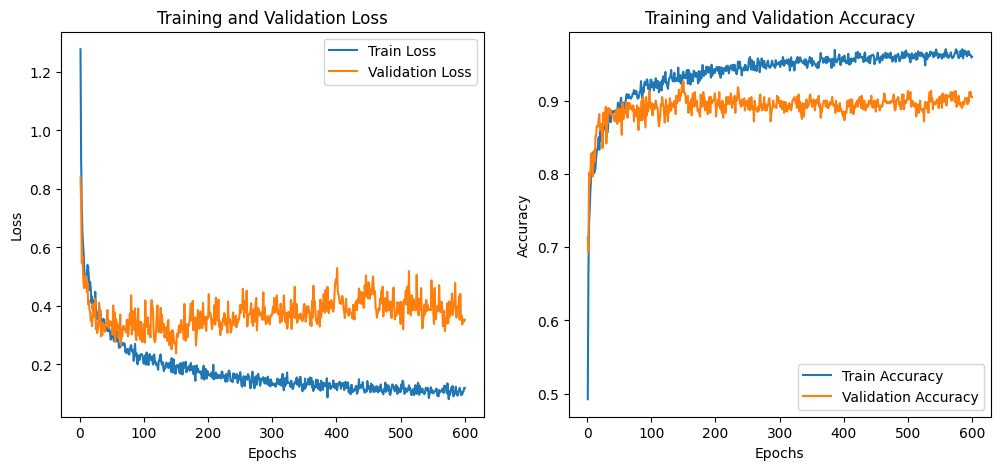

In [105]:
# Plotting Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

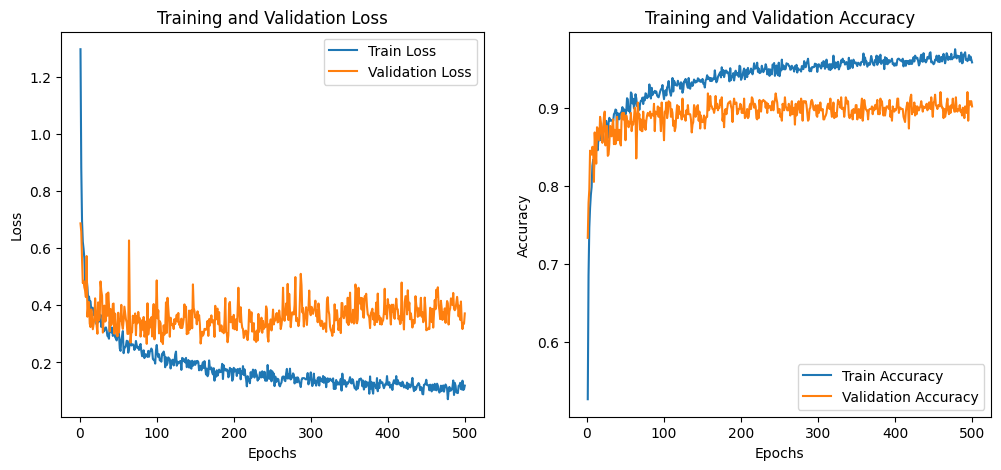

In [203]:
# Plotting Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

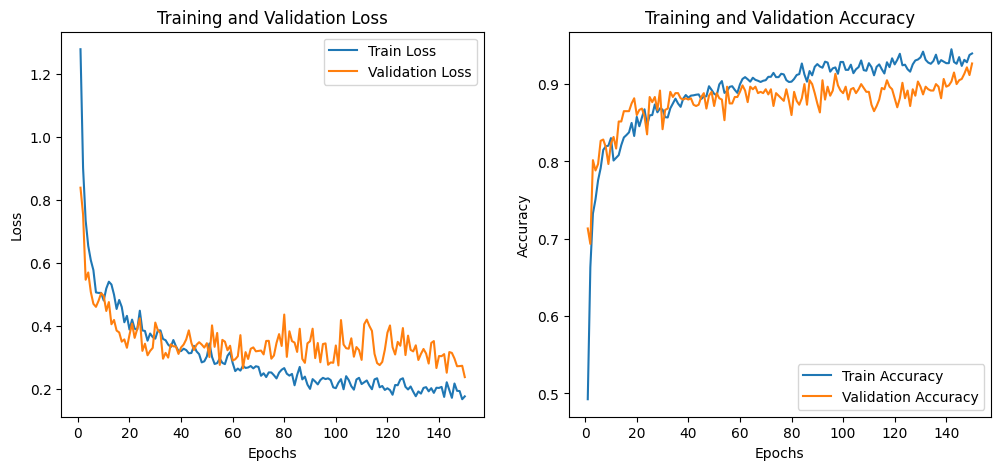

In [143]:
# Plotting Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('./figures/customvgg16plusfc128classifierepochs_150_loss_and_acc.png')

plt.show()

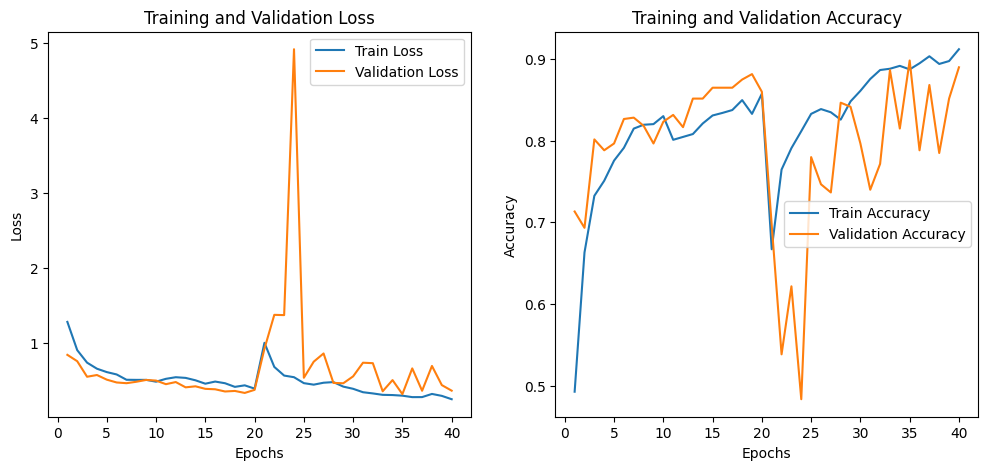

In [109]:
# Plotting Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
# model_path = './saved_models/'
# Save the entire model
# torch.save(custom_vgg16, 'custom_vgg16_full_model.pth')
# custom_vgg16.to('cpu')
# torch.save(custom_vgg16, model_path + 'custom_vgg16_full_model_epochs_30+10.pth')
torch.save(model, model_path + 'custom_vgg16_plus_fc_128_classifier_epochs_50.pth')

In [139]:
# model_path = './saved_models/epochs/'

# custom_vgg16 = torch.load(model_path + 'custom_vgg16_classifier_epochs_30.pth')
custom_vgg16_plus = torch.load('./saved_models/vgg16_plus_128/' + 'customvgg16plusfc128classifierepochs_150.pth')
model = custom_vgg16_plus.to(device)

In [ ]:
from torchsummary import summary

# Assuming the model expects 224x224 RGB images
summary(vgg16, (3, 224, 224))

In [ ]:
print(vgg16.children)

In [ ]:
print(list(vgg16.children())[:-1])

In [ ]:
avgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
anum_features = avgg16.classifier[6].in_features
print('AAA', anum_features)
afeatures = list(avgg16.classifier.children())[:-1]  # Remove last layer
print('BBB', afeatures)
afeatures.extend([nn.Linear(anum_features, num_classes)])  # Add our layer with 6 outputs
print('CCC', afeatures)
avgg16.classifier = nn.Sequential(*afeatures)  # Replace the model classifier
print('DDD', avgg16.children)
avgg16 = avgg16.to(device)

### Visualizing model performance

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# # Plotting training and validation accuracy
# ax[0].plot(train_accuracies)
# ax[0].plot(val_accuracies)
# ax[0].set_title('Model Accuracy')
# ax[0].set_xlabel('Epochs')
# ax[0].set_ylabel('Accuracy')
# ax[0].legend(['Train', 'Val'])

# # Plotting training and validation loss
# ax[1].plot(train_losses)
# ax[1].plot(val_losses)
# ax[1].set_title('Model Loss')
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Loss')
# ax[1].legend(['Train', 'Val'])

# plt.show()

## D. Evaluating Your Trained Model

### Process Test Dataset

In [ ]:
# Download test dataset, 
# !wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [18]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test_torch = torch.from_numpy(x_test).float()
y_test_torch = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test_torch.max().item()}, min value is {x_test_torch.min().item()}, data type is {x_test_torch.dtype}.')

batch_size = 32

x_test_transformed = torch.stack([inference_transform(tpi(x)) for x in x_test_torch])

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test_transformed, y_test_torch)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [117]:
test_losses = []
test_accuracies = []
true_labels = []
predictions = []
logit_outputs = []

test_model = model_a

criterion = nn.CrossEntropyLoss()

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return predicted, correct / labels.size(0)


test_model.eval()
test_loss = 0.0
test_correct = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
    
        outputs = test_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted, accuracy = calculate_accuracy(outputs, labels)
        test_correct += accuracy * labels.size(0)
        total_test += labels.size(0)
        
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        logit_outputs.extend(outputs.tolist())
        
# Calculate average losses and accuracies
test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / total_test


test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
# print(true_labels)
# print(predictions)
# print(logit_outputs)

Test Loss: 0.2499, Test Accuracy: 0.9383


In [285]:
test_losses = []
test_accuracies = []
true_labels = []
predictions = []
logit_outputs = []

test_model = model

criterion = nn.CrossEntropyLoss()

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return predicted, correct / labels.size(0)


test_model.eval()
test_loss = 0.0
test_correct = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
    
        outputs = test_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted, accuracy = calculate_accuracy(outputs, labels)
        test_correct += accuracy * labels.size(0)
        total_test += labels.size(0)
        
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        logit_outputs.extend(outputs.tolist())
        
# Calculate average losses and accuracies
test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / total_test


test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
# print(true_labels)
# print(predictions)
# print(logit_outputs)

Test Loss: 0.2575, Test Accuracy: 0.9200


In [170]:
import torch
import gc

torch.cuda.empty_cache()  # Release GPU cache memory

gc.collect()  # Collect garbage in RAM


100189

In [44]:
# samples_size = 100
# random_indices = random.sample(range(600), samples_size)
# outputs = model(x_test_transformed.to(device)[random_indices])
# acc = calculate_accuracy(outputs, y_test_torch.to(device)[random_indices])

# print(acc)

In [ ]:
# _, predicted = torch.max(outputs.data, 1)
# print(predictions_finetune := predicted.cpu())
# print(predictions_feature_extract := predicted.cpu())
# print(true_labels := y_test_torch.to(device)[random_indices].cpu())

In [172]:
predictions_finetune = predictions
predictions_feature_extract = predictions

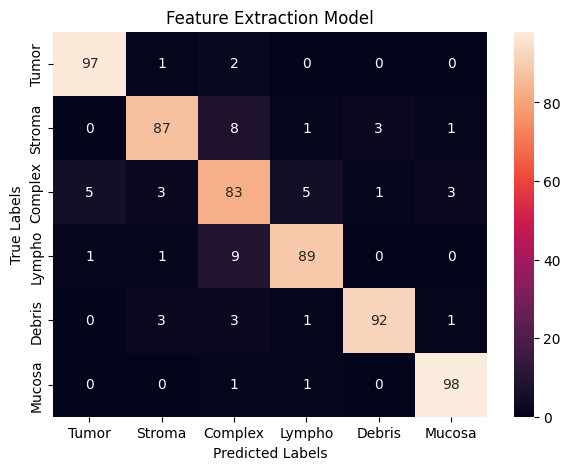

In [185]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assume these are your true labels and predictions from each model
# true_labels = [...]
# predictions_finetune = [...]
# predictions_feature_extract = [...]

# Confusion matrices
# cm_finetune = confusion_matrix(true_labels, predictions_finetune)
cm_feature_extract = confusion_matrix(true_labels, predictions_feature_extract)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# sns.heatmap(cm_finetune, annot=True, ax=ax[0], fmt='g')
# ax[0].set_title('Fine-Tuning Model')
sns.heatmap(cm_feature_extract, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
ax.set_title('Feature Extraction Model')
# Adding labels for the axes
ax.set_xlabel('Predicted Labels')  # X-axis label
ax.set_ylabel('True Labels')       # Y-axis label
plt.savefig('./figures/customvgg16plusfc128classifierepochs_150_confusion_matrix.png')
plt.show()


In [174]:
# from sklearn.metrics import f1_score, roc_auc_score

# # Assuming binary classification and predictions are probability scores
# # Replace these with your actual predictions and labels
# # y_true = [...]  # True labels
# # y_pred_finetune = [...]  # Predictions from fine-tuned model
# # y_pred_feature_extract = [...]  # Predictions from feature extraction model

# y_true = true_labels
# y_pred_finetune = predictions_finetune
# y_pred_feature_extract = predictions_feature_extract

# # F1 Score
# f1_finetune = f1_score(y_true, y_pred_finetune > 0.5)  # Using 0.5 as threshold
# f1_feature_extract = f1_score(y_true, y_pred_feature_extract > 0.5)

# # AUC
# auc_finetune = roc_auc_score(y_true, y_pred_finetune)
# auc_feature_extract = roc_auc_score(y_true, y_pred_feature_extract)

# print("F1 Score - Fine-tune:", f1_finetune, "| Feature Extract:", f1_feature_extract)
# print("AUC - Fine-tune:", auc_finetune, "| Feature Extract:", auc_feature_extract)


In [175]:
import numpy as np
from scipy.special import softmax
from sklearn.metrics import roc_auc_score

# Example true_labels and logit_outputs
# true_labels = np.array([...]).reshape(-1, 1)  # (sample_size, 1)
# logit_outputs = np.array([...])  # (sample_size, num_classes)

# Reshape true_labels to a 1D array
true_labels_1d = np.array(true_labels)

# Apply softmax to logit_outputs to get probabilities
prob_outputs = softmax(logit_outputs, axis=1)

# Calculate ROC AUC score using One-vs-Rest approach
auc_score = roc_auc_score(true_labels_1d, prob_outputs, multi_class='ovr')

print("ROC AUC Score:", auc_score)


ROC AUC Score: 0.9927833333333335


In [176]:
from sklearn.metrics import f1_score, roc_auc_score

# Assuming binary classification and predictions are probability scores
# Replace these with your actual predictions and labels
# y_true = [...]  # True labels
# y_pred_finetune = [...]  # Predictions from fine-tuned model
# y_pred_feature_extract = [...]  # Predictions from feature extraction model

for i in range(num_classes):
    y_true = (np.array(true_labels)==i) * 1
    y_pred_feature_extract = (np.array(predictions_feature_extract)==i) * 1

    # F1 Score
    f1_feature_extract = f1_score(y_true, y_pred_feature_extract)

    

    print(f"class {i}: ")
    print("f1 Feature Extract:", f1_feature_extract)
    
    
# Reshape true_labels to a 1D array
true_labels_1d = np.array(true_labels)

# Apply softmax to logit_outputs to get probabilities
prob_outputs = softmax(logit_outputs, axis=1)

# Calculate ROC AUC score using One-vs-Rest approach
auc_score = roc_auc_score(true_labels_1d, prob_outputs, multi_class='ovr')
print()
print("ROC AUC Score:", auc_score)

class 0: 
f1 Feature Extract: 0.9556650246305418
class 1: 
f1 Feature Extract: 0.8923076923076922
class 2: 
f1 Feature Extract: 0.8058252427184467
class 3: 
f1 Feature Extract: 0.9035532994923858
class 4: 
f1 Feature Extract: 0.9387755102040817
class 5: 
f1 Feature Extract: 0.9655172413793104

ROC AUC Score: 0.9927833333333335


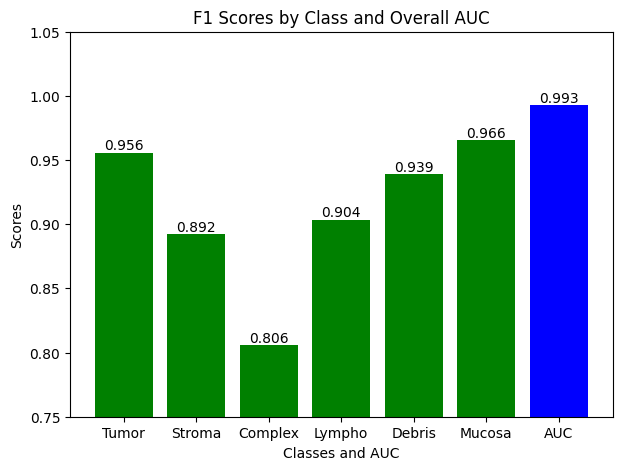

In [189]:
import matplotlib.pyplot as plt

# F1 scores for each class
f1_scores = [0.9556650246305418, 0.8923076923076922, 0.8058252427184467, 
             0.9035532994923858, 0.9387755102040817, 0.9655172413793104]

# AUC score
auc_score = 0.9927833333333335

# Combine F1 scores and AUC score into one list
performance_scores = f1_scores + [auc_score]

# Labels for the histogram
labels = [*class_names, 'AUC']

# Creating the histogram
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, performance_scores, color=['green', 'green', 'green', 'green', 'green', 'green', 'blue'])

# Adding the value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center')

plt.xlabel('Classes and AUC')
plt.ylabel('Scores')
plt.title('F1 Scores by Class and Overall AUC')
plt.ylim(0.75, 1.05)  # Adjusting y-axis to better display the scores

plt.savefig('./figures/customvgg16plusfc128classifierepochs_150_f1-score_and_average_AUC.png')
plt.show()



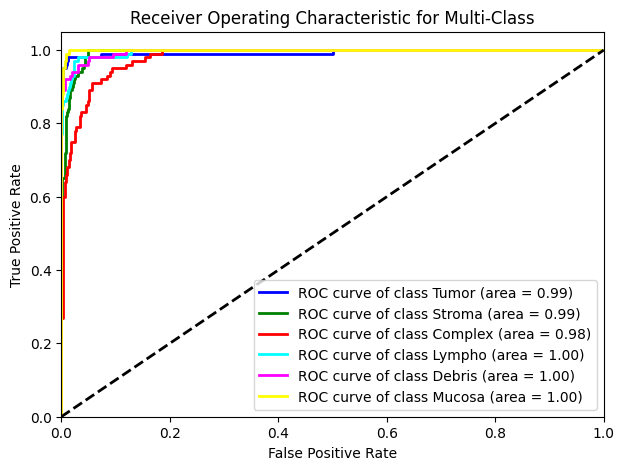

In [187]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import numpy as np

# Assuming you have true_labels and logit_outputs
# true_labels = [...]
# logit_outputs = [...]

# num_classes = prob_outputs.shape[1]
true_labels_1d = np.array(true_labels)
# Binarize the labels for One-vs-Rest computation
true_labels_binarized = label_binarize(true_labels_1d, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], prob_outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve for each class
plt.figure(figsize=(7, 5))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")

plt.savefig('./figures/customvgg16plusfc128classifierepochs_150_ROC-AUC.png')
plt.show()


In [65]:
print(true_labels)
print(y_pred_feature_extract)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [58]:
print(predictions_feature_extract)
print(y_pred_feature_extract)
print(np.array(true_labels)[np.array(true_labels)==1])

[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 0, 2, 0, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [39]:
# import os

# def rename_files(old_directory, new_directory):
#     """
#     Rename files in the given directory to a new directory with a sequential number.
    
#     Args:
#     - old_directory (str): The current directory containing the files.
#     - new_directory (str): The new directory to move the files to.
#     """
    
#     # Create the new directory if it does not exist
#     if not os.path.exists(new_directory):
#         os.makedirs(new_directory)

#     for i, filename in enumerate(os.listdir(old_directory)):
        
#         try:
#             series_no = int(filename.split('_')[-1].split('.')[0])
#         except:
#             continue
        
#         file_head = ''.join(filename.split('_')[:-1])
#         file_extension = filename.split('_')[-1].split('.')[1]
        
#         if series_no > 50 and series_no % 10 == 0:
            
#             new_filename = file_head + '_' + str(series_no + 50) + '.' + file_extension
#             # Construct the full file path
#             old_file = os.path.join(old_directory, filename)

#             # Create the new file name with a sequential number
#             new_file = os.path.join(new_directory, new_filename)

#             # Rename the file
#             os.rename(old_file, new_file)
#             print(f"Renamed '{old_file}' to '{new_file}'")
    
    
#     for i, filename in enumerate(os.listdir(old_directory)):
        
#         try:
#             series_no = int(filename.split('_')[-1].split('.')[0])
#         except:
#             continue
            
#         file_head = ''.join(filename.split('_')[:-1])
#         file_extension = filename.split('_')[-1].split('.')[1]
        
#         if series_no > 50 and series_no % 10 == 9:
            
#             new_filename = file_head + '_' + str(series_no + 1) + '.' + file_extension
#             # Construct the full file path
#             old_file = os.path.join(old_directory, filename)

#             # Create the new file name with a sequential number
#             new_file = os.path.join(new_directory, new_filename)

#             # Rename the file
#             os.rename(old_file, new_file)
#             print(f"Renamed '{old_file}' to '{new_file}'")
        
#     for i, filename in enumerate(os.listdir(old_directory)):
        
#         try:
#             series_no = int(filename.split('_')[-1].split('.')[0])
#         except:
#             continue
            
#         file_head = ''.join(filename.split('_')[:-1])
#         file_extension = filename.split('_')[-1].split('.')[1]
        
#         if series_no <= 50:
            
#             new_filename = filename
#             # Construct the full file path
#             old_file = os.path.join(old_directory, filename)

#             # Create the new file name with a sequential number
#             new_file = os.path.join(new_directory, new_filename)

#             # Rename the file
#             os.rename(old_file, new_file)
#             print(f"Renamed '{old_file}' to '{new_file}'")

#     for i, filename in enumerate(os.listdir(old_directory)):
        
#         try:
#             series_no = int(filename.split('_')[-1].split('.')[0])
#             continue
            
#         except:
#             new_filename = filename
            
#             # Construct the full file path
#             old_file = os.path.join(old_directory, filename)

#             # Create the new file name with a sequential number
#             new_file = os.path.join(new_directory, new_filename)

#             # Rename the file
#             os.rename(old_file, new_file)
#             print(f"Renamed '{old_file}' to '{new_file}'")



In [40]:
# # Usage example
# old_directory_path = './saved_models/'  # Replace with your directory path
# new_directory_path = './saved_models/epochs/'  # Replace with your desired new directory
# rename_files(old_directory_path, new_directory_path)

Renamed './saved_models/custom_vgg16_plus_fc_128_classifier_epochs_100.pth' to './saved_models/epochs/customvgg16plusfc128classifierepochs_150.pth'
Renamed './saved_models/custom_vgg16_plus_fc_128_classifier_epochs_110.pth' to './saved_models/epochs/customvgg16plusfc128classifierepochs_160.pth'
Renamed './saved_models/custom_vgg16_plus_fc_128_classifier_epochs_120.pth' to './saved_models/epochs/customvgg16plusfc128classifierepochs_170.pth'
Renamed './saved_models/custom_vgg16_plus_fc_128_classifier_epochs_130.pth' to './saved_models/epochs/customvgg16plusfc128classifierepochs_180.pth'
Renamed './saved_models/custom_vgg16_plus_fc_128_classifier_epochs_140.pth' to './saved_models/epochs/customvgg16plusfc128classifierepochs_190.pth'
Renamed './saved_models/custom_vgg16_plus_fc_128_classifier_epochs_150.pth' to './saved_models/epochs/customvgg16plusfc128classifierepochs_200.pth'
Renamed './saved_models/custom_vgg16_plus_fc_128_classifier_epochs_160.pth' to './saved_models/epochs/customvgg1

OSError: [WinError 87] 參數錯誤。: './saved_models/epochs' -> './saved_models/epochs/epochs'

In [81]:
print(3 if 2 else 1)

3


In [245]:
performance_128_FT = load_data_pickle('./performance/vgg16_plus_128_fine_tuning/custom_vgg16_plus_fc_128__fine_tuning_epochs_100.pkl')

In [258]:
performance_128_FF50_FT50 = load_data_pickle('./performance/vgg16_plus_128_ff50_ft50/custom_vgg16_plus_fc_128_ff50_ft_epochs_50.pkl')
temp = load_data_pickle('./performance/vgg16_plus_128/custom_vgg16_plus_fc_128_classifier_epochs_50.pkl')
performance_128_FF50_FT50['train_losses'] = temp['train_losses'] + performance_128_FF50_FT50['train_losses']
performance_128_FF50_FT50['val_losses'] = temp['val_losses'] + performance_128_FF50_FT50['val_losses']
performance_128_FF50_FT50['train_accuracies'] = temp['train_accuracies'] + performance_128_FF50_FT50['train_accuracies']
performance_128_FF50_FT50['val_accuracies'] = temp['val_accuracies'] + performance_128_FF50_FT50['val_accuracies']

In [243]:
performance_128_FF = load_data_pickle('./performance/vgg16_plus_128/customvgg16plusfc128classifierepochs_100.pkl')

In [260]:
performance_512_FF = load_data_pickle('./performance/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier_epochs_100.pkl')

In [265]:
performance_512_FT =  load_data_pickle('./performance/vgg16_plus_512_fine_tuning/custom_vgg16_plus_fc_512_fine_tuning_epochs_100.pkl')

In [274]:
performance_512_FF50_FT50 = load_data_pickle('./performance/vgg16_plus_512_ff50_ft50/custom_vgg16_plus_fc_512_ff50_ft_epochs_50.pkl')
temp = load_data_pickle('./performance/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier_epochs_50.pkl')
performance_512_FF50_FT50['train_losses'] = temp['train_losses'] + performance_512_FF50_FT50['train_losses']
performance_512_FF50_FT50['val_losses'] = temp['val_losses'] + performance_512_FF50_FT50['val_losses']
performance_512_FF50_FT50['train_accuracies'] = temp['train_accuracies'] + performance_512_FF50_FT50['train_accuracies']
performance_512_FF50_FT50['val_accuracies'] = temp['val_accuracies'] + performance_512_FF50_FT50['val_accuracies']

In [279]:
performance_512_FF50_FT100 = load_data_pickle('./performance/vgg16_plus_512_ff50_ft50/custom_vgg16_plus_fc_512_ff50_ft_epochs_100.pkl')
temp = load_data_pickle('./performance/vgg16_plus_512/custom_vgg16_plus_fc_512_classifier_epochs_50.pkl')
performance_512_FF50_FT100['train_losses'] = temp['train_losses'] + performance_512_FF50_FT100['train_losses']
performance_512_FF50_FT100['val_losses'] = temp['val_losses'] + performance_512_FF50_FT100['val_losses']
performance_512_FF50_FT100['train_accuracies'] = temp['train_accuracies'] + performance_512_FF50_FT100['train_accuracies']
performance_512_FF50_FT100['val_accuracies'] = temp['val_accuracies'] + performance_512_FF50_FT100['val_accuracies']

In [286]:
performance_128_FF150 = load_data_pickle('./performance/vgg16_plus_128/customvgg16plusfc128classifierepochs_150.pkl')

In [284]:
# model = torch.load('./saved_models/vgg16_plus_512_ff50_ft50/' + 'custom_vgg16_plus_fc_512_ff50_ft_valacc_0.9117.pth')
# model = model.to(device)


In [287]:
performance_128_FF150['train_accuracies'][-1]

0.9396078431372549

In [291]:
def plot_losses_and_accuracies(performance, title=None, filename=None):
    train_losses = performance['train_losses']
    val_losses = performance['val_losses']
    train_accuracies = performance['train_accuracies']
    val_accuracies = performance['val_accuracies']
    # Plotting Losses
    plt.figure(figsize=(7, 5))
#     plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    loss_title = ((title + '\n') if title else '') + 'Training and Validation Loss'
    plt.title(loss_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if filename:
        plt.savefig(filename + '_losses.png')
    plt.show()
        
    plt.figure(figsize=(7, 5))
    # Plotting Accuracies
#     plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
    acc_title = ((title + '\n') if title else '') + 'Training and Validation Accuracy'
    plt.title(acc_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    if filename:
        plt.savefig(filename + '_accuracies.png')

    plt.show()
    
    

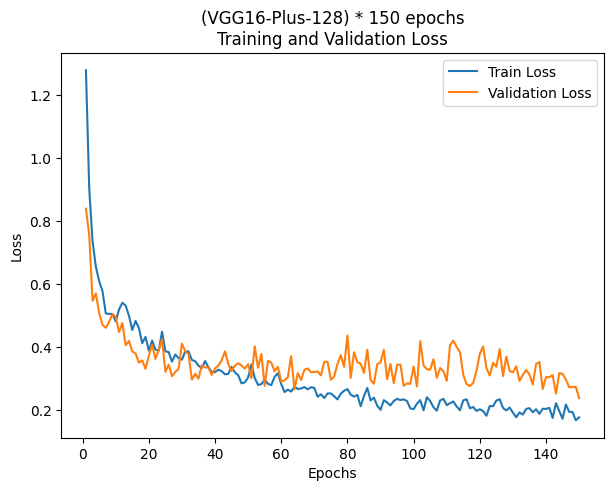

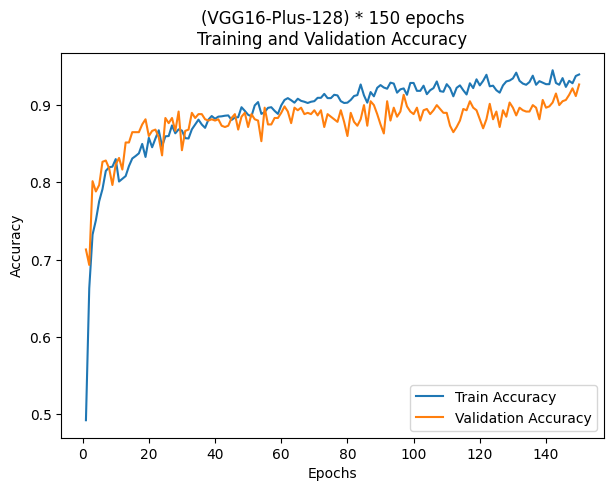

In [292]:
plot_losses_and_accuracies(performance_128_FF150, 
                           '(VGG16-Plus-128) * 150 epochs',
                           './figures/customvgg16plusfc128classifierepochs_150.png')